In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
from tqdm import tqdm_notebook
from joblib import Parallel,delayed,effective_n_jobs

In [4]:
import pymorphy2
import nltk

In [5]:
import gensim

In [6]:
assistant_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
assistant_table = list(assistant_table)
assistant_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [7]:
quasar_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
quasar_table = list(quasar_table)
quasar_table[0].keys()

dict_keys(['mds_key', 'linguists_sugested_text', 'toloka_text', 'toloka_assignments_repeat_2_with_chorus_and_pitch', 'spotter_tail_trim', 'toloka_assignments_repeat_4_selected_workers_with_pitch', '_other', 'check_in_yang_results', 'spotter_mds_key', 'date', 'number_of_speakers', 'text', 'downloadUrl', 'toloka_assignments_repeat_3_selected_workers_with_chorus_and_pitch', 'spotter_max_length', 'raw_text_linguists', 'linguists_comment', 'toloka_number_of_speakers', 'mdsFileName', 'toloka_assignments_repeat_1', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'url_in_first_toloka', 'asr_mds_key', 'toloka_assignments', 'audio', 'url', 'initialFileName'])

In [52]:
data = []
data_with_spell_corr = []
for row in assistant_table:
    for assignment in row['toloka_assignments_repeat_11_selected_workers_with_pitch']:
        new_row = dict()
        for key in ('speech', 'submit_ts', 'text', 'number_of_speakers', 'worker_id'):
            new_row[key] = assignment[key]
        new_row['is_right'] = 1 if row['text'] == assignment['text'] else 0
        new_row['mark'] = row['mark']
        new_row['assistant'] = 1
        data.append(new_row)
        data_with_spell_corr.append(new_row.copy())
for row in quasar_table:
    for assignment in row['toloka_assignments_repeat_4_selected_workers_with_pitch']:
        new_row = dict()
        for key in ('speech', 'submit_ts', 'text', 'number_of_speakers', 'worker_id'):
            new_row[key] = assignment[key]
        new_row['is_right'] = 1 if row['text'] == assignment['text'] else 0
        new_row['mark'] = row['mark']
        new_row['assistant'] = 0
        data.append(new_row)
        data_with_spell_corr.append(new_row.copy())
data = pd.DataFrame(data)
data_with_spell_corr = pd.DataFrame(data_with_spell_corr)
data.sample(5)

,assistant,is_right,mark,number_of_speakers,speech,submit_ts,text,worker_id
2212,1,1,TEST,one,OK_one_speaker,1568945615580,алиса тебе будет хрясь,8e131452720305e11e6c6038dac334d7
125660,0,0,TRAIN,None,BAD,1568740286912,,c68fc509f5680ad471ede8e0570f40c0
34090,1,1,TEST,None,BAD,1568927682303,,576f30216cefc6149e669b5a4bdb5308
94077,0,1,TEST,one,OK_one_speaker,1568745698853,алиса какая самая хорошая киношкола,f553952d6837dbd335a3309dbe018924
39912,1,1,TRAIN,None,BAD,1568956902697,,ba1a1e2fa25e12cf624fcd9a020768e9


In [53]:
categorical_columns = ['assistant', 'number_of_speakers', 'speech', 'worker_id']
target_column = 'is_right'

In [54]:
data[categorical_columns] = data[categorical_columns].fillna('NaN')

In [11]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

def fix_misspellings(text):
    headers = {
        'Connection': 'close'
    }
    params={
        'text':text,
        'lang':'ru',
        'options':'512',
    }
    s = requests.Session()
    retries = Retry(total=10, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
    s.mount('http://', HTTPAdapter(max_retries=retries))
    try:
        resp=s.get('https://speller.yandex.net/services/spellservice.json/checkText',params=params,headers=headers)
        resp=resp.json()
    except ValueError:
        print(resp)
    if not resp:
        return text
    first_pos=0
    new_text=[]
    for fix in resp:
        new_text.append(text[first_pos:fix['pos']].strip())
        new_text.append(fix['s'][0].strip())
        first_pos=fix['pos']+fix['len']
    new_text.append(text[first_pos:].strip())
    return ' '.join(new_text).strip()

In [12]:
def process_entry(entry):
    new_entry = entry
    new_entry['text']=fix_misspellings(new_entry['text'].lower().replace('ё', 'е'))
    return new_entry

In [13]:
out = [process_entry(row) for i, row in data.iterrows() if i < 10]

In [11]:
fasttext_model = gensim.models.FastText.load_fasttext_format('toloka_logs/fasttext_output.bin')

In [12]:
fasttext_model.most_similar(positive=['включить'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('коэффициенты', 0.4270741939544678),
 ('уфе', 0.3896294832229614),
 ('причины', 0.3816145658493042),
 ('сета', 0.3785386085510254),
 ('судах', 0.373282253742218),
 ('пощечину', 0.3699240982532501),
 ('смерш', 0.36963844299316406),
 ('смешариков', 0.3690463900566101),
 ('пощечина', 0.3637527823448181),
 ('поживей', 0.362947940826416)]

In [13]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
morph = pymorphy2.MorphAnalyzer()

data['text'] = data['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data['text'] = data['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))

In [14]:
print("Tokenized:")
data["text"][2::30000]

Tokenized:


2                                  
30002                              
60002                   купить слон
90002                    алиса стоп
120002    алиса выключить будильник
Name: text, dtype: object

In [15]:
print("Fixed and tokenized:")
data_with_spell_corr["text"][3::30000]

Fixed and tokenized:


3                                
30003                            
60003                  купи слона
90003                  алиса стоп
120003    алиса выключи будильник
Name: text, dtype: object

In [16]:
import json

In [17]:
path = 'toloka_logs/assistant_raw_logs.jsonl'
all_tokens = []
with open(path) as inf:
    for line in tqdm_notebook(inf):
        line_parsed = json.loads(line.strip())['raw_assesments']
        if line_parsed:
            for assesment in line_parsed:
                all_tokens += assesment['text'].lower().replace('ё','е').split()

In [21]:
# Count how many times does each token occur in "text" in total
# build a dictionary { token -> its count }
from collections import Counter

token_counts = Counter()
for row in data.text:
    for word in row.split():
        token_counts[word] += 1

In [41]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 12754
('алиса', 67437)
('включить', 15714)
('я', 11367)
('ты', 10891)
('?', 9608)
...
('семдесить', 1)
('влючаять', 1)
('профонация', 1)


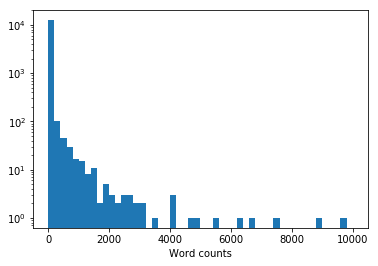

In [42]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [55]:
all_token_counts = Counter()
for word in all_tokens:
    all_token_counts[word] += 1

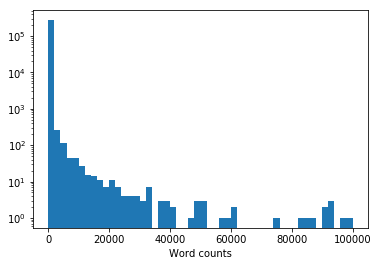

In [56]:
plt.hist(list(all_token_counts.values()), range=[0, 10**5], bins=50, log=True)
plt.xlabel("Word counts");

In [57]:
min_count = 2

# tokens from all_token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key, value in all_token_counts.items() if value >= min_count]

In [58]:
len(tokens)

138565

In [59]:
# Add a special tokens for unknown and empty words
UNK, PAD = "?", "PAD"
tokens = [PAD] + sorted(tokens)
MAX_NB_WORDS = len(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert UNK in tokens
print("Correct!")

Vocabulary size: 138566
Correct!


In [60]:
token_to_id = {token: index for index, token in enumerate(tokens)}
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


In [61]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences, str):
        sequences = [sequences.split()]
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    if max_len is None:
        max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [62]:
print("Lines:")
print('\n'.join(data["text"][::30000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["text"][::30000]))

Lines:


купи слона
алиса стоп
алиса выключи будильник

Matrix:
[[     0      0      0]
 [     0      0      0]
 [ 54775 109820      0]
 [  5146 114975      0]
 [  5146  21702  14160]]


In [63]:
data_train = data[data['mark'] == 'TRAIN']
data_val = data[data['mark'] == 'TEST']
data_train = data_train.drop(columns=['mark'])
data_val = data_val.drop(columns=['mark'])
data_train.shape, data_val.shape

((71650, 7), (71370, 7))

In [31]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'text' : int64[batch, t_max_len]
    """
    batch = {}
    batch["text"] = as_matrix(data["text"].values, max_len)
    
    if word_dropout != 0:
        batch["text"] = apply_word_dropout(batch["text"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [64]:
make_batch(data_train[:-3], max_len=20)

{'text': array([[  2821, 130204, 137834, ...,      0,      0,      0],
        [130204, 137834, 123227, ...,      0,      0,      0],
        [130204, 137834, 123227, ...,      0,      0,      0],
        ...,
        [  5146,  41530,      0, ...,      0,      0,      0],
        [  5146,  41530,      0, ...,      0,      0,      0],
        [  5146,  41530,      0, ...,      0,      0,      0]], dtype=int32),
 'is_right': array([0, 1, 1, ..., 1, 1, 1])}

In [33]:
import keras
import keras.layers as L
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import keras.backend as K

Using TensorFlow backend.


In [34]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [35]:
def roc_auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [36]:
embed_dim = len(fasttext_model.wv['?'])
print('embedding dimensionality: {}'.format(embed_dim))

embedding dimensionality: 100


In [65]:
pad_vector = np.zeros_like(fasttext_model.wv['?'])
embeddings_index = {'PAD': pad_vector}
for word in token_to_id:
    if word in fasttext_model.wv:
        embeddings_index[word] = fasttext_model.wv[word]

In [66]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(token_to_id))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in token_to_id.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 12


In [67]:
data['text_len'] = data['text'].apply(lambda words: len(words.split(" ")))

In [68]:
max_seq_len = np.round(data['text_len'].mean() + data['text_len'].std()).astype(int)
max_seq_len

7

In [41]:
def build_model(n_tokens=len(tokens)):
    """ Build a model that maps three data sources to a single linear output: predicted is_right"""
    s = reset_tf_session()
    l_text = L.Input(shape=[None], name="text")
    
    l_text_embedding = L.Embedding(nb_words, embed_dim, weights=[embedding_matrix], 
                                   input_length=max_seq_len, trainable=False)(l_text)
    l_text_conv = L.Conv1D(128, 3)(l_text_embedding)
    l_text_act = L.Activation("relu")(l_text_conv)
    l_text_pool = L.GlobalMaxPool1D()(l_text_act)
    l_text_pool_act = L.Activation("relu")(l_text_pool)
    
    l_text_embedding_2 = L.Embedding(nb_words, embed_dim, weights=[embedding_matrix], 
                                   input_length=max_seq_len, trainable=False)(l_text)
    l_text_conv_2 = L.Conv1D(128, 5)(l_text_embedding_2)
    l_text_act_2 = L.Activation("relu")(l_text_conv_2)
    l_text_pool_2 = L.GlobalMaxPool1D()(l_text_act_2)
    l_text_pool_act_2 = L.Activation("relu")(l_text_pool_2)
    
    merged = L.Concatenate()([l_text_pool_act, l_text_pool_act_2])
    merged_normed = L.BatchNormalization()(merged)
    
    preout = L.Dense(128)(L.Activation("relu")(merged_normed))
    
    output_layer = L.Dense(1)(L.Activation("softmax")(L.Dense(128)(L.Activation("relu")(preout))))
    
    model = keras.models.Model(inputs=[l_text], outputs=[output_layer])
    model.compile('adam', 'binary_crossentropy', metrics=['binary_crossentropy', 'binary_accuracy', roc_auc])
    return model

In [69]:
s = reset_tf_session()
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['is_right'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7, 100)       13856600    text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 7, 100)       13856600    text[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 128)       38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (

In [43]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [44]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [70]:
import keras.backend as K
K.clear_session()

Epoch 1/100
280/280 [==============================] - 16s 56ms/step - loss: 1.2035 - binary_crossentropy: 1.2035 - binary_accuracy: 0.3346 - roc_auc: 0.4396 - val_loss: 0.7946 - val_binary_crossentropy: 0.7946 - val_binary_accuracy: 0.6288 - val_roc_auc: 0.4740
Epoch 2/100
280/280 [==============================] - 15s 55ms/step - loss: 0.6144 - binary_crossentropy: 0.6144 - binary_accuracy: 0.7191 - roc_auc: 0.5932 - val_loss: 0.5218 - val_binary_crossentropy: 0.5218 - val_binary_accuracy: 0.7890 - val_roc_auc: 0.6947
Epoch 3/100
280/280 [==============================] - 15s 55ms/step - loss: 0.4782 - binary_crossentropy: 0.4782 - binary_accuracy: 0.8060 - roc_auc: 0.7573 - val_loss: 0.5064 - val_binary_crossentropy: 0.5064 - val_binary_accuracy: 0.7813 - val_roc_auc: 0.7549
Epoch 4/100
280/280 [==============================] - 15s 54ms/step - loss: 0.4174 - binary_crossentropy: 0.4174 - binary_accuracy: 0.8350 - roc_auc: 0.8192 - val_loss: 0.5232 - val_binary_crossentropy: 0.5232 

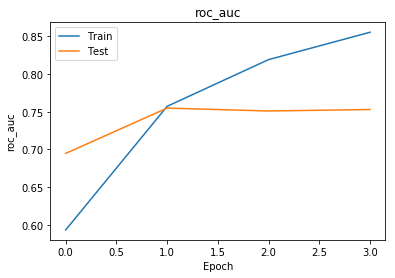

In [73]:
batch_size = 256
epochs = 100
steps_per_epoch = (len(data_train) - 1) // batch_size + 1  #for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0), 
                              epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                              validation_steps=data_val.shape[0] // batch_size,
                              callbacks=[tensorboard,
                                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

plt.plot(history.history['roc_auc'][1:])
plt.plot(history.history['val_roc_auc'][1:])
plt.title('roc_auc')
plt.ylabel('roc_auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

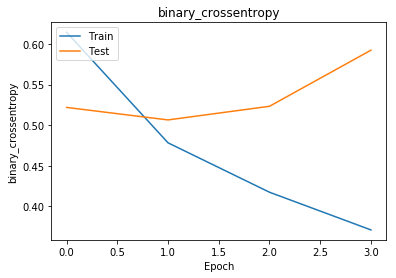

In [74]:
plt.plot(history.history['binary_crossentropy'][1:])
plt.plot(history.history['val_binary_crossentropy'][1:])
plt.title('binary_crossentropy')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [76]:
from keras.models import Model

In [77]:
def get_feature_layer(model):
    prelast_model = Model(inputs=model.input,
                          outputs=model.layers[-3].output)
    for i in range(len(prelast_model.layers)):
        prelast_model.layers[i].trainable = False
    prelast_model.summary()
    return prelast_model

In [78]:
prelast_model = get_feature_layer(model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7, 100)       13856600    text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 7, 100)       13856600    text[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 128)       38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (

In [79]:
from catboost import CatBoostClassifier

In [80]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [82]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [83]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('../..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [84]:
train_rows_q = [row for row in assistant_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in assistant_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [86]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [87]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [95]:
train_features = train_proc_q.extract_features()

In [96]:
test_features = test_proc_q.extract_features()

In [147]:
import dill

with open('../pickled/train_features.dill', 'wb') as file:
    dill.dump(train_features, file)

with open('../pickled/test_features.dill', 'wb') as file:
    dill.dump(test_features, file)

In [89]:
def make_line(text, max_len=None):
    """
    Creates a keras-friendly dict from the text.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'text' : int64[batch, t_max_len]
    """
    batch = {}
    batch["text"] = as_matrix(text, max_len)
    return batch

In [90]:
def get_solo_predictions(model, table, column, max_len=51):
    predictions = {}
    for row in table:
        url = row['url']
        predictions_for_task = []
        for i, assessment in enumerate(row[column]):
            text = assessment['text']
            keras_input = make_line(text, max_len)
            predictions_for_task.append(model.predict(keras_input)[0])
        predictions[url] = predictions_for_task
    return predictions

In [91]:
cnn_preds = get_solo_predictions(prelast_model, assistant_table, 
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch')

In [93]:
cnn_preds['https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus'][9]

array([-0.51864976, -1.0273513 , -1.3697524 ,  0.88290834, -1.8843925 ,
        0.604487  , -1.2208663 , -0.80831647, -0.954263  , -2.8037682 ,
       -0.94638973,  0.8002945 ,  0.05245861,  1.4148889 , -1.1133013 ,
       -1.5862366 ,  0.67193747, -1.1005143 ,  0.30011666,  1.0976893 ,
       -0.04568529, -0.97435415, -0.72344214, -1.015632  , -1.2592466 ,
       -1.0416867 , -2.8031993 , -1.5092058 , -0.63486356, -1.2091447 ,
        0.49002272, -0.8787525 , -0.02977603,  0.6602825 , -0.14862233,
       -1.0465765 ,  2.0753102 , -0.6847278 , -1.3308061 , -0.22333735,
        0.4305629 , -1.9059231 , -1.0974567 ,  1.1901597 ,  0.31977972,
       -1.0936961 , -1.1101615 , -1.2132057 ,  6.2324443 ,  1.1510624 ,
        0.11569789, -1.3783588 , -2.1216936 , -1.4788941 ,  0.30845737,
       -1.0887858 ,  0.08346694,  0.18249744, -2.1020458 ,  0.5856076 ,
       -1.6170988 , -1.6206347 , -1.2440232 , -1.8373103 ,  0.6244343 ,
       -0.38805768, -1.6355107 , -1.0291623 ,  0.58081025, -1.64

In [94]:
def convert_to_array(features, cnn_predictions):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            cnn_pred = cnn_predictions[task_id][cost - 1]
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.concatenate((np.array(x), cnn_pred)))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [98]:
X_train_q, Y_train_q = convert_to_array(train_features, cnn_preds)

In [ ]:
clf_q = CatBoostClassifier(iterations=27000, depth=7, thread_count=30, random_seed=42, verbose=2)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("embedding/catboost model is fitted\n")

Learning rate set to 0.00493
0:	learn: 0.6859229	total: 181ms	remaining: 1h 21m 18s
2:	learn: 0.6723761	total: 424ms	remaining: 1h 3m 36s
4:	learn: 0.6591752	total: 682ms	remaining: 1h 1m 24s
6:	learn: 0.6465479	total: 924ms	remaining: 59m 21s
8:	learn: 0.6339344	total: 1.17s	remaining: 58m 34s
10:	learn: 0.6221173	total: 1.41s	remaining: 57m 42s
12:	learn: 0.6105593	total: 1.65s	remaining: 56m 56s
14:	learn: 0.5994490	total: 1.91s	remaining: 57m 8s
16:	learn: 0.5886479	total: 2.15s	remaining: 56m 47s
18:	learn: 0.5779616	total: 2.39s	remaining: 56m 28s
20:	learn: 0.5677712	total: 2.63s	remaining: 56m 17s
22:	learn: 0.5575707	total: 2.88s	remaining: 56m 15s
24:	learn: 0.5476741	total: 3.12s	remaining: 56m 7s
26:	learn: 0.5381920	total: 3.36s	remaining: 55m 54s
28:	learn: 0.5287057	total: 3.59s	remaining: 55m 35s
30:	learn: 0.5196659	total: 3.83s	remaining: 55m 31s
32:	learn: 0.5109223	total: 4.08s	remaining: 55m 31s
34:	learn: 0.5024498	total: 4.39s	remaining: 56m 21s
36:	learn: 0.4942

308:	learn: 0.2050557	total: 37.3s	remaining: 53m 44s
310:	learn: 0.2047608	total: 37.6s	remaining: 53m 44s
312:	learn: 0.2044741	total: 37.8s	remaining: 53m 44s
314:	learn: 0.2040905	total: 38.1s	remaining: 53m 45s
316:	learn: 0.2037633	total: 38.3s	remaining: 53m 45s
318:	learn: 0.2034440	total: 38.6s	remaining: 53m 44s
320:	learn: 0.2031844	total: 38.8s	remaining: 53m 45s
322:	learn: 0.2029079	total: 39.1s	remaining: 53m 45s
324:	learn: 0.2026613	total: 39.3s	remaining: 53m 46s
326:	learn: 0.2023996	total: 39.6s	remaining: 53m 47s
328:	learn: 0.2021244	total: 39.8s	remaining: 53m 46s
330:	learn: 0.2018580	total: 40s	remaining: 53m 45s
332:	learn: 0.2016155	total: 40.3s	remaining: 53m 45s
334:	learn: 0.2013910	total: 40.5s	remaining: 53m 44s
336:	learn: 0.2011207	total: 40.7s	remaining: 53m 43s
338:	learn: 0.2008207	total: 41s	remaining: 53m 43s
340:	learn: 0.2004906	total: 41.2s	remaining: 53m 43s
342:	learn: 0.2002150	total: 41.5s	remaining: 53m 43s
344:	learn: 0.1999631	total: 41.

616:	learn: 0.1840252	total: 1m 14s	remaining: 52m 55s
618:	learn: 0.1839800	total: 1m 14s	remaining: 52m 54s
620:	learn: 0.1838994	total: 1m 14s	remaining: 52m 54s
622:	learn: 0.1838434	total: 1m 14s	remaining: 52m 54s
624:	learn: 0.1837831	total: 1m 15s	remaining: 52m 53s
626:	learn: 0.1837222	total: 1m 15s	remaining: 52m 53s
628:	learn: 0.1836614	total: 1m 15s	remaining: 52m 52s
630:	learn: 0.1836035	total: 1m 15s	remaining: 52m 53s
632:	learn: 0.1835444	total: 1m 16s	remaining: 52m 53s
634:	learn: 0.1834999	total: 1m 16s	remaining: 52m 52s
636:	learn: 0.1834273	total: 1m 16s	remaining: 52m 52s
638:	learn: 0.1833808	total: 1m 16s	remaining: 52m 51s
640:	learn: 0.1833342	total: 1m 17s	remaining: 52m 50s
642:	learn: 0.1832663	total: 1m 17s	remaining: 52m 50s
644:	learn: 0.1832215	total: 1m 17s	remaining: 52m 50s
646:	learn: 0.1831750	total: 1m 17s	remaining: 52m 50s
648:	learn: 0.1831284	total: 1m 18s	remaining: 52m 49s
650:	learn: 0.1830722	total: 1m 18s	remaining: 52m 49s
652:	learn

916:	learn: 0.1781416	total: 1m 49s	remaining: 51m 49s
918:	learn: 0.1781077	total: 1m 49s	remaining: 51m 48s
920:	learn: 0.1780806	total: 1m 49s	remaining: 51m 47s
922:	learn: 0.1780546	total: 1m 49s	remaining: 51m 46s
924:	learn: 0.1780343	total: 1m 50s	remaining: 51m 46s
926:	learn: 0.1780118	total: 1m 50s	remaining: 51m 46s
928:	learn: 0.1779893	total: 1m 50s	remaining: 51m 45s
930:	learn: 0.1779578	total: 1m 50s	remaining: 51m 44s
932:	learn: 0.1779329	total: 1m 51s	remaining: 51m 44s
934:	learn: 0.1779052	total: 1m 51s	remaining: 51m 43s
936:	learn: 0.1778768	total: 1m 51s	remaining: 51m 42s
938:	learn: 0.1778508	total: 1m 51s	remaining: 51m 42s
940:	learn: 0.1778241	total: 1m 52s	remaining: 51m 41s
942:	learn: 0.1778003	total: 1m 52s	remaining: 51m 40s
944:	learn: 0.1777806	total: 1m 52s	remaining: 51m 40s
946:	learn: 0.1777540	total: 1m 52s	remaining: 51m 39s
948:	learn: 0.1777355	total: 1m 52s	remaining: 51m 38s
950:	learn: 0.1777120	total: 1m 53s	remaining: 51m 38s
952:	learn

1214:	learn: 0.1748587	total: 2m 24s	remaining: 50m 56s
1216:	learn: 0.1748345	total: 2m 24s	remaining: 50m 55s
1218:	learn: 0.1748204	total: 2m 24s	remaining: 50m 55s
1220:	learn: 0.1748015	total: 2m 24s	remaining: 50m 54s
1222:	learn: 0.1747782	total: 2m 24s	remaining: 50m 54s
1224:	learn: 0.1747627	total: 2m 25s	remaining: 50m 53s
1226:	learn: 0.1747484	total: 2m 25s	remaining: 50m 52s
1228:	learn: 0.1747312	total: 2m 25s	remaining: 50m 52s
1230:	learn: 0.1747131	total: 2m 25s	remaining: 50m 51s
1232:	learn: 0.1746953	total: 2m 26s	remaining: 50m 51s
1234:	learn: 0.1746811	total: 2m 26s	remaining: 50m 50s
1236:	learn: 0.1746638	total: 2m 26s	remaining: 50m 50s
1238:	learn: 0.1746433	total: 2m 26s	remaining: 50m 50s
1240:	learn: 0.1746202	total: 2m 26s	remaining: 50m 50s
1242:	learn: 0.1746007	total: 2m 27s	remaining: 50m 50s
1244:	learn: 0.1745794	total: 2m 27s	remaining: 50m 51s
1246:	learn: 0.1745526	total: 2m 27s	remaining: 50m 51s
1248:	learn: 0.1745349	total: 2m 27s	remaining: 

1508:	learn: 0.1726186	total: 2m 58s	remaining: 50m 9s
1510:	learn: 0.1726058	total: 2m 58s	remaining: 50m 8s
1512:	learn: 0.1725935	total: 2m 58s	remaining: 50m 8s
1514:	learn: 0.1725755	total: 2m 58s	remaining: 50m 8s
1516:	learn: 0.1725620	total: 2m 59s	remaining: 50m 8s
1518:	learn: 0.1725520	total: 2m 59s	remaining: 50m 8s
1520:	learn: 0.1725389	total: 2m 59s	remaining: 50m 8s
1522:	learn: 0.1725244	total: 2m 59s	remaining: 50m 7s
1524:	learn: 0.1725131	total: 3m	remaining: 50m 7s
1526:	learn: 0.1725025	total: 3m	remaining: 50m 6s
1528:	learn: 0.1724917	total: 3m	remaining: 50m 6s
1530:	learn: 0.1724820	total: 3m	remaining: 50m 5s
1532:	learn: 0.1724671	total: 3m	remaining: 50m 5s
1534:	learn: 0.1724542	total: 3m 1s	remaining: 50m 4s
1536:	learn: 0.1724408	total: 3m 1s	remaining: 50m 4s
1538:	learn: 0.1724278	total: 3m 1s	remaining: 50m 3s
1540:	learn: 0.1724118	total: 3m 1s	remaining: 50m 3s
1542:	learn: 0.1724036	total: 3m 2s	remaining: 50m 2s
1544:	learn: 0.1723920	total: 3m 2s

1806:	learn: 0.1708931	total: 3m 31s	remaining: 49m 4s
1808:	learn: 0.1708820	total: 3m 31s	remaining: 49m 3s
1810:	learn: 0.1708688	total: 3m 31s	remaining: 49m 3s
1812:	learn: 0.1708551	total: 3m 31s	remaining: 49m 3s
1814:	learn: 0.1708419	total: 3m 32s	remaining: 49m 2s
1816:	learn: 0.1708313	total: 3m 32s	remaining: 49m 2s
1818:	learn: 0.1708211	total: 3m 32s	remaining: 49m 2s
1820:	learn: 0.1708107	total: 3m 32s	remaining: 49m 1s
1822:	learn: 0.1707995	total: 3m 32s	remaining: 49m 1s
1824:	learn: 0.1707921	total: 3m 33s	remaining: 49m 1s
1826:	learn: 0.1707782	total: 3m 33s	remaining: 49m 1s
1828:	learn: 0.1707695	total: 3m 33s	remaining: 49m
1830:	learn: 0.1707602	total: 3m 33s	remaining: 49m
1832:	learn: 0.1707533	total: 3m 34s	remaining: 48m 59s
1834:	learn: 0.1707424	total: 3m 34s	remaining: 48m 59s
1836:	learn: 0.1707284	total: 3m 34s	remaining: 48m 59s
1838:	learn: 0.1707199	total: 3m 34s	remaining: 48m 58s
1840:	learn: 0.1707074	total: 3m 35s	remaining: 48m 58s
1842:	learn

2102:	learn: 0.1694147	total: 4m 5s	remaining: 48m 21s
2104:	learn: 0.1694032	total: 4m 5s	remaining: 48m 21s
2106:	learn: 0.1693927	total: 4m 5s	remaining: 48m 20s
2108:	learn: 0.1693852	total: 4m 5s	remaining: 48m 20s
2110:	learn: 0.1693766	total: 4m 5s	remaining: 48m 20s
2112:	learn: 0.1693710	total: 4m 6s	remaining: 48m 19s
2114:	learn: 0.1693637	total: 4m 6s	remaining: 48m 19s
2116:	learn: 0.1693534	total: 4m 6s	remaining: 48m 19s
2118:	learn: 0.1693471	total: 4m 6s	remaining: 48m 18s
2120:	learn: 0.1693355	total: 4m 7s	remaining: 48m 18s
2122:	learn: 0.1693270	total: 4m 7s	remaining: 48m 18s
2124:	learn: 0.1693195	total: 4m 7s	remaining: 48m 17s
2126:	learn: 0.1693135	total: 4m 7s	remaining: 48m 17s
2128:	learn: 0.1693041	total: 4m 8s	remaining: 48m 17s
2130:	learn: 0.1692930	total: 4m 8s	remaining: 48m 18s
2132:	learn: 0.1692840	total: 4m 8s	remaining: 48m 18s
2134:	learn: 0.1692790	total: 4m 8s	remaining: 48m 18s
2136:	learn: 0.1692695	total: 4m 9s	remaining: 48m 18s
2138:	lear

2398:	learn: 0.1681498	total: 4m 38s	remaining: 47m 39s
2400:	learn: 0.1681391	total: 4m 39s	remaining: 47m 39s
2402:	learn: 0.1681287	total: 4m 39s	remaining: 47m 39s
2404:	learn: 0.1681187	total: 4m 39s	remaining: 47m 39s
2406:	learn: 0.1681068	total: 4m 39s	remaining: 47m 38s
2408:	learn: 0.1680981	total: 4m 40s	remaining: 47m 38s
2410:	learn: 0.1680918	total: 4m 40s	remaining: 47m 37s
2412:	learn: 0.1680793	total: 4m 40s	remaining: 47m 37s
2414:	learn: 0.1680710	total: 4m 40s	remaining: 47m 37s
2416:	learn: 0.1680522	total: 4m 40s	remaining: 47m 36s
2418:	learn: 0.1680420	total: 4m 41s	remaining: 47m 36s
2420:	learn: 0.1680371	total: 4m 41s	remaining: 47m 36s
2422:	learn: 0.1680275	total: 4m 41s	remaining: 47m 35s
2424:	learn: 0.1680222	total: 4m 41s	remaining: 47m 35s
2426:	learn: 0.1680150	total: 4m 41s	remaining: 47m 34s
2428:	learn: 0.1680030	total: 4m 42s	remaining: 47m 34s
2430:	learn: 0.1679941	total: 4m 42s	remaining: 47m 33s
2432:	learn: 0.1679881	total: 4m 42s	remaining: 

2694:	learn: 0.1669665	total: 5m 11s	remaining: 46m 52s
2696:	learn: 0.1669589	total: 5m 12s	remaining: 46m 52s
2698:	learn: 0.1669527	total: 5m 12s	remaining: 46m 52s
2700:	learn: 0.1669462	total: 5m 12s	remaining: 46m 51s
2702:	learn: 0.1669353	total: 5m 12s	remaining: 46m 51s
2704:	learn: 0.1669231	total: 5m 13s	remaining: 46m 51s
2706:	learn: 0.1669154	total: 5m 13s	remaining: 46m 51s
2708:	learn: 0.1669045	total: 5m 13s	remaining: 46m 51s
2710:	learn: 0.1668988	total: 5m 13s	remaining: 46m 51s
2712:	learn: 0.1668856	total: 5m 14s	remaining: 46m 51s
2714:	learn: 0.1668759	total: 5m 14s	remaining: 46m 50s
2716:	learn: 0.1668662	total: 5m 14s	remaining: 46m 50s
2718:	learn: 0.1668571	total: 5m 14s	remaining: 46m 50s
2720:	learn: 0.1668447	total: 5m 14s	remaining: 46m 49s
2722:	learn: 0.1668386	total: 5m 15s	remaining: 46m 49s
2724:	learn: 0.1668241	total: 5m 15s	remaining: 46m 49s
2726:	learn: 0.1668167	total: 5m 15s	remaining: 46m 48s
2728:	learn: 0.1668104	total: 5m 15s	remaining: 

2988:	learn: 0.1656997	total: 5m 44s	remaining: 46m 11s
2990:	learn: 0.1656937	total: 5m 45s	remaining: 46m 11s
2992:	learn: 0.1656877	total: 5m 45s	remaining: 46m 10s
2994:	learn: 0.1656791	total: 5m 45s	remaining: 46m 10s
2996:	learn: 0.1656726	total: 5m 45s	remaining: 46m 10s
2998:	learn: 0.1656634	total: 5m 46s	remaining: 46m 9s
3000:	learn: 0.1656541	total: 5m 46s	remaining: 46m 9s
3002:	learn: 0.1656472	total: 5m 46s	remaining: 46m 9s
3004:	learn: 0.1656378	total: 5m 46s	remaining: 46m 9s
3006:	learn: 0.1656305	total: 5m 47s	remaining: 46m 8s
3008:	learn: 0.1656247	total: 5m 47s	remaining: 46m 8s
3010:	learn: 0.1656129	total: 5m 47s	remaining: 46m 8s
3012:	learn: 0.1656011	total: 5m 47s	remaining: 46m 8s
3014:	learn: 0.1655945	total: 5m 47s	remaining: 46m 7s
3016:	learn: 0.1655850	total: 5m 48s	remaining: 46m 7s
3018:	learn: 0.1655806	total: 5m 48s	remaining: 46m 7s
3020:	learn: 0.1655725	total: 5m 48s	remaining: 46m 7s
3022:	learn: 0.1655683	total: 5m 48s	remaining: 46m 6s
3024:

3286:	learn: 0.1645561	total: 6m 19s	remaining: 45m 36s
3288:	learn: 0.1645493	total: 6m 19s	remaining: 45m 36s
3290:	learn: 0.1645454	total: 6m 19s	remaining: 45m 36s
3292:	learn: 0.1645401	total: 6m 19s	remaining: 45m 35s
3294:	learn: 0.1645353	total: 6m 20s	remaining: 45m 35s
3296:	learn: 0.1645293	total: 6m 20s	remaining: 45m 35s
3298:	learn: 0.1645223	total: 6m 20s	remaining: 45m 34s
3300:	learn: 0.1645151	total: 6m 20s	remaining: 45m 34s
3302:	learn: 0.1645043	total: 6m 21s	remaining: 45m 34s
3304:	learn: 0.1644922	total: 6m 21s	remaining: 45m 34s
3306:	learn: 0.1644816	total: 6m 21s	remaining: 45m 34s
3308:	learn: 0.1644737	total: 6m 21s	remaining: 45m 34s
3310:	learn: 0.1644686	total: 6m 22s	remaining: 45m 33s
3312:	learn: 0.1644634	total: 6m 22s	remaining: 45m 33s
3314:	learn: 0.1644552	total: 6m 22s	remaining: 45m 33s
3316:	learn: 0.1644480	total: 6m 22s	remaining: 45m 32s
3318:	learn: 0.1644439	total: 6m 22s	remaining: 45m 32s
3320:	learn: 0.1644397	total: 6m 23s	remaining: 

3580:	learn: 0.1635041	total: 6m 53s	remaining: 45m 2s
3582:	learn: 0.1634968	total: 6m 53s	remaining: 45m 3s
3584:	learn: 0.1634912	total: 6m 54s	remaining: 45m 7s
3586:	learn: 0.1634803	total: 6m 54s	remaining: 45m 7s
3588:	learn: 0.1634733	total: 6m 55s	remaining: 45m 7s
3590:	learn: 0.1634689	total: 6m 55s	remaining: 45m 7s
3592:	learn: 0.1634647	total: 6m 55s	remaining: 45m 6s
3594:	learn: 0.1634567	total: 6m 55s	remaining: 45m 6s
3596:	learn: 0.1634500	total: 6m 55s	remaining: 45m 6s
3598:	learn: 0.1634419	total: 6m 56s	remaining: 45m 6s
3600:	learn: 0.1634294	total: 6m 56s	remaining: 45m 6s
3602:	learn: 0.1634261	total: 6m 56s	remaining: 45m 5s
3604:	learn: 0.1634199	total: 6m 56s	remaining: 45m 5s
3606:	learn: 0.1634142	total: 6m 57s	remaining: 45m 5s
3608:	learn: 0.1634075	total: 6m 57s	remaining: 45m 5s
3610:	learn: 0.1633997	total: 6m 57s	remaining: 45m 5s
3612:	learn: 0.1633933	total: 6m 57s	remaining: 45m 4s
3614:	learn: 0.1633880	total: 6m 58s	remaining: 45m 4s
3616:	lear

3878:	learn: 0.1625028	total: 7m 28s	remaining: 44m 33s
3880:	learn: 0.1624938	total: 7m 28s	remaining: 44m 33s
3882:	learn: 0.1624876	total: 7m 28s	remaining: 44m 32s
3884:	learn: 0.1624807	total: 7m 29s	remaining: 44m 32s
3886:	learn: 0.1624752	total: 7m 29s	remaining: 44m 32s
3888:	learn: 0.1624701	total: 7m 29s	remaining: 44m 31s
3890:	learn: 0.1624646	total: 7m 29s	remaining: 44m 31s
3892:	learn: 0.1624589	total: 7m 30s	remaining: 44m 31s
3894:	learn: 0.1624498	total: 7m 30s	remaining: 44m 31s
3896:	learn: 0.1624436	total: 7m 30s	remaining: 44m 30s
3898:	learn: 0.1624378	total: 7m 30s	remaining: 44m 30s
3900:	learn: 0.1624294	total: 7m 30s	remaining: 44m 30s
3902:	learn: 0.1624206	total: 7m 31s	remaining: 44m 30s
3904:	learn: 0.1624164	total: 7m 31s	remaining: 44m 29s
3906:	learn: 0.1624088	total: 7m 31s	remaining: 44m 29s
3908:	learn: 0.1623999	total: 7m 31s	remaining: 44m 29s
3910:	learn: 0.1623888	total: 7m 32s	remaining: 44m 29s
3912:	learn: 0.1623830	total: 7m 32s	remaining: 

4174:	learn: 0.1615319	total: 8m 2s	remaining: 44m
4176:	learn: 0.1615257	total: 8m 3s	remaining: 44m
4178:	learn: 0.1615192	total: 8m 3s	remaining: 44m
4180:	learn: 0.1615117	total: 8m 3s	remaining: 43m 59s
4182:	learn: 0.1615036	total: 8m 3s	remaining: 43m 59s
4184:	learn: 0.1614940	total: 8m 4s	remaining: 43m 59s
4186:	learn: 0.1614884	total: 8m 4s	remaining: 43m 59s
4188:	learn: 0.1614855	total: 8m 4s	remaining: 43m 58s
4190:	learn: 0.1614805	total: 8m 4s	remaining: 43m 58s
4192:	learn: 0.1614721	total: 8m 5s	remaining: 43m 58s
4194:	learn: 0.1614638	total: 8m 5s	remaining: 43m 58s
4196:	learn: 0.1614603	total: 8m 5s	remaining: 43m 57s
4198:	learn: 0.1614531	total: 8m 5s	remaining: 43m 57s
4200:	learn: 0.1614433	total: 8m 6s	remaining: 43m 57s
4202:	learn: 0.1614359	total: 8m 6s	remaining: 43m 57s
4204:	learn: 0.1614317	total: 8m 6s	remaining: 43m 57s
4206:	learn: 0.1614250	total: 8m 6s	remaining: 43m 56s
4208:	learn: 0.1614194	total: 8m 6s	remaining: 43m 56s
4210:	learn: 0.1614136

4470:	learn: 0.1605795	total: 8m 38s	remaining: 43m 33s
4472:	learn: 0.1605716	total: 8m 38s	remaining: 43m 32s
4474:	learn: 0.1605652	total: 8m 39s	remaining: 43m 32s
4476:	learn: 0.1605581	total: 8m 39s	remaining: 43m 32s
4478:	learn: 0.1605536	total: 8m 39s	remaining: 43m 32s
4480:	learn: 0.1605466	total: 8m 39s	remaining: 43m 31s
4482:	learn: 0.1605386	total: 8m 40s	remaining: 43m 31s
4484:	learn: 0.1605327	total: 8m 40s	remaining: 43m 31s
4486:	learn: 0.1605277	total: 8m 40s	remaining: 43m 31s
4488:	learn: 0.1605243	total: 8m 40s	remaining: 43m 31s
4490:	learn: 0.1605193	total: 8m 40s	remaining: 43m 31s
4492:	learn: 0.1605154	total: 8m 41s	remaining: 43m 30s
4494:	learn: 0.1605075	total: 8m 41s	remaining: 43m 30s
4496:	learn: 0.1604961	total: 8m 41s	remaining: 43m 30s
4498:	learn: 0.1604889	total: 8m 41s	remaining: 43m 30s
4500:	learn: 0.1604795	total: 8m 42s	remaining: 43m 30s
4502:	learn: 0.1604728	total: 8m 42s	remaining: 43m 30s
4504:	learn: 0.1604681	total: 8m 42s	remaining: 

4768:	learn: 0.1596519	total: 9m 13s	remaining: 42m 58s
4770:	learn: 0.1596451	total: 9m 13s	remaining: 42m 57s
4772:	learn: 0.1596386	total: 9m 13s	remaining: 42m 57s
4774:	learn: 0.1596341	total: 9m 13s	remaining: 42m 57s
4776:	learn: 0.1596271	total: 9m 13s	remaining: 42m 57s
4778:	learn: 0.1596236	total: 9m 14s	remaining: 42m 56s
4780:	learn: 0.1596167	total: 9m 14s	remaining: 42m 56s
4782:	learn: 0.1596125	total: 9m 14s	remaining: 42m 56s
4784:	learn: 0.1596052	total: 9m 14s	remaining: 42m 55s
4786:	learn: 0.1595960	total: 9m 15s	remaining: 42m 55s
4788:	learn: 0.1595901	total: 9m 15s	remaining: 42m 55s
4790:	learn: 0.1595867	total: 9m 15s	remaining: 42m 55s
4792:	learn: 0.1595819	total: 9m 15s	remaining: 42m 54s
4794:	learn: 0.1595758	total: 9m 15s	remaining: 42m 54s
4796:	learn: 0.1595696	total: 9m 16s	remaining: 42m 54s
4798:	learn: 0.1595611	total: 9m 16s	remaining: 42m 53s
4800:	learn: 0.1595559	total: 9m 16s	remaining: 42m 53s
4802:	learn: 0.1595504	total: 9m 16s	remaining: 

5062:	learn: 0.1587870	total: 9m 48s	remaining: 42m 28s
5064:	learn: 0.1587809	total: 9m 48s	remaining: 42m 28s
5066:	learn: 0.1587737	total: 9m 48s	remaining: 42m 28s
5068:	learn: 0.1587654	total: 9m 49s	remaining: 42m 28s
5070:	learn: 0.1587600	total: 9m 49s	remaining: 42m 28s
5072:	learn: 0.1587527	total: 9m 49s	remaining: 42m 27s
5074:	learn: 0.1587466	total: 9m 49s	remaining: 42m 27s
5076:	learn: 0.1587393	total: 9m 50s	remaining: 42m 27s
5078:	learn: 0.1587315	total: 9m 50s	remaining: 42m 27s
5080:	learn: 0.1587273	total: 9m 50s	remaining: 42m 27s
5082:	learn: 0.1587208	total: 9m 50s	remaining: 42m 27s
5084:	learn: 0.1587168	total: 9m 51s	remaining: 42m 27s
5086:	learn: 0.1587134	total: 9m 51s	remaining: 42m 26s
5088:	learn: 0.1587079	total: 9m 51s	remaining: 42m 26s
5090:	learn: 0.1587002	total: 9m 51s	remaining: 42m 26s
5092:	learn: 0.1586964	total: 9m 51s	remaining: 42m 25s
5094:	learn: 0.1586894	total: 9m 52s	remaining: 42m 26s
5096:	learn: 0.1586832	total: 9m 52s	remaining: 

5356:	learn: 0.1579502	total: 10m 22s	remaining: 41m 56s
5358:	learn: 0.1579426	total: 10m 23s	remaining: 41m 56s
5360:	learn: 0.1579371	total: 10m 23s	remaining: 41m 56s
5362:	learn: 0.1579327	total: 10m 23s	remaining: 41m 56s
5364:	learn: 0.1579285	total: 10m 23s	remaining: 41m 55s
5366:	learn: 0.1579203	total: 10m 24s	remaining: 41m 55s
5368:	learn: 0.1579160	total: 10m 24s	remaining: 41m 55s
5370:	learn: 0.1579105	total: 10m 24s	remaining: 41m 55s
5372:	learn: 0.1579062	total: 10m 24s	remaining: 41m 54s
5374:	learn: 0.1578980	total: 10m 24s	remaining: 41m 54s
5376:	learn: 0.1578942	total: 10m 25s	remaining: 41m 54s
5378:	learn: 0.1578893	total: 10m 25s	remaining: 41m 53s
5380:	learn: 0.1578818	total: 10m 25s	remaining: 41m 53s
5382:	learn: 0.1578763	total: 10m 25s	remaining: 41m 53s
5384:	learn: 0.1578726	total: 10m 26s	remaining: 41m 53s
5386:	learn: 0.1578690	total: 10m 26s	remaining: 41m 52s
5388:	learn: 0.1578592	total: 10m 26s	remaining: 41m 52s
5390:	learn: 0.1578542	total: 1

5644:	learn: 0.1571499	total: 10m 57s	remaining: 41m 26s
5646:	learn: 0.1571448	total: 10m 57s	remaining: 41m 26s
5648:	learn: 0.1571412	total: 10m 57s	remaining: 41m 25s
5650:	learn: 0.1571324	total: 10m 57s	remaining: 41m 25s
5652:	learn: 0.1571282	total: 10m 58s	remaining: 41m 25s
5654:	learn: 0.1571233	total: 10m 58s	remaining: 41m 25s
5656:	learn: 0.1571186	total: 10m 58s	remaining: 41m 25s
5658:	learn: 0.1571112	total: 10m 58s	remaining: 41m 24s
5660:	learn: 0.1571060	total: 10m 59s	remaining: 41m 24s
5662:	learn: 0.1570994	total: 10m 59s	remaining: 41m 24s
5664:	learn: 0.1570926	total: 10m 59s	remaining: 41m 24s
5666:	learn: 0.1570854	total: 10m 59s	remaining: 41m 23s
5668:	learn: 0.1570765	total: 11m	remaining: 41m 23s
5670:	learn: 0.1570724	total: 11m	remaining: 41m 23s
5672:	learn: 0.1570671	total: 11m	remaining: 41m 23s
5674:	learn: 0.1570620	total: 11m	remaining: 41m 22s
5676:	learn: 0.1570566	total: 11m	remaining: 41m 22s
5678:	learn: 0.1570517	total: 11m 1s	remaining: 41m

5936:	learn: 0.1563800	total: 11m 31s	remaining: 40m 52s
5938:	learn: 0.1563758	total: 11m 31s	remaining: 40m 52s
5940:	learn: 0.1563709	total: 11m 31s	remaining: 40m 52s
5942:	learn: 0.1563639	total: 11m 32s	remaining: 40m 52s
5944:	learn: 0.1563590	total: 11m 32s	remaining: 40m 51s
5946:	learn: 0.1563544	total: 11m 32s	remaining: 40m 51s
5948:	learn: 0.1563498	total: 11m 32s	remaining: 40m 51s
5950:	learn: 0.1563447	total: 11m 33s	remaining: 40m 51s
5952:	learn: 0.1563401	total: 11m 33s	remaining: 40m 50s
5954:	learn: 0.1563349	total: 11m 33s	remaining: 40m 50s
5956:	learn: 0.1563287	total: 11m 33s	remaining: 40m 50s
5958:	learn: 0.1563232	total: 11m 33s	remaining: 40m 50s
5960:	learn: 0.1563180	total: 11m 34s	remaining: 40m 50s
5962:	learn: 0.1563120	total: 11m 34s	remaining: 40m 49s
5964:	learn: 0.1563049	total: 11m 34s	remaining: 40m 49s
5966:	learn: 0.1563012	total: 11m 34s	remaining: 40m 49s
5968:	learn: 0.1562953	total: 11m 35s	remaining: 40m 49s
5970:	learn: 0.1562903	total: 1

6226:	learn: 0.1556085	total: 12m 5s	remaining: 40m 19s
6228:	learn: 0.1556004	total: 12m 5s	remaining: 40m 19s
6230:	learn: 0.1555977	total: 12m 5s	remaining: 40m 19s
6232:	learn: 0.1555922	total: 12m 6s	remaining: 40m 19s
6234:	learn: 0.1555884	total: 12m 6s	remaining: 40m 18s
6236:	learn: 0.1555809	total: 12m 6s	remaining: 40m 18s
6238:	learn: 0.1555772	total: 12m 6s	remaining: 40m 18s
6240:	learn: 0.1555733	total: 12m 6s	remaining: 40m 18s
6242:	learn: 0.1555690	total: 12m 7s	remaining: 40m 17s
6244:	learn: 0.1555665	total: 12m 7s	remaining: 40m 17s
6246:	learn: 0.1555604	total: 12m 7s	remaining: 40m 17s
6248:	learn: 0.1555581	total: 12m 7s	remaining: 40m 16s
6250:	learn: 0.1555544	total: 12m 8s	remaining: 40m 16s
6252:	learn: 0.1555495	total: 12m 8s	remaining: 40m 16s
6254:	learn: 0.1555463	total: 12m 8s	remaining: 40m 16s
6256:	learn: 0.1555396	total: 12m 8s	remaining: 40m 15s
6258:	learn: 0.1555348	total: 12m 8s	remaining: 40m 15s
6260:	learn: 0.1555306	total: 12m 9s	remaining: 

6518:	learn: 0.1548846	total: 12m 40s	remaining: 39m 49s
6520:	learn: 0.1548792	total: 12m 40s	remaining: 39m 48s
6522:	learn: 0.1548689	total: 12m 40s	remaining: 39m 48s
6524:	learn: 0.1548631	total: 12m 41s	remaining: 39m 48s
6526:	learn: 0.1548581	total: 12m 41s	remaining: 39m 48s
6528:	learn: 0.1548527	total: 12m 41s	remaining: 39m 48s
6530:	learn: 0.1548489	total: 12m 42s	remaining: 39m 48s
6532:	learn: 0.1548439	total: 12m 42s	remaining: 39m 47s
6534:	learn: 0.1548420	total: 12m 42s	remaining: 39m 47s
6536:	learn: 0.1548375	total: 12m 42s	remaining: 39m 47s
6538:	learn: 0.1548345	total: 12m 42s	remaining: 39m 47s
6540:	learn: 0.1548289	total: 12m 43s	remaining: 39m 46s
6542:	learn: 0.1548238	total: 12m 43s	remaining: 39m 46s
6544:	learn: 0.1548193	total: 12m 43s	remaining: 39m 46s
6546:	learn: 0.1548132	total: 12m 43s	remaining: 39m 46s
6548:	learn: 0.1548102	total: 12m 44s	remaining: 39m 46s
6550:	learn: 0.1548053	total: 12m 44s	remaining: 39m 45s
6552:	learn: 0.1547969	total: 1

6808:	learn: 0.1541859	total: 13m 14s	remaining: 39m 16s
6810:	learn: 0.1541834	total: 13m 14s	remaining: 39m 15s
6812:	learn: 0.1541790	total: 13m 15s	remaining: 39m 15s
6814:	learn: 0.1541756	total: 13m 15s	remaining: 39m 15s
6816:	learn: 0.1541705	total: 13m 15s	remaining: 39m 15s
6818:	learn: 0.1541647	total: 13m 15s	remaining: 39m 14s
6820:	learn: 0.1541577	total: 13m 15s	remaining: 39m 14s
6822:	learn: 0.1541538	total: 13m 16s	remaining: 39m 14s
6824:	learn: 0.1541503	total: 13m 16s	remaining: 39m 14s
6826:	learn: 0.1541444	total: 13m 16s	remaining: 39m 14s
6828:	learn: 0.1541411	total: 13m 16s	remaining: 39m 13s
6830:	learn: 0.1541354	total: 13m 17s	remaining: 39m 13s
6832:	learn: 0.1541261	total: 13m 17s	remaining: 39m 13s
6834:	learn: 0.1541192	total: 13m 17s	remaining: 39m 13s
6836:	learn: 0.1541141	total: 13m 17s	remaining: 39m 12s
6838:	learn: 0.1541078	total: 13m 18s	remaining: 39m 12s
6840:	learn: 0.1541017	total: 13m 18s	remaining: 39m 12s
6842:	learn: 0.1540983	total: 1

7100:	learn: 0.1534848	total: 13m 49s	remaining: 38m 44s
7102:	learn: 0.1534813	total: 13m 49s	remaining: 38m 44s
7104:	learn: 0.1534753	total: 13m 49s	remaining: 38m 43s
7106:	learn: 0.1534705	total: 13m 50s	remaining: 38m 43s
7108:	learn: 0.1534671	total: 13m 50s	remaining: 38m 43s
7110:	learn: 0.1534607	total: 13m 50s	remaining: 38m 43s
7112:	learn: 0.1534549	total: 13m 50s	remaining: 38m 42s
7114:	learn: 0.1534504	total: 13m 51s	remaining: 38m 42s
7116:	learn: 0.1534465	total: 13m 51s	remaining: 38m 42s
7118:	learn: 0.1534443	total: 13m 51s	remaining: 38m 42s
7120:	learn: 0.1534365	total: 13m 51s	remaining: 38m 41s
7122:	learn: 0.1534310	total: 13m 51s	remaining: 38m 41s
7124:	learn: 0.1534240	total: 13m 52s	remaining: 38m 41s
7126:	learn: 0.1534182	total: 13m 52s	remaining: 38m 41s
7128:	learn: 0.1534132	total: 13m 52s	remaining: 38m 41s
7130:	learn: 0.1534081	total: 13m 52s	remaining: 38m 40s
7132:	learn: 0.1534058	total: 13m 53s	remaining: 38m 40s
7134:	learn: 0.1533972	total: 1

7390:	learn: 0.1527956	total: 14m 22s	remaining: 38m 8s
7392:	learn: 0.1527903	total: 14m 22s	remaining: 38m 8s
7394:	learn: 0.1527865	total: 14m 23s	remaining: 38m 7s
7396:	learn: 0.1527824	total: 14m 23s	remaining: 38m 7s
7398:	learn: 0.1527753	total: 14m 23s	remaining: 38m 7s
7400:	learn: 0.1527708	total: 14m 23s	remaining: 38m 7s
7402:	learn: 0.1527637	total: 14m 23s	remaining: 38m 6s
7404:	learn: 0.1527562	total: 14m 24s	remaining: 38m 7s
7406:	learn: 0.1527522	total: 14m 24s	remaining: 38m 7s
7408:	learn: 0.1527456	total: 14m 24s	remaining: 38m 7s
7410:	learn: 0.1527416	total: 14m 25s	remaining: 38m 6s
7412:	learn: 0.1527379	total: 14m 25s	remaining: 38m 6s
7414:	learn: 0.1527321	total: 14m 25s	remaining: 38m 6s
7416:	learn: 0.1527245	total: 14m 25s	remaining: 38m 6s
7418:	learn: 0.1527207	total: 14m 26s	remaining: 38m 6s
7420:	learn: 0.1527177	total: 14m 26s	remaining: 38m 5s
7422:	learn: 0.1527143	total: 14m 26s	remaining: 38m 5s
7424:	learn: 0.1527092	total: 14m 26s	remaining:

7680:	learn: 0.1521374	total: 14m 57s	remaining: 37m 36s
7682:	learn: 0.1521320	total: 14m 57s	remaining: 37m 36s
7684:	learn: 0.1521280	total: 14m 57s	remaining: 37m 36s
7686:	learn: 0.1521252	total: 14m 58s	remaining: 37m 36s
7688:	learn: 0.1521219	total: 14m 58s	remaining: 37m 36s
7690:	learn: 0.1521181	total: 14m 58s	remaining: 37m 35s
7692:	learn: 0.1521110	total: 14m 58s	remaining: 37m 35s
7694:	learn: 0.1521073	total: 14m 59s	remaining: 37m 35s
7696:	learn: 0.1521054	total: 14m 59s	remaining: 37m 35s
7698:	learn: 0.1521024	total: 14m 59s	remaining: 37m 34s
7700:	learn: 0.1520997	total: 14m 59s	remaining: 37m 34s
7702:	learn: 0.1520934	total: 14m 59s	remaining: 37m 34s
7704:	learn: 0.1520907	total: 15m	remaining: 37m 33s
7706:	learn: 0.1520884	total: 15m	remaining: 37m 33s
7708:	learn: 0.1520826	total: 15m	remaining: 37m 33s
7710:	learn: 0.1520765	total: 15m	remaining: 37m 33s
7712:	learn: 0.1520723	total: 15m	remaining: 37m 32s
7714:	learn: 0.1520675	total: 15m 1s	remaining: 37m

7972:	learn: 0.1514990	total: 15m 31s	remaining: 37m 2s
7974:	learn: 0.1514931	total: 15m 31s	remaining: 37m 2s
7976:	learn: 0.1514894	total: 15m 31s	remaining: 37m 2s
7978:	learn: 0.1514839	total: 15m 32s	remaining: 37m 2s
7980:	learn: 0.1514777	total: 15m 32s	remaining: 37m 1s
7982:	learn: 0.1514740	total: 15m 32s	remaining: 37m 1s
7984:	learn: 0.1514684	total: 15m 32s	remaining: 37m 1s
7986:	learn: 0.1514653	total: 15m 33s	remaining: 37m 1s
7988:	learn: 0.1514614	total: 15m 33s	remaining: 37m 1s
7990:	learn: 0.1514596	total: 15m 33s	remaining: 37m
7992:	learn: 0.1514566	total: 15m 33s	remaining: 37m
7994:	learn: 0.1514528	total: 15m 34s	remaining: 37m
7996:	learn: 0.1514495	total: 15m 34s	remaining: 37m
7998:	learn: 0.1514453	total: 15m 34s	remaining: 36m 59s
8000:	learn: 0.1514422	total: 15m 34s	remaining: 36m 59s
8002:	learn: 0.1514380	total: 15m 35s	remaining: 36m 59s
8004:	learn: 0.1514323	total: 15m 35s	remaining: 36m 59s
8006:	learn: 0.1514292	total: 15m 35s	remaining: 36m 59s

8262:	learn: 0.1508701	total: 16m 6s	remaining: 36m 31s
8264:	learn: 0.1508670	total: 16m 6s	remaining: 36m 31s
8266:	learn: 0.1508631	total: 16m 6s	remaining: 36m 30s
8268:	learn: 0.1508576	total: 16m 7s	remaining: 36m 30s
8270:	learn: 0.1508534	total: 16m 7s	remaining: 36m 30s
8272:	learn: 0.1508500	total: 16m 7s	remaining: 36m 29s
8274:	learn: 0.1508471	total: 16m 7s	remaining: 36m 29s
8276:	learn: 0.1508425	total: 16m 7s	remaining: 36m 29s
8278:	learn: 0.1508388	total: 16m 8s	remaining: 36m 29s
8280:	learn: 0.1508348	total: 16m 8s	remaining: 36m 28s
8282:	learn: 0.1508305	total: 16m 8s	remaining: 36m 28s
8284:	learn: 0.1508261	total: 16m 8s	remaining: 36m 28s
8286:	learn: 0.1508216	total: 16m 9s	remaining: 36m 28s
8288:	learn: 0.1508185	total: 16m 9s	remaining: 36m 27s
8290:	learn: 0.1508139	total: 16m 9s	remaining: 36m 27s
8292:	learn: 0.1508115	total: 16m 9s	remaining: 36m 27s
8294:	learn: 0.1508072	total: 16m 9s	remaining: 36m 27s
8296:	learn: 0.1508028	total: 16m 10s	remaining:

8554:	learn: 0.1502269	total: 16m 40s	remaining: 35m 56s
8556:	learn: 0.1502243	total: 16m 40s	remaining: 35m 56s
8558:	learn: 0.1502174	total: 16m 40s	remaining: 35m 56s
8560:	learn: 0.1502125	total: 16m 41s	remaining: 35m 56s
8562:	learn: 0.1502091	total: 16m 41s	remaining: 35m 55s
8564:	learn: 0.1502046	total: 16m 41s	remaining: 35m 55s
8566:	learn: 0.1502019	total: 16m 41s	remaining: 35m 55s
8568:	learn: 0.1501960	total: 16m 42s	remaining: 35m 55s
8570:	learn: 0.1501923	total: 16m 42s	remaining: 35m 55s
8572:	learn: 0.1501882	total: 16m 42s	remaining: 35m 54s
8574:	learn: 0.1501843	total: 16m 42s	remaining: 35m 54s
8576:	learn: 0.1501793	total: 16m 42s	remaining: 35m 54s
8578:	learn: 0.1501748	total: 16m 43s	remaining: 35m 54s
8580:	learn: 0.1501705	total: 16m 43s	remaining: 35m 53s
8582:	learn: 0.1501674	total: 16m 43s	remaining: 35m 53s
8584:	learn: 0.1501621	total: 16m 43s	remaining: 35m 53s
8586:	learn: 0.1501584	total: 16m 44s	remaining: 35m 53s
8588:	learn: 0.1501558	total: 1

8844:	learn: 0.1496211	total: 17m 13s	remaining: 35m 21s
8846:	learn: 0.1496160	total: 17m 14s	remaining: 35m 21s
8848:	learn: 0.1496134	total: 17m 14s	remaining: 35m 21s
8850:	learn: 0.1496081	total: 17m 14s	remaining: 35m 21s
8852:	learn: 0.1496040	total: 17m 14s	remaining: 35m 20s
8854:	learn: 0.1495994	total: 17m 14s	remaining: 35m 20s
8856:	learn: 0.1495936	total: 17m 15s	remaining: 35m 20s
8858:	learn: 0.1495906	total: 17m 15s	remaining: 35m 20s
8860:	learn: 0.1495874	total: 17m 15s	remaining: 35m 20s
8862:	learn: 0.1495832	total: 17m 16s	remaining: 35m 20s
8864:	learn: 0.1495804	total: 17m 16s	remaining: 35m 19s
8866:	learn: 0.1495765	total: 17m 16s	remaining: 35m 19s
8868:	learn: 0.1495703	total: 17m 17s	remaining: 35m 20s
8870:	learn: 0.1495655	total: 17m 17s	remaining: 35m 20s
8872:	learn: 0.1495630	total: 17m 18s	remaining: 35m 20s
8874:	learn: 0.1495560	total: 17m 18s	remaining: 35m 20s
8876:	learn: 0.1495503	total: 17m 18s	remaining: 35m 20s
8878:	learn: 0.1495455	total: 1

9134:	learn: 0.1490072	total: 17m 49s	remaining: 34m 51s
9136:	learn: 0.1490023	total: 17m 49s	remaining: 34m 51s
9138:	learn: 0.1489988	total: 17m 50s	remaining: 34m 51s
9140:	learn: 0.1489938	total: 17m 50s	remaining: 34m 51s
9142:	learn: 0.1489889	total: 17m 50s	remaining: 34m 51s
9144:	learn: 0.1489836	total: 17m 50s	remaining: 34m 50s
9146:	learn: 0.1489799	total: 17m 51s	remaining: 34m 50s
9148:	learn: 0.1489752	total: 17m 51s	remaining: 34m 50s
9150:	learn: 0.1489712	total: 17m 51s	remaining: 34m 50s
9152:	learn: 0.1489642	total: 17m 51s	remaining: 34m 49s
9154:	learn: 0.1489578	total: 17m 52s	remaining: 34m 49s
9156:	learn: 0.1489541	total: 17m 52s	remaining: 34m 49s
9158:	learn: 0.1489510	total: 17m 52s	remaining: 34m 49s
9160:	learn: 0.1489470	total: 17m 52s	remaining: 34m 48s
9162:	learn: 0.1489428	total: 17m 52s	remaining: 34m 48s
9164:	learn: 0.1489402	total: 17m 53s	remaining: 34m 48s
9166:	learn: 0.1489362	total: 17m 53s	remaining: 34m 48s
9168:	learn: 0.1489332	total: 1

9424:	learn: 0.1484099	total: 18m 23s	remaining: 34m 18s
9426:	learn: 0.1484070	total: 18m 23s	remaining: 34m 17s
9428:	learn: 0.1484033	total: 18m 24s	remaining: 34m 17s
9430:	learn: 0.1483991	total: 18m 24s	remaining: 34m 17s
9432:	learn: 0.1483974	total: 18m 24s	remaining: 34m 17s
9434:	learn: 0.1483942	total: 18m 24s	remaining: 34m 17s
9436:	learn: 0.1483912	total: 18m 25s	remaining: 34m 16s
9438:	learn: 0.1483881	total: 18m 25s	remaining: 34m 16s
9440:	learn: 0.1483845	total: 18m 25s	remaining: 34m 16s
9442:	learn: 0.1483791	total: 18m 25s	remaining: 34m 16s
9444:	learn: 0.1483753	total: 18m 26s	remaining: 34m 15s
9446:	learn: 0.1483686	total: 18m 26s	remaining: 34m 15s
9448:	learn: 0.1483646	total: 18m 27s	remaining: 34m 16s
9450:	learn: 0.1483626	total: 18m 27s	remaining: 34m 17s
9452:	learn: 0.1483572	total: 18m 28s	remaining: 34m 16s
9454:	learn: 0.1483528	total: 18m 28s	remaining: 34m 16s
9456:	learn: 0.1483485	total: 18m 28s	remaining: 34m 16s
9458:	learn: 0.1483430	total: 1

9714:	learn: 0.1477850	total: 18m 59s	remaining: 33m 46s
9716:	learn: 0.1477805	total: 18m 59s	remaining: 33m 46s
9718:	learn: 0.1477771	total: 18m 59s	remaining: 33m 46s
9720:	learn: 0.1477734	total: 18m 59s	remaining: 33m 46s
9722:	learn: 0.1477716	total: 19m	remaining: 33m 45s
9724:	learn: 0.1477691	total: 19m	remaining: 33m 45s
9726:	learn: 0.1477669	total: 19m	remaining: 33m 45s
9728:	learn: 0.1477613	total: 19m	remaining: 33m 45s
9730:	learn: 0.1477588	total: 19m	remaining: 33m 44s
9732:	learn: 0.1477558	total: 19m 1s	remaining: 33m 44s
9734:	learn: 0.1477524	total: 19m 1s	remaining: 33m 44s
9736:	learn: 0.1477497	total: 19m 1s	remaining: 33m 43s
9738:	learn: 0.1477473	total: 19m 1s	remaining: 33m 43s
9740:	learn: 0.1477439	total: 19m 2s	remaining: 33m 43s
9742:	learn: 0.1477389	total: 19m 2s	remaining: 33m 43s
9744:	learn: 0.1477350	total: 19m 2s	remaining: 33m 42s
9746:	learn: 0.1477324	total: 19m 2s	remaining: 33m 42s
9748:	learn: 0.1477258	total: 19m 2s	remaining: 33m 42s
975

10004:	learn: 0.1472143	total: 19m 33s	remaining: 33m 13s
10006:	learn: 0.1472097	total: 19m 33s	remaining: 33m 12s
10008:	learn: 0.1472047	total: 19m 33s	remaining: 33m 12s
10010:	learn: 0.1471999	total: 19m 34s	remaining: 33m 12s
10012:	learn: 0.1471945	total: 19m 34s	remaining: 33m 12s
10014:	learn: 0.1471915	total: 19m 34s	remaining: 33m 11s
10016:	learn: 0.1471851	total: 19m 34s	remaining: 33m 11s
10018:	learn: 0.1471815	total: 19m 35s	remaining: 33m 11s
10020:	learn: 0.1471776	total: 19m 35s	remaining: 33m 11s
10022:	learn: 0.1471726	total: 19m 35s	remaining: 33m 11s
10024:	learn: 0.1471687	total: 19m 36s	remaining: 33m 11s
10026:	learn: 0.1471656	total: 19m 36s	remaining: 33m 12s
10028:	learn: 0.1471623	total: 19m 37s	remaining: 33m 11s
10030:	learn: 0.1471596	total: 19m 37s	remaining: 33m 11s
10032:	learn: 0.1471566	total: 19m 37s	remaining: 33m 11s
10034:	learn: 0.1471523	total: 19m 37s	remaining: 33m 11s
10036:	learn: 0.1471461	total: 19m 38s	remaining: 33m 10s
10038:	learn: 

10292:	learn: 0.1466412	total: 20m 8s	remaining: 32m 40s
10294:	learn: 0.1466392	total: 20m 8s	remaining: 32m 40s
10296:	learn: 0.1466367	total: 20m 8s	remaining: 32m 40s
10298:	learn: 0.1466341	total: 20m 8s	remaining: 32m 40s
10300:	learn: 0.1466296	total: 20m 9s	remaining: 32m 39s
10302:	learn: 0.1466266	total: 20m 9s	remaining: 32m 39s
10304:	learn: 0.1466227	total: 20m 9s	remaining: 32m 39s
10306:	learn: 0.1466190	total: 20m 9s	remaining: 32m 39s
10308:	learn: 0.1466149	total: 20m 9s	remaining: 32m 38s
10310:	learn: 0.1466123	total: 20m 10s	remaining: 32m 38s
10312:	learn: 0.1466086	total: 20m 10s	remaining: 32m 38s
10314:	learn: 0.1466058	total: 20m 10s	remaining: 32m 38s
10316:	learn: 0.1466023	total: 20m 10s	remaining: 32m 37s
10318:	learn: 0.1466000	total: 20m 11s	remaining: 32m 37s
10320:	learn: 0.1465985	total: 20m 11s	remaining: 32m 37s
10322:	learn: 0.1465951	total: 20m 11s	remaining: 32m 37s
10324:	learn: 0.1465930	total: 20m 11s	remaining: 32m 36s
10326:	learn: 0.1465902

10576:	learn: 0.1461044	total: 20m 41s	remaining: 32m 7s
10578:	learn: 0.1461009	total: 20m 41s	remaining: 32m 7s
10580:	learn: 0.1460979	total: 20m 41s	remaining: 32m 6s
10582:	learn: 0.1460923	total: 20m 41s	remaining: 32m 6s
10584:	learn: 0.1460893	total: 20m 42s	remaining: 32m 6s
10586:	learn: 0.1460837	total: 20m 42s	remaining: 32m 6s
10588:	learn: 0.1460812	total: 20m 42s	remaining: 32m 5s
10590:	learn: 0.1460790	total: 20m 42s	remaining: 32m 5s
10592:	learn: 0.1460767	total: 20m 43s	remaining: 32m 5s
10594:	learn: 0.1460741	total: 20m 43s	remaining: 32m 5s
10596:	learn: 0.1460720	total: 20m 43s	remaining: 32m 4s
10598:	learn: 0.1460657	total: 20m 43s	remaining: 32m 4s
10600:	learn: 0.1460619	total: 20m 43s	remaining: 32m 4s
10602:	learn: 0.1460585	total: 20m 44s	remaining: 32m 4s
10604:	learn: 0.1460556	total: 20m 44s	remaining: 32m 3s
10606:	learn: 0.1460506	total: 20m 44s	remaining: 32m 3s
10608:	learn: 0.1460464	total: 20m 44s	remaining: 32m 3s
10610:	learn: 0.1460426	total: 

10862:	learn: 0.1455788	total: 21m 15s	remaining: 31m 34s
10864:	learn: 0.1455745	total: 21m 15s	remaining: 31m 33s
10866:	learn: 0.1455701	total: 21m 15s	remaining: 31m 33s
10868:	learn: 0.1455671	total: 21m 15s	remaining: 31m 33s
10870:	learn: 0.1455637	total: 21m 16s	remaining: 31m 33s
10872:	learn: 0.1455618	total: 21m 16s	remaining: 31m 32s
10874:	learn: 0.1455586	total: 21m 16s	remaining: 31m 32s
10876:	learn: 0.1455527	total: 21m 16s	remaining: 31m 32s
10878:	learn: 0.1455487	total: 21m 17s	remaining: 31m 32s
10880:	learn: 0.1455462	total: 21m 17s	remaining: 31m 32s
10882:	learn: 0.1455432	total: 21m 17s	remaining: 31m 31s
10884:	learn: 0.1455385	total: 21m 17s	remaining: 31m 31s
10886:	learn: 0.1455355	total: 21m 17s	remaining: 31m 31s
10888:	learn: 0.1455318	total: 21m 18s	remaining: 31m 31s
10890:	learn: 0.1455284	total: 21m 18s	remaining: 31m 31s
10892:	learn: 0.1455257	total: 21m 18s	remaining: 31m 30s
10894:	learn: 0.1455231	total: 21m 18s	remaining: 31m 30s
10896:	learn: 

11146:	learn: 0.1450553	total: 21m 48s	remaining: 31m
11148:	learn: 0.1450498	total: 21m 48s	remaining: 31m
11150:	learn: 0.1450448	total: 21m 48s	remaining: 31m
11152:	learn: 0.1450407	total: 21m 49s	remaining: 31m
11154:	learn: 0.1450354	total: 21m 49s	remaining: 30m 59s
11156:	learn: 0.1450314	total: 21m 49s	remaining: 30m 59s
11158:	learn: 0.1450281	total: 21m 49s	remaining: 30m 59s
11160:	learn: 0.1450251	total: 21m 50s	remaining: 30m 59s
11162:	learn: 0.1450201	total: 21m 50s	remaining: 30m 58s
11164:	learn: 0.1450160	total: 21m 50s	remaining: 30m 58s
11166:	learn: 0.1450121	total: 21m 50s	remaining: 30m 58s
11168:	learn: 0.1450093	total: 21m 50s	remaining: 30m 58s
11170:	learn: 0.1450054	total: 21m 51s	remaining: 30m 57s
11172:	learn: 0.1450032	total: 21m 51s	remaining: 30m 57s
11174:	learn: 0.1450000	total: 21m 51s	remaining: 30m 57s
11176:	learn: 0.1449954	total: 21m 51s	remaining: 30m 57s
11178:	learn: 0.1449914	total: 21m 52s	remaining: 30m 56s
11180:	learn: 0.1449881	total:

11432:	learn: 0.1445133	total: 22m 22s	remaining: 30m 28s
11434:	learn: 0.1445087	total: 22m 22s	remaining: 30m 27s
11436:	learn: 0.1445054	total: 22m 23s	remaining: 30m 27s
11438:	learn: 0.1445022	total: 22m 23s	remaining: 30m 27s
11440:	learn: 0.1444981	total: 22m 23s	remaining: 30m 27s
11442:	learn: 0.1444943	total: 22m 23s	remaining: 30m 27s
11444:	learn: 0.1444912	total: 22m 24s	remaining: 30m 26s
11446:	learn: 0.1444884	total: 22m 24s	remaining: 30m 26s
11448:	learn: 0.1444846	total: 22m 24s	remaining: 30m 26s
11450:	learn: 0.1444806	total: 22m 24s	remaining: 30m 26s
11452:	learn: 0.1444750	total: 22m 25s	remaining: 30m 25s
11454:	learn: 0.1444725	total: 22m 25s	remaining: 30m 25s
11456:	learn: 0.1444682	total: 22m 25s	remaining: 30m 25s
11458:	learn: 0.1444641	total: 22m 25s	remaining: 30m 25s
11460:	learn: 0.1444611	total: 22m 26s	remaining: 30m 24s
11462:	learn: 0.1444577	total: 22m 26s	remaining: 30m 24s
11464:	learn: 0.1444531	total: 22m 26s	remaining: 30m 24s
11466:	learn: 

11718:	learn: 0.1439964	total: 22m 56s	remaining: 29m 54s
11720:	learn: 0.1439937	total: 22m 56s	remaining: 29m 54s
11722:	learn: 0.1439918	total: 22m 56s	remaining: 29m 54s
11724:	learn: 0.1439889	total: 22m 57s	remaining: 29m 54s
11726:	learn: 0.1439859	total: 22m 57s	remaining: 29m 53s
11728:	learn: 0.1439829	total: 22m 57s	remaining: 29m 53s
11730:	learn: 0.1439796	total: 22m 57s	remaining: 29m 53s
11732:	learn: 0.1439769	total: 22m 58s	remaining: 29m 53s
11734:	learn: 0.1439731	total: 22m 58s	remaining: 29m 52s
11736:	learn: 0.1439690	total: 22m 58s	remaining: 29m 52s
11738:	learn: 0.1439657	total: 22m 58s	remaining: 29m 52s
11740:	learn: 0.1439620	total: 22m 59s	remaining: 29m 52s
11742:	learn: 0.1439589	total: 22m 59s	remaining: 29m 52s
11744:	learn: 0.1439551	total: 22m 59s	remaining: 29m 51s
11746:	learn: 0.1439508	total: 22m 59s	remaining: 29m 51s
11748:	learn: 0.1439470	total: 23m	remaining: 29m 51s
11750:	learn: 0.1439440	total: 23m	remaining: 29m 51s
11752:	learn: 0.143940

12004:	learn: 0.1434943	total: 23m 30s	remaining: 29m 22s
12006:	learn: 0.1434912	total: 23m 30s	remaining: 29m 21s
12008:	learn: 0.1434856	total: 23m 31s	remaining: 29m 21s
12010:	learn: 0.1434801	total: 23m 31s	remaining: 29m 21s
12012:	learn: 0.1434770	total: 23m 31s	remaining: 29m 21s
12014:	learn: 0.1434718	total: 23m 31s	remaining: 29m 21s
12016:	learn: 0.1434662	total: 23m 32s	remaining: 29m 20s
12018:	learn: 0.1434641	total: 23m 32s	remaining: 29m 20s
12020:	learn: 0.1434585	total: 23m 32s	remaining: 29m 20s
12022:	learn: 0.1434547	total: 23m 32s	remaining: 29m 20s
12024:	learn: 0.1434520	total: 23m 33s	remaining: 29m 19s
12026:	learn: 0.1434490	total: 23m 33s	remaining: 29m 19s
12028:	learn: 0.1434458	total: 23m 33s	remaining: 29m 19s
12030:	learn: 0.1434417	total: 23m 33s	remaining: 29m 19s
12032:	learn: 0.1434384	total: 23m 34s	remaining: 29m 18s
12034:	learn: 0.1434362	total: 23m 34s	remaining: 29m 18s
12036:	learn: 0.1434351	total: 23m 34s	remaining: 29m 18s
12038:	learn: 

12290:	learn: 0.1429976	total: 24m 4s	remaining: 28m 49s
12292:	learn: 0.1429955	total: 24m 5s	remaining: 28m 48s
12294:	learn: 0.1429920	total: 24m 5s	remaining: 28m 48s
12296:	learn: 0.1429854	total: 24m 5s	remaining: 28m 48s
12298:	learn: 0.1429825	total: 24m 5s	remaining: 28m 48s
12300:	learn: 0.1429802	total: 24m 6s	remaining: 28m 47s
12302:	learn: 0.1429753	total: 24m 6s	remaining: 28m 47s
12304:	learn: 0.1429718	total: 24m 6s	remaining: 28m 47s
12306:	learn: 0.1429689	total: 24m 6s	remaining: 28m 47s
12308:	learn: 0.1429653	total: 24m 7s	remaining: 28m 47s
12310:	learn: 0.1429617	total: 24m 7s	remaining: 28m 46s
12312:	learn: 0.1429578	total: 24m 7s	remaining: 28m 46s
12314:	learn: 0.1429546	total: 24m 7s	remaining: 28m 46s
12316:	learn: 0.1429515	total: 24m 8s	remaining: 28m 46s
12318:	learn: 0.1429483	total: 24m 8s	remaining: 28m 45s
12320:	learn: 0.1429437	total: 24m 8s	remaining: 28m 45s
12322:	learn: 0.1429404	total: 24m 8s	remaining: 28m 45s
12324:	learn: 0.1429360	total: 

12574:	learn: 0.1425099	total: 24m 39s	remaining: 28m 16s
12576:	learn: 0.1425070	total: 24m 39s	remaining: 28m 16s
12578:	learn: 0.1425043	total: 24m 39s	remaining: 28m 16s
12580:	learn: 0.1425024	total: 24m 39s	remaining: 28m 15s
12582:	learn: 0.1425010	total: 24m 39s	remaining: 28m 15s
12584:	learn: 0.1424979	total: 24m 40s	remaining: 28m 15s
12586:	learn: 0.1424939	total: 24m 40s	remaining: 28m 15s
12588:	learn: 0.1424907	total: 24m 40s	remaining: 28m 14s
12590:	learn: 0.1424869	total: 24m 40s	remaining: 28m 14s
12592:	learn: 0.1424841	total: 24m 41s	remaining: 28m 14s
12594:	learn: 0.1424781	total: 24m 41s	remaining: 28m 14s
12596:	learn: 0.1424750	total: 24m 41s	remaining: 28m 13s
12598:	learn: 0.1424717	total: 24m 41s	remaining: 28m 13s
12600:	learn: 0.1424697	total: 24m 41s	remaining: 28m 13s
12602:	learn: 0.1424678	total: 24m 42s	remaining: 28m 13s
12604:	learn: 0.1424654	total: 24m 42s	remaining: 28m 12s
12606:	learn: 0.1424626	total: 24m 42s	remaining: 28m 12s
12608:	learn: 

12862:	learn: 0.1420588	total: 25m 12s	remaining: 27m 42s
12864:	learn: 0.1420541	total: 25m 12s	remaining: 27m 42s
12866:	learn: 0.1420503	total: 25m 12s	remaining: 27m 41s
12868:	learn: 0.1420457	total: 25m 13s	remaining: 27m 41s
12870:	learn: 0.1420431	total: 25m 13s	remaining: 27m 41s
12872:	learn: 0.1420407	total: 25m 13s	remaining: 27m 41s
12874:	learn: 0.1420372	total: 25m 13s	remaining: 27m 40s
12876:	learn: 0.1420353	total: 25m 14s	remaining: 27m 40s
12878:	learn: 0.1420307	total: 25m 14s	remaining: 27m 40s
12880:	learn: 0.1420268	total: 25m 14s	remaining: 27m 40s
12882:	learn: 0.1420232	total: 25m 14s	remaining: 27m 39s
12884:	learn: 0.1420219	total: 25m 14s	remaining: 27m 39s
12886:	learn: 0.1420179	total: 25m 15s	remaining: 27m 39s
12888:	learn: 0.1420108	total: 25m 15s	remaining: 27m 39s
12890:	learn: 0.1420064	total: 25m 15s	remaining: 27m 38s
12892:	learn: 0.1420024	total: 25m 15s	remaining: 27m 38s
12894:	learn: 0.1419972	total: 25m 16s	remaining: 27m 38s
12896:	learn: 

13146:	learn: 0.1415952	total: 25m 46s	remaining: 27m 9s
13148:	learn: 0.1415911	total: 25m 46s	remaining: 27m 9s
13150:	learn: 0.1415893	total: 25m 47s	remaining: 27m 9s
13152:	learn: 0.1415860	total: 25m 47s	remaining: 27m 8s
13154:	learn: 0.1415829	total: 25m 47s	remaining: 27m 8s
13156:	learn: 0.1415805	total: 25m 47s	remaining: 27m 8s
13158:	learn: 0.1415764	total: 25m 48s	remaining: 27m 8s
13160:	learn: 0.1415724	total: 25m 48s	remaining: 27m 8s
13162:	learn: 0.1415660	total: 25m 48s	remaining: 27m 7s
13164:	learn: 0.1415640	total: 25m 48s	remaining: 27m 7s
13166:	learn: 0.1415593	total: 25m 48s	remaining: 27m 7s
13168:	learn: 0.1415559	total: 25m 49s	remaining: 27m 7s
13170:	learn: 0.1415540	total: 25m 49s	remaining: 27m 6s
13172:	learn: 0.1415495	total: 25m 49s	remaining: 27m 6s
13174:	learn: 0.1415449	total: 25m 49s	remaining: 27m 6s
13176:	learn: 0.1415428	total: 25m 50s	remaining: 27m 6s
13178:	learn: 0.1415382	total: 25m 50s	remaining: 27m 5s
13180:	learn: 0.1415366	total: 

13434:	learn: 0.1410942	total: 26m 20s	remaining: 26m 35s
13436:	learn: 0.1410919	total: 26m 20s	remaining: 26m 35s
13438:	learn: 0.1410870	total: 26m 20s	remaining: 26m 35s
13440:	learn: 0.1410834	total: 26m 21s	remaining: 26m 35s
13442:	learn: 0.1410795	total: 26m 21s	remaining: 26m 34s
13444:	learn: 0.1410761	total: 26m 21s	remaining: 26m 34s
13446:	learn: 0.1410724	total: 26m 21s	remaining: 26m 34s
13448:	learn: 0.1410705	total: 26m 22s	remaining: 26m 34s
13450:	learn: 0.1410678	total: 26m 22s	remaining: 26m 33s
13452:	learn: 0.1410645	total: 26m 22s	remaining: 26m 33s
13454:	learn: 0.1410609	total: 26m 22s	remaining: 26m 33s
13456:	learn: 0.1410584	total: 26m 23s	remaining: 26m 33s
13458:	learn: 0.1410559	total: 26m 23s	remaining: 26m 33s
13460:	learn: 0.1410532	total: 26m 23s	remaining: 26m 32s
13462:	learn: 0.1410505	total: 26m 23s	remaining: 26m 32s
13464:	learn: 0.1410471	total: 26m 24s	remaining: 26m 32s
13466:	learn: 0.1410436	total: 26m 24s	remaining: 26m 32s
13468:	learn: 

13718:	learn: 0.1406219	total: 26m 54s	remaining: 26m 3s
13720:	learn: 0.1406191	total: 26m 54s	remaining: 26m 2s
13722:	learn: 0.1406167	total: 26m 55s	remaining: 26m 2s
13724:	learn: 0.1406146	total: 26m 55s	remaining: 26m 2s
13726:	learn: 0.1406102	total: 26m 55s	remaining: 26m 2s
13728:	learn: 0.1406081	total: 26m 55s	remaining: 26m 1s
13730:	learn: 0.1406038	total: 26m 56s	remaining: 26m 1s
13732:	learn: 0.1406012	total: 26m 56s	remaining: 26m 1s
13734:	learn: 0.1405974	total: 26m 56s	remaining: 26m 1s
13736:	learn: 0.1405935	total: 26m 56s	remaining: 26m
13738:	learn: 0.1405915	total: 26m 56s	remaining: 26m
13740:	learn: 0.1405869	total: 26m 57s	remaining: 26m
13742:	learn: 0.1405844	total: 26m 57s	remaining: 26m
13744:	learn: 0.1405800	total: 26m 57s	remaining: 25m 59s
13746:	learn: 0.1405768	total: 26m 57s	remaining: 25m 59s
13748:	learn: 0.1405734	total: 26m 58s	remaining: 25m 59s
13750:	learn: 0.1405697	total: 26m 58s	remaining: 25m 59s
13752:	learn: 0.1405670	total: 26m 58s	

14004:	learn: 0.1401593	total: 27m 27s	remaining: 25m 28s
14006:	learn: 0.1401555	total: 27m 28s	remaining: 25m 28s
14008:	learn: 0.1401514	total: 27m 28s	remaining: 25m 28s
14010:	learn: 0.1401484	total: 27m 28s	remaining: 25m 28s
14012:	learn: 0.1401458	total: 27m 28s	remaining: 25m 28s
14014:	learn: 0.1401429	total: 27m 28s	remaining: 25m 27s
14016:	learn: 0.1401357	total: 27m 29s	remaining: 25m 27s
14018:	learn: 0.1401320	total: 27m 29s	remaining: 25m 27s
14020:	learn: 0.1401291	total: 27m 29s	remaining: 25m 27s
14022:	learn: 0.1401265	total: 27m 30s	remaining: 25m 27s
14024:	learn: 0.1401238	total: 27m 30s	remaining: 25m 26s
14026:	learn: 0.1401211	total: 27m 30s	remaining: 25m 26s
14028:	learn: 0.1401158	total: 27m 30s	remaining: 25m 26s
14030:	learn: 0.1401139	total: 27m 31s	remaining: 25m 26s
14032:	learn: 0.1401098	total: 27m 31s	remaining: 25m 25s
14034:	learn: 0.1401070	total: 27m 31s	remaining: 25m 25s
14036:	learn: 0.1401042	total: 27m 31s	remaining: 25m 25s
14038:	learn: 

14290:	learn: 0.1396889	total: 28m 1s	remaining: 24m 55s
14292:	learn: 0.1396863	total: 28m 2s	remaining: 24m 55s
14294:	learn: 0.1396830	total: 28m 2s	remaining: 24m 55s
14296:	learn: 0.1396802	total: 28m 2s	remaining: 24m 54s
14298:	learn: 0.1396757	total: 28m 2s	remaining: 24m 54s
14300:	learn: 0.1396714	total: 28m 3s	remaining: 24m 54s
14302:	learn: 0.1396692	total: 28m 3s	remaining: 24m 54s
14304:	learn: 0.1396667	total: 28m 3s	remaining: 24m 54s
14306:	learn: 0.1396638	total: 28m 4s	remaining: 24m 54s
14308:	learn: 0.1396614	total: 28m 4s	remaining: 24m 54s
14310:	learn: 0.1396561	total: 28m 5s	remaining: 24m 54s
14312:	learn: 0.1396537	total: 28m 5s	remaining: 24m 53s
14314:	learn: 0.1396492	total: 28m 5s	remaining: 24m 53s
14316:	learn: 0.1396466	total: 28m 5s	remaining: 24m 53s
14318:	learn: 0.1396420	total: 28m 6s	remaining: 24m 53s
14320:	learn: 0.1396381	total: 28m 6s	remaining: 24m 52s
14322:	learn: 0.1396346	total: 28m 6s	remaining: 24m 52s
14324:	learn: 0.1396318	total: 

14574:	learn: 0.1392202	total: 28m 36s	remaining: 24m 23s
14576:	learn: 0.1392173	total: 28m 36s	remaining: 24m 23s
14578:	learn: 0.1392150	total: 28m 37s	remaining: 24m 22s
14580:	learn: 0.1392112	total: 28m 37s	remaining: 24m 22s
14582:	learn: 0.1392085	total: 28m 37s	remaining: 24m 22s
14584:	learn: 0.1392054	total: 28m 37s	remaining: 24m 22s
14586:	learn: 0.1392017	total: 28m 37s	remaining: 24m 21s
14588:	learn: 0.1391994	total: 28m 38s	remaining: 24m 21s
14590:	learn: 0.1391960	total: 28m 38s	remaining: 24m 21s
14592:	learn: 0.1391940	total: 28m 38s	remaining: 24m 21s
14594:	learn: 0.1391907	total: 28m 38s	remaining: 24m 20s
14596:	learn: 0.1391861	total: 28m 39s	remaining: 24m 20s
14598:	learn: 0.1391838	total: 28m 39s	remaining: 24m 20s
14600:	learn: 0.1391806	total: 28m 39s	remaining: 24m 20s
14602:	learn: 0.1391739	total: 28m 39s	remaining: 24m 20s
14604:	learn: 0.1391724	total: 28m 40s	remaining: 24m 19s
14606:	learn: 0.1391696	total: 28m 40s	remaining: 24m 19s
14608:	learn: 

14862:	learn: 0.1387719	total: 29m 11s	remaining: 23m 49s
14864:	learn: 0.1387692	total: 29m 11s	remaining: 23m 49s
14866:	learn: 0.1387666	total: 29m 11s	remaining: 23m 49s
14868:	learn: 0.1387640	total: 29m 11s	remaining: 23m 49s
14870:	learn: 0.1387617	total: 29m 12s	remaining: 23m 49s
14872:	learn: 0.1387568	total: 29m 12s	remaining: 23m 48s
14874:	learn: 0.1387547	total: 29m 12s	remaining: 23m 48s
14876:	learn: 0.1387527	total: 29m 12s	remaining: 23m 48s
14878:	learn: 0.1387506	total: 29m 13s	remaining: 23m 48s
14880:	learn: 0.1387478	total: 29m 13s	remaining: 23m 47s
14882:	learn: 0.1387457	total: 29m 13s	remaining: 23m 47s
14884:	learn: 0.1387436	total: 29m 13s	remaining: 23m 47s
14886:	learn: 0.1387399	total: 29m 14s	remaining: 23m 47s
14888:	learn: 0.1387374	total: 29m 14s	remaining: 23m 47s
14890:	learn: 0.1387355	total: 29m 14s	remaining: 23m 46s
14892:	learn: 0.1387315	total: 29m 14s	remaining: 23m 46s
14894:	learn: 0.1387293	total: 29m 15s	remaining: 23m 46s
14896:	learn: 

15146:	learn: 0.1383107	total: 29m 44s	remaining: 23m 16s
15148:	learn: 0.1383066	total: 29m 44s	remaining: 23m 16s
15150:	learn: 0.1383029	total: 29m 44s	remaining: 23m 15s
15152:	learn: 0.1382998	total: 29m 45s	remaining: 23m 15s
15154:	learn: 0.1382970	total: 29m 45s	remaining: 23m 15s
15156:	learn: 0.1382949	total: 29m 45s	remaining: 23m 15s
15158:	learn: 0.1382908	total: 29m 45s	remaining: 23m 15s
15160:	learn: 0.1382889	total: 29m 46s	remaining: 23m 14s
15162:	learn: 0.1382857	total: 29m 46s	remaining: 23m 14s
15164:	learn: 0.1382816	total: 29m 46s	remaining: 23m 14s
15166:	learn: 0.1382789	total: 29m 46s	remaining: 23m 14s
15168:	learn: 0.1382758	total: 29m 47s	remaining: 23m 13s
15170:	learn: 0.1382735	total: 29m 47s	remaining: 23m 13s
15172:	learn: 0.1382709	total: 29m 47s	remaining: 23m 13s
15174:	learn: 0.1382663	total: 29m 47s	remaining: 23m 13s
15176:	learn: 0.1382628	total: 29m 48s	remaining: 23m 12s
15178:	learn: 0.1382610	total: 29m 48s	remaining: 23m 12s
15180:	learn: 

15434:	learn: 0.1378665	total: 30m 17s	remaining: 22m 41s
15436:	learn: 0.1378616	total: 30m 17s	remaining: 22m 41s
15438:	learn: 0.1378593	total: 30m 17s	remaining: 22m 41s
15440:	learn: 0.1378576	total: 30m 17s	remaining: 22m 40s
15442:	learn: 0.1378542	total: 30m 18s	remaining: 22m 40s
15444:	learn: 0.1378509	total: 30m 18s	remaining: 22m 40s
15446:	learn: 0.1378493	total: 30m 18s	remaining: 22m 40s
15448:	learn: 0.1378475	total: 30m 18s	remaining: 22m 39s
15450:	learn: 0.1378440	total: 30m 18s	remaining: 22m 39s
15452:	learn: 0.1378413	total: 30m 19s	remaining: 22m 39s
15454:	learn: 0.1378384	total: 30m 19s	remaining: 22m 39s
15456:	learn: 0.1378364	total: 30m 19s	remaining: 22m 38s
15458:	learn: 0.1378330	total: 30m 19s	remaining: 22m 38s
15460:	learn: 0.1378300	total: 30m 20s	remaining: 22m 38s
15462:	learn: 0.1378259	total: 30m 20s	remaining: 22m 38s
15464:	learn: 0.1378227	total: 30m 20s	remaining: 22m 37s
15466:	learn: 0.1378203	total: 30m 20s	remaining: 22m 37s
15468:	learn: 

15718:	learn: 0.1374345	total: 30m 49s	remaining: 22m 7s
15720:	learn: 0.1374323	total: 30m 50s	remaining: 22m 7s
15722:	learn: 0.1374290	total: 30m 50s	remaining: 22m 7s
15724:	learn: 0.1374245	total: 30m 50s	remaining: 22m 6s
15726:	learn: 0.1374218	total: 30m 50s	remaining: 22m 6s
15728:	learn: 0.1374186	total: 30m 51s	remaining: 22m 6s
15730:	learn: 0.1374155	total: 30m 51s	remaining: 22m 6s
15732:	learn: 0.1374128	total: 30m 51s	remaining: 22m 5s
15734:	learn: 0.1374085	total: 30m 51s	remaining: 22m 5s
15736:	learn: 0.1374056	total: 30m 52s	remaining: 22m 5s
15738:	learn: 0.1374023	total: 30m 52s	remaining: 22m 5s
15740:	learn: 0.1373999	total: 30m 52s	remaining: 22m 5s
15742:	learn: 0.1373962	total: 30m 52s	remaining: 22m 4s
15744:	learn: 0.1373925	total: 30m 52s	remaining: 22m 4s
15746:	learn: 0.1373904	total: 30m 53s	remaining: 22m 4s
15748:	learn: 0.1373871	total: 30m 53s	remaining: 22m 4s
15750:	learn: 0.1373851	total: 30m 53s	remaining: 22m 3s
15752:	learn: 0.1373811	total: 

16006:	learn: 0.1369881	total: 31m 23s	remaining: 21m 33s
16008:	learn: 0.1369861	total: 31m 23s	remaining: 21m 33s
16010:	learn: 0.1369846	total: 31m 23s	remaining: 21m 32s
16012:	learn: 0.1369819	total: 31m 23s	remaining: 21m 32s
16014:	learn: 0.1369771	total: 31m 24s	remaining: 21m 32s
16016:	learn: 0.1369746	total: 31m 24s	remaining: 21m 32s
16018:	learn: 0.1369711	total: 31m 24s	remaining: 21m 31s
16020:	learn: 0.1369679	total: 31m 24s	remaining: 21m 31s
16022:	learn: 0.1369654	total: 31m 25s	remaining: 21m 31s
16024:	learn: 0.1369616	total: 31m 25s	remaining: 21m 31s
16026:	learn: 0.1369590	total: 31m 25s	remaining: 21m 30s
16028:	learn: 0.1369572	total: 31m 25s	remaining: 21m 30s
16030:	learn: 0.1369546	total: 31m 26s	remaining: 21m 30s
16032:	learn: 0.1369522	total: 31m 26s	remaining: 21m 30s
16034:	learn: 0.1369470	total: 31m 26s	remaining: 21m 30s
16036:	learn: 0.1369427	total: 31m 26s	remaining: 21m 29s
16038:	learn: 0.1369381	total: 31m 26s	remaining: 21m 29s
16040:	learn: 

16292:	learn: 0.1365437	total: 31m 55s	remaining: 20m 59s
16294:	learn: 0.1365407	total: 31m 56s	remaining: 20m 58s
16296:	learn: 0.1365387	total: 31m 56s	remaining: 20m 58s
16298:	learn: 0.1365367	total: 31m 56s	remaining: 20m 58s
16300:	learn: 0.1365341	total: 31m 56s	remaining: 20m 58s
16302:	learn: 0.1365314	total: 31m 57s	remaining: 20m 57s
16304:	learn: 0.1365288	total: 31m 57s	remaining: 20m 57s
16306:	learn: 0.1365267	total: 31m 57s	remaining: 20m 57s
16308:	learn: 0.1365229	total: 31m 57s	remaining: 20m 57s
16310:	learn: 0.1365196	total: 31m 57s	remaining: 20m 56s
16312:	learn: 0.1365174	total: 31m 58s	remaining: 20m 56s
16314:	learn: 0.1365149	total: 31m 58s	remaining: 20m 56s
16316:	learn: 0.1365129	total: 31m 58s	remaining: 20m 56s
16318:	learn: 0.1365092	total: 31m 58s	remaining: 20m 55s
16320:	learn: 0.1365056	total: 31m 59s	remaining: 20m 55s
16322:	learn: 0.1365008	total: 31m 59s	remaining: 20m 55s
16324:	learn: 0.1364982	total: 31m 59s	remaining: 20m 55s
16326:	learn: 

16578:	learn: 0.1361106	total: 32m 28s	remaining: 20m 24s
16580:	learn: 0.1361071	total: 32m 28s	remaining: 20m 24s
16582:	learn: 0.1361029	total: 32m 29s	remaining: 20m 24s
16584:	learn: 0.1361007	total: 32m 29s	remaining: 20m 24s
16586:	learn: 0.1360972	total: 32m 29s	remaining: 20m 23s
16588:	learn: 0.1360934	total: 32m 29s	remaining: 20m 23s
16590:	learn: 0.1360884	total: 32m 30s	remaining: 20m 23s
16592:	learn: 0.1360856	total: 32m 30s	remaining: 20m 23s
16594:	learn: 0.1360818	total: 32m 30s	remaining: 20m 23s
16596:	learn: 0.1360784	total: 32m 30s	remaining: 20m 22s
16598:	learn: 0.1360760	total: 32m 31s	remaining: 20m 22s
16600:	learn: 0.1360717	total: 32m 31s	remaining: 20m 22s
16602:	learn: 0.1360679	total: 32m 31s	remaining: 20m 22s
16604:	learn: 0.1360640	total: 32m 31s	remaining: 20m 21s
16606:	learn: 0.1360613	total: 32m 32s	remaining: 20m 21s
16608:	learn: 0.1360583	total: 32m 32s	remaining: 20m 21s
16610:	learn: 0.1360556	total: 32m 32s	remaining: 20m 21s
16612:	learn: 

16864:	learn: 0.1356890	total: 33m 1s	remaining: 19m 50s
16866:	learn: 0.1356859	total: 33m 2s	remaining: 19m 50s
16868:	learn: 0.1356832	total: 33m 2s	remaining: 19m 50s
16870:	learn: 0.1356810	total: 33m 2s	remaining: 19m 50s
16872:	learn: 0.1356788	total: 33m 2s	remaining: 19m 50s
16874:	learn: 0.1356756	total: 33m 2s	remaining: 19m 49s
16876:	learn: 0.1356740	total: 33m 3s	remaining: 19m 49s
16878:	learn: 0.1356711	total: 33m 3s	remaining: 19m 49s
16880:	learn: 0.1356671	total: 33m 3s	remaining: 19m 49s
16882:	learn: 0.1356654	total: 33m 3s	remaining: 19m 48s
16884:	learn: 0.1356635	total: 33m 4s	remaining: 19m 48s
16886:	learn: 0.1356606	total: 33m 4s	remaining: 19m 48s
16888:	learn: 0.1356559	total: 33m 4s	remaining: 19m 48s
16890:	learn: 0.1356516	total: 33m 4s	remaining: 19m 47s
16892:	learn: 0.1356498	total: 33m 5s	remaining: 19m 47s
16894:	learn: 0.1356477	total: 33m 5s	remaining: 19m 47s
16896:	learn: 0.1356445	total: 33m 5s	remaining: 19m 47s
16898:	learn: 0.1356416	total: 

17148:	learn: 0.1352772	total: 33m 34s	remaining: 19m 17s
17150:	learn: 0.1352739	total: 33m 34s	remaining: 19m 16s
17152:	learn: 0.1352717	total: 33m 34s	remaining: 19m 16s
17154:	learn: 0.1352676	total: 33m 35s	remaining: 19m 16s
17156:	learn: 0.1352637	total: 33m 35s	remaining: 19m 16s
17158:	learn: 0.1352613	total: 33m 35s	remaining: 19m 15s
17160:	learn: 0.1352592	total: 33m 35s	remaining: 19m 15s
17162:	learn: 0.1352564	total: 33m 35s	remaining: 19m 15s
17164:	learn: 0.1352541	total: 33m 36s	remaining: 19m 15s
17166:	learn: 0.1352520	total: 33m 36s	remaining: 19m 14s
17168:	learn: 0.1352495	total: 33m 36s	remaining: 19m 14s
17170:	learn: 0.1352470	total: 33m 36s	remaining: 19m 14s
17172:	learn: 0.1352428	total: 33m 37s	remaining: 19m 14s
17174:	learn: 0.1352410	total: 33m 37s	remaining: 19m 13s
17176:	learn: 0.1352393	total: 33m 37s	remaining: 19m 13s
17178:	learn: 0.1352367	total: 33m 37s	remaining: 19m 13s
17180:	learn: 0.1352345	total: 33m 37s	remaining: 19m 13s
17182:	learn: 

17434:	learn: 0.1348513	total: 34m 6s	remaining: 18m 42s
17436:	learn: 0.1348473	total: 34m 7s	remaining: 18m 42s
17438:	learn: 0.1348448	total: 34m 7s	remaining: 18m 42s
17440:	learn: 0.1348420	total: 34m 7s	remaining: 18m 42s
17442:	learn: 0.1348383	total: 34m 7s	remaining: 18m 41s
17444:	learn: 0.1348356	total: 34m 7s	remaining: 18m 41s
17446:	learn: 0.1348305	total: 34m 8s	remaining: 18m 41s
17448:	learn: 0.1348273	total: 34m 8s	remaining: 18m 41s
17450:	learn: 0.1348248	total: 34m 8s	remaining: 18m 41s
17452:	learn: 0.1348233	total: 34m 8s	remaining: 18m 40s
17454:	learn: 0.1348214	total: 34m 9s	remaining: 18m 40s
17456:	learn: 0.1348193	total: 34m 9s	remaining: 18m 40s
17458:	learn: 0.1348158	total: 34m 9s	remaining: 18m 40s
17460:	learn: 0.1348139	total: 34m 9s	remaining: 18m 39s
17462:	learn: 0.1348120	total: 34m 10s	remaining: 18m 39s
17464:	learn: 0.1348098	total: 34m 10s	remaining: 18m 39s
17466:	learn: 0.1348082	total: 34m 10s	remaining: 18m 39s
17468:	learn: 0.1348054	tota

17718:	learn: 0.1344542	total: 34m 39s	remaining: 18m 9s
17720:	learn: 0.1344510	total: 34m 39s	remaining: 18m 8s
17722:	learn: 0.1344480	total: 34m 39s	remaining: 18m 8s
17724:	learn: 0.1344462	total: 34m 40s	remaining: 18m 8s
17726:	learn: 0.1344431	total: 34m 40s	remaining: 18m 8s
17728:	learn: 0.1344394	total: 34m 40s	remaining: 18m 7s
17730:	learn: 0.1344369	total: 34m 40s	remaining: 18m 7s
17732:	learn: 0.1344342	total: 34m 41s	remaining: 18m 7s
17734:	learn: 0.1344310	total: 34m 41s	remaining: 18m 7s
17736:	learn: 0.1344275	total: 34m 41s	remaining: 18m 7s
17738:	learn: 0.1344251	total: 34m 41s	remaining: 18m 6s
17740:	learn: 0.1344208	total: 34m 41s	remaining: 18m 6s
17742:	learn: 0.1344186	total: 34m 42s	remaining: 18m 6s
17744:	learn: 0.1344158	total: 34m 42s	remaining: 18m 6s
17746:	learn: 0.1344116	total: 34m 42s	remaining: 18m 5s
17748:	learn: 0.1344093	total: 34m 42s	remaining: 18m 5s
17750:	learn: 0.1344067	total: 34m 43s	remaining: 18m 5s
17752:	learn: 0.1344042	total: 

18006:	learn: 0.1340500	total: 35m 12s	remaining: 17m 35s
18008:	learn: 0.1340479	total: 35m 12s	remaining: 17m 34s
18010:	learn: 0.1340441	total: 35m 12s	remaining: 17m 34s
18012:	learn: 0.1340410	total: 35m 13s	remaining: 17m 34s
18014:	learn: 0.1340386	total: 35m 13s	remaining: 17m 34s
18016:	learn: 0.1340342	total: 35m 13s	remaining: 17m 33s
18018:	learn: 0.1340322	total: 35m 13s	remaining: 17m 33s
18020:	learn: 0.1340296	total: 35m 14s	remaining: 17m 33s
18022:	learn: 0.1340268	total: 35m 14s	remaining: 17m 33s
18024:	learn: 0.1340247	total: 35m 14s	remaining: 17m 32s
18026:	learn: 0.1340208	total: 35m 14s	remaining: 17m 32s
18028:	learn: 0.1340193	total: 35m 14s	remaining: 17m 32s
18030:	learn: 0.1340169	total: 35m 15s	remaining: 17m 32s
18032:	learn: 0.1340147	total: 35m 15s	remaining: 17m 31s
18034:	learn: 0.1340113	total: 35m 15s	remaining: 17m 31s
18036:	learn: 0.1340085	total: 35m 15s	remaining: 17m 31s
18038:	learn: 0.1340068	total: 35m 16s	remaining: 17m 31s
18040:	learn: 

18290:	learn: 0.1336475	total: 35m 44s	remaining: 17m 1s
18292:	learn: 0.1336449	total: 35m 44s	remaining: 17m
18294:	learn: 0.1336401	total: 35m 45s	remaining: 17m
18296:	learn: 0.1336363	total: 35m 45s	remaining: 17m
18298:	learn: 0.1336331	total: 35m 45s	remaining: 17m
18300:	learn: 0.1336308	total: 35m 45s	remaining: 16m 59s
18302:	learn: 0.1336262	total: 35m 46s	remaining: 16m 59s
18304:	learn: 0.1336222	total: 35m 46s	remaining: 16m 59s
18306:	learn: 0.1336199	total: 35m 46s	remaining: 16m 59s
18308:	learn: 0.1336173	total: 35m 46s	remaining: 16m 59s
18310:	learn: 0.1336150	total: 35m 46s	remaining: 16m 58s
18312:	learn: 0.1336112	total: 35m 47s	remaining: 16m 58s
18314:	learn: 0.1336089	total: 35m 47s	remaining: 16m 58s
18316:	learn: 0.1336057	total: 35m 47s	remaining: 16m 58s
18318:	learn: 0.1336025	total: 35m 47s	remaining: 16m 57s
18320:	learn: 0.1336004	total: 35m 48s	remaining: 16m 57s
18322:	learn: 0.1335973	total: 35m 48s	remaining: 16m 57s
18324:	learn: 0.1335943	total: 

18576:	learn: 0.1332347	total: 36m 17s	remaining: 16m 27s
18578:	learn: 0.1332303	total: 36m 17s	remaining: 16m 26s
18580:	learn: 0.1332275	total: 36m 17s	remaining: 16m 26s
18582:	learn: 0.1332250	total: 36m 17s	remaining: 16m 26s
18584:	learn: 0.1332216	total: 36m 18s	remaining: 16m 26s
18586:	learn: 0.1332187	total: 36m 18s	remaining: 16m 25s
18588:	learn: 0.1332160	total: 36m 18s	remaining: 16m 25s
18590:	learn: 0.1332117	total: 36m 18s	remaining: 16m 25s
18592:	learn: 0.1332089	total: 36m 19s	remaining: 16m 25s
18594:	learn: 0.1332059	total: 36m 19s	remaining: 16m 25s
18596:	learn: 0.1332033	total: 36m 19s	remaining: 16m 24s
18598:	learn: 0.1332018	total: 36m 19s	remaining: 16m 24s
18600:	learn: 0.1331993	total: 36m 19s	remaining: 16m 24s
18602:	learn: 0.1331970	total: 36m 20s	remaining: 16m 24s
18604:	learn: 0.1331950	total: 36m 20s	remaining: 16m 23s
18606:	learn: 0.1331918	total: 36m 20s	remaining: 16m 23s
18608:	learn: 0.1331891	total: 36m 20s	remaining: 16m 23s
18610:	learn: 

18862:	learn: 0.1328438	total: 36m 50s	remaining: 15m 53s
18864:	learn: 0.1328410	total: 36m 50s	remaining: 15m 53s
18866:	learn: 0.1328385	total: 36m 50s	remaining: 15m 52s
18868:	learn: 0.1328360	total: 36m 50s	remaining: 15m 52s
18870:	learn: 0.1328337	total: 36m 50s	remaining: 15m 52s
18872:	learn: 0.1328314	total: 36m 51s	remaining: 15m 52s
18874:	learn: 0.1328297	total: 36m 51s	remaining: 15m 51s
18876:	learn: 0.1328274	total: 36m 51s	remaining: 15m 51s
18878:	learn: 0.1328249	total: 36m 51s	remaining: 15m 51s
18880:	learn: 0.1328226	total: 36m 52s	remaining: 15m 51s
18882:	learn: 0.1328192	total: 36m 52s	remaining: 15m 50s
18884:	learn: 0.1328169	total: 36m 52s	remaining: 15m 50s
18886:	learn: 0.1328143	total: 36m 52s	remaining: 15m 50s
18888:	learn: 0.1328113	total: 36m 52s	remaining: 15m 50s
18890:	learn: 0.1328083	total: 36m 53s	remaining: 15m 50s
18892:	learn: 0.1328041	total: 36m 53s	remaining: 15m 49s
18894:	learn: 0.1328021	total: 36m 53s	remaining: 15m 49s
18896:	learn: 

19148:	learn: 0.1324459	total: 37m 22s	remaining: 15m 19s
19150:	learn: 0.1324435	total: 37m 22s	remaining: 15m 19s
19152:	learn: 0.1324406	total: 37m 22s	remaining: 15m 18s
19154:	learn: 0.1324387	total: 37m 22s	remaining: 15m 18s
19156:	learn: 0.1324366	total: 37m 23s	remaining: 15m 18s
19158:	learn: 0.1324349	total: 37m 23s	remaining: 15m 18s
19160:	learn: 0.1324316	total: 37m 23s	remaining: 15m 17s
19162:	learn: 0.1324297	total: 37m 24s	remaining: 15m 17s
19164:	learn: 0.1324271	total: 37m 24s	remaining: 15m 17s
19166:	learn: 0.1324251	total: 37m 24s	remaining: 15m 17s
19168:	learn: 0.1324225	total: 37m 24s	remaining: 15m 17s
19170:	learn: 0.1324205	total: 37m 24s	remaining: 15m 16s
19172:	learn: 0.1324178	total: 37m 25s	remaining: 15m 16s
19174:	learn: 0.1324157	total: 37m 25s	remaining: 15m 16s
19176:	learn: 0.1324126	total: 37m 25s	remaining: 15m 16s
19178:	learn: 0.1324110	total: 37m 25s	remaining: 15m 15s
19180:	learn: 0.1324088	total: 37m 26s	remaining: 15m 15s
19182:	learn: 

19434:	learn: 0.1320786	total: 37m 55s	remaining: 14m 45s
19436:	learn: 0.1320739	total: 37m 55s	remaining: 14m 45s
19438:	learn: 0.1320712	total: 37m 55s	remaining: 14m 45s
19440:	learn: 0.1320684	total: 37m 55s	remaining: 14m 44s
19442:	learn: 0.1320658	total: 37m 55s	remaining: 14m 44s
19444:	learn: 0.1320632	total: 37m 56s	remaining: 14m 44s
19446:	learn: 0.1320604	total: 37m 56s	remaining: 14m 44s
19448:	learn: 0.1320580	total: 37m 56s	remaining: 14m 43s
19450:	learn: 0.1320554	total: 37m 56s	remaining: 14m 43s
19452:	learn: 0.1320537	total: 37m 56s	remaining: 14m 43s
19454:	learn: 0.1320509	total: 37m 57s	remaining: 14m 43s
19456:	learn: 0.1320490	total: 37m 57s	remaining: 14m 42s
19458:	learn: 0.1320469	total: 37m 57s	remaining: 14m 42s
19460:	learn: 0.1320435	total: 37m 57s	remaining: 14m 42s
19462:	learn: 0.1320393	total: 37m 58s	remaining: 14m 42s
19464:	learn: 0.1320361	total: 37m 58s	remaining: 14m 41s
19466:	learn: 0.1320311	total: 37m 58s	remaining: 14m 41s
19468:	learn: 

19720:	learn: 0.1317022	total: 38m 27s	remaining: 14m 11s
19722:	learn: 0.1317001	total: 38m 27s	remaining: 14m 11s
19724:	learn: 0.1316967	total: 38m 27s	remaining: 14m 11s
19726:	learn: 0.1316951	total: 38m 27s	remaining: 14m 10s
19728:	learn: 0.1316937	total: 38m 27s	remaining: 14m 10s
19730:	learn: 0.1316916	total: 38m 28s	remaining: 14m 10s
19732:	learn: 0.1316887	total: 38m 28s	remaining: 14m 10s
19734:	learn: 0.1316858	total: 38m 28s	remaining: 14m 9s
19736:	learn: 0.1316838	total: 38m 28s	remaining: 14m 9s
19738:	learn: 0.1316828	total: 38m 29s	remaining: 14m 9s
19740:	learn: 0.1316793	total: 38m 29s	remaining: 14m 9s
19742:	learn: 0.1316758	total: 38m 29s	remaining: 14m 8s
19744:	learn: 0.1316726	total: 38m 29s	remaining: 14m 8s
19746:	learn: 0.1316696	total: 38m 30s	remaining: 14m 8s
19748:	learn: 0.1316679	total: 38m 30s	remaining: 14m 8s
19750:	learn: 0.1316645	total: 38m 30s	remaining: 14m 8s
19752:	learn: 0.1316619	total: 38m 30s	remaining: 14m 7s
19754:	learn: 0.1316598	

20006:	learn: 0.1313372	total: 38m 59s	remaining: 13m 37s
20008:	learn: 0.1313328	total: 38m 59s	remaining: 13m 37s
20010:	learn: 0.1313299	total: 39m	remaining: 13m 37s
20012:	learn: 0.1313270	total: 39m	remaining: 13m 37s
20014:	learn: 0.1313246	total: 39m	remaining: 13m 36s
20016:	learn: 0.1313214	total: 39m	remaining: 13m 36s
20018:	learn: 0.1313179	total: 39m	remaining: 13m 36s
20020:	learn: 0.1313159	total: 39m 1s	remaining: 13m 36s
20022:	learn: 0.1313120	total: 39m 1s	remaining: 13m 35s
20024:	learn: 0.1313102	total: 39m 1s	remaining: 13m 35s
20026:	learn: 0.1313071	total: 39m 1s	remaining: 13m 35s
20028:	learn: 0.1313047	total: 39m 2s	remaining: 13m 35s
20030:	learn: 0.1313025	total: 39m 2s	remaining: 13m 34s
20032:	learn: 0.1312993	total: 39m 2s	remaining: 13m 34s
20034:	learn: 0.1312970	total: 39m 2s	remaining: 13m 34s
20036:	learn: 0.1312948	total: 39m 3s	remaining: 13m 34s
20038:	learn: 0.1312926	total: 39m 3s	remaining: 13m 33s
20040:	learn: 0.1312896	total: 39m 3s	remain

20292:	learn: 0.1309613	total: 39m 32s	remaining: 13m 4s
20294:	learn: 0.1309601	total: 39m 32s	remaining: 13m 3s
20296:	learn: 0.1309574	total: 39m 33s	remaining: 13m 3s
20298:	learn: 0.1309547	total: 39m 33s	remaining: 13m 3s
20300:	learn: 0.1309500	total: 39m 33s	remaining: 13m 3s
20302:	learn: 0.1309477	total: 39m 33s	remaining: 13m 2s
20304:	learn: 0.1309449	total: 39m 33s	remaining: 13m 2s
20306:	learn: 0.1309421	total: 39m 34s	remaining: 13m 2s
20308:	learn: 0.1309397	total: 39m 34s	remaining: 13m 2s
20310:	learn: 0.1309382	total: 39m 34s	remaining: 13m 2s
20312:	learn: 0.1309360	total: 39m 34s	remaining: 13m 1s
20314:	learn: 0.1309333	total: 39m 35s	remaining: 13m 1s
20316:	learn: 0.1309305	total: 39m 35s	remaining: 13m 1s
20318:	learn: 0.1309272	total: 39m 35s	remaining: 13m 1s
20320:	learn: 0.1309233	total: 39m 35s	remaining: 13m
20322:	learn: 0.1309211	total: 39m 36s	remaining: 13m
20324:	learn: 0.1309190	total: 39m 36s	remaining: 13m
20326:	learn: 0.1309176	total: 39m 36s	r

20578:	learn: 0.1305891	total: 40m 5s	remaining: 12m 30s
20580:	learn: 0.1305876	total: 40m 5s	remaining: 12m 30s
20582:	learn: 0.1305856	total: 40m 5s	remaining: 12m 29s
20584:	learn: 0.1305835	total: 40m 5s	remaining: 12m 29s
20586:	learn: 0.1305808	total: 40m 5s	remaining: 12m 29s
20588:	learn: 0.1305783	total: 40m 6s	remaining: 12m 29s
20590:	learn: 0.1305757	total: 40m 6s	remaining: 12m 28s
20592:	learn: 0.1305730	total: 40m 6s	remaining: 12m 28s
20594:	learn: 0.1305689	total: 40m 6s	remaining: 12m 28s
20596:	learn: 0.1305679	total: 40m 7s	remaining: 12m 28s
20598:	learn: 0.1305663	total: 40m 7s	remaining: 12m 28s
20600:	learn: 0.1305635	total: 40m 7s	remaining: 12m 27s
20602:	learn: 0.1305592	total: 40m 7s	remaining: 12m 27s
20604:	learn: 0.1305559	total: 40m 7s	remaining: 12m 27s
20606:	learn: 0.1305533	total: 40m 8s	remaining: 12m 27s
20608:	learn: 0.1305504	total: 40m 8s	remaining: 12m 26s
20610:	learn: 0.1305483	total: 40m 8s	remaining: 12m 26s
20612:	learn: 0.1305452	total: 

20864:	learn: 0.1302341	total: 40m 37s	remaining: 11m 56s
20866:	learn: 0.1302319	total: 40m 38s	remaining: 11m 56s
20868:	learn: 0.1302285	total: 40m 38s	remaining: 11m 56s
20870:	learn: 0.1302248	total: 40m 38s	remaining: 11m 56s
20872:	learn: 0.1302228	total: 40m 38s	remaining: 11m 55s
20874:	learn: 0.1302209	total: 40m 38s	remaining: 11m 55s
20876:	learn: 0.1302187	total: 40m 39s	remaining: 11m 55s
20878:	learn: 0.1302167	total: 40m 39s	remaining: 11m 55s
20880:	learn: 0.1302148	total: 40m 39s	remaining: 11m 54s
20882:	learn: 0.1302133	total: 40m 39s	remaining: 11m 54s
20884:	learn: 0.1302108	total: 40m 40s	remaining: 11m 54s
20886:	learn: 0.1302056	total: 40m 40s	remaining: 11m 54s
20888:	learn: 0.1302035	total: 40m 40s	remaining: 11m 53s
20890:	learn: 0.1302022	total: 40m 40s	remaining: 11m 53s
20892:	learn: 0.1302007	total: 40m 41s	remaining: 11m 53s
20894:	learn: 0.1301969	total: 40m 41s	remaining: 11m 53s
20896:	learn: 0.1301939	total: 40m 41s	remaining: 11m 53s
20898:	learn: 

21150:	learn: 0.1298461	total: 41m 10s	remaining: 11m 23s
21152:	learn: 0.1298429	total: 41m 10s	remaining: 11m 22s
21154:	learn: 0.1298411	total: 41m 11s	remaining: 11m 22s
21156:	learn: 0.1298395	total: 41m 11s	remaining: 11m 22s
21158:	learn: 0.1298351	total: 41m 11s	remaining: 11m 22s
21160:	learn: 0.1298330	total: 41m 11s	remaining: 11m 22s
21162:	learn: 0.1298309	total: 41m 11s	remaining: 11m 21s
21164:	learn: 0.1298279	total: 41m 12s	remaining: 11m 21s
21166:	learn: 0.1298264	total: 41m 12s	remaining: 11m 21s
21168:	learn: 0.1298250	total: 41m 12s	remaining: 11m 21s
21170:	learn: 0.1298233	total: 41m 12s	remaining: 11m 20s
21172:	learn: 0.1298210	total: 41m 13s	remaining: 11m 20s
21174:	learn: 0.1298191	total: 41m 13s	remaining: 11m 20s
21176:	learn: 0.1298177	total: 41m 13s	remaining: 11m 20s
21178:	learn: 0.1298140	total: 41m 13s	remaining: 11m 19s
21180:	learn: 0.1298115	total: 41m 14s	remaining: 11m 19s
21182:	learn: 0.1298092	total: 41m 14s	remaining: 11m 19s
21184:	learn: 

21436:	learn: 0.1294897	total: 41m 43s	remaining: 10m 49s
21438:	learn: 0.1294879	total: 41m 43s	remaining: 10m 49s
21440:	learn: 0.1294852	total: 41m 43s	remaining: 10m 49s
21442:	learn: 0.1294811	total: 41m 43s	remaining: 10m 48s
21444:	learn: 0.1294779	total: 41m 43s	remaining: 10m 48s
21446:	learn: 0.1294754	total: 41m 44s	remaining: 10m 48s
21448:	learn: 0.1294729	total: 41m 44s	remaining: 10m 48s
21450:	learn: 0.1294708	total: 41m 44s	remaining: 10m 47s
21452:	learn: 0.1294674	total: 41m 44s	remaining: 10m 47s
21454:	learn: 0.1294648	total: 41m 45s	remaining: 10m 47s
21456:	learn: 0.1294629	total: 41m 45s	remaining: 10m 47s
21458:	learn: 0.1294601	total: 41m 45s	remaining: 10m 46s
21460:	learn: 0.1294579	total: 41m 45s	remaining: 10m 46s
21462:	learn: 0.1294544	total: 41m 45s	remaining: 10m 46s
21464:	learn: 0.1294521	total: 41m 46s	remaining: 10m 46s
21466:	learn: 0.1294485	total: 41m 46s	remaining: 10m 46s
21468:	learn: 0.1294451	total: 41m 46s	remaining: 10m 45s
21470:	learn: 

21722:	learn: 0.1291176	total: 42m 16s	remaining: 10m 16s
21724:	learn: 0.1291139	total: 42m 16s	remaining: 10m 15s
21726:	learn: 0.1291104	total: 42m 16s	remaining: 10m 15s
21728:	learn: 0.1291075	total: 42m 16s	remaining: 10m 15s
21730:	learn: 0.1291052	total: 42m 17s	remaining: 10m 15s
21732:	learn: 0.1291031	total: 42m 17s	remaining: 10m 14s
21734:	learn: 0.1290995	total: 42m 17s	remaining: 10m 14s
21736:	learn: 0.1290964	total: 42m 17s	remaining: 10m 14s
21738:	learn: 0.1290927	total: 42m 17s	remaining: 10m 14s
21740:	learn: 0.1290901	total: 42m 18s	remaining: 10m 13s
21742:	learn: 0.1290874	total: 42m 18s	remaining: 10m 13s
21744:	learn: 0.1290856	total: 42m 18s	remaining: 10m 13s
21746:	learn: 0.1290820	total: 42m 18s	remaining: 10m 13s
21748:	learn: 0.1290797	total: 42m 19s	remaining: 10m 13s
21750:	learn: 0.1290782	total: 42m 19s	remaining: 10m 12s
21752:	learn: 0.1290757	total: 42m 19s	remaining: 10m 12s
21754:	learn: 0.1290745	total: 42m 19s	remaining: 10m 12s
21756:	learn: 

22010:	learn: 0.1287527	total: 42m 48s	remaining: 9m 42s
22012:	learn: 0.1287494	total: 42m 49s	remaining: 9m 42s
22014:	learn: 0.1287460	total: 42m 49s	remaining: 9m 41s
22016:	learn: 0.1287441	total: 42m 49s	remaining: 9m 41s
22018:	learn: 0.1287421	total: 42m 49s	remaining: 9m 41s
22020:	learn: 0.1287386	total: 42m 50s	remaining: 9m 41s
22022:	learn: 0.1287361	total: 42m 50s	remaining: 9m 40s
22024:	learn: 0.1287345	total: 42m 50s	remaining: 9m 40s
22026:	learn: 0.1287321	total: 42m 50s	remaining: 9m 40s
22028:	learn: 0.1287288	total: 42m 51s	remaining: 9m 40s
22030:	learn: 0.1287264	total: 42m 51s	remaining: 9m 39s
22032:	learn: 0.1287233	total: 42m 51s	remaining: 9m 39s
22034:	learn: 0.1287197	total: 42m 51s	remaining: 9m 39s
22036:	learn: 0.1287168	total: 42m 52s	remaining: 9m 39s
22038:	learn: 0.1287141	total: 42m 52s	remaining: 9m 39s
22040:	learn: 0.1287123	total: 42m 52s	remaining: 9m 38s
22042:	learn: 0.1287098	total: 42m 52s	remaining: 9m 38s
22044:	learn: 0.1287084	total: 

22300:	learn: 0.1283879	total: 43m 22s	remaining: 9m 8s
22302:	learn: 0.1283859	total: 43m 22s	remaining: 9m 8s
22304:	learn: 0.1283836	total: 43m 22s	remaining: 9m 7s
22306:	learn: 0.1283811	total: 43m 22s	remaining: 9m 7s
22308:	learn: 0.1283798	total: 43m 23s	remaining: 9m 7s
22310:	learn: 0.1283764	total: 43m 23s	remaining: 9m 7s
22312:	learn: 0.1283742	total: 43m 23s	remaining: 9m 6s
22314:	learn: 0.1283722	total: 43m 23s	remaining: 9m 6s
22316:	learn: 0.1283681	total: 43m 24s	remaining: 9m 6s
22318:	learn: 0.1283653	total: 43m 24s	remaining: 9m 6s
22320:	learn: 0.1283633	total: 43m 24s	remaining: 9m 5s
22322:	learn: 0.1283614	total: 43m 24s	remaining: 9m 5s
22324:	learn: 0.1283589	total: 43m 24s	remaining: 9m 5s
22326:	learn: 0.1283565	total: 43m 25s	remaining: 9m 5s
22328:	learn: 0.1283544	total: 43m 25s	remaining: 9m 5s
22330:	learn: 0.1283528	total: 43m 25s	remaining: 9m 4s
22332:	learn: 0.1283508	total: 43m 25s	remaining: 9m 4s
22334:	learn: 0.1283491	total: 43m 25s	remaining

22590:	learn: 0.1280462	total: 43m 54s	remaining: 8m 34s
22592:	learn: 0.1280432	total: 43m 55s	remaining: 8m 34s
22594:	learn: 0.1280405	total: 43m 55s	remaining: 8m 33s
22596:	learn: 0.1280387	total: 43m 55s	remaining: 8m 33s
22598:	learn: 0.1280370	total: 43m 55s	remaining: 8m 33s
22600:	learn: 0.1280354	total: 43m 56s	remaining: 8m 33s
22602:	learn: 0.1280333	total: 43m 56s	remaining: 8m 32s
22604:	learn: 0.1280315	total: 43m 56s	remaining: 8m 32s
22606:	learn: 0.1280292	total: 43m 56s	remaining: 8m 32s
22608:	learn: 0.1280258	total: 43m 57s	remaining: 8m 32s
22610:	learn: 0.1280239	total: 43m 57s	remaining: 8m 31s
22612:	learn: 0.1280223	total: 43m 57s	remaining: 8m 31s
22614:	learn: 0.1280192	total: 43m 57s	remaining: 8m 31s
22616:	learn: 0.1280183	total: 43m 57s	remaining: 8m 31s
22618:	learn: 0.1280163	total: 43m 58s	remaining: 8m 30s
22620:	learn: 0.1280141	total: 43m 58s	remaining: 8m 30s
22622:	learn: 0.1280117	total: 43m 58s	remaining: 8m 30s
22624:	learn: 0.1280098	total: 

22882:	learn: 0.1276904	total: 44m 28s	remaining: 8m
22884:	learn: 0.1276873	total: 44m 28s	remaining: 7m 59s
22886:	learn: 0.1276859	total: 44m 28s	remaining: 7m 59s
22888:	learn: 0.1276833	total: 44m 28s	remaining: 7m 59s
22890:	learn: 0.1276806	total: 44m 29s	remaining: 7m 59s
22892:	learn: 0.1276782	total: 44m 29s	remaining: 7m 58s
22894:	learn: 0.1276748	total: 44m 29s	remaining: 7m 58s
22896:	learn: 0.1276730	total: 44m 29s	remaining: 7m 58s
22898:	learn: 0.1276715	total: 44m 30s	remaining: 7m 58s
22900:	learn: 0.1276700	total: 44m 30s	remaining: 7m 57s
22902:	learn: 0.1276677	total: 44m 30s	remaining: 7m 57s
22904:	learn: 0.1276659	total: 44m 30s	remaining: 7m 57s
22906:	learn: 0.1276637	total: 44m 30s	remaining: 7m 57s
22908:	learn: 0.1276617	total: 44m 31s	remaining: 7m 57s
22910:	learn: 0.1276591	total: 44m 31s	remaining: 7m 56s
22912:	learn: 0.1276565	total: 44m 31s	remaining: 7m 56s
22914:	learn: 0.1276548	total: 44m 31s	remaining: 7m 56s
22916:	learn: 0.1276529	total: 44m 

23172:	learn: 0.1273374	total: 45m 1s	remaining: 7m 26s
23174:	learn: 0.1273361	total: 45m 1s	remaining: 7m 25s
23176:	learn: 0.1273339	total: 45m 1s	remaining: 7m 25s
23178:	learn: 0.1273295	total: 45m 1s	remaining: 7m 25s
23180:	learn: 0.1273278	total: 45m 2s	remaining: 7m 25s
23182:	learn: 0.1273248	total: 45m 2s	remaining: 7m 24s
23184:	learn: 0.1273230	total: 45m 2s	remaining: 7m 24s
23186:	learn: 0.1273211	total: 45m 2s	remaining: 7m 24s
23188:	learn: 0.1273178	total: 45m 3s	remaining: 7m 24s
23190:	learn: 0.1273142	total: 45m 3s	remaining: 7m 24s
23192:	learn: 0.1273125	total: 45m 3s	remaining: 7m 23s
23194:	learn: 0.1273087	total: 45m 3s	remaining: 7m 23s
23196:	learn: 0.1273048	total: 45m 3s	remaining: 7m 23s
23198:	learn: 0.1273027	total: 45m 4s	remaining: 7m 23s
23200:	learn: 0.1272990	total: 45m 4s	remaining: 7m 22s
23202:	learn: 0.1272969	total: 45m 4s	remaining: 7m 22s
23204:	learn: 0.1272943	total: 45m 4s	remaining: 7m 22s
23206:	learn: 0.1272921	total: 45m 5s	remaining:

23464:	learn: 0.1269932	total: 45m 34s	remaining: 6m 52s
23466:	learn: 0.1269907	total: 45m 35s	remaining: 6m 51s
23468:	learn: 0.1269885	total: 45m 35s	remaining: 6m 51s
23470:	learn: 0.1269856	total: 45m 35s	remaining: 6m 51s
23472:	learn: 0.1269826	total: 45m 35s	remaining: 6m 51s
23474:	learn: 0.1269811	total: 45m 36s	remaining: 6m 50s
23476:	learn: 0.1269781	total: 45m 36s	remaining: 6m 50s
23478:	learn: 0.1269763	total: 45m 36s	remaining: 6m 50s
23480:	learn: 0.1269748	total: 45m 36s	remaining: 6m 50s
23482:	learn: 0.1269716	total: 45m 36s	remaining: 6m 49s
23484:	learn: 0.1269681	total: 45m 37s	remaining: 6m 49s
23486:	learn: 0.1269667	total: 45m 37s	remaining: 6m 49s
23488:	learn: 0.1269647	total: 45m 37s	remaining: 6m 49s
23490:	learn: 0.1269633	total: 45m 37s	remaining: 6m 48s
23492:	learn: 0.1269606	total: 45m 38s	remaining: 6m 48s
23494:	learn: 0.1269584	total: 45m 38s	remaining: 6m 48s
23496:	learn: 0.1269564	total: 45m 38s	remaining: 6m 48s
23498:	learn: 0.1269543	total: 

23754:	learn: 0.1266533	total: 46m 8s	remaining: 6m 18s
23756:	learn: 0.1266515	total: 46m 8s	remaining: 6m 17s
23758:	learn: 0.1266499	total: 46m 8s	remaining: 6m 17s
23760:	learn: 0.1266471	total: 46m 8s	remaining: 6m 17s
23762:	learn: 0.1266441	total: 46m 9s	remaining: 6m 17s
23764:	learn: 0.1266422	total: 46m 9s	remaining: 6m 16s
23766:	learn: 0.1266397	total: 46m 9s	remaining: 6m 16s
23768:	learn: 0.1266375	total: 46m 9s	remaining: 6m 16s
23770:	learn: 0.1266359	total: 46m 9s	remaining: 6m 16s
23772:	learn: 0.1266342	total: 46m 10s	remaining: 6m 16s
23774:	learn: 0.1266323	total: 46m 10s	remaining: 6m 15s
23776:	learn: 0.1266296	total: 46m 10s	remaining: 6m 15s
23778:	learn: 0.1266274	total: 46m 10s	remaining: 6m 15s
23780:	learn: 0.1266259	total: 46m 11s	remaining: 6m 15s
23782:	learn: 0.1266234	total: 46m 11s	remaining: 6m 14s
23784:	learn: 0.1266222	total: 46m 11s	remaining: 6m 14s
23786:	learn: 0.1266191	total: 46m 11s	remaining: 6m 14s
23788:	learn: 0.1266133	total: 46m 11s	r

24044:	learn: 0.1263024	total: 46m 41s	remaining: 5m 44s
24046:	learn: 0.1263006	total: 46m 41s	remaining: 5m 44s
24048:	learn: 0.1262977	total: 46m 41s	remaining: 5m 43s
24050:	learn: 0.1262956	total: 46m 41s	remaining: 5m 43s
24052:	learn: 0.1262935	total: 46m 42s	remaining: 5m 43s
24054:	learn: 0.1262916	total: 46m 42s	remaining: 5m 43s
24056:	learn: 0.1262893	total: 46m 42s	remaining: 5m 42s
24058:	learn: 0.1262867	total: 46m 42s	remaining: 5m 42s
24060:	learn: 0.1262845	total: 46m 43s	remaining: 5m 42s
24062:	learn: 0.1262828	total: 46m 43s	remaining: 5m 42s
24064:	learn: 0.1262783	total: 46m 43s	remaining: 5m 41s
24066:	learn: 0.1262770	total: 46m 43s	remaining: 5m 41s
24068:	learn: 0.1262747	total: 46m 44s	remaining: 5m 41s
24070:	learn: 0.1262712	total: 46m 44s	remaining: 5m 41s
24072:	learn: 0.1262700	total: 46m 44s	remaining: 5m 40s
24074:	learn: 0.1262665	total: 46m 44s	remaining: 5m 40s
24076:	learn: 0.1262649	total: 46m 44s	remaining: 5m 40s
24078:	learn: 0.1262629	total: 

24334:	learn: 0.1259481	total: 47m 15s	remaining: 5m 10s
24336:	learn: 0.1259464	total: 47m 15s	remaining: 5m 10s
24338:	learn: 0.1259440	total: 47m 15s	remaining: 5m 10s
24340:	learn: 0.1259402	total: 47m 15s	remaining: 5m 9s
24342:	learn: 0.1259391	total: 47m 15s	remaining: 5m 9s
24344:	learn: 0.1259346	total: 47m 16s	remaining: 5m 9s
24346:	learn: 0.1259326	total: 47m 16s	remaining: 5m 9s
24348:	learn: 0.1259307	total: 47m 16s	remaining: 5m 8s
24350:	learn: 0.1259281	total: 47m 16s	remaining: 5m 8s
24352:	learn: 0.1259245	total: 47m 17s	remaining: 5m 8s
24354:	learn: 0.1259225	total: 47m 17s	remaining: 5m 8s
24356:	learn: 0.1259213	total: 47m 17s	remaining: 5m 7s
24358:	learn: 0.1259189	total: 47m 17s	remaining: 5m 7s
24360:	learn: 0.1259171	total: 47m 18s	remaining: 5m 7s
24362:	learn: 0.1259155	total: 47m 18s	remaining: 5m 7s
24364:	learn: 0.1259131	total: 47m 18s	remaining: 5m 6s
24366:	learn: 0.1259101	total: 47m 18s	remaining: 5m 6s
24368:	learn: 0.1259072	total: 47m 18s	remain

24624:	learn: 0.1256021	total: 47m 48s	remaining: 4m 36s
24626:	learn: 0.1256002	total: 47m 48s	remaining: 4m 36s
24628:	learn: 0.1255990	total: 47m 48s	remaining: 4m 36s
24630:	learn: 0.1255977	total: 47m 48s	remaining: 4m 35s
24632:	learn: 0.1255964	total: 47m 49s	remaining: 4m 35s
24634:	learn: 0.1255929	total: 47m 49s	remaining: 4m 35s
24636:	learn: 0.1255897	total: 47m 49s	remaining: 4m 35s
24638:	learn: 0.1255877	total: 47m 49s	remaining: 4m 34s
24640:	learn: 0.1255856	total: 47m 50s	remaining: 4m 34s
24642:	learn: 0.1255834	total: 47m 50s	remaining: 4m 34s
24644:	learn: 0.1255816	total: 47m 50s	remaining: 4m 34s
24646:	learn: 0.1255798	total: 47m 50s	remaining: 4m 34s
24648:	learn: 0.1255776	total: 47m 51s	remaining: 4m 33s
24650:	learn: 0.1255753	total: 47m 51s	remaining: 4m 33s
24652:	learn: 0.1255736	total: 47m 51s	remaining: 4m 33s
24654:	learn: 0.1255712	total: 47m 51s	remaining: 4m 33s
24656:	learn: 0.1255692	total: 47m 51s	remaining: 4m 32s
24658:	learn: 0.1255670	total: 

24916:	learn: 0.1252465	total: 48m 22s	remaining: 4m 2s
24918:	learn: 0.1252441	total: 48m 23s	remaining: 4m 2s
24920:	learn: 0.1252411	total: 48m 23s	remaining: 4m 2s
24922:	learn: 0.1252387	total: 48m 23s	remaining: 4m 1s
24924:	learn: 0.1252370	total: 48m 23s	remaining: 4m 1s
24926:	learn: 0.1252338	total: 48m 23s	remaining: 4m 1s
24928:	learn: 0.1252313	total: 48m 24s	remaining: 4m 1s
24930:	learn: 0.1252284	total: 48m 24s	remaining: 4m 1s
24932:	learn: 0.1252260	total: 48m 24s	remaining: 4m
24934:	learn: 0.1252242	total: 48m 24s	remaining: 4m
24936:	learn: 0.1252214	total: 48m 25s	remaining: 4m
24938:	learn: 0.1252198	total: 48m 25s	remaining: 4m
24940:	learn: 0.1252175	total: 48m 25s	remaining: 3m 59s
24942:	learn: 0.1252145	total: 48m 25s	remaining: 3m 59s
24944:	learn: 0.1252124	total: 48m 26s	remaining: 3m 59s
24946:	learn: 0.1252099	total: 48m 26s	remaining: 3m 59s
24948:	learn: 0.1252078	total: 48m 26s	remaining: 3m 58s
24950:	learn: 0.1252049	total: 48m 26s	remaining: 3m 58

25206:	learn: 0.1249085	total: 48m 55s	remaining: 3m 28s
25208:	learn: 0.1249055	total: 48m 55s	remaining: 3m 28s
25210:	learn: 0.1249029	total: 48m 56s	remaining: 3m 28s
25212:	learn: 0.1249009	total: 48m 56s	remaining: 3m 28s
25214:	learn: 0.1248987	total: 48m 56s	remaining: 3m 27s
25216:	learn: 0.1248959	total: 48m 56s	remaining: 3m 27s
25218:	learn: 0.1248944	total: 48m 57s	remaining: 3m 27s
25220:	learn: 0.1248931	total: 48m 57s	remaining: 3m 27s
25222:	learn: 0.1248921	total: 48m 57s	remaining: 3m 26s
25224:	learn: 0.1248897	total: 48m 57s	remaining: 3m 26s
25226:	learn: 0.1248886	total: 48m 58s	remaining: 3m 26s
25228:	learn: 0.1248856	total: 48m 58s	remaining: 3m 26s
25230:	learn: 0.1248832	total: 48m 58s	remaining: 3m 26s
25232:	learn: 0.1248812	total: 48m 58s	remaining: 3m 25s
25234:	learn: 0.1248788	total: 48m 59s	remaining: 3m 25s
25236:	learn: 0.1248767	total: 48m 59s	remaining: 3m 25s
25238:	learn: 0.1248749	total: 48m 59s	remaining: 3m 25s
25240:	learn: 0.1248723	total: 

25498:	learn: 0.1245679	total: 49m 28s	remaining: 2m 54s
25500:	learn: 0.1245654	total: 49m 29s	remaining: 2m 54s
25502:	learn: 0.1245636	total: 49m 29s	remaining: 2m 54s
25504:	learn: 0.1245614	total: 49m 29s	remaining: 2m 54s
25506:	learn: 0.1245587	total: 49m 29s	remaining: 2m 53s
25508:	learn: 0.1245570	total: 49m 30s	remaining: 2m 53s
25510:	learn: 0.1245541	total: 49m 30s	remaining: 2m 53s
25512:	learn: 0.1245525	total: 49m 30s	remaining: 2m 53s
25514:	learn: 0.1245502	total: 49m 30s	remaining: 2m 52s
25516:	learn: 0.1245483	total: 49m 30s	remaining: 2m 52s
25518:	learn: 0.1245466	total: 49m 31s	remaining: 2m 52s
25520:	learn: 0.1245445	total: 49m 31s	remaining: 2m 52s
25522:	learn: 0.1245424	total: 49m 31s	remaining: 2m 51s
25524:	learn: 0.1245384	total: 49m 31s	remaining: 2m 51s
25526:	learn: 0.1245369	total: 49m 32s	remaining: 2m 51s
25528:	learn: 0.1245358	total: 49m 32s	remaining: 2m 51s
25530:	learn: 0.1245336	total: 49m 32s	remaining: 2m 51s
25532:	learn: 0.1245327	total: 

25788:	learn: 0.1242319	total: 50m 2s	remaining: 2m 20s
25790:	learn: 0.1242302	total: 50m 2s	remaining: 2m 20s
25792:	learn: 0.1242283	total: 50m 2s	remaining: 2m 20s
25794:	learn: 0.1242263	total: 50m 2s	remaining: 2m 20s
25796:	learn: 0.1242204	total: 50m 3s	remaining: 2m 20s
25798:	learn: 0.1242179	total: 50m 3s	remaining: 2m 19s
25800:	learn: 0.1242158	total: 50m 3s	remaining: 2m 19s
25802:	learn: 0.1242136	total: 50m 3s	remaining: 2m 19s
25804:	learn: 0.1242111	total: 50m 4s	remaining: 2m 19s
25806:	learn: 0.1242082	total: 50m 4s	remaining: 2m 18s
25808:	learn: 0.1242069	total: 50m 4s	remaining: 2m 18s
25810:	learn: 0.1242052	total: 50m 4s	remaining: 2m 18s
25812:	learn: 0.1242036	total: 50m 5s	remaining: 2m 18s
25814:	learn: 0.1242016	total: 50m 5s	remaining: 2m 17s
25816:	learn: 0.1242006	total: 50m 5s	remaining: 2m 17s
25818:	learn: 0.1241975	total: 50m 5s	remaining: 2m 17s
25820:	learn: 0.1241942	total: 50m 5s	remaining: 2m 17s
25822:	learn: 0.1241921	total: 50m 6s	remaining:

26080:	learn: 0.1239142	total: 50m 35s	remaining: 1m 46s
26082:	learn: 0.1239126	total: 50m 35s	remaining: 1m 46s
26084:	learn: 0.1239106	total: 50m 35s	remaining: 1m 46s
26086:	learn: 0.1239092	total: 50m 36s	remaining: 1m 46s
26088:	learn: 0.1239063	total: 50m 36s	remaining: 1m 46s
26090:	learn: 0.1239022	total: 50m 36s	remaining: 1m 45s
26092:	learn: 0.1238997	total: 50m 36s	remaining: 1m 45s
26094:	learn: 0.1238979	total: 50m 36s	remaining: 1m 45s
26096:	learn: 0.1238965	total: 50m 37s	remaining: 1m 45s
26098:	learn: 0.1238946	total: 50m 37s	remaining: 1m 44s
26100:	learn: 0.1238930	total: 50m 37s	remaining: 1m 44s
26102:	learn: 0.1238902	total: 50m 37s	remaining: 1m 44s
26104:	learn: 0.1238888	total: 50m 38s	remaining: 1m 44s
26106:	learn: 0.1238862	total: 50m 38s	remaining: 1m 43s
26108:	learn: 0.1238839	total: 50m 38s	remaining: 1m 43s
26110:	learn: 0.1238824	total: 50m 38s	remaining: 1m 43s
26112:	learn: 0.1238813	total: 50m 39s	remaining: 1m 43s
26114:	learn: 0.1238792	total: 

In [117]:
def preaggregate_with_clf(features, cnn_predictions, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        url = task_id
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            cnn_pred = cnn_predictions[url][cost - 1]
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.concatenate((np.array(x), cnn_pred)))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [119]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [114]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cnn_predictions=None, cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, cnn_predictions, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [121]:
import utils.metrics as utils_metrics

In [107]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              0,
                                              cluster_refernces, 
                                              print_)

In [109]:
from functools import partial

In [122]:
scores_clf_test = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       cnn_predictions=cnn_preds,
                                                       preaggregated=None))
    scores_clf_test.append((treshhold, *metrics))
scores_clf_test = np.array(scores_clf_test)

0.8
Recall: 93.9222%
WER: 13.6993%
Mean overlap: 3.052
0.81
Recall: 94.0736%
WER: 13.6040%
Mean overlap: 3.063
0.8200000000000001
Recall: 94.1183%
WER: 13.4892%
Mean overlap: 3.077
0.8300000000000001
Recall: 94.2028%
WER: 13.3543%
Mean overlap: 3.093
0.8400000000000001
Recall: 94.3820%
WER: 13.1136%
Mean overlap: 3.12
0.85
Recall: 94.4142%
WER: 12.9654%
Mean overlap: 3.152
0.86
Recall: 94.2946%
WER: 12.6754%
Mean overlap: 3.191
0.87
Recall: 94.1871%
WER: 12.3186%
Mean overlap: 3.243
0.88
Recall: 94.0207%
WER: 11.7799%
Mean overlap: 3.296
0.89
Recall: 93.5788%
WER: 11.5453%
Mean overlap: 3.351
0.9
Recall: 92.8928%
WER: 10.8430%
Mean overlap: 3.417
0.91
Recall: 92.1505%
WER: 10.3996%
Mean overlap: 3.491
0.92
Recall: 90.5880%
WER: 9.7773%
Mean overlap: 3.594
0.9299999999999999
Recall: 89.2695%
WER: 8.6867%
Mean overlap: 3.709
0.94
Recall: 86.7885%
WER: 7.6608%
Mean overlap: 3.869
0.95
Recall: 83.7500%
WER: 6.5510%
Mean overlap: 4.105
0.96
Recall: 80.1475%
WER: 5.5982%
Mean overlap: 4.419


In [125]:
import pickle

In [126]:
with open('../pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [128]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [131]:
import hashlib
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [132]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 87.6792%
WER: 13.2758%
Mean overlap: 3.833


In [135]:
import seaborn as sns
sns.set(style="whitegrid")

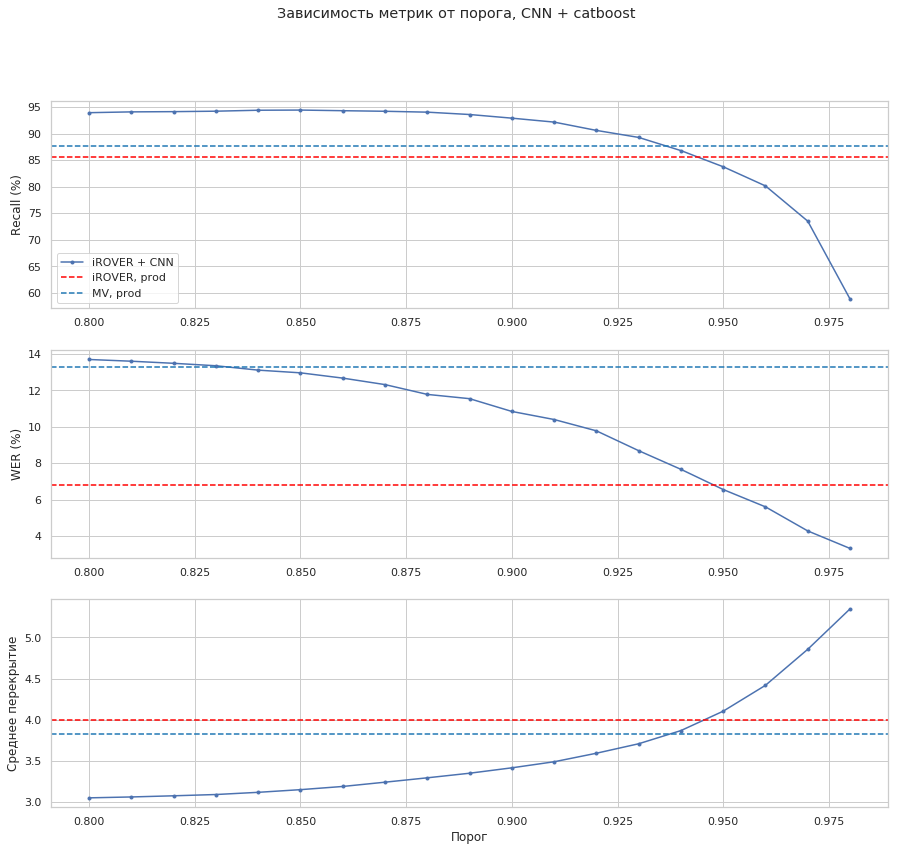

In [136]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, CNN + catboost')
plt.subplot(311)
plt.plot(scores_clf_test[:, 0], 
         scores_clf_test[:, 1] * 100, 
         ".-", 
         label="iROVER + CNN")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test[:, 0], 
         scores_clf_test[:, 2] * 100, 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test[:, 0], 
         scores_clf_test[:, 3], 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("cnn_and_catboost.png")
plt.show()

In [134]:
preaggregated = preaggregate_with_clf(test_features, cnn_preds, clf_q)

In [137]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = sum(score for value, score in item1) / len(item1)
            tokens = [value for value, score_ in item1 if value != ""]
            if score < treshhold:
                tokens = []
                prev_question = False
                for value, score_ in item1:
                    if score_ > threshold_by_word and value != "" and value != "?":
                        tokens.append(value)
                        prev_question = False
                    elif not prev_question and value != "":
                        tokens.append("?")
                        changed_signs_in_aggregated += 1
                        prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [139]:
from collections import defaultdict

In [140]:
scores_clf_score_by_word_q_mean_v3 = defaultdict(list)

for threshhold in [0.948]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.9, 1, 21):
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))
        scores_clf_score_by_word_q_mean_v3[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v3[threshhold] = np.array(scores_clf_score_by_word_q_mean_v3[threshhold])


0.948
0.9
Recall: 87.1429%
WER: 7.3058%
Mean overlap: 4.062
0.905
Recall: 87.0935%
WER: 7.2373%
Mean overlap: 4.062
0.91
Recall: 87.0052%
WER: 7.2146%
Mean overlap: 4.062
0.915
Recall: 86.9379%
WER: 7.1622%
Mean overlap: 4.062
0.92
Recall: 86.8324%
WER: 7.0857%
Mean overlap: 4.062
0.925
Recall: 86.7396%
WER: 7.0810%
Mean overlap: 4.062
0.93
Recall: 86.6628%
WER: 7.0493%
Mean overlap: 4.062
0.935
Recall: 86.5339%
WER: 7.0024%
Mean overlap: 4.062
0.9400000000000001
Recall: 86.4608%
WER: 6.9675%
Mean overlap: 4.062
0.9450000000000001
Recall: 86.3553%
WER: 6.9745%
Mean overlap: 4.062
0.95
Recall: 86.2337%
WER: 6.9560%
Mean overlap: 4.062
0.9550000000000001
Recall: 86.0530%
WER: 6.8808%
Mean overlap: 4.062
0.96
Recall: 85.9198%
WER: 6.8517%
Mean overlap: 4.062
0.965
Recall: 85.7696%
WER: 6.7984%
Mean overlap: 4.062
0.97
Recall: 85.5367%
WER: 6.7766%
Mean overlap: 4.062
0.975
Recall: 85.2838%
WER: 6.7390%
Mean overlap: 4.062
0.98
Recall: 84.9901%
WER: 6.7543%
Mean overlap: 4.062
0.985
Recal

In [142]:
with open('../pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated_prod = pickle.load(f)
len(preaggregated_prod)

3486

In [143]:
scores_clf_score_by_word_old_clf = defaultdict(list)

for threshhold in [0.948]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.9, 1, 21):
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated_prod))
        scores_clf_score_by_word_old_clf[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_old_clf[threshhold] = np.array(scores_clf_score_by_word_old_clf[threshhold])


0.948
0.9
Recall: 87.9992%
WER: 7.3372%
Mean overlap: 4.001
0.905
Recall: 87.9378%
WER: 7.2768%
Mean overlap: 4.001
0.91
Recall: 87.8465%
WER: 7.2531%
Mean overlap: 4.001
0.915
Recall: 87.7581%
WER: 7.2078%
Mean overlap: 4.001
0.92
Recall: 87.7222%
WER: 7.1708%
Mean overlap: 4.001
0.925
Recall: 87.6765%
WER: 7.1331%
Mean overlap: 4.001
0.93
Recall: 87.6242%
WER: 7.0919%
Mean overlap: 4.001
0.935
Recall: 87.5684%
WER: 7.0718%
Mean overlap: 4.001
0.9400000000000001
Recall: 87.5082%
WER: 7.0222%
Mean overlap: 4.001
0.9450000000000001
Recall: 87.3737%
WER: 6.9964%
Mean overlap: 4.001
0.95
Recall: 87.2777%
WER: 6.9777%
Mean overlap: 4.001
0.9550000000000001
Recall: 87.1761%
WER: 6.9273%
Mean overlap: 4.001
0.96
Recall: 87.0435%
WER: 6.8724%
Mean overlap: 4.001
0.965
Recall: 86.8786%
WER: 6.8089%
Mean overlap: 4.001
0.97
Recall: 86.7560%
WER: 6.7876%
Mean overlap: 4.001
0.975
Recall: 86.5863%
WER: 6.7662%
Mean overlap: 4.001
0.98
Recall: 86.4237%
WER: 6.7773%
Mean overlap: 4.001
0.985
Recal

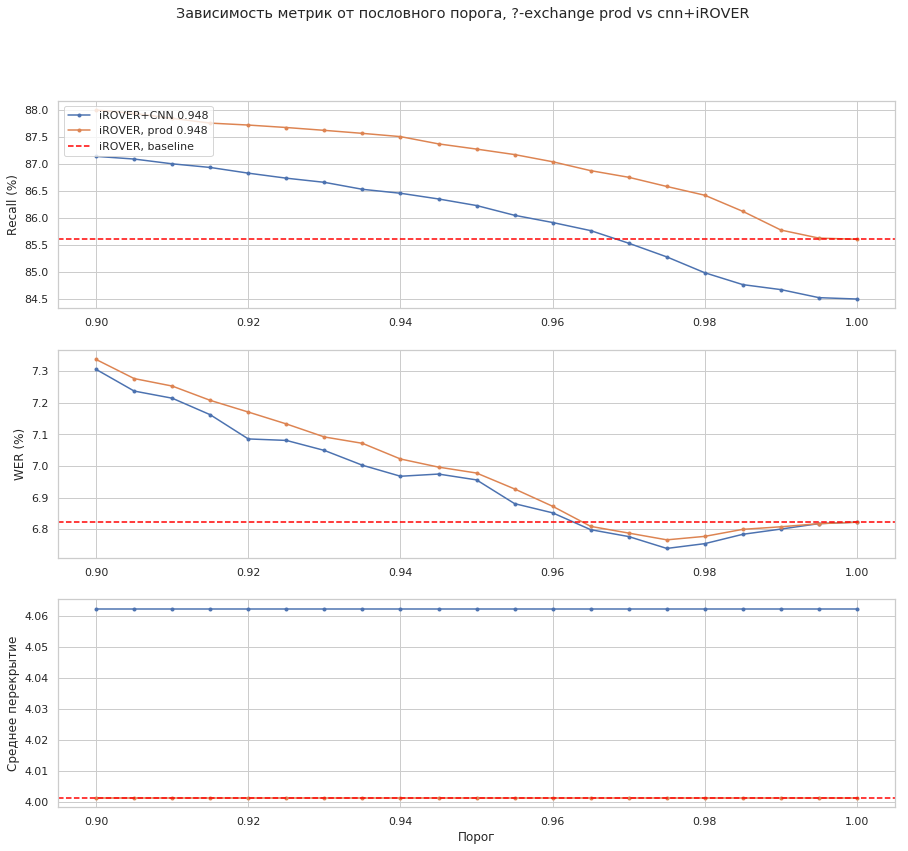

In [146]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange prod vs cnn+iROVER')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER+CNN {:.3f}'.format(key))
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER, prod {:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, baseline")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.show()

In [148]:
from sklearn.model_selection import GridSearchCV

In [149]:
clf = CatBoostClassifier(thread_count=15, random_seed=42)
params = {"iterations": [20000, 23500, 27000], "depth": [6, 8]}
gs = GridSearchCV(clf, params, 'roc_auc', cv=5, refit=True, n_jobs=2)

In [150]:
gs.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("model is fitted\n")

Learning rate set to 0.00493
0:	learn: 0.6857966	total: 153ms	remaining: 1h 8m 43s
1:	learn: 0.6789782	total: 295ms	remaining: 1h 6m 21s
2:	learn: 0.6723167	total: 436ms	remaining: 1h 5m 19s
3:	learn: 0.6656206	total: 575ms	remaining: 1h 4m 37s
4:	learn: 0.6591770	total: 713ms	remaining: 1h 4m 7s
5:	learn: 0.6525454	total: 853ms	remaining: 1h 3m 59s
6:	learn: 0.6454819	total: 994ms	remaining: 1h 3m 53s
7:	learn: 0.6391177	total: 1.14s	remaining: 1h 3m 52s
8:	learn: 0.6330125	total: 1.28s	remaining: 1h 3m 53s
9:	learn: 0.6269666	total: 1.42s	remaining: 1h 3m 56s
10:	learn: 0.6208413	total: 1.56s	remaining: 1h 3m 49s
11:	learn: 0.6150124	total: 1.71s	remaining: 1h 3m 58s
12:	learn: 0.6092814	total: 1.85s	remaining: 1h 4m 9s
13:	learn: 0.6034053	total: 1.99s	remaining: 1h 3m 56s
14:	learn: 0.5976418	total: 2.13s	remaining: 1h 3m 45s
15:	learn: 0.5919853	total: 2.28s	remaining: 1h 4m 1s
16:	learn: 0.5865145	total: 2.42s	remaining: 1h 3m 53s
17:	learn: 0.5811039	total: 2.55s	remaining: 1h 3

151:	learn: 0.2608374	total: 21.9s	remaining: 1h 4m 23s
152:	learn: 0.2600423	total: 22s	remaining: 1h 4m 24s
153:	learn: 0.2593021	total: 22.2s	remaining: 1h 4m 26s
154:	learn: 0.2585020	total: 22.3s	remaining: 1h 4m 28s
155:	learn: 0.2577237	total: 22.5s	remaining: 1h 4m 28s
156:	learn: 0.2569548	total: 22.6s	remaining: 1h 4m 28s
157:	learn: 0.2562196	total: 22.8s	remaining: 1h 4m 27s
158:	learn: 0.2554672	total: 22.9s	remaining: 1h 4m 28s
159:	learn: 0.2546313	total: 23.1s	remaining: 1h 4m 27s
160:	learn: 0.2539532	total: 23.2s	remaining: 1h 4m 27s
161:	learn: 0.2532573	total: 23.3s	remaining: 1h 4m 26s
162:	learn: 0.2525902	total: 23.5s	remaining: 1h 4m 26s
163:	learn: 0.2519748	total: 23.6s	remaining: 1h 4m 28s
164:	learn: 0.2513392	total: 23.8s	remaining: 1h 4m 27s
165:	learn: 0.2507014	total: 23.9s	remaining: 1h 4m 25s
166:	learn: 0.2500435	total: 24.1s	remaining: 1h 4m 27s
167:	learn: 0.2493945	total: 24.2s	remaining: 1h 4m 26s
168:	learn: 0.2488060	total: 24.3s	remaining: 1h 4

299:	learn: 0.2032819	total: 43.3s	remaining: 1h 4m 15s
300:	learn: 0.2030946	total: 43.5s	remaining: 1h 4m 15s
301:	learn: 0.2029384	total: 43.6s	remaining: 1h 4m 15s
302:	learn: 0.2027891	total: 43.7s	remaining: 1h 4m 14s
303:	learn: 0.2026517	total: 43.9s	remaining: 1h 4m 13s
304:	learn: 0.2024586	total: 44s	remaining: 1h 4m 13s
305:	learn: 0.2023070	total: 44.2s	remaining: 1h 4m 13s
306:	learn: 0.2021724	total: 44.3s	remaining: 1h 4m 13s
307:	learn: 0.2020148	total: 44.5s	remaining: 1h 4m 13s
308:	learn: 0.2018859	total: 44.6s	remaining: 1h 4m 12s
309:	learn: 0.2017214	total: 44.8s	remaining: 1h 4m 13s
310:	learn: 0.2015818	total: 44.9s	remaining: 1h 4m 13s
311:	learn: 0.2014236	total: 45s	remaining: 1h 4m 13s
312:	learn: 0.2012836	total: 45.2s	remaining: 1h 4m 12s
313:	learn: 0.2011526	total: 45.3s	remaining: 1h 4m 11s
314:	learn: 0.2010147	total: 45.4s	remaining: 1h 4m 9s
315:	learn: 0.2008919	total: 45.6s	remaining: 1h 4m 8s
316:	learn: 0.2007410	total: 45.7s	remaining: 1h 4m 9s

449:	learn: 0.1880843	total: 1m 4s	remaining: 1h 3m 51s
450:	learn: 0.1880288	total: 1m 5s	remaining: 1h 3m 52s
451:	learn: 0.1879539	total: 1m 5s	remaining: 1h 3m 52s
452:	learn: 0.1879124	total: 1m 5s	remaining: 1h 3m 50s
453:	learn: 0.1878528	total: 1m 5s	remaining: 1h 3m 51s
454:	learn: 0.1877819	total: 1m 5s	remaining: 1h 3m 51s
455:	learn: 0.1877344	total: 1m 5s	remaining: 1h 3m 51s
456:	learn: 0.1876816	total: 1m 5s	remaining: 1h 3m 50s
457:	learn: 0.1876386	total: 1m 6s	remaining: 1h 3m 50s
458:	learn: 0.1875591	total: 1m 6s	remaining: 1h 3m 49s
459:	learn: 0.1875012	total: 1m 6s	remaining: 1h 3m 50s
460:	learn: 0.1874457	total: 1m 6s	remaining: 1h 3m 50s
461:	learn: 0.1873865	total: 1m 6s	remaining: 1h 3m 50s
462:	learn: 0.1873508	total: 1m 6s	remaining: 1h 3m 48s
463:	learn: 0.1872638	total: 1m 6s	remaining: 1h 3m 49s
464:	learn: 0.1872088	total: 1m 7s	remaining: 1h 3m 50s
465:	learn: 0.1871494	total: 1m 7s	remaining: 1h 3m 50s
466:	learn: 0.1870953	total: 1m 7s	remaining: 1h

595:	learn: 0.1817493	total: 1m 26s	remaining: 1h 3m 41s
596:	learn: 0.1817068	total: 1m 26s	remaining: 1h 3m 41s
597:	learn: 0.1816737	total: 1m 26s	remaining: 1h 3m 40s
598:	learn: 0.1816450	total: 1m 26s	remaining: 1h 3m 40s
599:	learn: 0.1816131	total: 1m 26s	remaining: 1h 3m 41s
600:	learn: 0.1815742	total: 1m 26s	remaining: 1h 3m 40s
601:	learn: 0.1815411	total: 1m 27s	remaining: 1h 3m 41s
602:	learn: 0.1815020	total: 1m 27s	remaining: 1h 3m 41s
603:	learn: 0.1814788	total: 1m 27s	remaining: 1h 3m 41s
604:	learn: 0.1814530	total: 1m 27s	remaining: 1h 3m 41s
605:	learn: 0.1814298	total: 1m 27s	remaining: 1h 3m 42s
606:	learn: 0.1813967	total: 1m 27s	remaining: 1h 3m 42s
607:	learn: 0.1813766	total: 1m 28s	remaining: 1h 3m 41s
608:	learn: 0.1813468	total: 1m 28s	remaining: 1h 3m 41s
609:	learn: 0.1813081	total: 1m 28s	remaining: 1h 3m 42s
610:	learn: 0.1812660	total: 1m 28s	remaining: 1h 3m 41s
611:	learn: 0.1812221	total: 1m 28s	remaining: 1h 3m 42s
612:	learn: 0.1811924	total: 1m

739:	learn: 0.1781873	total: 1m 47s	remaining: 1h 3m 24s
740:	learn: 0.1781617	total: 1m 47s	remaining: 1h 3m 23s
741:	learn: 0.1781389	total: 1m 47s	remaining: 1h 3m 23s
742:	learn: 0.1781166	total: 1m 47s	remaining: 1h 3m 23s
743:	learn: 0.1780870	total: 1m 47s	remaining: 1h 3m 24s
744:	learn: 0.1780710	total: 1m 47s	remaining: 1h 3m 25s
745:	learn: 0.1780523	total: 1m 48s	remaining: 1h 3m 24s
746:	learn: 0.1780301	total: 1m 48s	remaining: 1h 3m 24s
747:	learn: 0.1780147	total: 1m 48s	remaining: 1h 3m 23s
748:	learn: 0.1779903	total: 1m 48s	remaining: 1h 3m 24s
749:	learn: 0.1779656	total: 1m 48s	remaining: 1h 3m 24s
750:	learn: 0.1779466	total: 1m 48s	remaining: 1h 3m 24s
751:	learn: 0.1779352	total: 1m 48s	remaining: 1h 3m 24s
752:	learn: 0.1779174	total: 1m 49s	remaining: 1h 3m 23s
753:	learn: 0.1779009	total: 1m 49s	remaining: 1h 3m 23s
754:	learn: 0.1778819	total: 1m 49s	remaining: 1h 3m 23s
755:	learn: 0.1778650	total: 1m 49s	remaining: 1h 3m 22s
756:	learn: 0.1778420	total: 1m

885:	learn: 0.1755882	total: 2m 8s	remaining: 1h 3m 4s
886:	learn: 0.1755747	total: 2m 8s	remaining: 1h 3m 4s
887:	learn: 0.1755630	total: 2m 8s	remaining: 1h 3m 3s
888:	learn: 0.1755408	total: 2m 8s	remaining: 1h 3m 3s
889:	learn: 0.1755269	total: 2m 8s	remaining: 1h 3m 3s
890:	learn: 0.1755121	total: 2m 9s	remaining: 1h 3m 3s
891:	learn: 0.1754944	total: 2m 9s	remaining: 1h 3m 3s
892:	learn: 0.1754817	total: 2m 9s	remaining: 1h 3m 3s
893:	learn: 0.1754652	total: 2m 9s	remaining: 1h 3m 3s
894:	learn: 0.1754575	total: 2m 9s	remaining: 1h 3m 2s
895:	learn: 0.1754430	total: 2m 9s	remaining: 1h 3m 2s
896:	learn: 0.1754303	total: 2m 9s	remaining: 1h 3m 2s
897:	learn: 0.1754154	total: 2m 10s	remaining: 1h 3m 2s
898:	learn: 0.1754017	total: 2m 10s	remaining: 1h 3m 2s
899:	learn: 0.1753929	total: 2m 10s	remaining: 1h 3m 1s
900:	learn: 0.1753831	total: 2m 10s	remaining: 1h 3m 1s
901:	learn: 0.1753657	total: 2m 10s	remaining: 1h 3m
902:	learn: 0.1753518	total: 2m 10s	remaining: 1h 3m
903:	learn

1029:	learn: 0.1736390	total: 2m 29s	remaining: 1h 2m 38s
1030:	learn: 0.1736306	total: 2m 29s	remaining: 1h 2m 38s
1031:	learn: 0.1736133	total: 2m 29s	remaining: 1h 2m 37s
1032:	learn: 0.1736049	total: 2m 29s	remaining: 1h 2m 37s
1033:	learn: 0.1735925	total: 2m 29s	remaining: 1h 2m 36s
1034:	learn: 0.1735805	total: 2m 29s	remaining: 1h 2m 36s
1035:	learn: 0.1735734	total: 2m 29s	remaining: 1h 2m 36s
1036:	learn: 0.1735607	total: 2m 30s	remaining: 1h 2m 35s
1037:	learn: 0.1735473	total: 2m 30s	remaining: 1h 2m 35s
1038:	learn: 0.1735367	total: 2m 30s	remaining: 1h 2m 35s
1039:	learn: 0.1735220	total: 2m 30s	remaining: 1h 2m 35s
1040:	learn: 0.1735116	total: 2m 30s	remaining: 1h 2m 35s
1041:	learn: 0.1734996	total: 2m 30s	remaining: 1h 2m 34s
1042:	learn: 0.1734911	total: 2m 30s	remaining: 1h 2m 34s
1043:	learn: 0.1734836	total: 2m 31s	remaining: 1h 2m 34s
1044:	learn: 0.1734660	total: 2m 31s	remaining: 1h 2m 33s
1045:	learn: 0.1734516	total: 2m 31s	remaining: 1h 2m 34s
1046:	learn: 0

1171:	learn: 0.1721164	total: 2m 48s	remaining: 1h 2m 3s
1172:	learn: 0.1721098	total: 2m 49s	remaining: 1h 2m 3s
1173:	learn: 0.1720886	total: 2m 49s	remaining: 1h 2m 3s
1174:	learn: 0.1720804	total: 2m 49s	remaining: 1h 2m 3s
1175:	learn: 0.1720752	total: 2m 49s	remaining: 1h 2m 2s
1176:	learn: 0.1720643	total: 2m 49s	remaining: 1h 2m 2s
1177:	learn: 0.1720529	total: 2m 49s	remaining: 1h 2m 2s
1178:	learn: 0.1720366	total: 2m 49s	remaining: 1h 2m 2s
1179:	learn: 0.1720238	total: 2m 50s	remaining: 1h 2m 2s
1180:	learn: 0.1720177	total: 2m 50s	remaining: 1h 2m 1s
1181:	learn: 0.1720082	total: 2m 50s	remaining: 1h 2m 1s
1182:	learn: 0.1719971	total: 2m 50s	remaining: 1h 2m 1s
1183:	learn: 0.1719771	total: 2m 50s	remaining: 1h 2m 1s
1184:	learn: 0.1719717	total: 2m 50s	remaining: 1h 2m
1185:	learn: 0.1719582	total: 2m 50s	remaining: 1h 2m
1186:	learn: 0.1719522	total: 2m 51s	remaining: 1h 1m 59s
1187:	learn: 0.1719455	total: 2m 51s	remaining: 1h 1m 59s
1188:	learn: 0.1719368	total: 2m 51

1315:	learn: 0.1707552	total: 3m 9s	remaining: 1h 1m 35s
1316:	learn: 0.1707476	total: 3m 9s	remaining: 1h 1m 35s
1317:	learn: 0.1707435	total: 3m 9s	remaining: 1h 1m 34s
1318:	learn: 0.1707362	total: 3m 9s	remaining: 1h 1m 34s
1319:	learn: 0.1707257	total: 3m 9s	remaining: 1h 1m 34s
1320:	learn: 0.1707217	total: 3m 10s	remaining: 1h 1m 34s
1321:	learn: 0.1707145	total: 3m 10s	remaining: 1h 1m 34s
1322:	learn: 0.1707081	total: 3m 10s	remaining: 1h 1m 34s
1323:	learn: 0.1707017	total: 3m 10s	remaining: 1h 1m 33s
1324:	learn: 0.1706850	total: 3m 10s	remaining: 1h 1m 33s
1325:	learn: 0.1706758	total: 3m 10s	remaining: 1h 1m 33s
1326:	learn: 0.1706658	total: 3m 10s	remaining: 1h 1m 33s
1327:	learn: 0.1706595	total: 3m 11s	remaining: 1h 1m 33s
1328:	learn: 0.1706471	total: 3m 11s	remaining: 1h 1m 33s
1329:	learn: 0.1706373	total: 3m 11s	remaining: 1h 1m 33s
1330:	learn: 0.1706319	total: 3m 11s	remaining: 1h 1m 32s
1331:	learn: 0.1706225	total: 3m 11s	remaining: 1h 1m 32s
1332:	learn: 0.1706

1457:	learn: 0.1695659	total: 3m 29s	remaining: 1h 1m 7s
1458:	learn: 0.1695587	total: 3m 29s	remaining: 1h 1m 7s
1459:	learn: 0.1695518	total: 3m 29s	remaining: 1h 1m 6s
1460:	learn: 0.1695452	total: 3m 29s	remaining: 1h 1m 6s
1461:	learn: 0.1695354	total: 3m 29s	remaining: 1h 1m 6s
1462:	learn: 0.1695320	total: 3m 30s	remaining: 1h 1m 5s
1463:	learn: 0.1695231	total: 3m 30s	remaining: 1h 1m 5s
1464:	learn: 0.1695149	total: 3m 30s	remaining: 1h 1m 5s
1465:	learn: 0.1695088	total: 3m 30s	remaining: 1h 1m 5s
1466:	learn: 0.1695021	total: 3m 30s	remaining: 1h 1m 5s
1467:	learn: 0.1694949	total: 3m 30s	remaining: 1h 1m 4s
1468:	learn: 0.1694869	total: 3m 30s	remaining: 1h 1m 4s
1469:	learn: 0.1694753	total: 3m 31s	remaining: 1h 1m 4s
1470:	learn: 0.1694639	total: 3m 31s	remaining: 1h 1m 4s
1471:	learn: 0.1694567	total: 3m 31s	remaining: 1h 1m 4s
1472:	learn: 0.1694502	total: 3m 31s	remaining: 1h 1m 4s
1473:	learn: 0.1694442	total: 3m 31s	remaining: 1h 1m 4s
1474:	learn: 0.1694367	total: 3

1605:	learn: 0.1685573	total: 3m 49s	remaining: 1h 28s
1606:	learn: 0.1685512	total: 3m 49s	remaining: 1h 28s
1607:	learn: 0.1685467	total: 3m 49s	remaining: 1h 27s
1608:	learn: 0.1685391	total: 3m 49s	remaining: 1h 27s
1609:	learn: 0.1685314	total: 3m 50s	remaining: 1h 27s
1610:	learn: 0.1685142	total: 3m 50s	remaining: 1h 27s
1611:	learn: 0.1685081	total: 3m 50s	remaining: 1h 27s
1612:	learn: 0.1684992	total: 3m 50s	remaining: 1h 27s
1613:	learn: 0.1684923	total: 3m 50s	remaining: 1h 27s
1614:	learn: 0.1684848	total: 3m 50s	remaining: 1h 26s
1615:	learn: 0.1684762	total: 3m 50s	remaining: 1h 26s
1616:	learn: 0.1684691	total: 3m 51s	remaining: 1h 26s
1617:	learn: 0.1684621	total: 3m 51s	remaining: 1h 26s
1618:	learn: 0.1684544	total: 3m 51s	remaining: 1h 26s
1619:	learn: 0.1684489	total: 3m 51s	remaining: 1h 25s
1620:	learn: 0.1684446	total: 3m 51s	remaining: 1h 25s
1621:	learn: 0.1684350	total: 3m 51s	remaining: 1h 25s
1622:	learn: 0.1684284	total: 3m 51s	remaining: 1h 25s
1623:	lear

1757:	learn: 0.1675664	total: 4m 10s	remaining: 59m 58s
1758:	learn: 0.1675582	total: 4m 10s	remaining: 59m 57s
1759:	learn: 0.1675544	total: 4m 10s	remaining: 59m 57s
1760:	learn: 0.1675514	total: 4m 10s	remaining: 59m 57s
1761:	learn: 0.1675412	total: 4m 11s	remaining: 59m 57s
1762:	learn: 0.1675361	total: 4m 11s	remaining: 59m 57s
1763:	learn: 0.1675251	total: 4m 11s	remaining: 59m 56s
1764:	learn: 0.1675210	total: 4m 11s	remaining: 59m 56s
1765:	learn: 0.1675163	total: 4m 11s	remaining: 59m 56s
1766:	learn: 0.1675126	total: 4m 11s	remaining: 59m 56s
1767:	learn: 0.1675054	total: 4m 11s	remaining: 59m 55s
1768:	learn: 0.1674967	total: 4m 12s	remaining: 59m 55s
1769:	learn: 0.1674912	total: 4m 12s	remaining: 59m 55s
1770:	learn: 0.1674776	total: 4m 12s	remaining: 59m 55s
1771:	learn: 0.1674702	total: 4m 12s	remaining: 59m 55s
1772:	learn: 0.1674653	total: 4m 12s	remaining: 59m 54s
1773:	learn: 0.1674603	total: 4m 12s	remaining: 59m 54s
1774:	learn: 0.1674515	total: 4m 12s	remaining: 

1905:	learn: 0.1666804	total: 4m 30s	remaining: 59m 27s
1906:	learn: 0.1666754	total: 4m 31s	remaining: 59m 27s
1907:	learn: 0.1666724	total: 4m 31s	remaining: 59m 26s
1908:	learn: 0.1666664	total: 4m 31s	remaining: 59m 26s
1909:	learn: 0.1666624	total: 4m 31s	remaining: 59m 26s
1910:	learn: 0.1666540	total: 4m 31s	remaining: 59m 26s
1911:	learn: 0.1666490	total: 4m 31s	remaining: 59m 26s
1912:	learn: 0.1666456	total: 4m 31s	remaining: 59m 25s
1913:	learn: 0.1666368	total: 4m 32s	remaining: 59m 25s
1914:	learn: 0.1666292	total: 4m 32s	remaining: 59m 25s
1915:	learn: 0.1666242	total: 4m 32s	remaining: 59m 25s
1916:	learn: 0.1666168	total: 4m 32s	remaining: 59m 25s
1917:	learn: 0.1666107	total: 4m 32s	remaining: 59m 25s
1918:	learn: 0.1666062	total: 4m 32s	remaining: 59m 24s
1919:	learn: 0.1665970	total: 4m 32s	remaining: 59m 25s
1920:	learn: 0.1665907	total: 4m 33s	remaining: 59m 25s
1921:	learn: 0.1665846	total: 4m 33s	remaining: 59m 24s
1922:	learn: 0.1665815	total: 4m 33s	remaining: 

2053:	learn: 0.1658506	total: 4m 51s	remaining: 58m 59s
2054:	learn: 0.1658430	total: 4m 51s	remaining: 58m 59s
2055:	learn: 0.1658401	total: 4m 51s	remaining: 58m 58s
2056:	learn: 0.1658339	total: 4m 51s	remaining: 58m 58s
2057:	learn: 0.1658307	total: 4m 51s	remaining: 58m 58s
2058:	learn: 0.1658220	total: 4m 52s	remaining: 58m 58s
2059:	learn: 0.1658132	total: 4m 52s	remaining: 58m 58s
2060:	learn: 0.1658064	total: 4m 52s	remaining: 58m 58s
2061:	learn: 0.1658030	total: 4m 52s	remaining: 58m 58s
2062:	learn: 0.1657982	total: 4m 52s	remaining: 58m 57s
2063:	learn: 0.1657895	total: 4m 52s	remaining: 58m 57s
2064:	learn: 0.1657847	total: 4m 52s	remaining: 58m 57s
2065:	learn: 0.1657824	total: 4m 53s	remaining: 58m 57s
2066:	learn: 0.1657762	total: 4m 53s	remaining: 58m 57s
2067:	learn: 0.1657714	total: 4m 53s	remaining: 58m 57s
2068:	learn: 0.1657655	total: 4m 53s	remaining: 58m 56s
2069:	learn: 0.1657602	total: 4m 53s	remaining: 58m 56s
2070:	learn: 0.1657538	total: 4m 53s	remaining: 

2201:	learn: 0.1650554	total: 5m 11s	remaining: 58m 29s
2202:	learn: 0.1650516	total: 5m 11s	remaining: 58m 29s
2203:	learn: 0.1650457	total: 5m 11s	remaining: 58m 29s
2204:	learn: 0.1650397	total: 5m 12s	remaining: 58m 29s
2205:	learn: 0.1650347	total: 5m 12s	remaining: 58m 28s
2206:	learn: 0.1650297	total: 5m 12s	remaining: 58m 28s
2207:	learn: 0.1650265	total: 5m 12s	remaining: 58m 28s
2208:	learn: 0.1650206	total: 5m 12s	remaining: 58m 27s
2209:	learn: 0.1650145	total: 5m 12s	remaining: 58m 27s
2210:	learn: 0.1650085	total: 5m 12s	remaining: 58m 27s
2211:	learn: 0.1650014	total: 5m 13s	remaining: 58m 27s
2212:	learn: 0.1649991	total: 5m 13s	remaining: 58m 27s
2213:	learn: 0.1649949	total: 5m 13s	remaining: 58m 26s
2214:	learn: 0.1649903	total: 5m 13s	remaining: 58m 26s
2215:	learn: 0.1649854	total: 5m 13s	remaining: 58m 26s
2216:	learn: 0.1649778	total: 5m 13s	remaining: 58m 26s
2217:	learn: 0.1649746	total: 5m 13s	remaining: 58m 26s
2218:	learn: 0.1649698	total: 5m 13s	remaining: 

2349:	learn: 0.1643112	total: 5m 31s	remaining: 57m 59s
2350:	learn: 0.1643059	total: 5m 31s	remaining: 57m 59s
2351:	learn: 0.1643024	total: 5m 32s	remaining: 57m 59s
2352:	learn: 0.1642976	total: 5m 32s	remaining: 57m 59s
2353:	learn: 0.1642931	total: 5m 32s	remaining: 57m 58s
2354:	learn: 0.1642899	total: 5m 32s	remaining: 57m 58s
2355:	learn: 0.1642830	total: 5m 32s	remaining: 57m 58s
2356:	learn: 0.1642797	total: 5m 32s	remaining: 57m 58s
2357:	learn: 0.1642779	total: 5m 32s	remaining: 57m 58s
2358:	learn: 0.1642726	total: 5m 32s	remaining: 57m 57s
2359:	learn: 0.1642694	total: 5m 33s	remaining: 57m 57s
2360:	learn: 0.1642615	total: 5m 33s	remaining: 57m 57s
2361:	learn: 0.1642564	total: 5m 33s	remaining: 57m 56s
2362:	learn: 0.1642515	total: 5m 33s	remaining: 57m 56s
2363:	learn: 0.1642472	total: 5m 33s	remaining: 57m 56s
2364:	learn: 0.1642402	total: 5m 33s	remaining: 57m 56s
2365:	learn: 0.1642348	total: 5m 33s	remaining: 57m 56s
2366:	learn: 0.1642319	total: 5m 34s	remaining: 

2497:	learn: 0.1635269	total: 5m 51s	remaining: 57m 31s
2498:	learn: 0.1635211	total: 5m 52s	remaining: 57m 31s
2499:	learn: 0.1635140	total: 5m 52s	remaining: 57m 31s
2500:	learn: 0.1635071	total: 5m 52s	remaining: 57m 31s
2501:	learn: 0.1635012	total: 5m 52s	remaining: 57m 31s
2502:	learn: 0.1634958	total: 5m 52s	remaining: 57m 31s
2503:	learn: 0.1634893	total: 5m 52s	remaining: 57m 30s
2504:	learn: 0.1634849	total: 5m 52s	remaining: 57m 30s
2505:	learn: 0.1634773	total: 5m 53s	remaining: 57m 30s
2506:	learn: 0.1634756	total: 5m 53s	remaining: 57m 30s
2507:	learn: 0.1634707	total: 5m 53s	remaining: 57m 30s
2508:	learn: 0.1634675	total: 5m 53s	remaining: 57m 29s
2509:	learn: 0.1634656	total: 5m 53s	remaining: 57m 29s
2510:	learn: 0.1634618	total: 5m 53s	remaining: 57m 29s
2511:	learn: 0.1634559	total: 5m 53s	remaining: 57m 29s
2512:	learn: 0.1634499	total: 5m 53s	remaining: 57m 28s
2513:	learn: 0.1634445	total: 5m 54s	remaining: 57m 28s
2514:	learn: 0.1634381	total: 5m 54s	remaining: 

2647:	learn: 0.1627607	total: 6m 12s	remaining: 57m 3s
2648:	learn: 0.1627546	total: 6m 12s	remaining: 57m 3s
2649:	learn: 0.1627511	total: 6m 12s	remaining: 57m 3s
2650:	learn: 0.1627481	total: 6m 12s	remaining: 57m 3s
2651:	learn: 0.1627415	total: 6m 12s	remaining: 57m 3s
2652:	learn: 0.1627377	total: 6m 12s	remaining: 57m 2s
2653:	learn: 0.1627297	total: 6m 13s	remaining: 57m 2s
2654:	learn: 0.1627187	total: 6m 13s	remaining: 57m 2s
2655:	learn: 0.1627151	total: 6m 13s	remaining: 57m 2s
2656:	learn: 0.1627082	total: 6m 13s	remaining: 57m 2s
2657:	learn: 0.1627020	total: 6m 13s	remaining: 57m 2s
2658:	learn: 0.1626979	total: 6m 13s	remaining: 57m 2s
2659:	learn: 0.1626898	total: 6m 13s	remaining: 57m 2s
2660:	learn: 0.1626836	total: 6m 14s	remaining: 57m 1s
2661:	learn: 0.1626767	total: 6m 14s	remaining: 57m 1s
2662:	learn: 0.1626724	total: 6m 14s	remaining: 57m 1s
2663:	learn: 0.1626648	total: 6m 14s	remaining: 57m 1s
2664:	learn: 0.1626621	total: 6m 14s	remaining: 57m 1s
2665:	lear

2795:	learn: 0.1620023	total: 6m 32s	remaining: 56m 38s
2796:	learn: 0.1619964	total: 6m 32s	remaining: 56m 38s
2797:	learn: 0.1619904	total: 6m 32s	remaining: 56m 38s
2798:	learn: 0.1619850	total: 6m 33s	remaining: 56m 38s
2799:	learn: 0.1619815	total: 6m 33s	remaining: 56m 38s
2800:	learn: 0.1619751	total: 6m 33s	remaining: 56m 38s
2801:	learn: 0.1619698	total: 6m 33s	remaining: 56m 38s
2802:	learn: 0.1619627	total: 6m 33s	remaining: 56m 38s
2803:	learn: 0.1619518	total: 6m 33s	remaining: 56m 37s
2804:	learn: 0.1619470	total: 6m 33s	remaining: 56m 37s
2805:	learn: 0.1619427	total: 6m 34s	remaining: 56m 37s
2806:	learn: 0.1619382	total: 6m 34s	remaining: 56m 37s
2807:	learn: 0.1619349	total: 6m 34s	remaining: 56m 36s
2808:	learn: 0.1619251	total: 6m 34s	remaining: 56m 36s
2809:	learn: 0.1619207	total: 6m 34s	remaining: 56m 36s
2810:	learn: 0.1619158	total: 6m 34s	remaining: 56m 36s
2811:	learn: 0.1619127	total: 6m 34s	remaining: 56m 36s
2812:	learn: 0.1619085	total: 6m 34s	remaining: 

2943:	learn: 0.1612783	total: 6m 52s	remaining: 56m 11s
2944:	learn: 0.1612727	total: 6m 52s	remaining: 56m 11s
2945:	learn: 0.1612703	total: 6m 52s	remaining: 56m 11s
2946:	learn: 0.1612671	total: 6m 53s	remaining: 56m 11s
2947:	learn: 0.1612609	total: 6m 53s	remaining: 56m 11s
2948:	learn: 0.1612505	total: 6m 53s	remaining: 56m 11s
2949:	learn: 0.1612463	total: 6m 53s	remaining: 56m 10s
2950:	learn: 0.1612382	total: 6m 53s	remaining: 56m 10s
2951:	learn: 0.1612333	total: 6m 53s	remaining: 56m 10s
2952:	learn: 0.1612299	total: 6m 53s	remaining: 56m 10s
2953:	learn: 0.1612248	total: 6m 54s	remaining: 56m 10s
2954:	learn: 0.1612178	total: 6m 54s	remaining: 56m 10s
2955:	learn: 0.1612106	total: 6m 54s	remaining: 56m 10s
2956:	learn: 0.1612076	total: 6m 54s	remaining: 56m 9s
2957:	learn: 0.1612001	total: 6m 54s	remaining: 56m 9s
2958:	learn: 0.1611945	total: 6m 54s	remaining: 56m 9s
2959:	learn: 0.1611883	total: 6m 54s	remaining: 56m 9s
2960:	learn: 0.1611791	total: 6m 55s	remaining: 56m 

3093:	learn: 0.1605507	total: 7m 12s	remaining: 55m 44s
3094:	learn: 0.1605452	total: 7m 13s	remaining: 55m 44s
3095:	learn: 0.1605384	total: 7m 13s	remaining: 55m 44s
3096:	learn: 0.1605342	total: 7m 13s	remaining: 55m 44s
3097:	learn: 0.1605305	total: 7m 13s	remaining: 55m 44s
3098:	learn: 0.1605232	total: 7m 13s	remaining: 55m 44s
3099:	learn: 0.1605182	total: 7m 13s	remaining: 55m 43s
3100:	learn: 0.1605133	total: 7m 13s	remaining: 55m 43s
3101:	learn: 0.1605104	total: 7m 14s	remaining: 55m 43s
3102:	learn: 0.1605073	total: 7m 14s	remaining: 55m 43s
3103:	learn: 0.1605035	total: 7m 14s	remaining: 55m 43s
3104:	learn: 0.1604986	total: 7m 14s	remaining: 55m 42s
3105:	learn: 0.1604952	total: 7m 14s	remaining: 55m 42s
3106:	learn: 0.1604912	total: 7m 14s	remaining: 55m 42s
3107:	learn: 0.1604847	total: 7m 14s	remaining: 55m 42s
3108:	learn: 0.1604784	total: 7m 14s	remaining: 55m 42s
3109:	learn: 0.1604712	total: 7m 15s	remaining: 55m 42s
3110:	learn: 0.1604675	total: 7m 15s	remaining: 

3241:	learn: 0.1598452	total: 7m 32s	remaining: 55m 18s
3242:	learn: 0.1598424	total: 7m 32s	remaining: 55m 18s
3243:	learn: 0.1598377	total: 7m 33s	remaining: 55m 17s
3244:	learn: 0.1598306	total: 7m 33s	remaining: 55m 17s
3245:	learn: 0.1598266	total: 7m 33s	remaining: 55m 17s
3246:	learn: 0.1598229	total: 7m 33s	remaining: 55m 17s
3247:	learn: 0.1598182	total: 7m 33s	remaining: 55m 17s
3248:	learn: 0.1598150	total: 7m 33s	remaining: 55m 16s
3249:	learn: 0.1598085	total: 7m 33s	remaining: 55m 16s
3250:	learn: 0.1598036	total: 7m 34s	remaining: 55m 16s
3251:	learn: 0.1597990	total: 7m 34s	remaining: 55m 16s
3252:	learn: 0.1597945	total: 7m 34s	remaining: 55m 16s
3253:	learn: 0.1597915	total: 7m 34s	remaining: 55m 16s
3254:	learn: 0.1597854	total: 7m 34s	remaining: 55m 16s
3255:	learn: 0.1597799	total: 7m 34s	remaining: 55m 15s
3256:	learn: 0.1597775	total: 7m 34s	remaining: 55m 15s
3257:	learn: 0.1597725	total: 7m 34s	remaining: 55m 15s
3258:	learn: 0.1597693	total: 7m 35s	remaining: 

3389:	learn: 0.1591640	total: 7m 52s	remaining: 54m 54s
3390:	learn: 0.1591595	total: 7m 53s	remaining: 54m 54s
3391:	learn: 0.1591565	total: 7m 53s	remaining: 54m 53s
3392:	learn: 0.1591461	total: 7m 53s	remaining: 54m 53s
3393:	learn: 0.1591437	total: 7m 53s	remaining: 54m 53s
3394:	learn: 0.1591398	total: 7m 53s	remaining: 54m 53s
3395:	learn: 0.1591366	total: 7m 53s	remaining: 54m 53s
3396:	learn: 0.1591328	total: 7m 53s	remaining: 54m 53s
3397:	learn: 0.1591298	total: 7m 54s	remaining: 54m 52s
3398:	learn: 0.1591241	total: 7m 54s	remaining: 54m 52s
3399:	learn: 0.1591185	total: 7m 54s	remaining: 54m 52s
3400:	learn: 0.1591139	total: 7m 54s	remaining: 54m 52s
3401:	learn: 0.1591090	total: 7m 54s	remaining: 54m 52s
3402:	learn: 0.1591014	total: 7m 54s	remaining: 54m 52s
3403:	learn: 0.1590970	total: 7m 54s	remaining: 54m 52s
3404:	learn: 0.1590931	total: 7m 55s	remaining: 54m 52s
3405:	learn: 0.1590891	total: 7m 55s	remaining: 54m 51s
3406:	learn: 0.1590853	total: 7m 55s	remaining: 

3539:	learn: 0.1584660	total: 8m 13s	remaining: 54m 31s
3540:	learn: 0.1584637	total: 8m 13s	remaining: 54m 31s
3541:	learn: 0.1584561	total: 8m 13s	remaining: 54m 31s
3542:	learn: 0.1584521	total: 8m 14s	remaining: 54m 30s
3543:	learn: 0.1584476	total: 8m 14s	remaining: 54m 30s
3544:	learn: 0.1584427	total: 8m 14s	remaining: 54m 30s
3545:	learn: 0.1584373	total: 8m 14s	remaining: 54m 30s
3546:	learn: 0.1584342	total: 8m 14s	remaining: 54m 30s
3547:	learn: 0.1584300	total: 8m 14s	remaining: 54m 30s
3548:	learn: 0.1584256	total: 8m 14s	remaining: 54m 29s
3549:	learn: 0.1584209	total: 8m 15s	remaining: 54m 29s
3550:	learn: 0.1584144	total: 8m 15s	remaining: 54m 29s
3551:	learn: 0.1584111	total: 8m 15s	remaining: 54m 29s
3552:	learn: 0.1584061	total: 8m 15s	remaining: 54m 29s
3553:	learn: 0.1583959	total: 8m 15s	remaining: 54m 29s
3554:	learn: 0.1583925	total: 8m 15s	remaining: 54m 29s
3555:	learn: 0.1583880	total: 8m 15s	remaining: 54m 29s
3556:	learn: 0.1583818	total: 8m 15s	remaining: 

3687:	learn: 0.1578363	total: 8m 33s	remaining: 54m 6s
3688:	learn: 0.1578330	total: 8m 33s	remaining: 54m 6s
3689:	learn: 0.1578277	total: 8m 33s	remaining: 54m 6s
3690:	learn: 0.1578243	total: 8m 34s	remaining: 54m 6s
3691:	learn: 0.1578212	total: 8m 34s	remaining: 54m 6s
3692:	learn: 0.1578180	total: 8m 34s	remaining: 54m 5s
3693:	learn: 0.1578152	total: 8m 34s	remaining: 54m 5s
3694:	learn: 0.1578092	total: 8m 34s	remaining: 54m 5s
3695:	learn: 0.1578025	total: 8m 34s	remaining: 54m 5s
3696:	learn: 0.1578004	total: 8m 34s	remaining: 54m 5s
3697:	learn: 0.1577960	total: 8m 34s	remaining: 54m 5s
3698:	learn: 0.1577898	total: 8m 35s	remaining: 54m 4s
3699:	learn: 0.1577829	total: 8m 35s	remaining: 54m 4s
3700:	learn: 0.1577772	total: 8m 35s	remaining: 54m 4s
3701:	learn: 0.1577680	total: 8m 35s	remaining: 54m 4s
3702:	learn: 0.1577661	total: 8m 35s	remaining: 54m 4s
3703:	learn: 0.1577631	total: 8m 35s	remaining: 54m 4s
3704:	learn: 0.1577592	total: 8m 35s	remaining: 54m 3s
3705:	lear

3835:	learn: 0.1572127	total: 8m 53s	remaining: 53m 42s
3836:	learn: 0.1572061	total: 8m 53s	remaining: 53m 41s
3837:	learn: 0.1572014	total: 8m 53s	remaining: 53m 41s
3838:	learn: 0.1571977	total: 8m 53s	remaining: 53m 41s
3839:	learn: 0.1571894	total: 8m 54s	remaining: 53m 41s
3840:	learn: 0.1571870	total: 8m 54s	remaining: 53m 41s
3841:	learn: 0.1571838	total: 8m 54s	remaining: 53m 41s
3842:	learn: 0.1571794	total: 8m 54s	remaining: 53m 41s
3843:	learn: 0.1571752	total: 8m 54s	remaining: 53m 41s
3844:	learn: 0.1571716	total: 8m 54s	remaining: 53m 40s
3845:	learn: 0.1571670	total: 8m 55s	remaining: 53m 40s
3846:	learn: 0.1571646	total: 8m 55s	remaining: 53m 40s
3847:	learn: 0.1571546	total: 8m 55s	remaining: 53m 40s
3848:	learn: 0.1571483	total: 8m 55s	remaining: 53m 40s
3849:	learn: 0.1571440	total: 8m 55s	remaining: 53m 40s
3850:	learn: 0.1571376	total: 8m 55s	remaining: 53m 40s
3851:	learn: 0.1571330	total: 8m 55s	remaining: 53m 39s
3852:	learn: 0.1571259	total: 8m 55s	remaining: 

3985:	learn: 0.1565757	total: 9m 14s	remaining: 53m 18s
3986:	learn: 0.1565717	total: 9m 14s	remaining: 53m 18s
3987:	learn: 0.1565687	total: 9m 14s	remaining: 53m 18s
3988:	learn: 0.1565645	total: 9m 14s	remaining: 53m 18s
3989:	learn: 0.1565608	total: 9m 14s	remaining: 53m 17s
3990:	learn: 0.1565554	total: 9m 14s	remaining: 53m 17s
3991:	learn: 0.1565530	total: 9m 14s	remaining: 53m 17s
3992:	learn: 0.1565458	total: 9m 14s	remaining: 53m 17s
3993:	learn: 0.1565435	total: 9m 15s	remaining: 53m 17s
3994:	learn: 0.1565398	total: 9m 15s	remaining: 53m 17s
3995:	learn: 0.1565369	total: 9m 15s	remaining: 53m 16s
3996:	learn: 0.1565302	total: 9m 15s	remaining: 53m 16s
3997:	learn: 0.1565264	total: 9m 15s	remaining: 53m 16s
3998:	learn: 0.1565222	total: 9m 15s	remaining: 53m 16s
3999:	learn: 0.1565181	total: 9m 15s	remaining: 53m 16s
4000:	learn: 0.1565135	total: 9m 16s	remaining: 53m 16s
4001:	learn: 0.1565079	total: 9m 16s	remaining: 53m 16s
4002:	learn: 0.1565048	total: 9m 16s	remaining: 

4133:	learn: 0.1559604	total: 9m 33s	remaining: 52m 54s
4134:	learn: 0.1559552	total: 9m 34s	remaining: 52m 54s
4135:	learn: 0.1559491	total: 9m 34s	remaining: 52m 53s
4136:	learn: 0.1559457	total: 9m 34s	remaining: 52m 53s
4137:	learn: 0.1559413	total: 9m 34s	remaining: 52m 53s
4138:	learn: 0.1559381	total: 9m 34s	remaining: 52m 53s
4139:	learn: 0.1559345	total: 9m 34s	remaining: 52m 53s
4140:	learn: 0.1559305	total: 9m 34s	remaining: 52m 52s
4141:	learn: 0.1559266	total: 9m 34s	remaining: 52m 52s
4142:	learn: 0.1559236	total: 9m 35s	remaining: 52m 52s
4143:	learn: 0.1559170	total: 9m 35s	remaining: 52m 52s
4144:	learn: 0.1559133	total: 9m 35s	remaining: 52m 52s
4145:	learn: 0.1559108	total: 9m 35s	remaining: 52m 52s
4146:	learn: 0.1559058	total: 9m 35s	remaining: 52m 52s
4147:	learn: 0.1559039	total: 9m 35s	remaining: 52m 51s
4148:	learn: 0.1559010	total: 9m 35s	remaining: 52m 51s
4149:	learn: 0.1558972	total: 9m 36s	remaining: 52m 51s
4150:	learn: 0.1558948	total: 9m 36s	remaining: 

4281:	learn: 0.1554009	total: 9m 53s	remaining: 52m 29s
4282:	learn: 0.1553960	total: 9m 53s	remaining: 52m 29s
4283:	learn: 0.1553922	total: 9m 53s	remaining: 52m 29s
4284:	learn: 0.1553898	total: 9m 54s	remaining: 52m 29s
4285:	learn: 0.1553870	total: 9m 54s	remaining: 52m 29s
4286:	learn: 0.1553823	total: 9m 54s	remaining: 52m 28s
4287:	learn: 0.1553757	total: 9m 54s	remaining: 52m 28s
4288:	learn: 0.1553712	total: 9m 54s	remaining: 52m 28s
4289:	learn: 0.1553694	total: 9m 54s	remaining: 52m 28s
4290:	learn: 0.1553681	total: 9m 54s	remaining: 52m 28s
4291:	learn: 0.1553651	total: 9m 55s	remaining: 52m 28s
4292:	learn: 0.1553636	total: 9m 55s	remaining: 52m 27s
4293:	learn: 0.1553610	total: 9m 55s	remaining: 52m 27s
4294:	learn: 0.1553571	total: 9m 55s	remaining: 52m 27s
4295:	learn: 0.1553503	total: 9m 55s	remaining: 52m 27s
4296:	learn: 0.1553472	total: 9m 55s	remaining: 52m 27s
4297:	learn: 0.1553435	total: 9m 55s	remaining: 52m 27s
4298:	learn: 0.1553377	total: 9m 56s	remaining: 

4429:	learn: 0.1548203	total: 10m 13s	remaining: 52m 6s
4430:	learn: 0.1548138	total: 10m 13s	remaining: 52m 6s
4431:	learn: 0.1548118	total: 10m 13s	remaining: 52m 6s
4432:	learn: 0.1548082	total: 10m 14s	remaining: 52m 6s
4433:	learn: 0.1548055	total: 10m 14s	remaining: 52m 6s
4434:	learn: 0.1548037	total: 10m 14s	remaining: 52m 5s
4435:	learn: 0.1548010	total: 10m 14s	remaining: 52m 5s
4436:	learn: 0.1547963	total: 10m 14s	remaining: 52m 5s
4437:	learn: 0.1547930	total: 10m 14s	remaining: 52m 5s
4438:	learn: 0.1547905	total: 10m 14s	remaining: 52m 5s
4439:	learn: 0.1547869	total: 10m 14s	remaining: 52m 4s
4440:	learn: 0.1547821	total: 10m 15s	remaining: 52m 4s
4441:	learn: 0.1547792	total: 10m 15s	remaining: 52m 4s
4442:	learn: 0.1547761	total: 10m 15s	remaining: 52m 4s
4443:	learn: 0.1547715	total: 10m 15s	remaining: 52m 4s
4444:	learn: 0.1547661	total: 10m 15s	remaining: 52m 4s
4445:	learn: 0.1547594	total: 10m 15s	remaining: 52m 4s
4446:	learn: 0.1547547	total: 10m 15s	remaining:

4575:	learn: 0.1542614	total: 10m 33s	remaining: 51m 42s
4576:	learn: 0.1542566	total: 10m 33s	remaining: 51m 42s
4577:	learn: 0.1542529	total: 10m 33s	remaining: 51m 42s
4578:	learn: 0.1542505	total: 10m 33s	remaining: 51m 42s
4579:	learn: 0.1542480	total: 10m 33s	remaining: 51m 42s
4580:	learn: 0.1542443	total: 10m 33s	remaining: 51m 42s
4581:	learn: 0.1542405	total: 10m 34s	remaining: 51m 42s
4582:	learn: 0.1542381	total: 10m 34s	remaining: 51m 41s
4583:	learn: 0.1542326	total: 10m 34s	remaining: 51m 41s
4584:	learn: 0.1542299	total: 10m 34s	remaining: 51m 41s
4585:	learn: 0.1542241	total: 10m 34s	remaining: 51m 41s
4586:	learn: 0.1542199	total: 10m 34s	remaining: 51m 41s
4587:	learn: 0.1542132	total: 10m 34s	remaining: 51m 41s
4588:	learn: 0.1542111	total: 10m 34s	remaining: 51m 41s
4589:	learn: 0.1542089	total: 10m 35s	remaining: 51m 40s
4590:	learn: 0.1542037	total: 10m 35s	remaining: 51m 40s
4591:	learn: 0.1541997	total: 10m 35s	remaining: 51m 40s
4592:	learn: 0.1541950	total: 1

4719:	learn: 0.1537168	total: 10m 52s	remaining: 51m 20s
4720:	learn: 0.1537139	total: 10m 52s	remaining: 51m 20s
4721:	learn: 0.1537123	total: 10m 52s	remaining: 51m 19s
4722:	learn: 0.1537073	total: 10m 52s	remaining: 51m 19s
4723:	learn: 0.1537043	total: 10m 53s	remaining: 51m 19s
4724:	learn: 0.1537002	total: 10m 53s	remaining: 51m 19s
4725:	learn: 0.1536940	total: 10m 53s	remaining: 51m 19s
4726:	learn: 0.1536926	total: 10m 53s	remaining: 51m 19s
4727:	learn: 0.1536883	total: 10m 53s	remaining: 51m 18s
4728:	learn: 0.1536838	total: 10m 53s	remaining: 51m 18s
4729:	learn: 0.1536792	total: 10m 53s	remaining: 51m 18s
4730:	learn: 0.1536773	total: 10m 54s	remaining: 51m 18s
4731:	learn: 0.1536736	total: 10m 54s	remaining: 51m 18s
4732:	learn: 0.1536706	total: 10m 54s	remaining: 51m 18s
4733:	learn: 0.1536678	total: 10m 54s	remaining: 51m 17s
4734:	learn: 0.1536658	total: 10m 54s	remaining: 51m 17s
4735:	learn: 0.1536625	total: 10m 54s	remaining: 51m 17s
4736:	learn: 0.1536556	total: 1

4867:	learn: 0.1531900	total: 11m 12s	remaining: 50m 57s
4868:	learn: 0.1531882	total: 11m 12s	remaining: 50m 56s
4869:	learn: 0.1531860	total: 11m 12s	remaining: 50m 56s
4870:	learn: 0.1531831	total: 11m 12s	remaining: 50m 56s
4871:	learn: 0.1531815	total: 11m 12s	remaining: 50m 56s
4872:	learn: 0.1531763	total: 11m 13s	remaining: 50m 56s
4873:	learn: 0.1531723	total: 11m 13s	remaining: 50m 55s
4874:	learn: 0.1531697	total: 11m 13s	remaining: 50m 55s
4875:	learn: 0.1531639	total: 11m 13s	remaining: 50m 55s
4876:	learn: 0.1531606	total: 11m 13s	remaining: 50m 55s
4877:	learn: 0.1531581	total: 11m 13s	remaining: 50m 55s
4878:	learn: 0.1531554	total: 11m 13s	remaining: 50m 55s
4879:	learn: 0.1531524	total: 11m 13s	remaining: 50m 54s
4880:	learn: 0.1531450	total: 11m 14s	remaining: 50m 54s
4881:	learn: 0.1531416	total: 11m 14s	remaining: 50m 54s
4882:	learn: 0.1531407	total: 11m 14s	remaining: 50m 54s
4883:	learn: 0.1531361	total: 11m 14s	remaining: 50m 54s
4884:	learn: 0.1531338	total: 1

5011:	learn: 0.1526758	total: 11m 31s	remaining: 50m 34s
5012:	learn: 0.1526732	total: 11m 31s	remaining: 50m 34s
5013:	learn: 0.1526709	total: 11m 32s	remaining: 50m 34s
5014:	learn: 0.1526655	total: 11m 32s	remaining: 50m 34s
5015:	learn: 0.1526588	total: 11m 32s	remaining: 50m 34s
5016:	learn: 0.1526545	total: 11m 32s	remaining: 50m 34s
5017:	learn: 0.1526508	total: 11m 32s	remaining: 50m 34s
5018:	learn: 0.1526483	total: 11m 32s	remaining: 50m 33s
5019:	learn: 0.1526460	total: 11m 32s	remaining: 50m 33s
5020:	learn: 0.1526447	total: 11m 32s	remaining: 50m 33s
5021:	learn: 0.1526394	total: 11m 33s	remaining: 50m 33s
5022:	learn: 0.1526359	total: 11m 33s	remaining: 50m 33s
5023:	learn: 0.1526331	total: 11m 33s	remaining: 50m 33s
5024:	learn: 0.1526294	total: 11m 33s	remaining: 50m 32s
5025:	learn: 0.1526267	total: 11m 33s	remaining: 50m 32s
5026:	learn: 0.1526250	total: 11m 33s	remaining: 50m 32s
5027:	learn: 0.1526233	total: 11m 33s	remaining: 50m 32s
5028:	learn: 0.1526200	total: 1

5155:	learn: 0.1521584	total: 11m 51s	remaining: 50m 13s
5156:	learn: 0.1521551	total: 11m 51s	remaining: 50m 13s
5157:	learn: 0.1521502	total: 11m 51s	remaining: 50m 13s
5158:	learn: 0.1521473	total: 11m 51s	remaining: 50m 13s
5159:	learn: 0.1521440	total: 11m 51s	remaining: 50m 13s
5160:	learn: 0.1521406	total: 11m 52s	remaining: 50m 13s
5161:	learn: 0.1521384	total: 11m 52s	remaining: 50m 12s
5162:	learn: 0.1521356	total: 11m 52s	remaining: 50m 12s
5163:	learn: 0.1521330	total: 11m 52s	remaining: 50m 12s
5164:	learn: 0.1521297	total: 11m 52s	remaining: 50m 12s
5165:	learn: 0.1521236	total: 11m 52s	remaining: 50m 12s
5166:	learn: 0.1521190	total: 11m 52s	remaining: 50m 12s
5167:	learn: 0.1521164	total: 11m 53s	remaining: 50m 12s
5168:	learn: 0.1521134	total: 11m 53s	remaining: 50m 12s
5169:	learn: 0.1521110	total: 11m 53s	remaining: 50m 11s
5170:	learn: 0.1521079	total: 11m 53s	remaining: 50m 11s
5171:	learn: 0.1521044	total: 11m 53s	remaining: 50m 11s
5172:	learn: 0.1520992	total: 1

5303:	learn: 0.1516385	total: 12m 11s	remaining: 49m 53s
5304:	learn: 0.1516342	total: 12m 11s	remaining: 49m 53s
5305:	learn: 0.1516315	total: 12m 12s	remaining: 49m 52s
5306:	learn: 0.1516275	total: 12m 12s	remaining: 49m 52s
5307:	learn: 0.1516194	total: 12m 12s	remaining: 49m 52s
5308:	learn: 0.1516170	total: 12m 12s	remaining: 49m 52s
5309:	learn: 0.1516143	total: 12m 12s	remaining: 49m 52s
5310:	learn: 0.1516109	total: 12m 12s	remaining: 49m 52s
5311:	learn: 0.1516065	total: 12m 12s	remaining: 49m 51s
5312:	learn: 0.1516025	total: 12m 12s	remaining: 49m 51s
5313:	learn: 0.1515991	total: 12m 13s	remaining: 49m 51s
5314:	learn: 0.1515941	total: 12m 13s	remaining: 49m 51s
5315:	learn: 0.1515923	total: 12m 13s	remaining: 49m 51s
5316:	learn: 0.1515902	total: 12m 13s	remaining: 49m 51s
5317:	learn: 0.1515885	total: 12m 13s	remaining: 49m 50s
5318:	learn: 0.1515840	total: 12m 13s	remaining: 49m 50s
5319:	learn: 0.1515810	total: 12m 13s	remaining: 49m 50s
5320:	learn: 0.1515795	total: 1

5447:	learn: 0.1511672	total: 12m 30s	remaining: 49m 30s
5448:	learn: 0.1511631	total: 12m 30s	remaining: 49m 30s
5449:	learn: 0.1511620	total: 12m 31s	remaining: 49m 29s
5450:	learn: 0.1511595	total: 12m 31s	remaining: 49m 29s
5451:	learn: 0.1511567	total: 12m 31s	remaining: 49m 29s
5452:	learn: 0.1511531	total: 12m 31s	remaining: 49m 29s
5453:	learn: 0.1511516	total: 12m 31s	remaining: 49m 29s
5454:	learn: 0.1511466	total: 12m 31s	remaining: 49m 29s
5455:	learn: 0.1511429	total: 12m 31s	remaining: 49m 29s
5456:	learn: 0.1511391	total: 12m 32s	remaining: 49m 29s
5457:	learn: 0.1511368	total: 12m 32s	remaining: 49m 28s
5458:	learn: 0.1511317	total: 12m 32s	remaining: 49m 28s
5459:	learn: 0.1511243	total: 12m 32s	remaining: 49m 28s
5460:	learn: 0.1511217	total: 12m 32s	remaining: 49m 28s
5461:	learn: 0.1511182	total: 12m 32s	remaining: 49m 28s
5462:	learn: 0.1511146	total: 12m 32s	remaining: 49m 28s
5463:	learn: 0.1511112	total: 12m 33s	remaining: 49m 27s
5464:	learn: 0.1511076	total: 1

5592:	learn: 0.1506722	total: 12m 50s	remaining: 49m 10s
5593:	learn: 0.1506666	total: 12m 50s	remaining: 49m 10s
5594:	learn: 0.1506630	total: 12m 51s	remaining: 49m 9s
5595:	learn: 0.1506610	total: 12m 51s	remaining: 49m 9s
5596:	learn: 0.1506577	total: 12m 51s	remaining: 49m 9s
5597:	learn: 0.1506561	total: 12m 51s	remaining: 49m 9s
5598:	learn: 0.1506539	total: 12m 51s	remaining: 49m 9s
5599:	learn: 0.1506501	total: 12m 51s	remaining: 49m 9s
5600:	learn: 0.1506480	total: 12m 51s	remaining: 49m 8s
5601:	learn: 0.1506448	total: 12m 51s	remaining: 49m 8s
5602:	learn: 0.1506423	total: 12m 52s	remaining: 49m 8s
5603:	learn: 0.1506386	total: 12m 52s	remaining: 49m 8s
5604:	learn: 0.1506347	total: 12m 52s	remaining: 49m 8s
5605:	learn: 0.1506282	total: 12m 52s	remaining: 49m 8s
5606:	learn: 0.1506234	total: 12m 52s	remaining: 49m 8s
5607:	learn: 0.1506177	total: 12m 52s	remaining: 49m 7s
5608:	learn: 0.1506149	total: 12m 52s	remaining: 49m 7s
5609:	learn: 0.1506133	total: 12m 53s	remainin

5740:	learn: 0.1501712	total: 13m 11s	remaining: 48m 49s
5741:	learn: 0.1501701	total: 13m 11s	remaining: 48m 48s
5742:	learn: 0.1501679	total: 13m 11s	remaining: 48m 48s
5743:	learn: 0.1501654	total: 13m 11s	remaining: 48m 48s
5744:	learn: 0.1501623	total: 13m 11s	remaining: 48m 48s
5745:	learn: 0.1501603	total: 13m 11s	remaining: 48m 48s
5746:	learn: 0.1501574	total: 13m 11s	remaining: 48m 48s
5747:	learn: 0.1501560	total: 13m 11s	remaining: 48m 47s
5748:	learn: 0.1501548	total: 13m 12s	remaining: 48m 47s
5749:	learn: 0.1501499	total: 13m 12s	remaining: 48m 47s
5750:	learn: 0.1501464	total: 13m 12s	remaining: 48m 47s
5751:	learn: 0.1501433	total: 13m 12s	remaining: 48m 47s
5752:	learn: 0.1501405	total: 13m 12s	remaining: 48m 47s
5753:	learn: 0.1501372	total: 13m 12s	remaining: 48m 46s
5754:	learn: 0.1501301	total: 13m 12s	remaining: 48m 46s
5755:	learn: 0.1501227	total: 13m 12s	remaining: 48m 46s
5756:	learn: 0.1501204	total: 13m 13s	remaining: 48m 46s
5757:	learn: 0.1501180	total: 1

5884:	learn: 0.1496577	total: 13m 30s	remaining: 48m 28s
5885:	learn: 0.1496535	total: 13m 30s	remaining: 48m 28s
5886:	learn: 0.1496497	total: 13m 30s	remaining: 48m 28s
5887:	learn: 0.1496467	total: 13m 31s	remaining: 48m 28s
5888:	learn: 0.1496431	total: 13m 31s	remaining: 48m 28s
5889:	learn: 0.1496408	total: 13m 31s	remaining: 48m 28s
5890:	learn: 0.1496377	total: 13m 31s	remaining: 48m 27s
5891:	learn: 0.1496330	total: 13m 31s	remaining: 48m 27s
5892:	learn: 0.1496265	total: 13m 31s	remaining: 48m 27s
5893:	learn: 0.1496221	total: 13m 31s	remaining: 48m 27s
5894:	learn: 0.1496190	total: 13m 32s	remaining: 48m 27s
5895:	learn: 0.1496175	total: 13m 32s	remaining: 48m 27s
5896:	learn: 0.1496161	total: 13m 32s	remaining: 48m 27s
5897:	learn: 0.1496134	total: 13m 32s	remaining: 48m 26s
5898:	learn: 0.1496105	total: 13m 32s	remaining: 48m 26s
5899:	learn: 0.1496073	total: 13m 32s	remaining: 48m 26s
5900:	learn: 0.1496053	total: 13m 32s	remaining: 48m 26s
5901:	learn: 0.1496011	total: 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11754:	learn: 0.1339054	total: 26m 52s	remaining: 34m 51s
11755:	learn: 0.1339036	total: 26m 52s	remaining: 34m 51s
11756:	learn: 0.1339010	total: 26m 52s	remaining: 34m 51s
11757:	learn: 0.1338983	total: 26m 53s	remaining: 34m 50s
11758:	learn: 0.1338936	total: 26m 53s	remaining: 34m 50s
11759:	learn: 0.1338921	total: 26m 53s	remaining: 34m 50s
11760:	learn: 0.1338888	total: 26m 53s	remaining: 34m 50s
11761:	learn: 0.1338863	total: 26m 53s	remaining: 34m 50s
11762:	learn: 0.1338838	total: 26m 53s	remaining: 34m 50s
11763:	learn: 0.1338810	total: 26m 53s	remaining: 34m 50s
11764:	learn: 0.1338785	total: 26m 54s	remaining: 34m 50s
11765:	learn: 0.1338767	total: 26m 54s	remaining: 34m 49s
11766:	learn: 0.1338754	total: 26m 54s	remaining: 34m 49s
11767:	learn: 0.1338726	total: 26m 54s	remaining: 34m 49s
11768:	learn: 0.1338707	total: 26m 54s	remaining: 34m 49s
11769:	learn: 0.1338696	total: 26m 54s	remaining: 34m 49s
11770:	learn: 0.1338665	total: 26m 54s	remaining: 34m 49s
11771:	learn: 

11898:	learn: 0.1336069	total: 27m 12s	remaining: 34m 31s
11899:	learn: 0.1336042	total: 27m 12s	remaining: 34m 31s
11900:	learn: 0.1336025	total: 27m 12s	remaining: 34m 30s
11901:	learn: 0.1336000	total: 27m 12s	remaining: 34m 30s
11902:	learn: 0.1335976	total: 27m 12s	remaining: 34m 30s
11903:	learn: 0.1335966	total: 27m 12s	remaining: 34m 30s
11904:	learn: 0.1335946	total: 27m 12s	remaining: 34m 30s
11905:	learn: 0.1335928	total: 27m 13s	remaining: 34m 30s
11906:	learn: 0.1335901	total: 27m 13s	remaining: 34m 30s
11907:	learn: 0.1335886	total: 27m 13s	remaining: 34m 30s
11908:	learn: 0.1335841	total: 27m 13s	remaining: 34m 29s
11909:	learn: 0.1335814	total: 27m 13s	remaining: 34m 29s
11910:	learn: 0.1335795	total: 27m 13s	remaining: 34m 29s
11911:	learn: 0.1335779	total: 27m 13s	remaining: 34m 29s
11912:	learn: 0.1335764	total: 27m 13s	remaining: 34m 29s
11913:	learn: 0.1335759	total: 27m 14s	remaining: 34m 29s
11914:	learn: 0.1335740	total: 27m 14s	remaining: 34m 29s
11915:	learn: 

12040:	learn: 0.1333044	total: 27m 31s	remaining: 34m 11s
12041:	learn: 0.1333013	total: 27m 31s	remaining: 34m 11s
12042:	learn: 0.1332995	total: 27m 31s	remaining: 34m 11s
12043:	learn: 0.1332978	total: 27m 31s	remaining: 34m 11s
12044:	learn: 0.1332965	total: 27m 31s	remaining: 34m 10s
12045:	learn: 0.1332932	total: 27m 31s	remaining: 34m 10s
12046:	learn: 0.1332916	total: 27m 32s	remaining: 34m 10s
12047:	learn: 0.1332893	total: 27m 32s	remaining: 34m 10s
12048:	learn: 0.1332876	total: 27m 32s	remaining: 34m 10s
12049:	learn: 0.1332860	total: 27m 32s	remaining: 34m 10s
12050:	learn: 0.1332829	total: 27m 32s	remaining: 34m 10s
12051:	learn: 0.1332816	total: 27m 32s	remaining: 34m 9s
12052:	learn: 0.1332793	total: 27m 32s	remaining: 34m 9s
12053:	learn: 0.1332761	total: 27m 33s	remaining: 34m 9s
12054:	learn: 0.1332718	total: 27m 33s	remaining: 34m 9s
12055:	learn: 0.1332690	total: 27m 33s	remaining: 34m 9s
12056:	learn: 0.1332666	total: 27m 33s	remaining: 34m 9s
12057:	learn: 0.1332

12184:	learn: 0.1329900	total: 27m 50s	remaining: 33m 51s
12185:	learn: 0.1329878	total: 27m 51s	remaining: 33m 51s
12186:	learn: 0.1329862	total: 27m 51s	remaining: 33m 51s
12187:	learn: 0.1329836	total: 27m 51s	remaining: 33m 51s
12188:	learn: 0.1329828	total: 27m 51s	remaining: 33m 50s
12189:	learn: 0.1329810	total: 27m 51s	remaining: 33m 50s
12190:	learn: 0.1329778	total: 27m 51s	remaining: 33m 50s
12191:	learn: 0.1329758	total: 27m 51s	remaining: 33m 50s
12192:	learn: 0.1329723	total: 27m 51s	remaining: 33m 50s
12193:	learn: 0.1329699	total: 27m 52s	remaining: 33m 50s
12194:	learn: 0.1329677	total: 27m 52s	remaining: 33m 50s
12195:	learn: 0.1329656	total: 27m 52s	remaining: 33m 49s
12196:	learn: 0.1329625	total: 27m 52s	remaining: 33m 49s
12197:	learn: 0.1329591	total: 27m 52s	remaining: 33m 49s
12198:	learn: 0.1329584	total: 27m 52s	remaining: 33m 49s
12199:	learn: 0.1329564	total: 27m 52s	remaining: 33m 49s
12200:	learn: 0.1329538	total: 27m 52s	remaining: 33m 49s
12201:	learn: 

12328:	learn: 0.1326937	total: 28m 10s	remaining: 33m 31s
12329:	learn: 0.1326926	total: 28m 10s	remaining: 33m 31s
12330:	learn: 0.1326906	total: 28m 10s	remaining: 33m 31s
12331:	learn: 0.1326893	total: 28m 10s	remaining: 33m 31s
12332:	learn: 0.1326887	total: 28m 10s	remaining: 33m 30s
12333:	learn: 0.1326861	total: 28m 11s	remaining: 33m 30s
12334:	learn: 0.1326837	total: 28m 11s	remaining: 33m 30s
12335:	learn: 0.1326816	total: 28m 11s	remaining: 33m 30s
12336:	learn: 0.1326805	total: 28m 11s	remaining: 33m 30s
12337:	learn: 0.1326788	total: 28m 11s	remaining: 33m 30s
12338:	learn: 0.1326761	total: 28m 11s	remaining: 33m 30s
12339:	learn: 0.1326728	total: 28m 11s	remaining: 33m 30s
12340:	learn: 0.1326721	total: 28m 12s	remaining: 33m 29s
12341:	learn: 0.1326683	total: 28m 12s	remaining: 33m 29s
12342:	learn: 0.1326665	total: 28m 12s	remaining: 33m 29s
12343:	learn: 0.1326647	total: 28m 12s	remaining: 33m 29s
12344:	learn: 0.1326619	total: 28m 12s	remaining: 33m 29s
12345:	learn: 

12470:	learn: 0.1323918	total: 28m 29s	remaining: 33m 11s
12471:	learn: 0.1323889	total: 28m 29s	remaining: 33m 11s
12472:	learn: 0.1323872	total: 28m 30s	remaining: 33m 11s
12473:	learn: 0.1323858	total: 28m 30s	remaining: 33m 11s
12474:	learn: 0.1323842	total: 28m 30s	remaining: 33m 11s
12475:	learn: 0.1323822	total: 28m 30s	remaining: 33m 11s
12476:	learn: 0.1323796	total: 28m 30s	remaining: 33m 11s
12477:	learn: 0.1323787	total: 28m 30s	remaining: 33m 10s
12478:	learn: 0.1323761	total: 28m 30s	remaining: 33m 10s
12479:	learn: 0.1323739	total: 28m 30s	remaining: 33m 10s
12480:	learn: 0.1323706	total: 28m 31s	remaining: 33m 10s
12481:	learn: 0.1323699	total: 28m 31s	remaining: 33m 10s
12482:	learn: 0.1323683	total: 28m 31s	remaining: 33m 10s
12483:	learn: 0.1323661	total: 28m 31s	remaining: 33m 10s
12484:	learn: 0.1323643	total: 28m 31s	remaining: 33m 9s
12485:	learn: 0.1323602	total: 28m 31s	remaining: 33m 9s
12486:	learn: 0.1323564	total: 28m 31s	remaining: 33m 9s
12487:	learn: 0.1

12614:	learn: 0.1320597	total: 28m 49s	remaining: 32m 52s
12615:	learn: 0.1320577	total: 28m 49s	remaining: 32m 52s
12616:	learn: 0.1320542	total: 28m 49s	remaining: 32m 51s
12617:	learn: 0.1320510	total: 28m 50s	remaining: 32m 51s
12618:	learn: 0.1320492	total: 28m 50s	remaining: 32m 51s
12619:	learn: 0.1320478	total: 28m 50s	remaining: 32m 51s
12620:	learn: 0.1320452	total: 28m 50s	remaining: 32m 51s
12621:	learn: 0.1320437	total: 28m 50s	remaining: 32m 51s
12622:	learn: 0.1320418	total: 28m 50s	remaining: 32m 51s
12623:	learn: 0.1320397	total: 28m 50s	remaining: 32m 51s
12624:	learn: 0.1320381	total: 28m 50s	remaining: 32m 50s
12625:	learn: 0.1320367	total: 28m 51s	remaining: 32m 50s
12626:	learn: 0.1320321	total: 28m 51s	remaining: 32m 50s
12627:	learn: 0.1320296	total: 28m 51s	remaining: 32m 50s
12628:	learn: 0.1320278	total: 28m 51s	remaining: 32m 50s
12629:	learn: 0.1320256	total: 28m 51s	remaining: 32m 50s
12630:	learn: 0.1320238	total: 28m 51s	remaining: 32m 50s
12631:	learn: 

12758:	learn: 0.1317351	total: 29m 9s	remaining: 32m 32s
12759:	learn: 0.1317323	total: 29m 9s	remaining: 32m 32s
12760:	learn: 0.1317304	total: 29m 9s	remaining: 32m 32s
12761:	learn: 0.1317275	total: 29m 9s	remaining: 32m 32s
12762:	learn: 0.1317247	total: 29m 9s	remaining: 32m 31s
12763:	learn: 0.1317213	total: 29m 10s	remaining: 32m 31s
12764:	learn: 0.1317204	total: 29m 10s	remaining: 32m 31s
12765:	learn: 0.1317187	total: 29m 10s	remaining: 32m 31s
12766:	learn: 0.1317171	total: 29m 10s	remaining: 32m 31s
12767:	learn: 0.1317146	total: 29m 10s	remaining: 32m 31s
12768:	learn: 0.1317121	total: 29m 10s	remaining: 32m 31s
12769:	learn: 0.1317097	total: 29m 10s	remaining: 32m 31s
12770:	learn: 0.1317080	total: 29m 10s	remaining: 32m 30s
12771:	learn: 0.1317070	total: 29m 11s	remaining: 32m 30s
12772:	learn: 0.1317049	total: 29m 11s	remaining: 32m 30s
12773:	learn: 0.1317015	total: 29m 11s	remaining: 32m 30s
12774:	learn: 0.1316989	total: 29m 11s	remaining: 32m 30s
12775:	learn: 0.131

12900:	learn: 0.1314199	total: 29m 28s	remaining: 32m 13s
12901:	learn: 0.1314187	total: 29m 29s	remaining: 32m 13s
12902:	learn: 0.1314179	total: 29m 29s	remaining: 32m 12s
12903:	learn: 0.1314161	total: 29m 29s	remaining: 32m 12s
12904:	learn: 0.1314153	total: 29m 29s	remaining: 32m 12s
12905:	learn: 0.1314145	total: 29m 29s	remaining: 32m 12s
12906:	learn: 0.1314123	total: 29m 29s	remaining: 32m 12s
12907:	learn: 0.1314102	total: 29m 29s	remaining: 32m 12s
12908:	learn: 0.1314076	total: 29m 29s	remaining: 32m 12s
12909:	learn: 0.1314052	total: 29m 30s	remaining: 32m 11s
12910:	learn: 0.1314037	total: 29m 30s	remaining: 32m 11s
12911:	learn: 0.1314023	total: 29m 30s	remaining: 32m 11s
12912:	learn: 0.1314008	total: 29m 30s	remaining: 32m 11s
12913:	learn: 0.1313992	total: 29m 30s	remaining: 32m 11s
12914:	learn: 0.1313967	total: 29m 30s	remaining: 32m 11s
12915:	learn: 0.1313949	total: 29m 30s	remaining: 32m 11s
12916:	learn: 0.1313934	total: 29m 31s	remaining: 32m 10s
12917:	learn: 

13044:	learn: 0.1311285	total: 29m 48s	remaining: 31m 53s
13045:	learn: 0.1311274	total: 29m 48s	remaining: 31m 53s
13046:	learn: 0.1311246	total: 29m 48s	remaining: 31m 53s
13047:	learn: 0.1311235	total: 29m 48s	remaining: 31m 52s
13048:	learn: 0.1311219	total: 29m 49s	remaining: 31m 52s
13049:	learn: 0.1311214	total: 29m 49s	remaining: 31m 52s
13050:	learn: 0.1311205	total: 29m 49s	remaining: 31m 52s
13051:	learn: 0.1311178	total: 29m 49s	remaining: 31m 52s
13052:	learn: 0.1311145	total: 29m 49s	remaining: 31m 52s
13053:	learn: 0.1311108	total: 29m 49s	remaining: 31m 52s
13054:	learn: 0.1311086	total: 29m 49s	remaining: 31m 51s
13055:	learn: 0.1311060	total: 29m 49s	remaining: 31m 51s
13056:	learn: 0.1311008	total: 29m 50s	remaining: 31m 51s
13057:	learn: 0.1310995	total: 29m 50s	remaining: 31m 51s
13058:	learn: 0.1310971	total: 29m 50s	remaining: 31m 51s
13059:	learn: 0.1310957	total: 29m 50s	remaining: 31m 51s
13060:	learn: 0.1310936	total: 29m 50s	remaining: 31m 51s
13061:	learn: 

13188:	learn: 0.1308292	total: 30m 8s	remaining: 31m 33s
13189:	learn: 0.1308270	total: 30m 8s	remaining: 31m 33s
13190:	learn: 0.1308258	total: 30m 8s	remaining: 31m 33s
13191:	learn: 0.1308245	total: 30m 8s	remaining: 31m 33s
13192:	learn: 0.1308229	total: 30m 9s	remaining: 31m 33s
13193:	learn: 0.1308215	total: 30m 9s	remaining: 31m 33s
13194:	learn: 0.1308209	total: 30m 9s	remaining: 31m 33s
13195:	learn: 0.1308184	total: 30m 9s	remaining: 31m 32s
13196:	learn: 0.1308163	total: 30m 9s	remaining: 31m 32s
13197:	learn: 0.1308146	total: 30m 9s	remaining: 31m 32s
13198:	learn: 0.1308126	total: 30m 9s	remaining: 31m 32s
13199:	learn: 0.1308102	total: 30m 10s	remaining: 31m 32s
13200:	learn: 0.1308087	total: 30m 10s	remaining: 31m 32s
13201:	learn: 0.1308075	total: 30m 10s	remaining: 31m 32s
13202:	learn: 0.1308049	total: 30m 10s	remaining: 31m 31s
13203:	learn: 0.1308038	total: 30m 10s	remaining: 31m 31s
13204:	learn: 0.1308027	total: 30m 10s	remaining: 31m 31s
13205:	learn: 0.1308001	t

13330:	learn: 0.1305267	total: 30m 28s	remaining: 31m 14s
13331:	learn: 0.1305248	total: 30m 28s	remaining: 31m 14s
13332:	learn: 0.1305226	total: 30m 28s	remaining: 31m 14s
13333:	learn: 0.1305202	total: 30m 28s	remaining: 31m 14s
13334:	learn: 0.1305191	total: 30m 28s	remaining: 31m 14s
13335:	learn: 0.1305171	total: 30m 28s	remaining: 31m 13s
13336:	learn: 0.1305149	total: 30m 29s	remaining: 31m 13s
13337:	learn: 0.1305131	total: 30m 29s	remaining: 31m 13s
13338:	learn: 0.1305115	total: 30m 29s	remaining: 31m 13s
13339:	learn: 0.1305083	total: 30m 29s	remaining: 31m 13s
13340:	learn: 0.1305056	total: 30m 29s	remaining: 31m 13s
13341:	learn: 0.1305039	total: 30m 29s	remaining: 31m 13s
13342:	learn: 0.1305014	total: 30m 29s	remaining: 31m 12s
13343:	learn: 0.1304993	total: 30m 30s	remaining: 31m 12s
13344:	learn: 0.1304974	total: 30m 30s	remaining: 31m 12s
13345:	learn: 0.1304946	total: 30m 30s	remaining: 31m 12s
13346:	learn: 0.1304923	total: 30m 30s	remaining: 31m 12s
13347:	learn: 

13474:	learn: 0.1302011	total: 30m 48s	remaining: 30m 55s
13475:	learn: 0.1301987	total: 30m 48s	remaining: 30m 55s
13476:	learn: 0.1301976	total: 30m 48s	remaining: 30m 55s
13477:	learn: 0.1301955	total: 30m 48s	remaining: 30m 54s
13478:	learn: 0.1301939	total: 30m 48s	remaining: 30m 54s
13479:	learn: 0.1301911	total: 30m 49s	remaining: 30m 54s
13480:	learn: 0.1301889	total: 30m 49s	remaining: 30m 54s
13481:	learn: 0.1301871	total: 30m 49s	remaining: 30m 54s
13482:	learn: 0.1301850	total: 30m 49s	remaining: 30m 54s
13483:	learn: 0.1301806	total: 30m 49s	remaining: 30m 54s
13484:	learn: 0.1301802	total: 30m 49s	remaining: 30m 53s
13485:	learn: 0.1301775	total: 30m 49s	remaining: 30m 53s
13486:	learn: 0.1301762	total: 30m 50s	remaining: 30m 53s
13487:	learn: 0.1301730	total: 30m 50s	remaining: 30m 53s
13488:	learn: 0.1301714	total: 30m 50s	remaining: 30m 53s
13489:	learn: 0.1301701	total: 30m 50s	remaining: 30m 53s
13490:	learn: 0.1301685	total: 30m 50s	remaining: 30m 53s
13491:	learn: 

13618:	learn: 0.1298933	total: 31m 8s	remaining: 30m 35s
13619:	learn: 0.1298925	total: 31m 8s	remaining: 30m 35s
13620:	learn: 0.1298906	total: 31m 8s	remaining: 30m 35s
13621:	learn: 0.1298885	total: 31m 8s	remaining: 30m 35s
13622:	learn: 0.1298858	total: 31m 9s	remaining: 30m 35s
13623:	learn: 0.1298838	total: 31m 9s	remaining: 30m 35s
13624:	learn: 0.1298808	total: 31m 9s	remaining: 30m 35s
13625:	learn: 0.1298771	total: 31m 9s	remaining: 30m 34s
13626:	learn: 0.1298750	total: 31m 9s	remaining: 30m 34s
13627:	learn: 0.1298728	total: 31m 9s	remaining: 30m 34s
13628:	learn: 0.1298714	total: 31m 9s	remaining: 30m 34s
13629:	learn: 0.1298697	total: 31m 9s	remaining: 30m 34s
13630:	learn: 0.1298688	total: 31m 10s	remaining: 30m 34s
13631:	learn: 0.1298663	total: 31m 10s	remaining: 30m 34s
13632:	learn: 0.1298648	total: 31m 10s	remaining: 30m 33s
13633:	learn: 0.1298631	total: 31m 10s	remaining: 30m 33s
13634:	learn: 0.1298604	total: 31m 10s	remaining: 30m 33s
13635:	learn: 0.1298567	to

13760:	learn: 0.1296031	total: 31m 28s	remaining: 30m 16s
13761:	learn: 0.1296020	total: 31m 28s	remaining: 30m 16s
13762:	learn: 0.1295989	total: 31m 28s	remaining: 30m 16s
13763:	learn: 0.1295964	total: 31m 28s	remaining: 30m 16s
13764:	learn: 0.1295952	total: 31m 28s	remaining: 30m 16s
13765:	learn: 0.1295944	total: 31m 28s	remaining: 30m 15s
13766:	learn: 0.1295931	total: 31m 29s	remaining: 30m 15s
13767:	learn: 0.1295910	total: 31m 29s	remaining: 30m 15s
13768:	learn: 0.1295898	total: 31m 29s	remaining: 30m 15s
13769:	learn: 0.1295880	total: 31m 29s	remaining: 30m 15s
13770:	learn: 0.1295864	total: 31m 29s	remaining: 30m 15s
13771:	learn: 0.1295844	total: 31m 29s	remaining: 30m 15s
13772:	learn: 0.1295811	total: 31m 29s	remaining: 30m 14s
13773:	learn: 0.1295796	total: 31m 30s	remaining: 30m 14s
13774:	learn: 0.1295762	total: 31m 30s	remaining: 30m 14s
13775:	learn: 0.1295757	total: 31m 30s	remaining: 30m 14s
13776:	learn: 0.1295737	total: 31m 30s	remaining: 30m 14s
13777:	learn: 

13904:	learn: 0.1293122	total: 31m 48s	remaining: 29m 57s
13905:	learn: 0.1293100	total: 31m 48s	remaining: 29m 56s
13906:	learn: 0.1293081	total: 31m 48s	remaining: 29m 56s
13907:	learn: 0.1293066	total: 31m 48s	remaining: 29m 56s
13908:	learn: 0.1293059	total: 31m 48s	remaining: 29m 56s
13909:	learn: 0.1293037	total: 31m 48s	remaining: 29m 56s
13910:	learn: 0.1293017	total: 31m 49s	remaining: 29m 56s
13911:	learn: 0.1292975	total: 31m 49s	remaining: 29m 56s
13912:	learn: 0.1292963	total: 31m 49s	remaining: 29m 55s
13913:	learn: 0.1292952	total: 31m 49s	remaining: 29m 55s
13914:	learn: 0.1292939	total: 31m 49s	remaining: 29m 55s
13915:	learn: 0.1292924	total: 31m 49s	remaining: 29m 55s
13916:	learn: 0.1292883	total: 31m 49s	remaining: 29m 55s
13917:	learn: 0.1292872	total: 31m 50s	remaining: 29m 55s
13918:	learn: 0.1292857	total: 31m 50s	remaining: 29m 55s
13919:	learn: 0.1292802	total: 31m 50s	remaining: 29m 55s
13920:	learn: 0.1292782	total: 31m 50s	remaining: 29m 54s
13921:	learn: 

14048:	learn: 0.1290139	total: 32m 8s	remaining: 29m 37s
14049:	learn: 0.1290125	total: 32m 8s	remaining: 29m 37s
14050:	learn: 0.1290104	total: 32m 8s	remaining: 29m 37s
14051:	learn: 0.1290076	total: 32m 8s	remaining: 29m 37s
14052:	learn: 0.1290065	total: 32m 8s	remaining: 29m 36s
14053:	learn: 0.1290052	total: 32m 8s	remaining: 29m 36s
14054:	learn: 0.1290044	total: 32m 8s	remaining: 29m 36s
14055:	learn: 0.1290011	total: 32m 9s	remaining: 29m 36s
14056:	learn: 0.1290006	total: 32m 9s	remaining: 29m 36s
14057:	learn: 0.1289991	total: 32m 9s	remaining: 29m 36s
14058:	learn: 0.1289959	total: 32m 9s	remaining: 29m 36s
14059:	learn: 0.1289943	total: 32m 9s	remaining: 29m 35s
14060:	learn: 0.1289938	total: 32m 9s	remaining: 29m 35s
14061:	learn: 0.1289912	total: 32m 9s	remaining: 29m 35s
14062:	learn: 0.1289899	total: 32m 10s	remaining: 29m 35s
14063:	learn: 0.1289876	total: 32m 10s	remaining: 29m 35s
14064:	learn: 0.1289866	total: 32m 10s	remaining: 29m 35s
14065:	learn: 0.1289839	tota

14190:	learn: 0.1287322	total: 32m 27s	remaining: 29m 17s
14191:	learn: 0.1287303	total: 32m 27s	remaining: 29m 17s
14192:	learn: 0.1287289	total: 32m 27s	remaining: 29m 17s
14193:	learn: 0.1287254	total: 32m 28s	remaining: 29m 17s
14194:	learn: 0.1287241	total: 32m 28s	remaining: 29m 17s
14195:	learn: 0.1287215	total: 32m 28s	remaining: 29m 17s
14196:	learn: 0.1287208	total: 32m 28s	remaining: 29m 17s
14197:	learn: 0.1287178	total: 32m 28s	remaining: 29m 17s
14198:	learn: 0.1287163	total: 32m 28s	remaining: 29m 16s
14199:	learn: 0.1287145	total: 32m 28s	remaining: 29m 16s
14200:	learn: 0.1287109	total: 32m 29s	remaining: 29m 16s
14201:	learn: 0.1287094	total: 32m 29s	remaining: 29m 16s
14202:	learn: 0.1287085	total: 32m 29s	remaining: 29m 16s
14203:	learn: 0.1287067	total: 32m 29s	remaining: 29m 16s
14204:	learn: 0.1287051	total: 32m 29s	remaining: 29m 16s
14205:	learn: 0.1287044	total: 32m 29s	remaining: 29m 15s
14206:	learn: 0.1287032	total: 32m 29s	remaining: 29m 15s
14207:	learn: 

14334:	learn: 0.1284494	total: 32m 47s	remaining: 28m 58s
14335:	learn: 0.1284476	total: 32m 47s	remaining: 28m 58s
14336:	learn: 0.1284470	total: 32m 47s	remaining: 28m 58s
14337:	learn: 0.1284457	total: 32m 47s	remaining: 28m 57s
14338:	learn: 0.1284434	total: 32m 48s	remaining: 28m 57s
14339:	learn: 0.1284427	total: 32m 48s	remaining: 28m 57s
14340:	learn: 0.1284403	total: 32m 48s	remaining: 28m 57s
14341:	learn: 0.1284395	total: 32m 48s	remaining: 28m 57s
14342:	learn: 0.1284373	total: 32m 48s	remaining: 28m 57s
14343:	learn: 0.1284318	total: 32m 48s	remaining: 28m 57s
14344:	learn: 0.1284306	total: 32m 48s	remaining: 28m 56s
14345:	learn: 0.1284274	total: 32m 49s	remaining: 28m 56s
14346:	learn: 0.1284269	total: 32m 49s	remaining: 28m 56s
14347:	learn: 0.1284263	total: 32m 49s	remaining: 28m 56s
14348:	learn: 0.1284219	total: 32m 49s	remaining: 28m 56s
14349:	learn: 0.1284210	total: 32m 49s	remaining: 28m 56s
14350:	learn: 0.1284196	total: 32m 49s	remaining: 28m 56s
14351:	learn: 

14478:	learn: 0.1281706	total: 33m 7s	remaining: 28m 38s
14479:	learn: 0.1281691	total: 33m 7s	remaining: 28m 38s
14480:	learn: 0.1281676	total: 33m 7s	remaining: 28m 38s
14481:	learn: 0.1281657	total: 33m 7s	remaining: 28m 37s
14482:	learn: 0.1281639	total: 33m 7s	remaining: 28m 37s
14483:	learn: 0.1281627	total: 33m 7s	remaining: 28m 37s
14484:	learn: 0.1281599	total: 33m 7s	remaining: 28m 37s
14485:	learn: 0.1281590	total: 33m 8s	remaining: 28m 37s
14486:	learn: 0.1281574	total: 33m 8s	remaining: 28m 37s
14487:	learn: 0.1281559	total: 33m 8s	remaining: 28m 37s
14488:	learn: 0.1281538	total: 33m 8s	remaining: 28m 36s
14489:	learn: 0.1281528	total: 33m 8s	remaining: 28m 36s
14490:	learn: 0.1281506	total: 33m 8s	remaining: 28m 36s
14491:	learn: 0.1281492	total: 33m 8s	remaining: 28m 36s
14492:	learn: 0.1281480	total: 33m 8s	remaining: 28m 36s
14493:	learn: 0.1281473	total: 33m 9s	remaining: 28m 36s
14494:	learn: 0.1281464	total: 33m 9s	remaining: 28m 36s
14495:	learn: 0.1281438	total: 

14620:	learn: 0.1279002	total: 33m 26s	remaining: 28m 18s
14621:	learn: 0.1278975	total: 33m 26s	remaining: 28m 18s
14622:	learn: 0.1278961	total: 33m 26s	remaining: 28m 18s
14623:	learn: 0.1278938	total: 33m 26s	remaining: 28m 18s
14624:	learn: 0.1278926	total: 33m 27s	remaining: 28m 18s
14625:	learn: 0.1278898	total: 33m 27s	remaining: 28m 18s
14626:	learn: 0.1278877	total: 33m 27s	remaining: 28m 17s
14627:	learn: 0.1278867	total: 33m 27s	remaining: 28m 17s
14628:	learn: 0.1278854	total: 33m 27s	remaining: 28m 17s
14629:	learn: 0.1278834	total: 33m 27s	remaining: 28m 17s
14630:	learn: 0.1278822	total: 33m 27s	remaining: 28m 17s
14631:	learn: 0.1278792	total: 33m 28s	remaining: 28m 17s
14632:	learn: 0.1278760	total: 33m 28s	remaining: 28m 17s
14633:	learn: 0.1278739	total: 33m 28s	remaining: 28m 17s
14634:	learn: 0.1278716	total: 33m 28s	remaining: 28m 16s
14635:	learn: 0.1278704	total: 33m 28s	remaining: 28m 16s
14636:	learn: 0.1278677	total: 33m 28s	remaining: 28m 16s
14637:	learn: 

14764:	learn: 0.1275969	total: 33m 46s	remaining: 27m 59s
14765:	learn: 0.1275944	total: 33m 46s	remaining: 27m 58s
14766:	learn: 0.1275933	total: 33m 46s	remaining: 27m 58s
14767:	learn: 0.1275925	total: 33m 46s	remaining: 27m 58s
14768:	learn: 0.1275896	total: 33m 46s	remaining: 27m 58s
14769:	learn: 0.1275883	total: 33m 46s	remaining: 27m 58s
14770:	learn: 0.1275861	total: 33m 47s	remaining: 27m 58s
14771:	learn: 0.1275832	total: 33m 47s	remaining: 27m 58s
14772:	learn: 0.1275801	total: 33m 47s	remaining: 27m 58s
14773:	learn: 0.1275785	total: 33m 47s	remaining: 27m 57s
14774:	learn: 0.1275774	total: 33m 47s	remaining: 27m 57s
14775:	learn: 0.1275759	total: 33m 47s	remaining: 27m 57s
14776:	learn: 0.1275749	total: 33m 47s	remaining: 27m 57s
14777:	learn: 0.1275715	total: 33m 48s	remaining: 27m 57s
14778:	learn: 0.1275701	total: 33m 48s	remaining: 27m 57s
14779:	learn: 0.1275665	total: 33m 48s	remaining: 27m 57s
14780:	learn: 0.1275642	total: 33m 48s	remaining: 27m 56s
14781:	learn: 

14908:	learn: 0.1272958	total: 34m 6s	remaining: 27m 39s
14909:	learn: 0.1272936	total: 34m 6s	remaining: 27m 39s
14910:	learn: 0.1272914	total: 34m 6s	remaining: 27m 39s
14911:	learn: 0.1272900	total: 34m 6s	remaining: 27m 39s
14912:	learn: 0.1272881	total: 34m 6s	remaining: 27m 39s
14913:	learn: 0.1272858	total: 34m 7s	remaining: 27m 38s
14914:	learn: 0.1272836	total: 34m 7s	remaining: 27m 38s
14915:	learn: 0.1272832	total: 34m 7s	remaining: 27m 38s
14916:	learn: 0.1272810	total: 34m 7s	remaining: 27m 38s
14917:	learn: 0.1272777	total: 34m 7s	remaining: 27m 38s
14918:	learn: 0.1272745	total: 34m 7s	remaining: 27m 38s
14919:	learn: 0.1272738	total: 34m 7s	remaining: 27m 38s
14920:	learn: 0.1272704	total: 34m 8s	remaining: 27m 37s
14921:	learn: 0.1272690	total: 34m 8s	remaining: 27m 37s
14922:	learn: 0.1272681	total: 34m 8s	remaining: 27m 37s
14923:	learn: 0.1272671	total: 34m 8s	remaining: 27m 37s
14924:	learn: 0.1272652	total: 34m 8s	remaining: 27m 37s
14925:	learn: 0.1272616	total: 

15050:	learn: 0.1270204	total: 34m 26s	remaining: 27m 20s
15051:	learn: 0.1270179	total: 34m 26s	remaining: 27m 20s
15052:	learn: 0.1270159	total: 34m 26s	remaining: 27m 20s
15053:	learn: 0.1270130	total: 34m 26s	remaining: 27m 19s
15054:	learn: 0.1270116	total: 34m 26s	remaining: 27m 19s
15055:	learn: 0.1270087	total: 34m 26s	remaining: 27m 19s
15056:	learn: 0.1270074	total: 34m 27s	remaining: 27m 19s
15057:	learn: 0.1270061	total: 34m 27s	remaining: 27m 19s
15058:	learn: 0.1270032	total: 34m 27s	remaining: 27m 19s
15059:	learn: 0.1270013	total: 34m 27s	remaining: 27m 19s
15060:	learn: 0.1270007	total: 34m 27s	remaining: 27m 18s
15061:	learn: 0.1269992	total: 34m 27s	remaining: 27m 18s
15062:	learn: 0.1269960	total: 34m 27s	remaining: 27m 18s
15063:	learn: 0.1269944	total: 34m 28s	remaining: 27m 18s
15064:	learn: 0.1269922	total: 34m 28s	remaining: 27m 18s
15065:	learn: 0.1269906	total: 34m 28s	remaining: 27m 18s
15066:	learn: 0.1269894	total: 34m 28s	remaining: 27m 18s
15067:	learn: 

15194:	learn: 0.1267506	total: 34m 45s	remaining: 27m
15195:	learn: 0.1267496	total: 34m 45s	remaining: 27m
15196:	learn: 0.1267484	total: 34m 46s	remaining: 27m
15197:	learn: 0.1267479	total: 34m 46s	remaining: 27m
15198:	learn: 0.1267468	total: 34m 46s	remaining: 26m 59s
15199:	learn: 0.1267452	total: 34m 46s	remaining: 26m 59s
15200:	learn: 0.1267435	total: 34m 46s	remaining: 26m 59s
15201:	learn: 0.1267410	total: 34m 46s	remaining: 26m 59s
15202:	learn: 0.1267386	total: 34m 46s	remaining: 26m 59s
15203:	learn: 0.1267366	total: 34m 47s	remaining: 26m 59s
15204:	learn: 0.1267358	total: 34m 47s	remaining: 26m 59s
15205:	learn: 0.1267339	total: 34m 47s	remaining: 26m 58s
15206:	learn: 0.1267315	total: 34m 47s	remaining: 26m 58s
15207:	learn: 0.1267306	total: 34m 47s	remaining: 26m 58s
15208:	learn: 0.1267290	total: 34m 47s	remaining: 26m 58s
15209:	learn: 0.1267271	total: 34m 47s	remaining: 26m 58s
15210:	learn: 0.1267225	total: 34m 48s	remaining: 26m 58s
15211:	learn: 0.1267201	total:

15338:	learn: 0.1264704	total: 35m 5s	remaining: 26m 40s
15339:	learn: 0.1264679	total: 35m 5s	remaining: 26m 40s
15340:	learn: 0.1264671	total: 35m 5s	remaining: 26m 40s
15341:	learn: 0.1264657	total: 35m 5s	remaining: 26m 40s
15342:	learn: 0.1264635	total: 35m 6s	remaining: 26m 40s
15343:	learn: 0.1264632	total: 35m 6s	remaining: 26m 39s
15344:	learn: 0.1264615	total: 35m 6s	remaining: 26m 39s
15345:	learn: 0.1264580	total: 35m 6s	remaining: 26m 39s
15346:	learn: 0.1264561	total: 35m 6s	remaining: 26m 39s
15347:	learn: 0.1264496	total: 35m 6s	remaining: 26m 39s
15348:	learn: 0.1264462	total: 35m 6s	remaining: 26m 39s
15349:	learn: 0.1264451	total: 35m 6s	remaining: 26m 39s
15350:	learn: 0.1264391	total: 35m 7s	remaining: 26m 38s
15351:	learn: 0.1264365	total: 35m 7s	remaining: 26m 38s
15352:	learn: 0.1264357	total: 35m 7s	remaining: 26m 38s
15353:	learn: 0.1264333	total: 35m 7s	remaining: 26m 38s
15354:	learn: 0.1264313	total: 35m 7s	remaining: 26m 38s
15355:	learn: 0.1264302	total: 

15480:	learn: 0.1261831	total: 35m 25s	remaining: 26m 21s
15481:	learn: 0.1261821	total: 35m 25s	remaining: 26m 21s
15482:	learn: 0.1261799	total: 35m 25s	remaining: 26m 20s
15483:	learn: 0.1261781	total: 35m 25s	remaining: 26m 20s
15484:	learn: 0.1261723	total: 35m 25s	remaining: 26m 20s
15485:	learn: 0.1261707	total: 35m 25s	remaining: 26m 20s
15486:	learn: 0.1261692	total: 35m 25s	remaining: 26m 20s
15487:	learn: 0.1261670	total: 35m 26s	remaining: 26m 20s
15488:	learn: 0.1261651	total: 35m 26s	remaining: 26m 20s
15489:	learn: 0.1261626	total: 35m 26s	remaining: 26m 20s
15490:	learn: 0.1261606	total: 35m 26s	remaining: 26m 19s
15491:	learn: 0.1261583	total: 35m 26s	remaining: 26m 19s
15492:	learn: 0.1261566	total: 35m 26s	remaining: 26m 19s
15493:	learn: 0.1261549	total: 35m 26s	remaining: 26m 19s
15494:	learn: 0.1261540	total: 35m 27s	remaining: 26m 19s
15495:	learn: 0.1261510	total: 35m 27s	remaining: 26m 19s
15496:	learn: 0.1261499	total: 35m 27s	remaining: 26m 19s
15497:	learn: 

15624:	learn: 0.1258981	total: 35m 45s	remaining: 26m 1s
15625:	learn: 0.1258964	total: 35m 45s	remaining: 26m 1s
15626:	learn: 0.1258948	total: 35m 45s	remaining: 26m 1s
15627:	learn: 0.1258938	total: 35m 45s	remaining: 26m 1s
15628:	learn: 0.1258914	total: 35m 45s	remaining: 26m 1s
15629:	learn: 0.1258901	total: 35m 45s	remaining: 26m
15630:	learn: 0.1258893	total: 35m 45s	remaining: 26m
15631:	learn: 0.1258874	total: 35m 46s	remaining: 26m
15632:	learn: 0.1258868	total: 35m 46s	remaining: 26m
15633:	learn: 0.1258848	total: 35m 46s	remaining: 26m
15634:	learn: 0.1258828	total: 35m 46s	remaining: 26m
15635:	learn: 0.1258802	total: 35m 46s	remaining: 26m
15636:	learn: 0.1258778	total: 35m 46s	remaining: 25m 59s
15637:	learn: 0.1258765	total: 35m 46s	remaining: 25m 59s
15638:	learn: 0.1258759	total: 35m 46s	remaining: 25m 59s
15639:	learn: 0.1258726	total: 35m 47s	remaining: 25m 59s
15640:	learn: 0.1258716	total: 35m 47s	remaining: 25m 59s
15641:	learn: 0.1258709	total: 35m 47s	remainin

15768:	learn: 0.1256288	total: 36m 5s	remaining: 25m 42s
15769:	learn: 0.1256274	total: 36m 5s	remaining: 25m 41s
15770:	learn: 0.1256263	total: 36m 5s	remaining: 25m 41s
15771:	learn: 0.1256250	total: 36m 5s	remaining: 25m 41s
15772:	learn: 0.1256237	total: 36m 5s	remaining: 25m 41s
15773:	learn: 0.1256225	total: 36m 5s	remaining: 25m 41s
15774:	learn: 0.1256198	total: 36m 6s	remaining: 25m 41s
15775:	learn: 0.1256179	total: 36m 6s	remaining: 25m 41s
15776:	learn: 0.1256154	total: 36m 6s	remaining: 25m 41s
15777:	learn: 0.1256122	total: 36m 6s	remaining: 25m 40s
15778:	learn: 0.1256105	total: 36m 6s	remaining: 25m 40s
15779:	learn: 0.1256085	total: 36m 6s	remaining: 25m 40s
15780:	learn: 0.1256069	total: 36m 6s	remaining: 25m 40s
15781:	learn: 0.1256029	total: 36m 7s	remaining: 25m 40s
15782:	learn: 0.1256020	total: 36m 7s	remaining: 25m 40s
15783:	learn: 0.1256011	total: 36m 7s	remaining: 25m 40s
15784:	learn: 0.1255978	total: 36m 7s	remaining: 25m 39s
15785:	learn: 0.1255948	total: 

15910:	learn: 0.1253705	total: 36m 24s	remaining: 25m 22s
15911:	learn: 0.1253693	total: 36m 25s	remaining: 25m 22s
15912:	learn: 0.1253672	total: 36m 25s	remaining: 25m 22s
15913:	learn: 0.1253659	total: 36m 25s	remaining: 25m 22s
15914:	learn: 0.1253648	total: 36m 25s	remaining: 25m 22s
15915:	learn: 0.1253642	total: 36m 25s	remaining: 25m 22s
15916:	learn: 0.1253625	total: 36m 25s	remaining: 25m 21s
15917:	learn: 0.1253605	total: 36m 25s	remaining: 25m 21s
15918:	learn: 0.1253581	total: 36m 26s	remaining: 25m 21s
15919:	learn: 0.1253566	total: 36m 26s	remaining: 25m 21s
15920:	learn: 0.1253559	total: 36m 26s	remaining: 25m 21s
15921:	learn: 0.1253540	total: 36m 26s	remaining: 25m 21s
15922:	learn: 0.1253516	total: 36m 26s	remaining: 25m 21s
15923:	learn: 0.1253504	total: 36m 26s	remaining: 25m 21s
15924:	learn: 0.1253485	total: 36m 26s	remaining: 25m 20s
15925:	learn: 0.1253466	total: 36m 27s	remaining: 25m 20s
15926:	learn: 0.1253452	total: 36m 27s	remaining: 25m 20s
15927:	learn: 

16054:	learn: 0.1250959	total: 36m 44s	remaining: 25m 3s
16055:	learn: 0.1250940	total: 36m 44s	remaining: 25m 2s
16056:	learn: 0.1250932	total: 36m 45s	remaining: 25m 2s
16057:	learn: 0.1250904	total: 36m 45s	remaining: 25m 2s
16058:	learn: 0.1250892	total: 36m 45s	remaining: 25m 2s
16059:	learn: 0.1250852	total: 36m 45s	remaining: 25m 2s
16060:	learn: 0.1250832	total: 36m 45s	remaining: 25m 2s
16061:	learn: 0.1250816	total: 36m 45s	remaining: 25m 2s
16062:	learn: 0.1250808	total: 36m 45s	remaining: 25m 1s
16063:	learn: 0.1250793	total: 36m 46s	remaining: 25m 1s
16064:	learn: 0.1250788	total: 36m 46s	remaining: 25m 1s
16065:	learn: 0.1250764	total: 36m 46s	remaining: 25m 1s
16066:	learn: 0.1250748	total: 36m 46s	remaining: 25m 1s
16067:	learn: 0.1250731	total: 36m 46s	remaining: 25m 1s
16068:	learn: 0.1250709	total: 36m 46s	remaining: 25m 1s
16069:	learn: 0.1250704	total: 36m 46s	remaining: 25m 1s
16070:	learn: 0.1250682	total: 36m 47s	remaining: 25m
16071:	learn: 0.1250669	total: 36m

16198:	learn: 0.1248354	total: 37m 4s	remaining: 24m 43s
16199:	learn: 0.1248333	total: 37m 4s	remaining: 24m 43s
16200:	learn: 0.1248296	total: 37m 4s	remaining: 24m 42s
16201:	learn: 0.1248282	total: 37m 4s	remaining: 24m 42s
16202:	learn: 0.1248255	total: 37m 4s	remaining: 24m 42s
16203:	learn: 0.1248245	total: 37m 5s	remaining: 24m 42s
16204:	learn: 0.1248232	total: 37m 5s	remaining: 24m 42s
16205:	learn: 0.1248205	total: 37m 5s	remaining: 24m 42s
16206:	learn: 0.1248189	total: 37m 5s	remaining: 24m 42s
16207:	learn: 0.1248182	total: 37m 5s	remaining: 24m 41s
16208:	learn: 0.1248169	total: 37m 5s	remaining: 24m 41s
16209:	learn: 0.1248153	total: 37m 5s	remaining: 24m 41s
16210:	learn: 0.1248137	total: 37m 6s	remaining: 24m 41s
16211:	learn: 0.1248118	total: 37m 6s	remaining: 24m 41s
16212:	learn: 0.1248104	total: 37m 6s	remaining: 24m 41s
16213:	learn: 0.1248075	total: 37m 6s	remaining: 24m 41s
16214:	learn: 0.1248061	total: 37m 6s	remaining: 24m 40s
16215:	learn: 0.1248049	total: 

16340:	learn: 0.1245747	total: 37m 23s	remaining: 24m 23s
16341:	learn: 0.1245736	total: 37m 23s	remaining: 24m 23s
16342:	learn: 0.1245727	total: 37m 23s	remaining: 24m 23s
16343:	learn: 0.1245703	total: 37m 24s	remaining: 24m 23s
16344:	learn: 0.1245684	total: 37m 24s	remaining: 24m 22s
16345:	learn: 0.1245679	total: 37m 24s	remaining: 24m 22s
16346:	learn: 0.1245659	total: 37m 24s	remaining: 24m 22s
16347:	learn: 0.1245651	total: 37m 24s	remaining: 24m 22s
16348:	learn: 0.1245641	total: 37m 24s	remaining: 24m 22s
16349:	learn: 0.1245633	total: 37m 24s	remaining: 24m 22s
16350:	learn: 0.1245623	total: 37m 25s	remaining: 24m 22s
16351:	learn: 0.1245613	total: 37m 25s	remaining: 24m 22s
16352:	learn: 0.1245588	total: 37m 25s	remaining: 24m 21s
16353:	learn: 0.1245572	total: 37m 25s	remaining: 24m 21s
16354:	learn: 0.1245540	total: 37m 25s	remaining: 24m 21s
16355:	learn: 0.1245510	total: 37m 25s	remaining: 24m 21s
16356:	learn: 0.1245460	total: 37m 25s	remaining: 24m 21s
16357:	learn: 

16482:	learn: 0.1243216	total: 37m 43s	remaining: 24m 3s
16483:	learn: 0.1243206	total: 37m 43s	remaining: 24m 3s
16484:	learn: 0.1243179	total: 37m 43s	remaining: 24m 3s
16485:	learn: 0.1243164	total: 37m 43s	remaining: 24m 3s
16486:	learn: 0.1243151	total: 37m 43s	remaining: 24m 3s
16487:	learn: 0.1243122	total: 37m 43s	remaining: 24m 3s
16488:	learn: 0.1243111	total: 37m 43s	remaining: 24m 3s
16489:	learn: 0.1243089	total: 37m 44s	remaining: 24m 2s
16490:	learn: 0.1243068	total: 37m 44s	remaining: 24m 2s
16491:	learn: 0.1243036	total: 37m 44s	remaining: 24m 2s
16492:	learn: 0.1243020	total: 37m 44s	remaining: 24m 2s
16493:	learn: 0.1243012	total: 37m 44s	remaining: 24m 2s
16494:	learn: 0.1242997	total: 37m 44s	remaining: 24m 2s
16495:	learn: 0.1242976	total: 37m 44s	remaining: 24m 2s
16496:	learn: 0.1242968	total: 37m 44s	remaining: 24m 1s
16497:	learn: 0.1242948	total: 37m 45s	remaining: 24m 1s
16498:	learn: 0.1242932	total: 37m 45s	remaining: 24m 1s
16499:	learn: 0.1242926	total: 

16626:	learn: 0.1240611	total: 38m 2s	remaining: 23m 44s
16627:	learn: 0.1240603	total: 38m 2s	remaining: 23m 43s
16628:	learn: 0.1240599	total: 38m 2s	remaining: 23m 43s
16629:	learn: 0.1240581	total: 38m 3s	remaining: 23m 43s
16630:	learn: 0.1240567	total: 38m 3s	remaining: 23m 43s
16631:	learn: 0.1240552	total: 38m 3s	remaining: 23m 43s
16632:	learn: 0.1240524	total: 38m 3s	remaining: 23m 43s
16633:	learn: 0.1240516	total: 38m 3s	remaining: 23m 43s
16634:	learn: 0.1240507	total: 38m 3s	remaining: 23m 42s
16635:	learn: 0.1240488	total: 38m 3s	remaining: 23m 42s
16636:	learn: 0.1240475	total: 38m 3s	remaining: 23m 42s
16637:	learn: 0.1240447	total: 38m 4s	remaining: 23m 42s
16638:	learn: 0.1240429	total: 38m 4s	remaining: 23m 42s
16639:	learn: 0.1240414	total: 38m 4s	remaining: 23m 42s
16640:	learn: 0.1240398	total: 38m 4s	remaining: 23m 42s
16641:	learn: 0.1240385	total: 38m 4s	remaining: 23m 41s
16642:	learn: 0.1240368	total: 38m 4s	remaining: 23m 41s
16643:	learn: 0.1240356	total: 

16770:	learn: 0.1237908	total: 38m 22s	remaining: 23m 24s
16771:	learn: 0.1237899	total: 38m 22s	remaining: 23m 24s
16772:	learn: 0.1237883	total: 38m 22s	remaining: 23m 24s
16773:	learn: 0.1237858	total: 38m 22s	remaining: 23m 23s
16774:	learn: 0.1237831	total: 38m 22s	remaining: 23m 23s
16775:	learn: 0.1237813	total: 38m 23s	remaining: 23m 23s
16776:	learn: 0.1237791	total: 38m 23s	remaining: 23m 23s
16777:	learn: 0.1237780	total: 38m 23s	remaining: 23m 23s
16778:	learn: 0.1237747	total: 38m 23s	remaining: 23m 23s
16779:	learn: 0.1237731	total: 38m 23s	remaining: 23m 23s
16780:	learn: 0.1237717	total: 38m 23s	remaining: 23m 22s
16781:	learn: 0.1237703	total: 38m 23s	remaining: 23m 22s
16782:	learn: 0.1237689	total: 38m 24s	remaining: 23m 22s
16783:	learn: 0.1237664	total: 38m 24s	remaining: 23m 22s
16784:	learn: 0.1237642	total: 38m 24s	remaining: 23m 22s
16785:	learn: 0.1237616	total: 38m 24s	remaining: 23m 22s
16786:	learn: 0.1237599	total: 38m 24s	remaining: 23m 22s
16787:	learn: 

16912:	learn: 0.1235353	total: 38m 41s	remaining: 23m 4s
16913:	learn: 0.1235326	total: 38m 41s	remaining: 23m 4s
16914:	learn: 0.1235313	total: 38m 42s	remaining: 23m 4s
16915:	learn: 0.1235294	total: 38m 42s	remaining: 23m 4s
16916:	learn: 0.1235282	total: 38m 42s	remaining: 23m 4s
16917:	learn: 0.1235267	total: 38m 42s	remaining: 23m 4s
16918:	learn: 0.1235260	total: 38m 42s	remaining: 23m 3s
16919:	learn: 0.1235243	total: 38m 42s	remaining: 23m 3s
16920:	learn: 0.1235233	total: 38m 42s	remaining: 23m 3s
16921:	learn: 0.1235222	total: 38m 42s	remaining: 23m 3s
16922:	learn: 0.1235196	total: 38m 43s	remaining: 23m 3s
16923:	learn: 0.1235172	total: 38m 43s	remaining: 23m 3s
16924:	learn: 0.1235146	total: 38m 43s	remaining: 23m 3s
16925:	learn: 0.1235125	total: 38m 43s	remaining: 23m 2s
16926:	learn: 0.1235115	total: 38m 43s	remaining: 23m 2s
16927:	learn: 0.1235110	total: 38m 43s	remaining: 23m 2s
16928:	learn: 0.1235102	total: 38m 43s	remaining: 23m 2s
16929:	learn: 0.1235074	total: 

17056:	learn: 0.1232932	total: 39m 1s	remaining: 22m 44s
17057:	learn: 0.1232916	total: 39m 1s	remaining: 22m 44s
17058:	learn: 0.1232901	total: 39m 1s	remaining: 22m 44s
17059:	learn: 0.1232888	total: 39m 1s	remaining: 22m 44s
17060:	learn: 0.1232867	total: 39m 1s	remaining: 22m 44s
17061:	learn: 0.1232864	total: 39m 2s	remaining: 22m 44s
17062:	learn: 0.1232842	total: 39m 2s	remaining: 22m 44s
17063:	learn: 0.1232834	total: 39m 2s	remaining: 22m 43s
17064:	learn: 0.1232816	total: 39m 2s	remaining: 22m 43s
17065:	learn: 0.1232797	total: 39m 2s	remaining: 22m 43s
17066:	learn: 0.1232770	total: 39m 2s	remaining: 22m 43s
17067:	learn: 0.1232745	total: 39m 2s	remaining: 22m 43s
17068:	learn: 0.1232732	total: 39m 3s	remaining: 22m 43s
17069:	learn: 0.1232725	total: 39m 3s	remaining: 22m 43s
17070:	learn: 0.1232703	total: 39m 3s	remaining: 22m 42s
17071:	learn: 0.1232686	total: 39m 3s	remaining: 22m 42s
17072:	learn: 0.1232674	total: 39m 3s	remaining: 22m 42s
17073:	learn: 0.1232664	total: 

17200:	learn: 0.1230451	total: 39m 21s	remaining: 22m 25s
17201:	learn: 0.1230434	total: 39m 21s	remaining: 22m 24s
17202:	learn: 0.1230423	total: 39m 21s	remaining: 22m 24s
17203:	learn: 0.1230415	total: 39m 21s	remaining: 22m 24s
17204:	learn: 0.1230406	total: 39m 21s	remaining: 22m 24s
17205:	learn: 0.1230393	total: 39m 21s	remaining: 22m 24s
17206:	learn: 0.1230368	total: 39m 21s	remaining: 22m 24s
17207:	learn: 0.1230339	total: 39m 22s	remaining: 22m 24s
17208:	learn: 0.1230335	total: 39m 22s	remaining: 22m 23s
17209:	learn: 0.1230309	total: 39m 22s	remaining: 22m 23s
17210:	learn: 0.1230298	total: 39m 22s	remaining: 22m 23s
17211:	learn: 0.1230289	total: 39m 22s	remaining: 22m 23s
17212:	learn: 0.1230280	total: 39m 22s	remaining: 22m 23s
17213:	learn: 0.1230259	total: 39m 22s	remaining: 22m 23s
17214:	learn: 0.1230240	total: 39m 23s	remaining: 22m 23s
17215:	learn: 0.1230219	total: 39m 23s	remaining: 22m 23s
17216:	learn: 0.1230187	total: 39m 23s	remaining: 22m 22s
17217:	learn: 

17342:	learn: 0.1227996	total: 39m 40s	remaining: 22m 5s
17343:	learn: 0.1227988	total: 39m 40s	remaining: 22m 5s
17344:	learn: 0.1227977	total: 39m 41s	remaining: 22m 5s
17345:	learn: 0.1227969	total: 39m 41s	remaining: 22m 5s
17346:	learn: 0.1227948	total: 39m 41s	remaining: 22m 5s
17347:	learn: 0.1227939	total: 39m 41s	remaining: 22m 5s
17348:	learn: 0.1227926	total: 39m 41s	remaining: 22m 4s
17349:	learn: 0.1227906	total: 39m 41s	remaining: 22m 4s
17350:	learn: 0.1227884	total: 39m 41s	remaining: 22m 4s
17351:	learn: 0.1227863	total: 39m 42s	remaining: 22m 4s
17352:	learn: 0.1227828	total: 39m 42s	remaining: 22m 4s
17353:	learn: 0.1227816	total: 39m 42s	remaining: 22m 4s
17354:	learn: 0.1227800	total: 39m 42s	remaining: 22m 4s
17355:	learn: 0.1227764	total: 39m 42s	remaining: 22m 3s
17356:	learn: 0.1227746	total: 39m 42s	remaining: 22m 3s
17357:	learn: 0.1227727	total: 39m 42s	remaining: 22m 3s
17358:	learn: 0.1227710	total: 39m 43s	remaining: 22m 3s
17359:	learn: 0.1227696	total: 

17486:	learn: 0.1225642	total: 40m	remaining: 21m 45s
17487:	learn: 0.1225626	total: 40m	remaining: 21m 45s
17488:	learn: 0.1225582	total: 40m	remaining: 21m 45s
17489:	learn: 0.1225544	total: 40m	remaining: 21m 45s
17490:	learn: 0.1225524	total: 40m 1s	remaining: 21m 45s
17491:	learn: 0.1225499	total: 40m 1s	remaining: 21m 45s
17492:	learn: 0.1225483	total: 40m 1s	remaining: 21m 45s
17493:	learn: 0.1225467	total: 40m 1s	remaining: 21m 44s
17494:	learn: 0.1225453	total: 40m 1s	remaining: 21m 44s
17495:	learn: 0.1225446	total: 40m 1s	remaining: 21m 44s
17496:	learn: 0.1225402	total: 40m 1s	remaining: 21m 44s
17497:	learn: 0.1225389	total: 40m 2s	remaining: 21m 44s
17498:	learn: 0.1225380	total: 40m 2s	remaining: 21m 44s
17499:	learn: 0.1225367	total: 40m 2s	remaining: 21m 44s
17500:	learn: 0.1225349	total: 40m 2s	remaining: 21m 44s
17501:	learn: 0.1225337	total: 40m 2s	remaining: 21m 43s
17502:	learn: 0.1225315	total: 40m 2s	remaining: 21m 43s
17503:	learn: 0.1225293	total: 40m 2s	remai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26389:	learn: 0.1090895	total: 1h 37s	remaining: 1m 24s
26390:	learn: 0.1090874	total: 1h 37s	remaining: 1m 23s
26391:	learn: 0.1090865	total: 1h 37s	remaining: 1m 23s
26392:	learn: 0.1090860	total: 1h 37s	remaining: 1m 23s
26393:	learn: 0.1090853	total: 1h 38s	remaining: 1m 23s
26394:	learn: 0.1090837	total: 1h 38s	remaining: 1m 23s
26395:	learn: 0.1090829	total: 1h 38s	remaining: 1m 23s
26396:	learn: 0.1090809	total: 1h 38s	remaining: 1m 23s
26397:	learn: 0.1090769	total: 1h 38s	remaining: 1m 22s
26398:	learn: 0.1090736	total: 1h 38s	remaining: 1m 22s
26399:	learn: 0.1090727	total: 1h 38s	remaining: 1m 22s
26400:	learn: 0.1090717	total: 1h 39s	remaining: 1m 22s
26401:	learn: 0.1090697	total: 1h 39s	remaining: 1m 22s
26402:	learn: 0.1090687	total: 1h 39s	remaining: 1m 22s
26403:	learn: 0.1090676	total: 1h 39s	remaining: 1m 22s
26404:	learn: 0.1090666	total: 1h 39s	remaining: 1m 22s
26405:	learn: 0.1090659	total: 1h 39s	remaining: 1m 21s
26406:	learn: 0.1090649	total: 1h 39s	remaining:

26538:	learn: 0.1088886	total: 1h 58s	remaining: 1m 3s
26539:	learn: 0.1088877	total: 1h 58s	remaining: 1m 3s
26540:	learn: 0.1088857	total: 1h 58s	remaining: 1m 3s
26541:	learn: 0.1088845	total: 1h 58s	remaining: 1m 3s
26542:	learn: 0.1088830	total: 1h 58s	remaining: 1m 2s
26543:	learn: 0.1088822	total: 1h 58s	remaining: 1m 2s
26544:	learn: 0.1088799	total: 1h 59s	remaining: 1m 2s
26545:	learn: 0.1088792	total: 1h 59s	remaining: 1m 2s
26546:	learn: 0.1088773	total: 1h 59s	remaining: 1m 2s
26547:	learn: 0.1088758	total: 1h 59s	remaining: 1m 2s
26548:	learn: 0.1088755	total: 1h 59s	remaining: 1m 2s
26549:	learn: 0.1088744	total: 1h 59s	remaining: 1m 2s
26550:	learn: 0.1088728	total: 1h 59s	remaining: 1m 1s
26551:	learn: 0.1088724	total: 1h 1m	remaining: 1m 1s
26552:	learn: 0.1088703	total: 1h 1m	remaining: 1m 1s
26553:	learn: 0.1088696	total: 1h 1m	remaining: 1m 1s
26554:	learn: 0.1088683	total: 1h 1m	remaining: 1m 1s
26555:	learn: 0.1088676	total: 1h 1m	remaining: 1m 1s
26556:	learn: 0

26684:	learn: 0.1086971	total: 1h 1m 18s	remaining: 43.4s
26685:	learn: 0.1086954	total: 1h 1m 18s	remaining: 43.3s
26686:	learn: 0.1086932	total: 1h 1m 18s	remaining: 43.1s
26687:	learn: 0.1086915	total: 1h 1m 19s	remaining: 43s
26688:	learn: 0.1086890	total: 1h 1m 19s	remaining: 42.9s
26689:	learn: 0.1086881	total: 1h 1m 19s	remaining: 42.7s
26690:	learn: 0.1086877	total: 1h 1m 19s	remaining: 42.6s
26691:	learn: 0.1086861	total: 1h 1m 19s	remaining: 42.5s
26692:	learn: 0.1086853	total: 1h 1m 19s	remaining: 42.3s
26693:	learn: 0.1086829	total: 1h 1m 19s	remaining: 42.2s
26694:	learn: 0.1086821	total: 1h 1m 20s	remaining: 42s
26695:	learn: 0.1086807	total: 1h 1m 20s	remaining: 41.9s
26696:	learn: 0.1086786	total: 1h 1m 20s	remaining: 41.8s
26697:	learn: 0.1086781	total: 1h 1m 20s	remaining: 41.6s
26698:	learn: 0.1086769	total: 1h 1m 20s	remaining: 41.5s
26699:	learn: 0.1086757	total: 1h 1m 20s	remaining: 41.4s
26700:	learn: 0.1086739	total: 1h 1m 20s	remaining: 41.2s
26701:	learn: 0.10

26826:	learn: 0.1085161	total: 1h 1m 38s	remaining: 23.9s
26827:	learn: 0.1085150	total: 1h 1m 38s	remaining: 23.7s
26828:	learn: 0.1085140	total: 1h 1m 38s	remaining: 23.6s
26829:	learn: 0.1085126	total: 1h 1m 38s	remaining: 23.4s
26830:	learn: 0.1085119	total: 1h 1m 39s	remaining: 23.3s
26831:	learn: 0.1085110	total: 1h 1m 39s	remaining: 23.2s
26832:	learn: 0.1085104	total: 1h 1m 39s	remaining: 23s
26833:	learn: 0.1085085	total: 1h 1m 39s	remaining: 22.9s
26834:	learn: 0.1085058	total: 1h 1m 39s	remaining: 22.7s
26835:	learn: 0.1085043	total: 1h 1m 39s	remaining: 22.6s
26836:	learn: 0.1085038	total: 1h 1m 39s	remaining: 22.5s
26837:	learn: 0.1085026	total: 1h 1m 40s	remaining: 22.3s
26838:	learn: 0.1085012	total: 1h 1m 40s	remaining: 22.2s
26839:	learn: 0.1085002	total: 1h 1m 40s	remaining: 22.1s
26840:	learn: 0.1084996	total: 1h 1m 40s	remaining: 21.9s
26841:	learn: 0.1084985	total: 1h 1m 40s	remaining: 21.8s
26842:	learn: 0.1084974	total: 1h 1m 40s	remaining: 21.6s
26843:	learn: 0.

26968:	learn: 0.1083321	total: 1h 1m 58s	remaining: 4.27s
26969:	learn: 0.1083306	total: 1h 1m 58s	remaining: 4.14s
26970:	learn: 0.1083296	total: 1h 1m 58s	remaining: 4s
26971:	learn: 0.1083286	total: 1h 1m 58s	remaining: 3.86s
26972:	learn: 0.1083272	total: 1h 1m 58s	remaining: 3.72s
26973:	learn: 0.1083254	total: 1h 1m 58s	remaining: 3.58s
26974:	learn: 0.1083242	total: 1h 1m 59s	remaining: 3.45s
26975:	learn: 0.1083222	total: 1h 1m 59s	remaining: 3.31s
26976:	learn: 0.1083201	total: 1h 1m 59s	remaining: 3.17s
26977:	learn: 0.1083194	total: 1h 1m 59s	remaining: 3.03s
26978:	learn: 0.1083189	total: 1h 1m 59s	remaining: 2.9s
26979:	learn: 0.1083185	total: 1h 1m 59s	remaining: 2.76s
26980:	learn: 0.1083167	total: 1h 1m 59s	remaining: 2.62s
26981:	learn: 0.1083148	total: 1h 1m 59s	remaining: 2.48s
26982:	learn: 0.1083130	total: 1h 2m	remaining: 2.34s
26983:	learn: 0.1083117	total: 1h 2m	remaining: 2.21s
26984:	learn: 0.1083096	total: 1h 2m	remaining: 2.07s
26985:	learn: 0.1083081	total:

In [151]:
gs.best_params_

{'depth': 8, 'iterations': 27000}

In [152]:
preaggregated_gs = preaggregate_with_clf(test_features, cnn_preds, gs)

In [153]:
scores_clf_score_by_word_q_mean = defaultdict(list)

for threshhold in [0.948]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.9, 1, 21):
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated_gs))
        scores_clf_score_by_word_q_mean[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean[threshhold] = np.array(scores_clf_score_by_word_q_mean[threshhold])


0.948
0.9
Recall: 87.6275%
WER: 7.4879%
Mean overlap: 3.997
0.905
Recall: 87.5317%
WER: 7.4634%
Mean overlap: 3.997
0.91
Recall: 87.4607%
WER: 7.3819%
Mean overlap: 3.997
0.915
Recall: 87.3830%
WER: 7.3233%
Mean overlap: 3.997
0.92
Recall: 87.2959%
WER: 7.3126%
Mean overlap: 3.997
0.925
Recall: 87.2350%
WER: 7.2640%
Mean overlap: 3.997
0.93
Recall: 87.1750%
WER: 7.2124%
Mean overlap: 3.997
0.935
Recall: 87.0902%
WER: 7.2079%
Mean overlap: 3.997
0.9400000000000001
Recall: 87.0376%
WER: 7.1726%
Mean overlap: 3.997
0.9450000000000001
Recall: 86.9578%
WER: 7.1486%
Mean overlap: 3.997
0.95
Recall: 86.8736%
WER: 7.1273%
Mean overlap: 3.997
0.9550000000000001
Recall: 86.7738%
WER: 7.1118%
Mean overlap: 3.997
0.96
Recall: 86.6567%
WER: 7.0435%
Mean overlap: 3.997
0.965
Recall: 86.4843%
WER: 7.0148%
Mean overlap: 3.997
0.97
Recall: 86.3038%
WER: 6.9562%
Mean overlap: 3.997
0.975
Recall: 86.0655%
WER: 6.9575%
Mean overlap: 3.997
0.98
Recall: 85.8168%
WER: 6.9710%
Mean overlap: 3.997
0.985
Recal

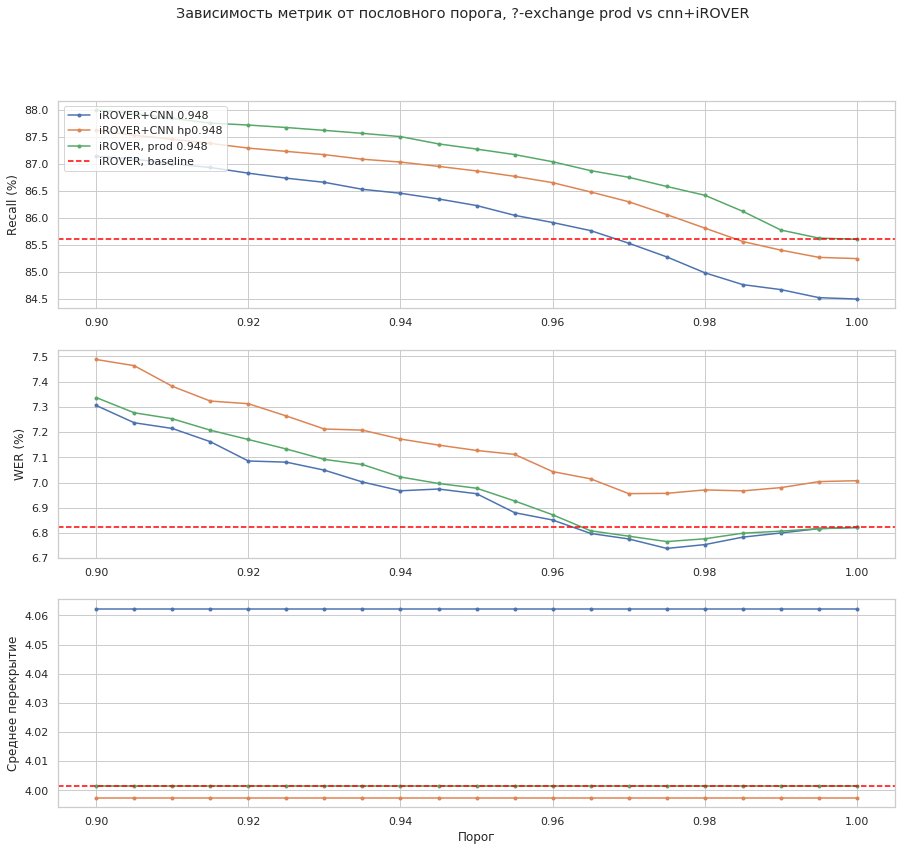

In [154]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange prod vs cnn+iROVER')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER+CNN {:.3f}'.format(key))
for key, value in scores_clf_score_by_word_q_mean.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER+CNN hp{:.3f}'.format(key))
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER, prod {:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, baseline")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
for key, value in scores_clf_score_by_word_q_mean.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
for key, value in scores_clf_score_by_word_q_mean.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.show()

In [155]:
clf = CatBoostClassifier(thread_count=15, random_seed=42)
params = {"iterations": [27000, 30000, 33000], "depth": [8]}
gs2 = GridSearchCV(clf, params, 'roc_auc', cv=5, refit=True, n_jobs=2)

In [156]:
gs2.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("model2 is fitted\n")

Learning rate set to 0.004488
0:	learn: 0.6864526	total: 153ms	remaining: 1h 16m 44s
1:	learn: 0.6802346	total: 293ms	remaining: 1h 13m 11s
2:	learn: 0.6741519	total: 431ms	remaining: 1h 11m 54s
3:	learn: 0.6680300	total: 570ms	remaining: 1h 11m 10s
4:	learn: 0.6621312	total: 707ms	remaining: 1h 10m 39s
5:	learn: 0.6560528	total: 849ms	remaining: 1h 10m 44s
6:	learn: 0.6495705	total: 990ms	remaining: 1h 10m 43s
7:	learn: 0.6437211	total: 1.14s	remaining: 1h 11m 11s
8:	learn: 0.6381026	total: 1.29s	remaining: 1h 11m 26s
9:	learn: 0.6325309	total: 1.43s	remaining: 1h 11m 22s
10:	learn: 0.6268787	total: 1.56s	remaining: 1h 11m 8s
11:	learn: 0.6214922	total: 1.71s	remaining: 1h 11m 12s
12:	learn: 0.6156830	total: 1.86s	remaining: 1h 11m 31s
13:	learn: 0.6102457	total: 2s	remaining: 1h 11m 18s
14:	learn: 0.6048582	total: 2.14s	remaining: 1h 11m 27s
15:	learn: 0.5996116	total: 2.3s	remaining: 1h 11m 43s
16:	learn: 0.5945284	total: 2.43s	remaining: 1h 11m 29s
17:	learn: 0.5894946	total: 2.57s

147:	learn: 0.2770391	total: 21.2s	remaining: 1h 11m 25s
148:	learn: 0.2761953	total: 21.4s	remaining: 1h 11m 23s
149:	learn: 0.2753496	total: 21.5s	remaining: 1h 11m 22s
150:	learn: 0.2744796	total: 21.7s	remaining: 1h 11m 24s
151:	learn: 0.2736612	total: 21.8s	remaining: 1h 11m 23s
152:	learn: 0.2727944	total: 22s	remaining: 1h 11m 23s
153:	learn: 0.2719308	total: 22.1s	remaining: 1h 11m 21s
154:	learn: 0.2710301	total: 22.2s	remaining: 1h 11m 21s
155:	learn: 0.2701330	total: 22.4s	remaining: 1h 11m 19s
156:	learn: 0.2693326	total: 22.5s	remaining: 1h 11m 17s
157:	learn: 0.2685275	total: 22.6s	remaining: 1h 11m 17s
158:	learn: 0.2677412	total: 22.8s	remaining: 1h 11m 16s
159:	learn: 0.2669307	total: 22.9s	remaining: 1h 11m 17s
160:	learn: 0.2661190	total: 23.1s	remaining: 1h 11m 16s
161:	learn: 0.2654159	total: 23.2s	remaining: 1h 11m 15s
162:	learn: 0.2646787	total: 23.4s	remaining: 1h 11m 14s
163:	learn: 0.2639211	total: 23.5s	remaining: 1h 11m 12s
164:	learn: 0.2631598	total: 23.6

293:	learn: 0.2098080	total: 42.1s	remaining: 1h 10m 49s
294:	learn: 0.2095872	total: 42.2s	remaining: 1h 10m 48s
295:	learn: 0.2093710	total: 42.3s	remaining: 1h 10m 48s
296:	learn: 0.2090761	total: 42.5s	remaining: 1h 10m 49s
297:	learn: 0.2088958	total: 42.6s	remaining: 1h 10m 48s
298:	learn: 0.2087156	total: 42.8s	remaining: 1h 10m 47s
299:	learn: 0.2085269	total: 42.9s	remaining: 1h 10m 48s
300:	learn: 0.2083501	total: 43s	remaining: 1h 10m 47s
301:	learn: 0.2081796	total: 43.2s	remaining: 1h 10m 46s
302:	learn: 0.2080163	total: 43.3s	remaining: 1h 10m 44s
303:	learn: 0.2078377	total: 43.4s	remaining: 1h 10m 43s
304:	learn: 0.2076691	total: 43.6s	remaining: 1h 10m 42s
305:	learn: 0.2074648	total: 43.7s	remaining: 1h 10m 45s
306:	learn: 0.2072443	total: 43.9s	remaining: 1h 10m 45s
307:	learn: 0.2070525	total: 44s	remaining: 1h 10m 44s
308:	learn: 0.2068442	total: 44.2s	remaining: 1h 10m 44s
309:	learn: 0.2066694	total: 44.3s	remaining: 1h 10m 44s
310:	learn: 0.2064842	total: 44.5s	

439:	learn: 0.1916252	total: 1m 3s	remaining: 1h 10m 35s
440:	learn: 0.1915553	total: 1m 3s	remaining: 1h 10m 34s
441:	learn: 0.1914925	total: 1m 3s	remaining: 1h 10m 33s
442:	learn: 0.1914365	total: 1m 3s	remaining: 1h 10m 33s
443:	learn: 0.1913580	total: 1m 3s	remaining: 1h 10m 33s
444:	learn: 0.1912839	total: 1m 3s	remaining: 1h 10m 33s
445:	learn: 0.1912230	total: 1m 3s	remaining: 1h 10m 32s
446:	learn: 0.1911489	total: 1m 4s	remaining: 1h 10m 33s
447:	learn: 0.1910741	total: 1m 4s	remaining: 1h 10m 32s
448:	learn: 0.1909995	total: 1m 4s	remaining: 1h 10m 33s
449:	learn: 0.1909338	total: 1m 4s	remaining: 1h 10m 32s
450:	learn: 0.1908609	total: 1m 4s	remaining: 1h 10m 32s
451:	learn: 0.1907614	total: 1m 4s	remaining: 1h 10m 34s
452:	learn: 0.1906776	total: 1m 4s	remaining: 1h 10m 34s
453:	learn: 0.1906206	total: 1m 5s	remaining: 1h 10m 33s
454:	learn: 0.1905292	total: 1m 5s	remaining: 1h 10m 34s
455:	learn: 0.1904600	total: 1m 5s	remaining: 1h 10m 34s
456:	learn: 0.1903988	total: 1m

583:	learn: 0.1840902	total: 1m 23s	remaining: 1h 10m 14s
584:	learn: 0.1840517	total: 1m 23s	remaining: 1h 10m 13s
585:	learn: 0.1840187	total: 1m 23s	remaining: 1h 10m 13s
586:	learn: 0.1839864	total: 1m 24s	remaining: 1h 10m 13s
587:	learn: 0.1839528	total: 1m 24s	remaining: 1h 10m 12s
588:	learn: 0.1839254	total: 1m 24s	remaining: 1h 10m 12s
589:	learn: 0.1838779	total: 1m 24s	remaining: 1h 10m 12s
590:	learn: 0.1838514	total: 1m 24s	remaining: 1h 10m 11s
591:	learn: 0.1838288	total: 1m 24s	remaining: 1h 10m 10s
592:	learn: 0.1837998	total: 1m 24s	remaining: 1h 10m 9s
593:	learn: 0.1837730	total: 1m 25s	remaining: 1h 10m 9s
594:	learn: 0.1837359	total: 1m 25s	remaining: 1h 10m 9s
595:	learn: 0.1837125	total: 1m 25s	remaining: 1h 10m 8s
596:	learn: 0.1836837	total: 1m 25s	remaining: 1h 10m 8s
597:	learn: 0.1836511	total: 1m 25s	remaining: 1h 10m 7s
598:	learn: 0.1836034	total: 1m 25s	remaining: 1h 10m 8s
599:	learn: 0.1835716	total: 1m 25s	remaining: 1h 10m 8s
600:	learn: 0.1835457	

729:	learn: 0.1798829	total: 1m 44s	remaining: 1h 9m 52s
730:	learn: 0.1798631	total: 1m 44s	remaining: 1h 9m 52s
731:	learn: 0.1798369	total: 1m 44s	remaining: 1h 9m 52s
732:	learn: 0.1798037	total: 1m 44s	remaining: 1h 9m 52s
733:	learn: 0.1797849	total: 1m 45s	remaining: 1h 9m 52s
734:	learn: 0.1797576	total: 1m 45s	remaining: 1h 9m 51s
735:	learn: 0.1797414	total: 1m 45s	remaining: 1h 9m 51s
736:	learn: 0.1797280	total: 1m 45s	remaining: 1h 9m 50s
737:	learn: 0.1796984	total: 1m 45s	remaining: 1h 9m 51s
738:	learn: 0.1796758	total: 1m 45s	remaining: 1h 9m 51s
739:	learn: 0.1796488	total: 1m 45s	remaining: 1h 9m 50s
740:	learn: 0.1796211	total: 1m 46s	remaining: 1h 9m 50s
741:	learn: 0.1795967	total: 1m 46s	remaining: 1h 9m 50s
742:	learn: 0.1795676	total: 1m 46s	remaining: 1h 9m 50s
743:	learn: 0.1795383	total: 1m 46s	remaining: 1h 9m 50s
744:	learn: 0.1795217	total: 1m 46s	remaining: 1h 9m 50s
745:	learn: 0.1795072	total: 1m 46s	remaining: 1h 9m 49s
746:	learn: 0.1794767	total: 1m

875:	learn: 0.1770262	total: 2m 5s	remaining: 1h 9m 38s
876:	learn: 0.1770078	total: 2m 5s	remaining: 1h 9m 38s
877:	learn: 0.1769910	total: 2m 5s	remaining: 1h 9m 37s
878:	learn: 0.1769802	total: 2m 6s	remaining: 1h 9m 37s
879:	learn: 0.1769615	total: 2m 6s	remaining: 1h 9m 37s
880:	learn: 0.1769406	total: 2m 6s	remaining: 1h 9m 37s
881:	learn: 0.1769308	total: 2m 6s	remaining: 1h 9m 37s
882:	learn: 0.1769184	total: 2m 6s	remaining: 1h 9m 37s
883:	learn: 0.1769055	total: 2m 6s	remaining: 1h 9m 36s
884:	learn: 0.1768860	total: 2m 6s	remaining: 1h 9m 36s
885:	learn: 0.1768650	total: 2m 7s	remaining: 1h 9m 36s
886:	learn: 0.1768512	total: 2m 7s	remaining: 1h 9m 36s
887:	learn: 0.1768397	total: 2m 7s	remaining: 1h 9m 35s
888:	learn: 0.1768176	total: 2m 7s	remaining: 1h 9m 35s
889:	learn: 0.1767988	total: 2m 7s	remaining: 1h 9m 35s
890:	learn: 0.1767851	total: 2m 7s	remaining: 1h 9m 35s
891:	learn: 0.1767644	total: 2m 7s	remaining: 1h 9m 35s
892:	learn: 0.1767515	total: 2m 8s	remaining: 1h

1019:	learn: 0.1749566	total: 2m 26s	remaining: 1h 9m 11s
1020:	learn: 0.1749415	total: 2m 26s	remaining: 1h 9m 11s
1021:	learn: 0.1749332	total: 2m 26s	remaining: 1h 9m 10s
1022:	learn: 0.1749196	total: 2m 26s	remaining: 1h 9m 10s
1023:	learn: 0.1749053	total: 2m 26s	remaining: 1h 9m 10s
1024:	learn: 0.1748876	total: 2m 26s	remaining: 1h 9m 10s
1025:	learn: 0.1748670	total: 2m 26s	remaining: 1h 9m 10s
1026:	learn: 0.1748593	total: 2m 27s	remaining: 1h 9m 9s
1027:	learn: 0.1748434	total: 2m 27s	remaining: 1h 9m 9s
1028:	learn: 0.1748263	total: 2m 27s	remaining: 1h 9m 10s
1029:	learn: 0.1748183	total: 2m 27s	remaining: 1h 9m 9s
1030:	learn: 0.1748083	total: 2m 27s	remaining: 1h 9m 9s
1031:	learn: 0.1747920	total: 2m 27s	remaining: 1h 9m 9s
1032:	learn: 0.1747819	total: 2m 27s	remaining: 1h 9m 8s
1033:	learn: 0.1747668	total: 2m 28s	remaining: 1h 9m 9s
1034:	learn: 0.1747549	total: 2m 28s	remaining: 1h 9m 8s
1035:	learn: 0.1747479	total: 2m 28s	remaining: 1h 9m 8s
1036:	learn: 0.1747350	

1163:	learn: 0.1733016	total: 2m 46s	remaining: 1h 8m 38s
1164:	learn: 0.1732920	total: 2m 46s	remaining: 1h 8m 38s
1165:	learn: 0.1732849	total: 2m 46s	remaining: 1h 8m 37s
1166:	learn: 0.1732719	total: 2m 46s	remaining: 1h 8m 37s
1167:	learn: 0.1732589	total: 2m 46s	remaining: 1h 8m 37s
1168:	learn: 0.1732534	total: 2m 46s	remaining: 1h 8m 37s
1169:	learn: 0.1732418	total: 2m 47s	remaining: 1h 8m 37s
1170:	learn: 0.1732299	total: 2m 47s	remaining: 1h 8m 37s
1171:	learn: 0.1732225	total: 2m 47s	remaining: 1h 8m 37s
1172:	learn: 0.1732158	total: 2m 47s	remaining: 1h 8m 37s
1173:	learn: 0.1731947	total: 2m 47s	remaining: 1h 8m 37s
1174:	learn: 0.1731839	total: 2m 47s	remaining: 1h 8m 36s
1175:	learn: 0.1731793	total: 2m 47s	remaining: 1h 8m 36s
1176:	learn: 0.1731641	total: 2m 48s	remaining: 1h 8m 36s
1177:	learn: 0.1731542	total: 2m 48s	remaining: 1h 8m 36s
1178:	learn: 0.1731387	total: 2m 48s	remaining: 1h 8m 36s
1179:	learn: 0.1731257	total: 2m 48s	remaining: 1h 8m 36s
1180:	learn: 0

1307:	learn: 0.1719165	total: 3m 6s	remaining: 1h 8m 2s
1308:	learn: 0.1719093	total: 3m 6s	remaining: 1h 8m 1s
1309:	learn: 0.1719013	total: 3m 6s	remaining: 1h 8m 2s
1310:	learn: 0.1718906	total: 3m 6s	remaining: 1h 8m 1s
1311:	learn: 0.1718811	total: 3m 6s	remaining: 1h 8m 1s
1312:	learn: 0.1718740	total: 3m 6s	remaining: 1h 8m 1s
1313:	learn: 0.1718700	total: 3m 6s	remaining: 1h 8m 1s
1314:	learn: 0.1718611	total: 3m 7s	remaining: 1h 8m 1s
1315:	learn: 0.1718493	total: 3m 7s	remaining: 1h 8m
1316:	learn: 0.1718397	total: 3m 7s	remaining: 1h 8m
1317:	learn: 0.1718356	total: 3m 7s	remaining: 1h 8m
1318:	learn: 0.1718286	total: 3m 7s	remaining: 1h 7m 59s
1319:	learn: 0.1718140	total: 3m 7s	remaining: 1h 7m 59s
1320:	learn: 0.1718036	total: 3m 7s	remaining: 1h 7m 59s
1321:	learn: 0.1717979	total: 3m 8s	remaining: 1h 7m 59s
1322:	learn: 0.1717882	total: 3m 8s	remaining: 1h 7m 59s
1323:	learn: 0.1717810	total: 3m 8s	remaining: 1h 7m 58s
1324:	learn: 0.1717647	total: 3m 8s	remaining: 1h 7

1451:	learn: 0.1706951	total: 3m 26s	remaining: 1h 7m 31s
1452:	learn: 0.1706896	total: 3m 26s	remaining: 1h 7m 30s
1453:	learn: 0.1706827	total: 3m 26s	remaining: 1h 7m 30s
1454:	learn: 0.1706763	total: 3m 26s	remaining: 1h 7m 30s
1455:	learn: 0.1706691	total: 3m 26s	remaining: 1h 7m 30s
1456:	learn: 0.1706624	total: 3m 26s	remaining: 1h 7m 29s
1457:	learn: 0.1706516	total: 3m 26s	remaining: 1h 7m 29s
1458:	learn: 0.1706422	total: 3m 27s	remaining: 1h 7m 29s
1459:	learn: 0.1706347	total: 3m 27s	remaining: 1h 7m 29s
1460:	learn: 0.1706251	total: 3m 27s	remaining: 1h 7m 29s
1461:	learn: 0.1706143	total: 3m 27s	remaining: 1h 7m 29s
1462:	learn: 0.1706108	total: 3m 27s	remaining: 1h 7m 28s
1463:	learn: 0.1706017	total: 3m 27s	remaining: 1h 7m 28s
1464:	learn: 0.1705938	total: 3m 27s	remaining: 1h 7m 28s
1465:	learn: 0.1705860	total: 3m 27s	remaining: 1h 7m 28s
1466:	learn: 0.1705785	total: 3m 28s	remaining: 1h 7m 28s
1467:	learn: 0.1705693	total: 3m 28s	remaining: 1h 7m 27s
1468:	learn: 0

1595:	learn: 0.1696776	total: 3m 45s	remaining: 1h 6m 54s
1596:	learn: 0.1696696	total: 3m 45s	remaining: 1h 6m 54s
1597:	learn: 0.1696666	total: 3m 45s	remaining: 1h 6m 54s
1598:	learn: 0.1696620	total: 3m 45s	remaining: 1h 6m 53s
1599:	learn: 0.1696561	total: 3m 46s	remaining: 1h 6m 53s
1600:	learn: 0.1696501	total: 3m 46s	remaining: 1h 6m 53s
1601:	learn: 0.1696436	total: 3m 46s	remaining: 1h 6m 52s
1602:	learn: 0.1696340	total: 3m 46s	remaining: 1h 6m 52s
1603:	learn: 0.1696261	total: 3m 46s	remaining: 1h 6m 52s
1604:	learn: 0.1696176	total: 3m 46s	remaining: 1h 6m 52s
1605:	learn: 0.1696136	total: 3m 46s	remaining: 1h 6m 51s
1606:	learn: 0.1696090	total: 3m 47s	remaining: 1h 6m 51s
1607:	learn: 0.1696044	total: 3m 47s	remaining: 1h 6m 50s
1608:	learn: 0.1695974	total: 3m 47s	remaining: 1h 6m 50s
1609:	learn: 0.1695900	total: 3m 47s	remaining: 1h 6m 50s
1610:	learn: 0.1695734	total: 3m 47s	remaining: 1h 6m 50s
1611:	learn: 0.1695665	total: 3m 47s	remaining: 1h 6m 50s
1612:	learn: 0

1739:	learn: 0.1687462	total: 4m 5s	remaining: 1h 6m 21s
1740:	learn: 0.1687392	total: 4m 5s	remaining: 1h 6m 21s
1741:	learn: 0.1687322	total: 4m 5s	remaining: 1h 6m 21s
1742:	learn: 0.1687280	total: 4m 5s	remaining: 1h 6m 20s
1743:	learn: 0.1687246	total: 4m 5s	remaining: 1h 6m 20s
1744:	learn: 0.1687196	total: 4m 5s	remaining: 1h 6m 20s
1745:	learn: 0.1687165	total: 4m 5s	remaining: 1h 6m 19s
1746:	learn: 0.1687052	total: 4m 6s	remaining: 1h 6m 19s
1747:	learn: 0.1686980	total: 4m 6s	remaining: 1h 6m 19s
1748:	learn: 0.1686934	total: 4m 6s	remaining: 1h 6m 18s
1749:	learn: 0.1686898	total: 4m 6s	remaining: 1h 6m 18s
1750:	learn: 0.1686842	total: 4m 6s	remaining: 1h 6m 18s
1751:	learn: 0.1686759	total: 4m 6s	remaining: 1h 6m 17s
1752:	learn: 0.1686709	total: 4m 6s	remaining: 1h 6m 17s
1753:	learn: 0.1686637	total: 4m 6s	remaining: 1h 6m 17s
1754:	learn: 0.1686560	total: 4m 7s	remaining: 1h 6m 17s
1755:	learn: 0.1686494	total: 4m 7s	remaining: 1h 6m 17s
1756:	learn: 0.1686336	total: 4

1883:	learn: 0.1678866	total: 4m 24s	remaining: 1h 5m 48s
1884:	learn: 0.1678812	total: 4m 24s	remaining: 1h 5m 48s
1885:	learn: 0.1678729	total: 4m 24s	remaining: 1h 5m 48s
1886:	learn: 0.1678667	total: 4m 25s	remaining: 1h 5m 48s
1887:	learn: 0.1678610	total: 4m 25s	remaining: 1h 5m 47s
1888:	learn: 0.1678564	total: 4m 25s	remaining: 1h 5m 47s
1889:	learn: 0.1678509	total: 4m 25s	remaining: 1h 5m 47s
1890:	learn: 0.1678462	total: 4m 25s	remaining: 1h 5m 47s
1891:	learn: 0.1678425	total: 4m 25s	remaining: 1h 5m 46s
1892:	learn: 0.1678398	total: 4m 25s	remaining: 1h 5m 46s
1893:	learn: 0.1678342	total: 4m 25s	remaining: 1h 5m 46s
1894:	learn: 0.1678286	total: 4m 26s	remaining: 1h 5m 46s
1895:	learn: 0.1678234	total: 4m 26s	remaining: 1h 5m 45s
1896:	learn: 0.1678192	total: 4m 26s	remaining: 1h 5m 45s
1897:	learn: 0.1678121	total: 4m 26s	remaining: 1h 5m 45s
1898:	learn: 0.1678092	total: 4m 26s	remaining: 1h 5m 45s
1899:	learn: 0.1678031	total: 4m 26s	remaining: 1h 5m 44s
1900:	learn: 0

2025:	learn: 0.1671111	total: 4m 43s	remaining: 1h 5m 20s
2026:	learn: 0.1671046	total: 4m 44s	remaining: 1h 5m 19s
2027:	learn: 0.1670974	total: 4m 44s	remaining: 1h 5m 19s
2028:	learn: 0.1670933	total: 4m 44s	remaining: 1h 5m 19s
2029:	learn: 0.1670880	total: 4m 44s	remaining: 1h 5m 19s
2030:	learn: 0.1670848	total: 4m 44s	remaining: 1h 5m 18s
2031:	learn: 0.1670778	total: 4m 44s	remaining: 1h 5m 18s
2032:	learn: 0.1670736	total: 4m 44s	remaining: 1h 5m 18s
2033:	learn: 0.1670697	total: 4m 44s	remaining: 1h 5m 18s
2034:	learn: 0.1670656	total: 4m 45s	remaining: 1h 5m 17s
2035:	learn: 0.1670612	total: 4m 45s	remaining: 1h 5m 17s
2036:	learn: 0.1670574	total: 4m 45s	remaining: 1h 5m 17s
2037:	learn: 0.1670523	total: 4m 45s	remaining: 1h 5m 16s
2038:	learn: 0.1670471	total: 4m 45s	remaining: 1h 5m 16s
2039:	learn: 0.1670452	total: 4m 45s	remaining: 1h 5m 16s
2040:	learn: 0.1670413	total: 4m 45s	remaining: 1h 5m 16s
2041:	learn: 0.1670327	total: 4m 46s	remaining: 1h 5m 16s
2042:	learn: 0

2169:	learn: 0.1663333	total: 5m 3s	remaining: 1h 4m 51s
2170:	learn: 0.1663287	total: 5m 3s	remaining: 1h 4m 51s
2171:	learn: 0.1663242	total: 5m 3s	remaining: 1h 4m 51s
2172:	learn: 0.1663188	total: 5m 3s	remaining: 1h 4m 50s
2173:	learn: 0.1663156	total: 5m 3s	remaining: 1h 4m 50s
2174:	learn: 0.1663079	total: 5m 4s	remaining: 1h 4m 50s
2175:	learn: 0.1663064	total: 5m 4s	remaining: 1h 4m 50s
2176:	learn: 0.1663002	total: 5m 4s	remaining: 1h 4m 50s
2177:	learn: 0.1662947	total: 5m 4s	remaining: 1h 4m 49s
2178:	learn: 0.1662892	total: 5m 4s	remaining: 1h 4m 49s
2179:	learn: 0.1662847	total: 5m 4s	remaining: 1h 4m 49s
2180:	learn: 0.1662818	total: 5m 4s	remaining: 1h 4m 49s
2181:	learn: 0.1662722	total: 5m 5s	remaining: 1h 4m 49s
2182:	learn: 0.1662680	total: 5m 5s	remaining: 1h 4m 48s
2183:	learn: 0.1662589	total: 5m 5s	remaining: 1h 4m 48s
2184:	learn: 0.1662532	total: 5m 5s	remaining: 1h 4m 48s
2185:	learn: 0.1662490	total: 5m 5s	remaining: 1h 4m 48s
2186:	learn: 0.1662427	total: 5

2313:	learn: 0.1656367	total: 5m 22s	remaining: 1h 4m 23s
2314:	learn: 0.1656343	total: 5m 23s	remaining: 1h 4m 23s
2315:	learn: 0.1656246	total: 5m 23s	remaining: 1h 4m 23s
2316:	learn: 0.1656185	total: 5m 23s	remaining: 1h 4m 22s
2317:	learn: 0.1656148	total: 5m 23s	remaining: 1h 4m 22s
2318:	learn: 0.1656112	total: 5m 23s	remaining: 1h 4m 22s
2319:	learn: 0.1656081	total: 5m 23s	remaining: 1h 4m 22s
2320:	learn: 0.1656047	total: 5m 23s	remaining: 1h 4m 21s
2321:	learn: 0.1656009	total: 5m 23s	remaining: 1h 4m 21s
2322:	learn: 0.1655953	total: 5m 24s	remaining: 1h 4m 21s
2323:	learn: 0.1655914	total: 5m 24s	remaining: 1h 4m 21s
2324:	learn: 0.1655873	total: 5m 24s	remaining: 1h 4m 21s
2325:	learn: 0.1655820	total: 5m 24s	remaining: 1h 4m 20s
2326:	learn: 0.1655774	total: 5m 24s	remaining: 1h 4m 20s
2327:	learn: 0.1655727	total: 5m 24s	remaining: 1h 4m 20s
2328:	learn: 0.1655680	total: 5m 24s	remaining: 1h 4m 20s
2329:	learn: 0.1655610	total: 5m 25s	remaining: 1h 4m 20s
2330:	learn: 0

2457:	learn: 0.1649459	total: 5m 42s	remaining: 1h 3m 56s
2458:	learn: 0.1649407	total: 5m 42s	remaining: 1h 3m 56s
2459:	learn: 0.1649334	total: 5m 42s	remaining: 1h 3m 56s
2460:	learn: 0.1649273	total: 5m 42s	remaining: 1h 3m 56s
2461:	learn: 0.1649239	total: 5m 42s	remaining: 1h 3m 56s
2462:	learn: 0.1649184	total: 5m 43s	remaining: 1h 3m 56s
2463:	learn: 0.1649107	total: 5m 43s	remaining: 1h 3m 56s
2464:	learn: 0.1649071	total: 5m 43s	remaining: 1h 3m 55s
2465:	learn: 0.1649006	total: 5m 43s	remaining: 1h 3m 55s
2466:	learn: 0.1648954	total: 5m 43s	remaining: 1h 3m 55s
2467:	learn: 0.1648911	total: 5m 43s	remaining: 1h 3m 55s
2468:	learn: 0.1648865	total: 5m 43s	remaining: 1h 3m 55s
2469:	learn: 0.1648808	total: 5m 44s	remaining: 1h 3m 54s
2470:	learn: 0.1648766	total: 5m 44s	remaining: 1h 3m 54s
2471:	learn: 0.1648670	total: 5m 44s	remaining: 1h 3m 54s
2472:	learn: 0.1648631	total: 5m 44s	remaining: 1h 3m 54s
2473:	learn: 0.1648581	total: 5m 44s	remaining: 1h 3m 54s
2474:	learn: 0

2599:	learn: 0.1642594	total: 6m 1s	remaining: 1h 3m 33s
2600:	learn: 0.1642544	total: 6m 1s	remaining: 1h 3m 32s
2601:	learn: 0.1642492	total: 6m 2s	remaining: 1h 3m 32s
2602:	learn: 0.1642439	total: 6m 2s	remaining: 1h 3m 32s
2603:	learn: 0.1642394	total: 6m 2s	remaining: 1h 3m 32s
2604:	learn: 0.1642298	total: 6m 2s	remaining: 1h 3m 32s
2605:	learn: 0.1642266	total: 6m 2s	remaining: 1h 3m 32s
2606:	learn: 0.1642220	total: 6m 2s	remaining: 1h 3m 31s
2607:	learn: 0.1642164	total: 6m 2s	remaining: 1h 3m 31s
2608:	learn: 0.1642124	total: 6m 3s	remaining: 1h 3m 31s
2609:	learn: 0.1642106	total: 6m 3s	remaining: 1h 3m 31s
2610:	learn: 0.1642078	total: 6m 3s	remaining: 1h 3m 30s
2611:	learn: 0.1642056	total: 6m 3s	remaining: 1h 3m 30s
2612:	learn: 0.1642014	total: 6m 3s	remaining: 1h 3m 30s
2613:	learn: 0.1641965	total: 6m 3s	remaining: 1h 3m 30s
2614:	learn: 0.1641904	total: 6m 3s	remaining: 1h 3m 29s
2615:	learn: 0.1641858	total: 6m 3s	remaining: 1h 3m 29s
2616:	learn: 0.1641805	total: 6

2743:	learn: 0.1636226	total: 6m 20s	remaining: 1h 3m 4s
2744:	learn: 0.1636151	total: 6m 21s	remaining: 1h 3m 4s
2745:	learn: 0.1636108	total: 6m 21s	remaining: 1h 3m 4s
2746:	learn: 0.1636071	total: 6m 21s	remaining: 1h 3m 3s
2747:	learn: 0.1636048	total: 6m 21s	remaining: 1h 3m 3s
2748:	learn: 0.1635995	total: 6m 21s	remaining: 1h 3m 3s
2749:	learn: 0.1635956	total: 6m 21s	remaining: 1h 3m 2s
2750:	learn: 0.1635897	total: 6m 21s	remaining: 1h 3m 2s
2751:	learn: 0.1635792	total: 6m 22s	remaining: 1h 3m 2s
2752:	learn: 0.1635709	total: 6m 22s	remaining: 1h 3m 2s
2753:	learn: 0.1635662	total: 6m 22s	remaining: 1h 3m 2s
2754:	learn: 0.1635636	total: 6m 22s	remaining: 1h 3m 2s
2755:	learn: 0.1635592	total: 6m 22s	remaining: 1h 3m 2s
2756:	learn: 0.1635515	total: 6m 22s	remaining: 1h 3m 2s
2757:	learn: 0.1635468	total: 6m 22s	remaining: 1h 3m 2s
2758:	learn: 0.1635446	total: 6m 23s	remaining: 1h 3m 1s
2759:	learn: 0.1635399	total: 6m 23s	remaining: 1h 3m 1s
2760:	learn: 0.1635325	total: 6

2885:	learn: 0.1629327	total: 6m 40s	remaining: 1h 2m 41s
2886:	learn: 0.1629273	total: 6m 40s	remaining: 1h 2m 41s
2887:	learn: 0.1629243	total: 6m 40s	remaining: 1h 2m 41s
2888:	learn: 0.1629172	total: 6m 40s	remaining: 1h 2m 40s
2889:	learn: 0.1629124	total: 6m 40s	remaining: 1h 2m 40s
2890:	learn: 0.1629089	total: 6m 41s	remaining: 1h 2m 40s
2891:	learn: 0.1629060	total: 6m 41s	remaining: 1h 2m 40s
2892:	learn: 0.1628973	total: 6m 41s	remaining: 1h 2m 40s
2893:	learn: 0.1628892	total: 6m 41s	remaining: 1h 2m 40s
2894:	learn: 0.1628855	total: 6m 41s	remaining: 1h 2m 40s
2895:	learn: 0.1628796	total: 6m 41s	remaining: 1h 2m 39s
2896:	learn: 0.1628747	total: 6m 41s	remaining: 1h 2m 39s
2897:	learn: 0.1628715	total: 6m 42s	remaining: 1h 2m 39s
2898:	learn: 0.1628686	total: 6m 42s	remaining: 1h 2m 39s
2899:	learn: 0.1628639	total: 6m 42s	remaining: 1h 2m 39s
2900:	learn: 0.1628609	total: 6m 42s	remaining: 1h 2m 38s
2901:	learn: 0.1628585	total: 6m 42s	remaining: 1h 2m 38s
2902:	learn: 0

3027:	learn: 0.1623077	total: 6m 59s	remaining: 1h 2m 14s
3028:	learn: 0.1623016	total: 6m 59s	remaining: 1h 2m 14s
3029:	learn: 0.1622957	total: 6m 59s	remaining: 1h 2m 14s
3030:	learn: 0.1622933	total: 6m 59s	remaining: 1h 2m 14s
3031:	learn: 0.1622891	total: 6m 59s	remaining: 1h 2m 14s
3032:	learn: 0.1622853	total: 6m 59s	remaining: 1h 2m 13s
3033:	learn: 0.1622755	total: 7m	remaining: 1h 2m 13s
3034:	learn: 0.1622715	total: 7m	remaining: 1h 2m 13s
3035:	learn: 0.1622680	total: 7m	remaining: 1h 2m 13s
3036:	learn: 0.1622638	total: 7m	remaining: 1h 2m 13s
3037:	learn: 0.1622589	total: 7m	remaining: 1h 2m 13s
3038:	learn: 0.1622492	total: 7m	remaining: 1h 2m 13s
3039:	learn: 0.1622443	total: 7m	remaining: 1h 2m 12s
3040:	learn: 0.1622401	total: 7m 1s	remaining: 1h 2m 12s
3041:	learn: 0.1622371	total: 7m 1s	remaining: 1h 2m 12s
3042:	learn: 0.1622327	total: 7m 1s	remaining: 1h 2m 12s
3043:	learn: 0.1622300	total: 7m 1s	remaining: 1h 2m 12s
3044:	learn: 0.1622259	total: 7m 1s	remaining:

3173:	learn: 0.1616430	total: 7m 18s	remaining: 1h 1m 47s
3174:	learn: 0.1616382	total: 7m 18s	remaining: 1h 1m 47s
3175:	learn: 0.1616332	total: 7m 18s	remaining: 1h 1m 47s
3176:	learn: 0.1616255	total: 7m 19s	remaining: 1h 1m 47s
3177:	learn: 0.1616218	total: 7m 19s	remaining: 1h 1m 47s
3178:	learn: 0.1616179	total: 7m 19s	remaining: 1h 1m 46s
3179:	learn: 0.1616129	total: 7m 19s	remaining: 1h 1m 46s
3180:	learn: 0.1616077	total: 7m 19s	remaining: 1h 1m 46s
3181:	learn: 0.1616057	total: 7m 19s	remaining: 1h 1m 45s
3182:	learn: 0.1616029	total: 7m 19s	remaining: 1h 1m 45s
3183:	learn: 0.1616010	total: 7m 19s	remaining: 1h 1m 45s
3184:	learn: 0.1615975	total: 7m 20s	remaining: 1h 1m 45s
3185:	learn: 0.1615927	total: 7m 20s	remaining: 1h 1m 44s
3186:	learn: 0.1615891	total: 7m 20s	remaining: 1h 1m 44s
3187:	learn: 0.1615832	total: 7m 20s	remaining: 1h 1m 44s
3188:	learn: 0.1615792	total: 7m 20s	remaining: 1h 1m 44s
3189:	learn: 0.1615740	total: 7m 20s	remaining: 1h 1m 44s
3190:	learn: 0

3315:	learn: 0.1609769	total: 7m 37s	remaining: 1h 1m 21s
3316:	learn: 0.1609726	total: 7m 37s	remaining: 1h 1m 21s
3317:	learn: 0.1609696	total: 7m 37s	remaining: 1h 1m 21s
3318:	learn: 0.1609659	total: 7m 37s	remaining: 1h 1m 21s
3319:	learn: 0.1609644	total: 7m 38s	remaining: 1h 1m 21s
3320:	learn: 0.1609610	total: 7m 38s	remaining: 1h 1m 20s
3321:	learn: 0.1609563	total: 7m 38s	remaining: 1h 1m 20s
3322:	learn: 0.1609506	total: 7m 38s	remaining: 1h 1m 20s
3323:	learn: 0.1609461	total: 7m 38s	remaining: 1h 1m 20s
3324:	learn: 0.1609429	total: 7m 38s	remaining: 1h 1m 20s
3325:	learn: 0.1609374	total: 7m 38s	remaining: 1h 1m 19s
3326:	learn: 0.1609349	total: 7m 38s	remaining: 1h 1m 19s
3327:	learn: 0.1609326	total: 7m 39s	remaining: 1h 1m 19s
3328:	learn: 0.1609297	total: 7m 39s	remaining: 1h 1m 19s
3329:	learn: 0.1609244	total: 7m 39s	remaining: 1h 1m 19s
3330:	learn: 0.1609207	total: 7m 39s	remaining: 1h 1m 18s
3331:	learn: 0.1609152	total: 7m 39s	remaining: 1h 1m 18s
3332:	learn: 0

3459:	learn: 0.1603232	total: 7m 56s	remaining: 1h 57s
3460:	learn: 0.1603202	total: 7m 56s	remaining: 1h 56s
3461:	learn: 0.1603157	total: 7m 57s	remaining: 1h 56s
3462:	learn: 0.1603119	total: 7m 57s	remaining: 1h 56s
3463:	learn: 0.1603075	total: 7m 57s	remaining: 1h 56s
3464:	learn: 0.1603048	total: 7m 57s	remaining: 1h 56s
3465:	learn: 0.1602998	total: 7m 57s	remaining: 1h 56s
3466:	learn: 0.1602955	total: 7m 57s	remaining: 1h 55s
3467:	learn: 0.1602931	total: 7m 57s	remaining: 1h 55s
3468:	learn: 0.1602872	total: 7m 57s	remaining: 1h 55s
3469:	learn: 0.1602826	total: 7m 58s	remaining: 1h 55s
3470:	learn: 0.1602783	total: 7m 58s	remaining: 1h 55s
3471:	learn: 0.1602743	total: 7m 58s	remaining: 1h 54s
3472:	learn: 0.1602672	total: 7m 58s	remaining: 1h 54s
3473:	learn: 0.1602615	total: 7m 58s	remaining: 1h 54s
3474:	learn: 0.1602588	total: 7m 58s	remaining: 1h 54s
3475:	learn: 0.1602519	total: 7m 58s	remaining: 1h 54s
3476:	learn: 0.1602489	total: 7m 59s	remaining: 1h 54s
3477:	lear

3611:	learn: 0.1596597	total: 8m 17s	remaining: 1h 31s
3612:	learn: 0.1596567	total: 8m 17s	remaining: 1h 31s
3613:	learn: 0.1596539	total: 8m 17s	remaining: 1h 31s
3614:	learn: 0.1596503	total: 8m 17s	remaining: 1h 31s
3615:	learn: 0.1596453	total: 8m 17s	remaining: 1h 31s
3616:	learn: 0.1596381	total: 8m 17s	remaining: 1h 31s
3617:	learn: 0.1596328	total: 8m 18s	remaining: 1h 31s
3618:	learn: 0.1596279	total: 8m 18s	remaining: 1h 31s
3619:	learn: 0.1596246	total: 8m 18s	remaining: 1h 31s
3620:	learn: 0.1596199	total: 8m 18s	remaining: 1h 31s
3621:	learn: 0.1596180	total: 8m 18s	remaining: 1h 30s
3622:	learn: 0.1596122	total: 8m 18s	remaining: 1h 30s
3623:	learn: 0.1596066	total: 8m 18s	remaining: 1h 30s
3624:	learn: 0.1596035	total: 8m 18s	remaining: 1h 30s
3625:	learn: 0.1596007	total: 8m 19s	remaining: 1h 30s
3626:	learn: 0.1595962	total: 8m 19s	remaining: 1h 30s
3627:	learn: 0.1595922	total: 8m 19s	remaining: 1h 30s
3628:	learn: 0.1595877	total: 8m 19s	remaining: 1h 29s
3629:	lear

3761:	learn: 0.1590357	total: 8m 37s	remaining: 1h 8s
3762:	learn: 0.1590323	total: 8m 37s	remaining: 1h 8s
3763:	learn: 0.1590284	total: 8m 37s	remaining: 1h 8s
3764:	learn: 0.1590264	total: 8m 37s	remaining: 1h 8s
3765:	learn: 0.1590237	total: 8m 37s	remaining: 1h 8s
3766:	learn: 0.1590195	total: 8m 38s	remaining: 1h 7s
3767:	learn: 0.1590166	total: 8m 38s	remaining: 1h 7s
3768:	learn: 0.1590095	total: 8m 38s	remaining: 1h 7s
3769:	learn: 0.1590062	total: 8m 38s	remaining: 1h 7s
3770:	learn: 0.1590042	total: 8m 38s	remaining: 1h 7s
3771:	learn: 0.1589974	total: 8m 38s	remaining: 1h 7s
3772:	learn: 0.1589897	total: 8m 38s	remaining: 1h 7s
3773:	learn: 0.1589839	total: 8m 39s	remaining: 1h 6s
3774:	learn: 0.1589818	total: 8m 39s	remaining: 1h 6s
3775:	learn: 0.1589786	total: 8m 39s	remaining: 1h 6s
3776:	learn: 0.1589742	total: 8m 39s	remaining: 1h 6s
3777:	learn: 0.1589703	total: 8m 39s	remaining: 1h 6s
3778:	learn: 0.1589673	total: 8m 39s	remaining: 1h 6s
3779:	learn: 0.1589617	total

3911:	learn: 0.1584210	total: 8m 57s	remaining: 59m 44s
3912:	learn: 0.1584167	total: 8m 57s	remaining: 59m 44s
3913:	learn: 0.1584133	total: 8m 57s	remaining: 59m 43s
3914:	learn: 0.1584105	total: 8m 57s	remaining: 59m 43s
3915:	learn: 0.1584065	total: 8m 57s	remaining: 59m 43s
3916:	learn: 0.1584024	total: 8m 58s	remaining: 59m 43s
3917:	learn: 0.1584003	total: 8m 58s	remaining: 59m 43s
3918:	learn: 0.1583961	total: 8m 58s	remaining: 59m 42s
3919:	learn: 0.1583926	total: 8m 58s	remaining: 59m 42s
3920:	learn: 0.1583885	total: 8m 58s	remaining: 59m 42s
3921:	learn: 0.1583843	total: 8m 58s	remaining: 59m 42s
3922:	learn: 0.1583802	total: 8m 58s	remaining: 59m 42s
3923:	learn: 0.1583773	total: 8m 59s	remaining: 59m 42s
3924:	learn: 0.1583750	total: 8m 59s	remaining: 59m 41s
3925:	learn: 0.1583711	total: 8m 59s	remaining: 59m 41s
3926:	learn: 0.1583670	total: 8m 59s	remaining: 59m 41s
3927:	learn: 0.1583631	total: 8m 59s	remaining: 59m 41s
3928:	learn: 0.1583605	total: 8m 59s	remaining: 

4060:	learn: 0.1578185	total: 9m 17s	remaining: 59m 22s
4061:	learn: 0.1578159	total: 9m 17s	remaining: 59m 21s
4062:	learn: 0.1578117	total: 9m 17s	remaining: 59m 21s
4063:	learn: 0.1578085	total: 9m 18s	remaining: 59m 21s
4064:	learn: 0.1578055	total: 9m 18s	remaining: 59m 21s
4065:	learn: 0.1577984	total: 9m 18s	remaining: 59m 21s
4066:	learn: 0.1577944	total: 9m 18s	remaining: 59m 21s
4067:	learn: 0.1577902	total: 9m 18s	remaining: 59m 20s
4068:	learn: 0.1577870	total: 9m 18s	remaining: 59m 20s
4069:	learn: 0.1577819	total: 9m 18s	remaining: 59m 20s
4070:	learn: 0.1577792	total: 9m 18s	remaining: 59m 20s
4071:	learn: 0.1577757	total: 9m 19s	remaining: 59m 20s
4072:	learn: 0.1577679	total: 9m 19s	remaining: 59m 20s
4073:	learn: 0.1577632	total: 9m 19s	remaining: 59m 19s
4074:	learn: 0.1577611	total: 9m 19s	remaining: 59m 19s
4075:	learn: 0.1577598	total: 9m 19s	remaining: 59m 19s
4076:	learn: 0.1577577	total: 9m 19s	remaining: 59m 19s
4077:	learn: 0.1577547	total: 9m 19s	remaining: 

4208:	learn: 0.1572424	total: 9m 37s	remaining: 58m 59s
4209:	learn: 0.1572393	total: 9m 37s	remaining: 58m 59s
4210:	learn: 0.1572326	total: 9m 37s	remaining: 58m 59s
4211:	learn: 0.1572292	total: 9m 38s	remaining: 58m 59s
4212:	learn: 0.1572255	total: 9m 38s	remaining: 58m 59s
4213:	learn: 0.1572228	total: 9m 38s	remaining: 58m 58s
4214:	learn: 0.1572199	total: 9m 38s	remaining: 58m 58s
4215:	learn: 0.1572169	total: 9m 38s	remaining: 58m 58s
4216:	learn: 0.1572132	total: 9m 38s	remaining: 58m 58s
4217:	learn: 0.1572087	total: 9m 38s	remaining: 58m 58s
4218:	learn: 0.1572044	total: 9m 38s	remaining: 58m 57s
4219:	learn: 0.1572004	total: 9m 39s	remaining: 58m 57s
4220:	learn: 0.1571987	total: 9m 39s	remaining: 58m 57s
4221:	learn: 0.1571961	total: 9m 39s	remaining: 58m 57s
4222:	learn: 0.1571917	total: 9m 39s	remaining: 58m 57s
4223:	learn: 0.1571893	total: 9m 39s	remaining: 58m 56s
4224:	learn: 0.1571852	total: 9m 39s	remaining: 58m 56s
4225:	learn: 0.1571819	total: 9m 39s	remaining: 

4356:	learn: 0.1566959	total: 9m 57s	remaining: 58m 35s
4357:	learn: 0.1566893	total: 9m 57s	remaining: 58m 35s
4358:	learn: 0.1566870	total: 9m 57s	remaining: 58m 35s
4359:	learn: 0.1566830	total: 9m 57s	remaining: 58m 35s
4360:	learn: 0.1566797	total: 9m 57s	remaining: 58m 35s
4361:	learn: 0.1566742	total: 9m 58s	remaining: 58m 35s
4362:	learn: 0.1566718	total: 9m 58s	remaining: 58m 35s
4363:	learn: 0.1566693	total: 9m 58s	remaining: 58m 34s
4364:	learn: 0.1566665	total: 9m 58s	remaining: 58m 34s
4365:	learn: 0.1566638	total: 9m 58s	remaining: 58m 34s
4366:	learn: 0.1566603	total: 9m 58s	remaining: 58m 34s
4367:	learn: 0.1566574	total: 9m 58s	remaining: 58m 34s
4368:	learn: 0.1566536	total: 9m 58s	remaining: 58m 33s
4369:	learn: 0.1566491	total: 9m 59s	remaining: 58m 33s
4370:	learn: 0.1566428	total: 9m 59s	remaining: 58m 33s
4371:	learn: 0.1566363	total: 9m 59s	remaining: 58m 33s
4372:	learn: 0.1566330	total: 9m 59s	remaining: 58m 33s
4373:	learn: 0.1566295	total: 9m 59s	remaining: 

4502:	learn: 0.1561468	total: 10m 16s	remaining: 58m 12s
4503:	learn: 0.1561409	total: 10m 16s	remaining: 58m 12s
4504:	learn: 0.1561381	total: 10m 17s	remaining: 58m 11s
4505:	learn: 0.1561354	total: 10m 17s	remaining: 58m 11s
4506:	learn: 0.1561325	total: 10m 17s	remaining: 58m 11s
4507:	learn: 0.1561307	total: 10m 17s	remaining: 58m 11s
4508:	learn: 0.1561278	total: 10m 17s	remaining: 58m 11s
4509:	learn: 0.1561244	total: 10m 17s	remaining: 58m 11s
4510:	learn: 0.1561191	total: 10m 17s	remaining: 58m 11s
4511:	learn: 0.1561168	total: 10m 17s	remaining: 58m 10s
4512:	learn: 0.1561111	total: 10m 18s	remaining: 58m 10s
4513:	learn: 0.1561082	total: 10m 18s	remaining: 58m 10s
4514:	learn: 0.1561055	total: 10m 18s	remaining: 58m 10s
4515:	learn: 0.1560988	total: 10m 18s	remaining: 58m 10s
4516:	learn: 0.1560965	total: 10m 18s	remaining: 58m 10s
4517:	learn: 0.1560940	total: 10m 18s	remaining: 58m 10s
4518:	learn: 0.1560900	total: 10m 18s	remaining: 58m 9s
4519:	learn: 0.1560866	total: 10

4648:	learn: 0.1556151	total: 10m 36s	remaining: 57m 48s
4649:	learn: 0.1556126	total: 10m 36s	remaining: 57m 48s
4650:	learn: 0.1556063	total: 10m 36s	remaining: 57m 48s
4651:	learn: 0.1556017	total: 10m 36s	remaining: 57m 48s
4652:	learn: 0.1555980	total: 10m 36s	remaining: 57m 48s
4653:	learn: 0.1555951	total: 10m 36s	remaining: 57m 47s
4654:	learn: 0.1555913	total: 10m 36s	remaining: 57m 47s
4655:	learn: 0.1555851	total: 10m 37s	remaining: 57m 47s
4656:	learn: 0.1555803	total: 10m 37s	remaining: 57m 47s
4657:	learn: 0.1555741	total: 10m 37s	remaining: 57m 47s
4658:	learn: 0.1555703	total: 10m 37s	remaining: 57m 47s
4659:	learn: 0.1555667	total: 10m 37s	remaining: 57m 47s
4660:	learn: 0.1555635	total: 10m 37s	remaining: 57m 47s
4661:	learn: 0.1555595	total: 10m 37s	remaining: 57m 47s
4662:	learn: 0.1555561	total: 10m 38s	remaining: 57m 46s
4663:	learn: 0.1555510	total: 10m 38s	remaining: 57m 46s
4664:	learn: 0.1555477	total: 10m 38s	remaining: 57m 46s
4665:	learn: 0.1555424	total: 1

4792:	learn: 0.1550759	total: 10m 55s	remaining: 57m 27s
4793:	learn: 0.1550732	total: 10m 55s	remaining: 57m 26s
4794:	learn: 0.1550708	total: 10m 55s	remaining: 57m 26s
4795:	learn: 0.1550660	total: 10m 55s	remaining: 57m 26s
4796:	learn: 0.1550631	total: 10m 55s	remaining: 57m 26s
4797:	learn: 0.1550591	total: 10m 56s	remaining: 57m 26s
4798:	learn: 0.1550560	total: 10m 56s	remaining: 57m 26s
4799:	learn: 0.1550533	total: 10m 56s	remaining: 57m 25s
4800:	learn: 0.1550515	total: 10m 56s	remaining: 57m 25s
4801:	learn: 0.1550474	total: 10m 56s	remaining: 57m 25s
4802:	learn: 0.1550448	total: 10m 56s	remaining: 57m 25s
4803:	learn: 0.1550412	total: 10m 56s	remaining: 57m 25s
4804:	learn: 0.1550376	total: 10m 57s	remaining: 57m 25s
4805:	learn: 0.1550351	total: 10m 57s	remaining: 57m 24s
4806:	learn: 0.1550336	total: 10m 57s	remaining: 57m 24s
4807:	learn: 0.1550302	total: 10m 57s	remaining: 57m 24s
4808:	learn: 0.1550266	total: 10m 57s	remaining: 57m 24s
4809:	learn: 0.1550228	total: 1

4940:	learn: 0.1545897	total: 11m 15s	remaining: 57m 4s
4941:	learn: 0.1545875	total: 11m 15s	remaining: 57m 3s
4942:	learn: 0.1545818	total: 11m 15s	remaining: 57m 3s
4943:	learn: 0.1545792	total: 11m 15s	remaining: 57m 3s
4944:	learn: 0.1545754	total: 11m 15s	remaining: 57m 3s
4945:	learn: 0.1545698	total: 11m 15s	remaining: 57m 3s
4946:	learn: 0.1545666	total: 11m 15s	remaining: 57m 3s
4947:	learn: 0.1545621	total: 11m 16s	remaining: 57m 3s
4948:	learn: 0.1545598	total: 11m 16s	remaining: 57m 2s
4949:	learn: 0.1545563	total: 11m 16s	remaining: 57m 2s
4950:	learn: 0.1545517	total: 11m 16s	remaining: 57m 2s
4951:	learn: 0.1545479	total: 11m 16s	remaining: 57m 2s
4952:	learn: 0.1545458	total: 11m 16s	remaining: 57m 2s
4953:	learn: 0.1545428	total: 11m 16s	remaining: 57m 2s
4954:	learn: 0.1545396	total: 11m 17s	remaining: 57m 2s
4955:	learn: 0.1545360	total: 11m 17s	remaining: 57m 1s
4956:	learn: 0.1545333	total: 11m 17s	remaining: 57m 1s
4957:	learn: 0.1545304	total: 11m 17s	remaining:

5086:	learn: 0.1541019	total: 11m 34s	remaining: 56m 42s
5087:	learn: 0.1540983	total: 11m 34s	remaining: 56m 42s
5088:	learn: 0.1540957	total: 11m 34s	remaining: 56m 42s
5089:	learn: 0.1540920	total: 11m 35s	remaining: 56m 41s
5090:	learn: 0.1540880	total: 11m 35s	remaining: 56m 41s
5091:	learn: 0.1540864	total: 11m 35s	remaining: 56m 41s
5092:	learn: 0.1540839	total: 11m 35s	remaining: 56m 41s
5093:	learn: 0.1540791	total: 11m 35s	remaining: 56m 41s
5094:	learn: 0.1540761	total: 11m 35s	remaining: 56m 41s
5095:	learn: 0.1540733	total: 11m 35s	remaining: 56m 40s
5096:	learn: 0.1540706	total: 11m 36s	remaining: 56m 40s
5097:	learn: 0.1540676	total: 11m 36s	remaining: 56m 40s
5098:	learn: 0.1540592	total: 11m 36s	remaining: 56m 40s
5099:	learn: 0.1540578	total: 11m 36s	remaining: 56m 40s
5100:	learn: 0.1540537	total: 11m 36s	remaining: 56m 40s
5101:	learn: 0.1540485	total: 11m 36s	remaining: 56m 39s
5102:	learn: 0.1540437	total: 11m 36s	remaining: 56m 39s
5103:	learn: 0.1540418	total: 1

5230:	learn: 0.1536158	total: 11m 54s	remaining: 56m 20s
5231:	learn: 0.1536127	total: 11m 54s	remaining: 56m 20s
5232:	learn: 0.1536073	total: 11m 54s	remaining: 56m 20s
5233:	learn: 0.1536053	total: 11m 54s	remaining: 56m 20s
5234:	learn: 0.1536027	total: 11m 54s	remaining: 56m 20s
5235:	learn: 0.1535992	total: 11m 54s	remaining: 56m 20s
5236:	learn: 0.1535966	total: 11m 54s	remaining: 56m 20s
5237:	learn: 0.1535932	total: 11m 54s	remaining: 56m 19s
5238:	learn: 0.1535889	total: 11m 55s	remaining: 56m 19s
5239:	learn: 0.1535844	total: 11m 55s	remaining: 56m 19s
5240:	learn: 0.1535810	total: 11m 55s	remaining: 56m 19s
5241:	learn: 0.1535763	total: 11m 55s	remaining: 56m 19s
5242:	learn: 0.1535741	total: 11m 55s	remaining: 56m 19s
5243:	learn: 0.1535718	total: 11m 55s	remaining: 56m 19s
5244:	learn: 0.1535669	total: 11m 55s	remaining: 56m 18s
5245:	learn: 0.1535636	total: 11m 56s	remaining: 56m 18s
5246:	learn: 0.1535582	total: 11m 56s	remaining: 56m 18s
5247:	learn: 0.1535564	total: 1

5378:	learn: 0.1531207	total: 12m 13s	remaining: 55m 59s
5379:	learn: 0.1531178	total: 12m 13s	remaining: 55m 58s
5380:	learn: 0.1531140	total: 12m 14s	remaining: 55m 58s
5381:	learn: 0.1531114	total: 12m 14s	remaining: 55m 58s
5382:	learn: 0.1531084	total: 12m 14s	remaining: 55m 58s
5383:	learn: 0.1531057	total: 12m 14s	remaining: 55m 58s
5384:	learn: 0.1531027	total: 12m 14s	remaining: 55m 58s
5385:	learn: 0.1531003	total: 12m 14s	remaining: 55m 58s
5386:	learn: 0.1530983	total: 12m 14s	remaining: 55m 57s
5387:	learn: 0.1530949	total: 12m 15s	remaining: 55m 57s
5388:	learn: 0.1530914	total: 12m 15s	remaining: 55m 57s
5389:	learn: 0.1530890	total: 12m 15s	remaining: 55m 57s
5390:	learn: 0.1530859	total: 12m 15s	remaining: 55m 57s
5391:	learn: 0.1530806	total: 12m 15s	remaining: 55m 57s
5392:	learn: 0.1530772	total: 12m 15s	remaining: 55m 56s
5393:	learn: 0.1530733	total: 12m 15s	remaining: 55m 56s
5394:	learn: 0.1530697	total: 12m 15s	remaining: 55m 56s
5395:	learn: 0.1530679	total: 1

5522:	learn: 0.1526691	total: 12m 33s	remaining: 55m 37s
5523:	learn: 0.1526676	total: 12m 33s	remaining: 55m 37s
5524:	learn: 0.1526653	total: 12m 33s	remaining: 55m 36s
5525:	learn: 0.1526618	total: 12m 33s	remaining: 55m 36s
5526:	learn: 0.1526596	total: 12m 33s	remaining: 55m 36s
5527:	learn: 0.1526564	total: 12m 33s	remaining: 55m 36s
5528:	learn: 0.1526516	total: 12m 33s	remaining: 55m 36s
5529:	learn: 0.1526487	total: 12m 33s	remaining: 55m 36s
5530:	learn: 0.1526459	total: 12m 34s	remaining: 55m 36s
5531:	learn: 0.1526431	total: 12m 34s	remaining: 55m 35s
5532:	learn: 0.1526406	total: 12m 34s	remaining: 55m 35s
5533:	learn: 0.1526353	total: 12m 34s	remaining: 55m 35s
5534:	learn: 0.1526307	total: 12m 34s	remaining: 55m 35s
5535:	learn: 0.1526296	total: 12m 34s	remaining: 55m 35s
5536:	learn: 0.1526259	total: 12m 34s	remaining: 55m 35s
5537:	learn: 0.1526222	total: 12m 35s	remaining: 55m 34s
5538:	learn: 0.1526193	total: 12m 35s	remaining: 55m 34s
5539:	learn: 0.1526159	total: 1

5666:	learn: 0.1522131	total: 12m 52s	remaining: 55m 15s
5667:	learn: 0.1522083	total: 12m 52s	remaining: 55m 15s
5668:	learn: 0.1522049	total: 12m 52s	remaining: 55m 15s
5669:	learn: 0.1522005	total: 12m 52s	remaining: 55m 15s
5670:	learn: 0.1521966	total: 12m 52s	remaining: 55m 15s
5671:	learn: 0.1521944	total: 12m 52s	remaining: 55m 14s
5672:	learn: 0.1521908	total: 12m 53s	remaining: 55m 14s
5673:	learn: 0.1521844	total: 12m 53s	remaining: 55m 14s
5674:	learn: 0.1521804	total: 12m 53s	remaining: 55m 14s
5675:	learn: 0.1521779	total: 12m 53s	remaining: 55m 14s
5676:	learn: 0.1521763	total: 12m 53s	remaining: 55m 14s
5677:	learn: 0.1521687	total: 12m 53s	remaining: 55m 14s
5678:	learn: 0.1521648	total: 12m 53s	remaining: 55m 13s
5679:	learn: 0.1521612	total: 12m 53s	remaining: 55m 13s
5680:	learn: 0.1521554	total: 12m 54s	remaining: 55m 13s
5681:	learn: 0.1521536	total: 12m 54s	remaining: 55m 13s
5682:	learn: 0.1521518	total: 12m 54s	remaining: 55m 13s
5683:	learn: 0.1521493	total: 1

5814:	learn: 0.1517058	total: 13m 11s	remaining: 54m 53s
5815:	learn: 0.1517032	total: 13m 12s	remaining: 54m 53s
5816:	learn: 0.1516998	total: 13m 12s	remaining: 54m 53s
5817:	learn: 0.1516960	total: 13m 12s	remaining: 54m 53s
5818:	learn: 0.1516920	total: 13m 12s	remaining: 54m 53s
5819:	learn: 0.1516902	total: 13m 12s	remaining: 54m 53s
5820:	learn: 0.1516856	total: 13m 12s	remaining: 54m 52s
5821:	learn: 0.1516816	total: 13m 12s	remaining: 54m 52s
5822:	learn: 0.1516788	total: 13m 13s	remaining: 54m 52s
5823:	learn: 0.1516750	total: 13m 13s	remaining: 54m 52s
5824:	learn: 0.1516708	total: 13m 13s	remaining: 54m 52s
5825:	learn: 0.1516696	total: 13m 13s	remaining: 54m 52s
5826:	learn: 0.1516682	total: 13m 13s	remaining: 54m 52s
5827:	learn: 0.1516638	total: 13m 13s	remaining: 54m 51s
5828:	learn: 0.1516605	total: 13m 13s	remaining: 54m 51s
5829:	learn: 0.1516538	total: 13m 14s	remaining: 54m 51s
5830:	learn: 0.1516516	total: 13m 14s	remaining: 54m 51s
5831:	learn: 0.1516489	total: 1

5958:	learn: 0.1512548	total: 13m 31s	remaining: 54m 34s
5959:	learn: 0.1512519	total: 13m 31s	remaining: 54m 34s
5960:	learn: 0.1512491	total: 13m 31s	remaining: 54m 33s
5961:	learn: 0.1512465	total: 13m 31s	remaining: 54m 33s
5962:	learn: 0.1512425	total: 13m 32s	remaining: 54m 33s
5963:	learn: 0.1512393	total: 13m 32s	remaining: 54m 33s
5964:	learn: 0.1512375	total: 13m 32s	remaining: 54m 33s
5965:	learn: 0.1512351	total: 13m 32s	remaining: 54m 33s
5966:	learn: 0.1512329	total: 13m 32s	remaining: 54m 33s
5967:	learn: 0.1512287	total: 13m 32s	remaining: 54m 32s
5968:	learn: 0.1512264	total: 13m 32s	remaining: 54m 32s
5969:	learn: 0.1512237	total: 13m 33s	remaining: 54m 32s
5970:	learn: 0.1512164	total: 13m 33s	remaining: 54m 32s
5971:	learn: 0.1512133	total: 13m 33s	remaining: 54m 32s
5972:	learn: 0.1512122	total: 13m 33s	remaining: 54m 32s
5973:	learn: 0.1512097	total: 13m 33s	remaining: 54m 32s
5974:	learn: 0.1512016	total: 13m 33s	remaining: 54m 31s
5975:	learn: 0.1511983	total: 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11802:	learn: 0.1362001	total: 26m 41s	remaining: 41m 9s
11803:	learn: 0.1361967	total: 26m 41s	remaining: 41m 9s
11804:	learn: 0.1361950	total: 26m 41s	remaining: 41m 9s
11805:	learn: 0.1361938	total: 26m 42s	remaining: 41m 8s
11806:	learn: 0.1361907	total: 26m 42s	remaining: 41m 8s
11807:	learn: 0.1361880	total: 26m 42s	remaining: 41m 8s
11808:	learn: 0.1361843	total: 26m 42s	remaining: 41m 8s
11809:	learn: 0.1361829	total: 26m 42s	remaining: 41m 8s
11810:	learn: 0.1361805	total: 26m 42s	remaining: 41m 8s
11811:	learn: 0.1361789	total: 26m 42s	remaining: 41m 8s
11812:	learn: 0.1361775	total: 26m 43s	remaining: 41m 7s
11813:	learn: 0.1361756	total: 26m 43s	remaining: 41m 7s
11814:	learn: 0.1361726	total: 26m 43s	remaining: 41m 7s
11815:	learn: 0.1361717	total: 26m 43s	remaining: 41m 7s
11816:	learn: 0.1361687	total: 26m 43s	remaining: 41m 7s
11817:	learn: 0.1361663	total: 26m 43s	remaining: 41m 7s
11818:	learn: 0.1361650	total: 26m 43s	remaining: 41m 7s
11819:	learn: 0.1361640	total: 

11946:	learn: 0.1359118	total: 27m	remaining: 40m 49s
11947:	learn: 0.1359095	total: 27m 1s	remaining: 40m 49s
11948:	learn: 0.1359084	total: 27m 1s	remaining: 40m 49s
11949:	learn: 0.1359062	total: 27m 1s	remaining: 40m 48s
11950:	learn: 0.1359038	total: 27m 1s	remaining: 40m 48s
11951:	learn: 0.1359022	total: 27m 1s	remaining: 40m 48s
11952:	learn: 0.1358983	total: 27m 1s	remaining: 40m 48s
11953:	learn: 0.1358966	total: 27m 1s	remaining: 40m 48s
11954:	learn: 0.1358942	total: 27m 2s	remaining: 40m 48s
11955:	learn: 0.1358905	total: 27m 2s	remaining: 40m 48s
11956:	learn: 0.1358879	total: 27m 2s	remaining: 40m 48s
11957:	learn: 0.1358863	total: 27m 2s	remaining: 40m 47s
11958:	learn: 0.1358846	total: 27m 2s	remaining: 40m 47s
11959:	learn: 0.1358827	total: 27m 2s	remaining: 40m 47s
11960:	learn: 0.1358816	total: 27m 2s	remaining: 40m 47s
11961:	learn: 0.1358790	total: 27m 2s	remaining: 40m 47s
11962:	learn: 0.1358751	total: 27m 3s	remaining: 40m 47s
11963:	learn: 0.1358727	total: 27m

12090:	learn: 0.1356126	total: 27m 20s	remaining: 40m 29s
12091:	learn: 0.1356096	total: 27m 20s	remaining: 40m 29s
12092:	learn: 0.1356089	total: 27m 20s	remaining: 40m 29s
12093:	learn: 0.1356051	total: 27m 20s	remaining: 40m 29s
12094:	learn: 0.1356024	total: 27m 21s	remaining: 40m 29s
12095:	learn: 0.1356011	total: 27m 21s	remaining: 40m 29s
12096:	learn: 0.1356002	total: 27m 21s	remaining: 40m 29s
12097:	learn: 0.1355983	total: 27m 21s	remaining: 40m 28s
12098:	learn: 0.1355953	total: 27m 21s	remaining: 40m 28s
12099:	learn: 0.1355934	total: 27m 21s	remaining: 40m 28s
12100:	learn: 0.1355914	total: 27m 21s	remaining: 40m 28s
12101:	learn: 0.1355903	total: 27m 21s	remaining: 40m 28s
12102:	learn: 0.1355881	total: 27m 22s	remaining: 40m 28s
12103:	learn: 0.1355866	total: 27m 22s	remaining: 40m 28s
12104:	learn: 0.1355852	total: 27m 22s	remaining: 40m 27s
12105:	learn: 0.1355834	total: 27m 22s	remaining: 40m 27s
12106:	learn: 0.1355824	total: 27m 22s	remaining: 40m 27s
12107:	learn: 

12232:	learn: 0.1353194	total: 27m 39s	remaining: 40m 10s
12233:	learn: 0.1353179	total: 27m 39s	remaining: 40m 10s
12234:	learn: 0.1353166	total: 27m 39s	remaining: 40m 10s
12235:	learn: 0.1353141	total: 27m 40s	remaining: 40m 9s
12236:	learn: 0.1353132	total: 27m 40s	remaining: 40m 9s
12237:	learn: 0.1353113	total: 27m 40s	remaining: 40m 9s
12238:	learn: 0.1353093	total: 27m 40s	remaining: 40m 9s
12239:	learn: 0.1353070	total: 27m 40s	remaining: 40m 9s
12240:	learn: 0.1353035	total: 27m 40s	remaining: 40m 9s
12241:	learn: 0.1353015	total: 27m 40s	remaining: 40m 9s
12242:	learn: 0.1352984	total: 27m 40s	remaining: 40m 9s
12243:	learn: 0.1352969	total: 27m 41s	remaining: 40m 8s
12244:	learn: 0.1352952	total: 27m 41s	remaining: 40m 8s
12245:	learn: 0.1352941	total: 27m 41s	remaining: 40m 8s
12246:	learn: 0.1352934	total: 27m 41s	remaining: 40m 8s
12247:	learn: 0.1352924	total: 27m 41s	remaining: 40m 8s
12248:	learn: 0.1352898	total: 27m 41s	remaining: 40m 8s
12249:	learn: 0.1352880	tota

12376:	learn: 0.1350193	total: 27m 59s	remaining: 39m 51s
12377:	learn: 0.1350186	total: 27m 59s	remaining: 39m 51s
12378:	learn: 0.1350172	total: 27m 59s	remaining: 39m 51s
12379:	learn: 0.1350150	total: 27m 59s	remaining: 39m 50s
12380:	learn: 0.1350129	total: 28m	remaining: 39m 50s
12381:	learn: 0.1350115	total: 28m	remaining: 39m 50s
12382:	learn: 0.1350097	total: 28m	remaining: 39m 50s
12383:	learn: 0.1350078	total: 28m	remaining: 39m 50s
12384:	learn: 0.1350061	total: 28m	remaining: 39m 50s
12385:	learn: 0.1350035	total: 28m	remaining: 39m 50s
12386:	learn: 0.1350008	total: 28m	remaining: 39m 50s
12387:	learn: 0.1349988	total: 28m	remaining: 39m 49s
12388:	learn: 0.1349955	total: 28m 1s	remaining: 39m 49s
12389:	learn: 0.1349944	total: 28m 1s	remaining: 39m 49s
12390:	learn: 0.1349931	total: 28m 1s	remaining: 39m 49s
12391:	learn: 0.1349901	total: 28m 1s	remaining: 39m 49s
12392:	learn: 0.1349859	total: 28m 1s	remaining: 39m 49s
12393:	learn: 0.1349811	total: 28m 1s	remaining: 39

12520:	learn: 0.1347186	total: 28m 19s	remaining: 39m 31s
12521:	learn: 0.1347177	total: 28m 19s	remaining: 39m 31s
12522:	learn: 0.1347167	total: 28m 19s	remaining: 39m 31s
12523:	learn: 0.1347145	total: 28m 19s	remaining: 39m 31s
12524:	learn: 0.1347132	total: 28m 19s	remaining: 39m 31s
12525:	learn: 0.1347113	total: 28m 19s	remaining: 39m 31s
12526:	learn: 0.1347089	total: 28m 19s	remaining: 39m 31s
12527:	learn: 0.1347053	total: 28m 20s	remaining: 39m 31s
12528:	learn: 0.1347005	total: 28m 20s	remaining: 39m 30s
12529:	learn: 0.1346988	total: 28m 20s	remaining: 39m 30s
12530:	learn: 0.1346977	total: 28m 20s	remaining: 39m 30s
12531:	learn: 0.1346962	total: 28m 20s	remaining: 39m 30s
12532:	learn: 0.1346947	total: 28m 20s	remaining: 39m 30s
12533:	learn: 0.1346931	total: 28m 20s	remaining: 39m 30s
12534:	learn: 0.1346903	total: 28m 21s	remaining: 39m 30s
12535:	learn: 0.1346880	total: 28m 21s	remaining: 39m 30s
12536:	learn: 0.1346857	total: 28m 21s	remaining: 39m 29s
12537:	learn: 

12662:	learn: 0.1344125	total: 28m 38s	remaining: 39m 13s
12663:	learn: 0.1344111	total: 28m 38s	remaining: 39m 13s
12664:	learn: 0.1344084	total: 28m 39s	remaining: 39m 12s
12665:	learn: 0.1344073	total: 28m 39s	remaining: 39m 12s
12666:	learn: 0.1344054	total: 28m 39s	remaining: 39m 12s
12667:	learn: 0.1344039	total: 28m 39s	remaining: 39m 12s
12668:	learn: 0.1344024	total: 28m 39s	remaining: 39m 12s
12669:	learn: 0.1344012	total: 28m 39s	remaining: 39m 12s
12670:	learn: 0.1343996	total: 28m 39s	remaining: 39m 12s
12671:	learn: 0.1343968	total: 28m 40s	remaining: 39m 12s
12672:	learn: 0.1343957	total: 28m 40s	remaining: 39m 11s
12673:	learn: 0.1343936	total: 28m 40s	remaining: 39m 11s
12674:	learn: 0.1343919	total: 28m 40s	remaining: 39m 11s
12675:	learn: 0.1343904	total: 28m 40s	remaining: 39m 11s
12676:	learn: 0.1343881	total: 28m 40s	remaining: 39m 11s
12677:	learn: 0.1343859	total: 28m 40s	remaining: 39m 11s
12678:	learn: 0.1343838	total: 28m 40s	remaining: 39m 11s
12679:	learn: 

12806:	learn: 0.1341155	total: 28m 58s	remaining: 38m 53s
12807:	learn: 0.1341130	total: 28m 58s	remaining: 38m 53s
12808:	learn: 0.1341120	total: 28m 58s	remaining: 38m 53s
12809:	learn: 0.1341098	total: 28m 58s	remaining: 38m 53s
12810:	learn: 0.1341062	total: 28m 58s	remaining: 38m 53s
12811:	learn: 0.1341033	total: 28m 59s	remaining: 38m 53s
12812:	learn: 0.1341006	total: 28m 59s	remaining: 38m 52s
12813:	learn: 0.1340980	total: 28m 59s	remaining: 38m 52s
12814:	learn: 0.1340963	total: 28m 59s	remaining: 38m 52s
12815:	learn: 0.1340944	total: 28m 59s	remaining: 38m 52s
12816:	learn: 0.1340921	total: 28m 59s	remaining: 38m 52s
12817:	learn: 0.1340910	total: 28m 59s	remaining: 38m 52s
12818:	learn: 0.1340889	total: 28m 59s	remaining: 38m 52s
12819:	learn: 0.1340864	total: 29m	remaining: 38m 51s
12820:	learn: 0.1340852	total: 29m	remaining: 38m 51s
12821:	learn: 0.1340831	total: 29m	remaining: 38m 51s
12822:	learn: 0.1340812	total: 29m	remaining: 38m 51s
12823:	learn: 0.1340787	total:

12950:	learn: 0.1338204	total: 29m 17s	remaining: 38m 34s
12951:	learn: 0.1338184	total: 29m 18s	remaining: 38m 34s
12952:	learn: 0.1338169	total: 29m 18s	remaining: 38m 33s
12953:	learn: 0.1338159	total: 29m 18s	remaining: 38m 33s
12954:	learn: 0.1338142	total: 29m 18s	remaining: 38m 33s
12955:	learn: 0.1338116	total: 29m 18s	remaining: 38m 33s
12956:	learn: 0.1338107	total: 29m 18s	remaining: 38m 33s
12957:	learn: 0.1338093	total: 29m 18s	remaining: 38m 33s
12958:	learn: 0.1338071	total: 29m 18s	remaining: 38m 33s
12959:	learn: 0.1338058	total: 29m 19s	remaining: 38m 32s
12960:	learn: 0.1338037	total: 29m 19s	remaining: 38m 32s
12961:	learn: 0.1338023	total: 29m 19s	remaining: 38m 32s
12962:	learn: 0.1337999	total: 29m 19s	remaining: 38m 32s
12963:	learn: 0.1337984	total: 29m 19s	remaining: 38m 32s
12964:	learn: 0.1337945	total: 29m 19s	remaining: 38m 32s
12965:	learn: 0.1337926	total: 29m 19s	remaining: 38m 32s
12966:	learn: 0.1337919	total: 29m 20s	remaining: 38m 31s
12967:	learn: 

13092:	learn: 0.1335209	total: 29m 37s	remaining: 38m 14s
13093:	learn: 0.1335192	total: 29m 37s	remaining: 38m 14s
13094:	learn: 0.1335177	total: 29m 37s	remaining: 38m 14s
13095:	learn: 0.1335166	total: 29m 37s	remaining: 38m 14s
13096:	learn: 0.1335147	total: 29m 37s	remaining: 38m 14s
13097:	learn: 0.1335107	total: 29m 37s	remaining: 38m 14s
13098:	learn: 0.1335085	total: 29m 38s	remaining: 38m 14s
13099:	learn: 0.1335056	total: 29m 38s	remaining: 38m 14s
13100:	learn: 0.1335032	total: 29m 38s	remaining: 38m 13s
13101:	learn: 0.1335018	total: 29m 38s	remaining: 38m 13s
13102:	learn: 0.1335000	total: 29m 38s	remaining: 38m 13s
13103:	learn: 0.1334995	total: 29m 38s	remaining: 38m 13s
13104:	learn: 0.1334975	total: 29m 38s	remaining: 38m 13s
13105:	learn: 0.1334938	total: 29m 39s	remaining: 38m 13s
13106:	learn: 0.1334897	total: 29m 39s	remaining: 38m 13s
13107:	learn: 0.1334876	total: 29m 39s	remaining: 38m 12s
13108:	learn: 0.1334840	total: 29m 39s	remaining: 38m 12s
13109:	learn: 

13236:	learn: 0.1332247	total: 29m 56s	remaining: 37m 55s
13237:	learn: 0.1332227	total: 29m 56s	remaining: 37m 55s
13238:	learn: 0.1332206	total: 29m 57s	remaining: 37m 55s
13239:	learn: 0.1332184	total: 29m 57s	remaining: 37m 54s
13240:	learn: 0.1332172	total: 29m 57s	remaining: 37m 54s
13241:	learn: 0.1332148	total: 29m 57s	remaining: 37m 54s
13242:	learn: 0.1332133	total: 29m 57s	remaining: 37m 54s
13243:	learn: 0.1332102	total: 29m 57s	remaining: 37m 54s
13244:	learn: 0.1332089	total: 29m 57s	remaining: 37m 54s
13245:	learn: 0.1332065	total: 29m 57s	remaining: 37m 54s
13246:	learn: 0.1332058	total: 29m 58s	remaining: 37m 53s
13247:	learn: 0.1332032	total: 29m 58s	remaining: 37m 53s
13248:	learn: 0.1332002	total: 29m 58s	remaining: 37m 53s
13249:	learn: 0.1331991	total: 29m 58s	remaining: 37m 53s
13250:	learn: 0.1331978	total: 29m 58s	remaining: 37m 53s
13251:	learn: 0.1331949	total: 29m 58s	remaining: 37m 53s
13252:	learn: 0.1331930	total: 29m 58s	remaining: 37m 53s
13253:	learn: 

13380:	learn: 0.1329326	total: 30m 16s	remaining: 37m 35s
13381:	learn: 0.1329309	total: 30m 16s	remaining: 37m 35s
13382:	learn: 0.1329280	total: 30m 16s	remaining: 37m 35s
13383:	learn: 0.1329269	total: 30m 16s	remaining: 37m 35s
13384:	learn: 0.1329247	total: 30m 16s	remaining: 37m 35s
13385:	learn: 0.1329200	total: 30m 17s	remaining: 37m 35s
13386:	learn: 0.1329180	total: 30m 17s	remaining: 37m 35s
13387:	learn: 0.1329155	total: 30m 17s	remaining: 37m 34s
13388:	learn: 0.1329131	total: 30m 17s	remaining: 37m 34s
13389:	learn: 0.1329120	total: 30m 17s	remaining: 37m 34s
13390:	learn: 0.1329111	total: 30m 17s	remaining: 37m 34s
13391:	learn: 0.1329089	total: 30m 17s	remaining: 37m 34s
13392:	learn: 0.1329067	total: 30m 18s	remaining: 37m 34s
13393:	learn: 0.1329031	total: 30m 18s	remaining: 37m 34s
13394:	learn: 0.1329011	total: 30m 18s	remaining: 37m 34s
13395:	learn: 0.1328975	total: 30m 18s	remaining: 37m 33s
13396:	learn: 0.1328958	total: 30m 18s	remaining: 37m 33s
13397:	learn: 

13522:	learn: 0.1326322	total: 30m 35s	remaining: 37m 16s
13523:	learn: 0.1326309	total: 30m 35s	remaining: 37m 16s
13524:	learn: 0.1326274	total: 30m 36s	remaining: 37m 16s
13525:	learn: 0.1326263	total: 30m 36s	remaining: 37m 16s
13526:	learn: 0.1326248	total: 30m 36s	remaining: 37m 16s
13527:	learn: 0.1326219	total: 30m 36s	remaining: 37m 16s
13528:	learn: 0.1326187	total: 30m 36s	remaining: 37m 16s
13529:	learn: 0.1326160	total: 30m 36s	remaining: 37m 15s
13530:	learn: 0.1326137	total: 30m 36s	remaining: 37m 15s
13531:	learn: 0.1326125	total: 30m 37s	remaining: 37m 15s
13532:	learn: 0.1326116	total: 30m 37s	remaining: 37m 15s
13533:	learn: 0.1326091	total: 30m 37s	remaining: 37m 15s
13534:	learn: 0.1326073	total: 30m 37s	remaining: 37m 15s
13535:	learn: 0.1326044	total: 30m 37s	remaining: 37m 15s
13536:	learn: 0.1326023	total: 30m 37s	remaining: 37m 14s
13537:	learn: 0.1325996	total: 30m 37s	remaining: 37m 14s
13538:	learn: 0.1325983	total: 30m 37s	remaining: 37m 14s
13539:	learn: 

13666:	learn: 0.1323257	total: 30m 55s	remaining: 36m 57s
13667:	learn: 0.1323242	total: 30m 55s	remaining: 36m 57s
13668:	learn: 0.1323220	total: 30m 55s	remaining: 36m 56s
13669:	learn: 0.1323205	total: 30m 55s	remaining: 36m 56s
13670:	learn: 0.1323192	total: 30m 55s	remaining: 36m 56s
13671:	learn: 0.1323164	total: 30m 55s	remaining: 36m 56s
13672:	learn: 0.1323145	total: 30m 56s	remaining: 36m 56s
13673:	learn: 0.1323134	total: 30m 56s	remaining: 36m 56s
13674:	learn: 0.1323115	total: 30m 56s	remaining: 36m 56s
13675:	learn: 0.1323098	total: 30m 56s	remaining: 36m 56s
13676:	learn: 0.1323081	total: 30m 56s	remaining: 36m 55s
13677:	learn: 0.1323064	total: 30m 56s	remaining: 36m 55s
13678:	learn: 0.1323051	total: 30m 56s	remaining: 36m 55s
13679:	learn: 0.1323042	total: 30m 57s	remaining: 36m 55s
13680:	learn: 0.1323022	total: 30m 57s	remaining: 36m 55s
13681:	learn: 0.1323011	total: 30m 57s	remaining: 36m 55s
13682:	learn: 0.1322981	total: 30m 57s	remaining: 36m 55s
13683:	learn: 

13810:	learn: 0.1320565	total: 31m 14s	remaining: 36m 37s
13811:	learn: 0.1320543	total: 31m 14s	remaining: 36m 37s
13812:	learn: 0.1320522	total: 31m 14s	remaining: 36m 36s
13813:	learn: 0.1320495	total: 31m 14s	remaining: 36m 36s
13814:	learn: 0.1320459	total: 31m 15s	remaining: 36m 36s
13815:	learn: 0.1320446	total: 31m 15s	remaining: 36m 36s
13816:	learn: 0.1320431	total: 31m 15s	remaining: 36m 36s
13817:	learn: 0.1320412	total: 31m 15s	remaining: 36m 36s
13818:	learn: 0.1320385	total: 31m 15s	remaining: 36m 36s
13819:	learn: 0.1320364	total: 31m 15s	remaining: 36m 36s
13820:	learn: 0.1320355	total: 31m 15s	remaining: 36m 35s
13821:	learn: 0.1320331	total: 31m 16s	remaining: 36m 35s
13822:	learn: 0.1320298	total: 31m 16s	remaining: 36m 35s
13823:	learn: 0.1320269	total: 31m 16s	remaining: 36m 35s
13824:	learn: 0.1320257	total: 31m 16s	remaining: 36m 35s
13825:	learn: 0.1320220	total: 31m 16s	remaining: 36m 35s
13826:	learn: 0.1320189	total: 31m 16s	remaining: 36m 35s
13827:	learn: 

13952:	learn: 0.1317599	total: 31m 33s	remaining: 36m 18s
13953:	learn: 0.1317582	total: 31m 33s	remaining: 36m 17s
13954:	learn: 0.1317568	total: 31m 34s	remaining: 36m 17s
13955:	learn: 0.1317534	total: 31m 34s	remaining: 36m 17s
13956:	learn: 0.1317491	total: 31m 34s	remaining: 36m 17s
13957:	learn: 0.1317440	total: 31m 34s	remaining: 36m 17s
13958:	learn: 0.1317433	total: 31m 34s	remaining: 36m 17s
13959:	learn: 0.1317416	total: 31m 34s	remaining: 36m 17s
13960:	learn: 0.1317385	total: 31m 34s	remaining: 36m 17s
13961:	learn: 0.1317358	total: 31m 35s	remaining: 36m 16s
13962:	learn: 0.1317342	total: 31m 35s	remaining: 36m 16s
13963:	learn: 0.1317338	total: 31m 35s	remaining: 36m 16s
13964:	learn: 0.1317327	total: 31m 35s	remaining: 36m 16s
13965:	learn: 0.1317308	total: 31m 35s	remaining: 36m 16s
13966:	learn: 0.1317293	total: 31m 35s	remaining: 36m 16s
13967:	learn: 0.1317274	total: 31m 35s	remaining: 36m 16s
13968:	learn: 0.1317259	total: 31m 36s	remaining: 36m 15s
13969:	learn: 

14096:	learn: 0.1314825	total: 31m 53s	remaining: 35m 58s
14097:	learn: 0.1314811	total: 31m 53s	remaining: 35m 58s
14098:	learn: 0.1314803	total: 31m 53s	remaining: 35m 58s
14099:	learn: 0.1314792	total: 31m 54s	remaining: 35m 58s
14100:	learn: 0.1314784	total: 31m 54s	remaining: 35m 58s
14101:	learn: 0.1314766	total: 31m 54s	remaining: 35m 58s
14102:	learn: 0.1314734	total: 31m 54s	remaining: 35m 58s
14103:	learn: 0.1314709	total: 31m 54s	remaining: 35m 57s
14104:	learn: 0.1314688	total: 31m 54s	remaining: 35m 57s
14105:	learn: 0.1314644	total: 31m 54s	remaining: 35m 57s
14106:	learn: 0.1314624	total: 31m 55s	remaining: 35m 57s
14107:	learn: 0.1314612	total: 31m 55s	remaining: 35m 57s
14108:	learn: 0.1314595	total: 31m 55s	remaining: 35m 57s
14109:	learn: 0.1314577	total: 31m 55s	remaining: 35m 57s
14110:	learn: 0.1314552	total: 31m 55s	remaining: 35m 56s
14111:	learn: 0.1314538	total: 31m 55s	remaining: 35m 56s
14112:	learn: 0.1314530	total: 31m 55s	remaining: 35m 56s
14113:	learn: 

14240:	learn: 0.1312119	total: 32m 13s	remaining: 35m 39s
14241:	learn: 0.1312105	total: 32m 13s	remaining: 35m 39s
14242:	learn: 0.1312088	total: 32m 13s	remaining: 35m 39s
14243:	learn: 0.1312063	total: 32m 13s	remaining: 35m 38s
14244:	learn: 0.1312048	total: 32m 13s	remaining: 35m 38s
14245:	learn: 0.1312021	total: 32m 13s	remaining: 35m 38s
14246:	learn: 0.1312006	total: 32m 14s	remaining: 35m 38s
14247:	learn: 0.1311982	total: 32m 14s	remaining: 35m 38s
14248:	learn: 0.1311977	total: 32m 14s	remaining: 35m 38s
14249:	learn: 0.1311965	total: 32m 14s	remaining: 35m 38s
14250:	learn: 0.1311950	total: 32m 14s	remaining: 35m 37s
14251:	learn: 0.1311932	total: 32m 14s	remaining: 35m 37s
14252:	learn: 0.1311905	total: 32m 14s	remaining: 35m 37s
14253:	learn: 0.1311885	total: 32m 14s	remaining: 35m 37s
14254:	learn: 0.1311865	total: 32m 15s	remaining: 35m 37s
14255:	learn: 0.1311847	total: 32m 15s	remaining: 35m 37s
14256:	learn: 0.1311821	total: 32m 15s	remaining: 35m 37s
14257:	learn: 

14382:	learn: 0.1309321	total: 32m 32s	remaining: 35m 20s
14383:	learn: 0.1309307	total: 32m 32s	remaining: 35m 19s
14384:	learn: 0.1309283	total: 32m 32s	remaining: 35m 19s
14385:	learn: 0.1309272	total: 32m 33s	remaining: 35m 19s
14386:	learn: 0.1309245	total: 32m 33s	remaining: 35m 19s
14387:	learn: 0.1309219	total: 32m 33s	remaining: 35m 19s
14388:	learn: 0.1309209	total: 32m 33s	remaining: 35m 19s
14389:	learn: 0.1309199	total: 32m 33s	remaining: 35m 19s
14390:	learn: 0.1309178	total: 32m 33s	remaining: 35m 19s
14391:	learn: 0.1309149	total: 32m 33s	remaining: 35m 18s
14392:	learn: 0.1309136	total: 32m 33s	remaining: 35m 18s
14393:	learn: 0.1309111	total: 32m 34s	remaining: 35m 18s
14394:	learn: 0.1309097	total: 32m 34s	remaining: 35m 18s
14395:	learn: 0.1309077	total: 32m 34s	remaining: 35m 18s
14396:	learn: 0.1309050	total: 32m 34s	remaining: 35m 18s
14397:	learn: 0.1309028	total: 32m 34s	remaining: 35m 18s
14398:	learn: 0.1309013	total: 32m 34s	remaining: 35m 17s
14399:	learn: 

14526:	learn: 0.1306711	total: 32m 51s	remaining: 35m
14527:	learn: 0.1306706	total: 32m 52s	remaining: 35m
14528:	learn: 0.1306690	total: 32m 52s	remaining: 35m
14529:	learn: 0.1306667	total: 32m 52s	remaining: 34m 59s
14530:	learn: 0.1306647	total: 32m 52s	remaining: 34m 59s
14531:	learn: 0.1306635	total: 32m 52s	remaining: 34m 59s
14532:	learn: 0.1306629	total: 32m 52s	remaining: 34m 59s
14533:	learn: 0.1306616	total: 32m 52s	remaining: 34m 59s
14534:	learn: 0.1306601	total: 32m 53s	remaining: 34m 59s
14535:	learn: 0.1306581	total: 32m 53s	remaining: 34m 59s
14536:	learn: 0.1306561	total: 32m 53s	remaining: 34m 58s
14537:	learn: 0.1306526	total: 32m 53s	remaining: 34m 58s
14538:	learn: 0.1306513	total: 32m 53s	remaining: 34m 58s
14539:	learn: 0.1306483	total: 32m 53s	remaining: 34m 58s
14540:	learn: 0.1306477	total: 32m 53s	remaining: 34m 58s
14541:	learn: 0.1306463	total: 32m 53s	remaining: 34m 58s
14542:	learn: 0.1306435	total: 32m 54s	remaining: 34m 58s
14543:	learn: 0.1306423	to

14670:	learn: 0.1303951	total: 33m 11s	remaining: 34m 41s
14671:	learn: 0.1303942	total: 33m 11s	remaining: 34m 40s
14672:	learn: 0.1303925	total: 33m 11s	remaining: 34m 40s
14673:	learn: 0.1303914	total: 33m 12s	remaining: 34m 40s
14674:	learn: 0.1303903	total: 33m 12s	remaining: 34m 40s
14675:	learn: 0.1303883	total: 33m 12s	remaining: 34m 40s
14676:	learn: 0.1303863	total: 33m 12s	remaining: 34m 40s
14677:	learn: 0.1303840	total: 33m 12s	remaining: 34m 40s
14678:	learn: 0.1303782	total: 33m 12s	remaining: 34m 39s
14679:	learn: 0.1303760	total: 33m 12s	remaining: 34m 39s
14680:	learn: 0.1303750	total: 33m 13s	remaining: 34m 39s
14681:	learn: 0.1303718	total: 33m 13s	remaining: 34m 39s
14682:	learn: 0.1303691	total: 33m 13s	remaining: 34m 39s
14683:	learn: 0.1303672	total: 33m 13s	remaining: 34m 39s
14684:	learn: 0.1303652	total: 33m 13s	remaining: 34m 39s
14685:	learn: 0.1303623	total: 33m 13s	remaining: 34m 39s
14686:	learn: 0.1303603	total: 33m 13s	remaining: 34m 38s
14687:	learn: 

14812:	learn: 0.1300996	total: 33m 31s	remaining: 34m 22s
14813:	learn: 0.1300981	total: 33m 31s	remaining: 34m 22s
14814:	learn: 0.1300950	total: 33m 31s	remaining: 34m 21s
14815:	learn: 0.1300939	total: 33m 31s	remaining: 34m 21s
14816:	learn: 0.1300919	total: 33m 31s	remaining: 34m 21s
14817:	learn: 0.1300895	total: 33m 32s	remaining: 34m 21s
14818:	learn: 0.1300879	total: 33m 32s	remaining: 34m 21s
14819:	learn: 0.1300857	total: 33m 32s	remaining: 34m 21s
14820:	learn: 0.1300836	total: 33m 32s	remaining: 34m 21s
14821:	learn: 0.1300816	total: 33m 32s	remaining: 34m 20s
14822:	learn: 0.1300786	total: 33m 32s	remaining: 34m 20s
14823:	learn: 0.1300776	total: 33m 32s	remaining: 34m 20s
14824:	learn: 0.1300766	total: 33m 33s	remaining: 34m 20s
14825:	learn: 0.1300759	total: 33m 33s	remaining: 34m 20s
14826:	learn: 0.1300735	total: 33m 33s	remaining: 34m 20s
14827:	learn: 0.1300725	total: 33m 33s	remaining: 34m 20s
14828:	learn: 0.1300712	total: 33m 33s	remaining: 34m 19s
14829:	learn: 

14956:	learn: 0.1298264	total: 33m 51s	remaining: 34m 2s
14957:	learn: 0.1298239	total: 33m 51s	remaining: 34m 2s
14958:	learn: 0.1298226	total: 33m 51s	remaining: 34m 2s
14959:	learn: 0.1298191	total: 33m 51s	remaining: 34m 2s
14960:	learn: 0.1298160	total: 33m 51s	remaining: 34m 2s
14961:	learn: 0.1298123	total: 33m 51s	remaining: 34m 2s
14962:	learn: 0.1298112	total: 33m 52s	remaining: 34m 2s
14963:	learn: 0.1298076	total: 33m 52s	remaining: 34m 1s
14964:	learn: 0.1298061	total: 33m 52s	remaining: 34m 1s
14965:	learn: 0.1298045	total: 33m 52s	remaining: 34m 1s
14966:	learn: 0.1298038	total: 33m 52s	remaining: 34m 1s
14967:	learn: 0.1298016	total: 33m 52s	remaining: 34m 1s
14968:	learn: 0.1298003	total: 33m 52s	remaining: 34m 1s
14969:	learn: 0.1297982	total: 33m 53s	remaining: 34m 1s
14970:	learn: 0.1297976	total: 33m 53s	remaining: 34m 1s
14971:	learn: 0.1297962	total: 33m 53s	remaining: 34m
14972:	learn: 0.1297935	total: 33m 53s	remaining: 34m
14973:	learn: 0.1297929	total: 33m 53

15100:	learn: 0.1295695	total: 34m 10s	remaining: 33m 43s
15101:	learn: 0.1295684	total: 34m 10s	remaining: 33m 43s
15102:	learn: 0.1295675	total: 34m 11s	remaining: 33m 43s
15103:	learn: 0.1295662	total: 34m 11s	remaining: 33m 42s
15104:	learn: 0.1295654	total: 34m 11s	remaining: 33m 42s
15105:	learn: 0.1295638	total: 34m 11s	remaining: 33m 42s
15106:	learn: 0.1295612	total: 34m 11s	remaining: 33m 42s
15107:	learn: 0.1295607	total: 34m 11s	remaining: 33m 42s
15108:	learn: 0.1295587	total: 34m 11s	remaining: 33m 42s
15109:	learn: 0.1295573	total: 34m 12s	remaining: 33m 42s
15110:	learn: 0.1295558	total: 34m 12s	remaining: 33m 42s
15111:	learn: 0.1295544	total: 34m 12s	remaining: 33m 41s
15112:	learn: 0.1295525	total: 34m 12s	remaining: 33m 41s
15113:	learn: 0.1295511	total: 34m 12s	remaining: 33m 41s
15114:	learn: 0.1295475	total: 34m 12s	remaining: 33m 41s
15115:	learn: 0.1295457	total: 34m 12s	remaining: 33m 41s
15116:	learn: 0.1295434	total: 34m 13s	remaining: 33m 41s
15117:	learn: 

15242:	learn: 0.1293060	total: 34m 30s	remaining: 33m 24s
15243:	learn: 0.1293054	total: 34m 30s	remaining: 33m 23s
15244:	learn: 0.1293039	total: 34m 30s	remaining: 33m 23s
15245:	learn: 0.1293028	total: 34m 30s	remaining: 33m 23s
15246:	learn: 0.1293006	total: 34m 30s	remaining: 33m 23s
15247:	learn: 0.1292992	total: 34m 30s	remaining: 33m 23s
15248:	learn: 0.1292956	total: 34m 30s	remaining: 33m 23s
15249:	learn: 0.1292937	total: 34m 31s	remaining: 33m 23s
15250:	learn: 0.1292923	total: 34m 31s	remaining: 33m 23s
15251:	learn: 0.1292900	total: 34m 31s	remaining: 33m 22s
15252:	learn: 0.1292893	total: 34m 31s	remaining: 33m 22s
15253:	learn: 0.1292870	total: 34m 31s	remaining: 33m 22s
15254:	learn: 0.1292861	total: 34m 31s	remaining: 33m 22s
15255:	learn: 0.1292845	total: 34m 31s	remaining: 33m 22s
15256:	learn: 0.1292811	total: 34m 32s	remaining: 33m 22s
15257:	learn: 0.1292802	total: 34m 32s	remaining: 33m 22s
15258:	learn: 0.1292773	total: 34m 32s	remaining: 33m 21s
15259:	learn: 

15384:	learn: 0.1290276	total: 34m 49s	remaining: 33m 5s
15385:	learn: 0.1290262	total: 34m 49s	remaining: 33m 4s
15386:	learn: 0.1290230	total: 34m 49s	remaining: 33m 4s
15387:	learn: 0.1290215	total: 34m 50s	remaining: 33m 4s
15388:	learn: 0.1290193	total: 34m 50s	remaining: 33m 4s
15389:	learn: 0.1290176	total: 34m 50s	remaining: 33m 4s
15390:	learn: 0.1290158	total: 34m 50s	remaining: 33m 4s
15391:	learn: 0.1290132	total: 34m 50s	remaining: 33m 4s
15392:	learn: 0.1290123	total: 34m 50s	remaining: 33m 4s
15393:	learn: 0.1290109	total: 34m 50s	remaining: 33m 3s
15394:	learn: 0.1290090	total: 34m 51s	remaining: 33m 3s
15395:	learn: 0.1290080	total: 34m 51s	remaining: 33m 3s
15396:	learn: 0.1290055	total: 34m 51s	remaining: 33m 3s
15397:	learn: 0.1290044	total: 34m 51s	remaining: 33m 3s
15398:	learn: 0.1290023	total: 34m 51s	remaining: 33m 3s
15399:	learn: 0.1290016	total: 34m 51s	remaining: 33m 3s
15400:	learn: 0.1290000	total: 34m 51s	remaining: 33m 2s
15401:	learn: 0.1289979	total: 

15528:	learn: 0.1287621	total: 35m 9s	remaining: 32m 45s
15529:	learn: 0.1287595	total: 35m 9s	remaining: 32m 45s
15530:	learn: 0.1287572	total: 35m 9s	remaining: 32m 45s
15531:	learn: 0.1287550	total: 35m 9s	remaining: 32m 45s
15532:	learn: 0.1287531	total: 35m 9s	remaining: 32m 45s
15533:	learn: 0.1287523	total: 35m 10s	remaining: 32m 44s
15534:	learn: 0.1287491	total: 35m 10s	remaining: 32m 44s
15535:	learn: 0.1287474	total: 35m 10s	remaining: 32m 44s
15536:	learn: 0.1287442	total: 35m 10s	remaining: 32m 44s
15537:	learn: 0.1287430	total: 35m 10s	remaining: 32m 44s
15538:	learn: 0.1287414	total: 35m 10s	remaining: 32m 44s
15539:	learn: 0.1287385	total: 35m 10s	remaining: 32m 44s
15540:	learn: 0.1287378	total: 35m 10s	remaining: 32m 43s
15541:	learn: 0.1287370	total: 35m 11s	remaining: 32m 43s
15542:	learn: 0.1287356	total: 35m 11s	remaining: 32m 43s
15543:	learn: 0.1287342	total: 35m 11s	remaining: 32m 43s
15544:	learn: 0.1287304	total: 35m 11s	remaining: 32m 43s
15545:	learn: 0.128

15670:	learn: 0.1285036	total: 35m 28s	remaining: 32m 26s
15671:	learn: 0.1285017	total: 35m 28s	remaining: 32m 26s
15672:	learn: 0.1284997	total: 35m 29s	remaining: 32m 26s
15673:	learn: 0.1284979	total: 35m 29s	remaining: 32m 26s
15674:	learn: 0.1284959	total: 35m 29s	remaining: 32m 25s
15675:	learn: 0.1284945	total: 35m 29s	remaining: 32m 25s
15676:	learn: 0.1284923	total: 35m 29s	remaining: 32m 25s
15677:	learn: 0.1284910	total: 35m 29s	remaining: 32m 25s
15678:	learn: 0.1284900	total: 35m 29s	remaining: 32m 25s
15679:	learn: 0.1284877	total: 35m 29s	remaining: 32m 25s
15680:	learn: 0.1284814	total: 35m 30s	remaining: 32m 25s
15681:	learn: 0.1284804	total: 35m 30s	remaining: 32m 24s
15682:	learn: 0.1284795	total: 35m 30s	remaining: 32m 24s
15683:	learn: 0.1284774	total: 35m 30s	remaining: 32m 24s
15684:	learn: 0.1284756	total: 35m 30s	remaining: 32m 24s
15685:	learn: 0.1284738	total: 35m 30s	remaining: 32m 24s
15686:	learn: 0.1284734	total: 35m 30s	remaining: 32m 24s
15687:	learn: 

15812:	learn: 0.1282438	total: 35m 48s	remaining: 32m 7s
15813:	learn: 0.1282418	total: 35m 48s	remaining: 32m 7s
15814:	learn: 0.1282406	total: 35m 48s	remaining: 32m 6s
15815:	learn: 0.1282393	total: 35m 48s	remaining: 32m 6s
15816:	learn: 0.1282380	total: 35m 48s	remaining: 32m 6s
15817:	learn: 0.1282348	total: 35m 48s	remaining: 32m 6s
15818:	learn: 0.1282318	total: 35m 48s	remaining: 32m 6s
15819:	learn: 0.1282298	total: 35m 49s	remaining: 32m 6s
15820:	learn: 0.1282287	total: 35m 49s	remaining: 32m 6s
15821:	learn: 0.1282264	total: 35m 49s	remaining: 32m 5s
15822:	learn: 0.1282246	total: 35m 49s	remaining: 32m 5s
15823:	learn: 0.1282220	total: 35m 49s	remaining: 32m 5s
15824:	learn: 0.1282215	total: 35m 49s	remaining: 32m 5s
15825:	learn: 0.1282188	total: 35m 49s	remaining: 32m 5s
15826:	learn: 0.1282164	total: 35m 50s	remaining: 32m 5s
15827:	learn: 0.1282153	total: 35m 50s	remaining: 32m 5s
15828:	learn: 0.1282136	total: 35m 50s	remaining: 32m 5s
15829:	learn: 0.1282115	total: 

15956:	learn: 0.1279871	total: 36m 7s	remaining: 31m 47s
15957:	learn: 0.1279847	total: 36m 7s	remaining: 31m 47s
15958:	learn: 0.1279829	total: 36m 8s	remaining: 31m 47s
15959:	learn: 0.1279811	total: 36m 8s	remaining: 31m 47s
15960:	learn: 0.1279790	total: 36m 8s	remaining: 31m 47s
15961:	learn: 0.1279781	total: 36m 8s	remaining: 31m 47s
15962:	learn: 0.1279752	total: 36m 8s	remaining: 31m 46s
15963:	learn: 0.1279743	total: 36m 8s	remaining: 31m 46s
15964:	learn: 0.1279732	total: 36m 8s	remaining: 31m 46s
15965:	learn: 0.1279720	total: 36m 9s	remaining: 31m 46s
15966:	learn: 0.1279708	total: 36m 9s	remaining: 31m 46s
15967:	learn: 0.1279674	total: 36m 9s	remaining: 31m 46s
15968:	learn: 0.1279652	total: 36m 9s	remaining: 31m 46s
15969:	learn: 0.1279638	total: 36m 9s	remaining: 31m 46s
15970:	learn: 0.1279628	total: 36m 9s	remaining: 31m 45s
15971:	learn: 0.1279613	total: 36m 9s	remaining: 31m 45s
15972:	learn: 0.1279599	total: 36m 10s	remaining: 31m 45s
15973:	learn: 0.1279575	total:

16098:	learn: 0.1277261	total: 36m 27s	remaining: 31m 28s
16099:	learn: 0.1277257	total: 36m 27s	remaining: 31m 28s
16100:	learn: 0.1277207	total: 36m 27s	remaining: 31m 28s
16101:	learn: 0.1277191	total: 36m 27s	remaining: 31m 28s
16102:	learn: 0.1277183	total: 36m 27s	remaining: 31m 27s
16103:	learn: 0.1277167	total: 36m 27s	remaining: 31m 27s
16104:	learn: 0.1277141	total: 36m 27s	remaining: 31m 27s
16105:	learn: 0.1277117	total: 36m 28s	remaining: 31m 27s
16106:	learn: 0.1277110	total: 36m 28s	remaining: 31m 27s
16107:	learn: 0.1277081	total: 36m 28s	remaining: 31m 27s
16108:	learn: 0.1277062	total: 36m 28s	remaining: 31m 27s
16109:	learn: 0.1277058	total: 36m 28s	remaining: 31m 27s
16110:	learn: 0.1277043	total: 36m 28s	remaining: 31m 26s
16111:	learn: 0.1277012	total: 36m 28s	remaining: 31m 26s
16112:	learn: 0.1276998	total: 36m 29s	remaining: 31m 26s
16113:	learn: 0.1276969	total: 36m 29s	remaining: 31m 26s
16114:	learn: 0.1276955	total: 36m 29s	remaining: 31m 26s
16115:	learn: 

16240:	learn: 0.1274800	total: 36m 46s	remaining: 31m 9s
16241:	learn: 0.1274791	total: 36m 46s	remaining: 31m 9s
16242:	learn: 0.1274779	total: 36m 46s	remaining: 31m 8s
16243:	learn: 0.1274771	total: 36m 46s	remaining: 31m 8s
16244:	learn: 0.1274749	total: 36m 46s	remaining: 31m 8s
16245:	learn: 0.1274727	total: 36m 47s	remaining: 31m 8s
16246:	learn: 0.1274686	total: 36m 47s	remaining: 31m 8s
16247:	learn: 0.1274678	total: 36m 47s	remaining: 31m 8s
16248:	learn: 0.1274658	total: 36m 47s	remaining: 31m 8s
16249:	learn: 0.1274643	total: 36m 47s	remaining: 31m 7s
16250:	learn: 0.1274628	total: 36m 47s	remaining: 31m 7s
16251:	learn: 0.1274600	total: 36m 47s	remaining: 31m 7s
16252:	learn: 0.1274568	total: 36m 48s	remaining: 31m 7s
16253:	learn: 0.1274543	total: 36m 48s	remaining: 31m 7s
16254:	learn: 0.1274510	total: 36m 48s	remaining: 31m 7s
16255:	learn: 0.1274487	total: 36m 48s	remaining: 31m 7s
16256:	learn: 0.1274476	total: 36m 48s	remaining: 31m 7s
16257:	learn: 0.1274464	total: 

16385:	learn: 0.1272210	total: 37m 6s	remaining: 30m 49s
16386:	learn: 0.1272191	total: 37m 6s	remaining: 30m 49s
16387:	learn: 0.1272180	total: 37m 6s	remaining: 30m 49s
16388:	learn: 0.1272169	total: 37m 6s	remaining: 30m 49s
16389:	learn: 0.1272159	total: 37m 6s	remaining: 30m 49s
16390:	learn: 0.1272148	total: 37m 6s	remaining: 30m 48s
16391:	learn: 0.1272127	total: 37m 7s	remaining: 30m 48s
16392:	learn: 0.1272104	total: 37m 7s	remaining: 30m 48s
16393:	learn: 0.1272067	total: 37m 7s	remaining: 30m 48s
16394:	learn: 0.1272044	total: 37m 7s	remaining: 30m 48s
16395:	learn: 0.1272019	total: 37m 7s	remaining: 30m 48s
16396:	learn: 0.1271999	total: 37m 7s	remaining: 30m 48s
16397:	learn: 0.1271971	total: 37m 8s	remaining: 30m 48s
16398:	learn: 0.1271952	total: 37m 8s	remaining: 30m 47s
16399:	learn: 0.1271929	total: 37m 8s	remaining: 30m 47s
16400:	learn: 0.1271921	total: 37m 8s	remaining: 30m 47s
16401:	learn: 0.1271905	total: 37m 8s	remaining: 30m 47s
16402:	learn: 0.1271882	total: 

16527:	learn: 0.1269634	total: 37m 25s	remaining: 30m 30s
16528:	learn: 0.1269623	total: 37m 25s	remaining: 30m 30s
16529:	learn: 0.1269612	total: 37m 25s	remaining: 30m 30s
16530:	learn: 0.1269602	total: 37m 25s	remaining: 30m 29s
16531:	learn: 0.1269579	total: 37m 26s	remaining: 30m 29s
16532:	learn: 0.1269569	total: 37m 26s	remaining: 30m 29s
16533:	learn: 0.1269530	total: 37m 26s	remaining: 30m 29s
16534:	learn: 0.1269507	total: 37m 26s	remaining: 30m 29s
16535:	learn: 0.1269494	total: 37m 26s	remaining: 30m 29s
16536:	learn: 0.1269474	total: 37m 26s	remaining: 30m 29s
16537:	learn: 0.1269456	total: 37m 26s	remaining: 30m 28s
16538:	learn: 0.1269420	total: 37m 27s	remaining: 30m 28s
16539:	learn: 0.1269408	total: 37m 27s	remaining: 30m 28s
16540:	learn: 0.1269402	total: 37m 27s	remaining: 30m 28s
16541:	learn: 0.1269398	total: 37m 27s	remaining: 30m 28s
16542:	learn: 0.1269386	total: 37m 27s	remaining: 30m 28s
16543:	learn: 0.1269376	total: 37m 27s	remaining: 30m 28s
16544:	learn: 

16669:	learn: 0.1267247	total: 37m 44s	remaining: 30m 10s
16670:	learn: 0.1267236	total: 37m 44s	remaining: 30m 10s
16671:	learn: 0.1267227	total: 37m 44s	remaining: 30m 10s
16672:	learn: 0.1267216	total: 37m 45s	remaining: 30m 10s
16673:	learn: 0.1267202	total: 37m 45s	remaining: 30m 10s
16674:	learn: 0.1267194	total: 37m 45s	remaining: 30m 10s
16675:	learn: 0.1267176	total: 37m 45s	remaining: 30m 10s
16676:	learn: 0.1267157	total: 37m 45s	remaining: 30m 9s
16677:	learn: 0.1267133	total: 37m 45s	remaining: 30m 9s
16678:	learn: 0.1267124	total: 37m 45s	remaining: 30m 9s
16679:	learn: 0.1267104	total: 37m 45s	remaining: 30m 9s
16680:	learn: 0.1267092	total: 37m 46s	remaining: 30m 9s
16681:	learn: 0.1267065	total: 37m 46s	remaining: 30m 9s
16682:	learn: 0.1267053	total: 37m 46s	remaining: 30m 9s
16683:	learn: 0.1267036	total: 37m 46s	remaining: 30m 8s
16684:	learn: 0.1267026	total: 37m 46s	remaining: 30m 8s
16685:	learn: 0.1267020	total: 37m 46s	remaining: 30m 8s
16686:	learn: 0.1267004	

16813:	learn: 0.1264723	total: 38m 4s	remaining: 29m 51s
16814:	learn: 0.1264704	total: 38m 4s	remaining: 29m 51s
16815:	learn: 0.1264690	total: 38m 4s	remaining: 29m 51s
16816:	learn: 0.1264681	total: 38m 4s	remaining: 29m 50s
16817:	learn: 0.1264666	total: 38m 4s	remaining: 29m 50s
16818:	learn: 0.1264646	total: 38m 4s	remaining: 29m 50s
16819:	learn: 0.1264614	total: 38m 4s	remaining: 29m 50s
16820:	learn: 0.1264604	total: 38m 5s	remaining: 29m 50s
16821:	learn: 0.1264580	total: 38m 5s	remaining: 29m 50s
16822:	learn: 0.1264575	total: 38m 5s	remaining: 29m 50s
16823:	learn: 0.1264567	total: 38m 5s	remaining: 29m 49s
16824:	learn: 0.1264544	total: 38m 5s	remaining: 29m 49s
16825:	learn: 0.1264528	total: 38m 5s	remaining: 29m 49s
16826:	learn: 0.1264510	total: 38m 5s	remaining: 29m 49s
16827:	learn: 0.1264498	total: 38m 6s	remaining: 29m 49s
16828:	learn: 0.1264482	total: 38m 6s	remaining: 29m 49s
16829:	learn: 0.1264467	total: 38m 6s	remaining: 29m 49s
16830:	learn: 0.1264451	total: 

16957:	learn: 0.1262287	total: 38m 23s	remaining: 29m 31s
16958:	learn: 0.1262272	total: 38m 23s	remaining: 29m 31s
16959:	learn: 0.1262257	total: 38m 23s	remaining: 29m 31s
16960:	learn: 0.1262249	total: 38m 23s	remaining: 29m 31s
16961:	learn: 0.1262236	total: 38m 24s	remaining: 29m 31s
16962:	learn: 0.1262215	total: 38m 24s	remaining: 29m 30s
16963:	learn: 0.1262207	total: 38m 24s	remaining: 29m 30s
16964:	learn: 0.1262196	total: 38m 24s	remaining: 29m 30s
16965:	learn: 0.1262177	total: 38m 24s	remaining: 29m 30s
16966:	learn: 0.1262169	total: 38m 24s	remaining: 29m 30s
16967:	learn: 0.1262156	total: 38m 24s	remaining: 29m 30s
16968:	learn: 0.1262144	total: 38m 24s	remaining: 29m 30s
16969:	learn: 0.1262117	total: 38m 25s	remaining: 29m 29s
16970:	learn: 0.1262092	total: 38m 25s	remaining: 29m 29s
16971:	learn: 0.1262076	total: 38m 25s	remaining: 29m 29s
16972:	learn: 0.1262061	total: 38m 25s	remaining: 29m 29s
16973:	learn: 0.1262054	total: 38m 25s	remaining: 29m 29s
16974:	learn: 

17099:	learn: 0.1259981	total: 38m 42s	remaining: 29m 12s
17100:	learn: 0.1259971	total: 38m 42s	remaining: 29m 11s
17101:	learn: 0.1259956	total: 38m 42s	remaining: 29m 11s
17102:	learn: 0.1259924	total: 38m 42s	remaining: 29m 11s
17103:	learn: 0.1259909	total: 38m 43s	remaining: 29m 11s
17104:	learn: 0.1259896	total: 38m 43s	remaining: 29m 11s
17105:	learn: 0.1259878	total: 38m 43s	remaining: 29m 11s
17106:	learn: 0.1259866	total: 38m 43s	remaining: 29m 11s
17107:	learn: 0.1259852	total: 38m 43s	remaining: 29m 11s
17108:	learn: 0.1259833	total: 38m 43s	remaining: 29m 10s
17109:	learn: 0.1259821	total: 38m 43s	remaining: 29m 10s
17110:	learn: 0.1259805	total: 38m 44s	remaining: 29m 10s
17111:	learn: 0.1259779	total: 38m 44s	remaining: 29m 10s
17112:	learn: 0.1259763	total: 38m 44s	remaining: 29m 10s
17113:	learn: 0.1259750	total: 38m 44s	remaining: 29m 10s
17114:	learn: 0.1259734	total: 38m 44s	remaining: 29m 10s
17115:	learn: 0.1259722	total: 38m 44s	remaining: 29m 9s
17116:	learn: 0

17243:	learn: 0.1257483	total: 39m 2s	remaining: 28m 52s
17244:	learn: 0.1257475	total: 39m 2s	remaining: 28m 52s
17245:	learn: 0.1257466	total: 39m 2s	remaining: 28m 52s
17246:	learn: 0.1257458	total: 39m 2s	remaining: 28m 52s
17247:	learn: 0.1257441	total: 39m 2s	remaining: 28m 51s
17248:	learn: 0.1257418	total: 39m 2s	remaining: 28m 51s
17249:	learn: 0.1257398	total: 39m 2s	remaining: 28m 51s
17250:	learn: 0.1257382	total: 39m 2s	remaining: 28m 51s
17251:	learn: 0.1257354	total: 39m 3s	remaining: 28m 51s
17252:	learn: 0.1257341	total: 39m 3s	remaining: 28m 51s
17253:	learn: 0.1257317	total: 39m 3s	remaining: 28m 51s
17254:	learn: 0.1257300	total: 39m 3s	remaining: 28m 50s
17255:	learn: 0.1257293	total: 39m 3s	remaining: 28m 50s
17256:	learn: 0.1257276	total: 39m 3s	remaining: 28m 50s
17257:	learn: 0.1257269	total: 39m 3s	remaining: 28m 50s
17258:	learn: 0.1257253	total: 39m 4s	remaining: 28m 50s
17259:	learn: 0.1257240	total: 39m 4s	remaining: 28m 50s
17260:	learn: 0.1257232	total: 

17387:	learn: 0.1255078	total: 39m 21s	remaining: 28m 32s
17388:	learn: 0.1255047	total: 39m 21s	remaining: 28m 32s
17389:	learn: 0.1255023	total: 39m 21s	remaining: 28m 32s
17390:	learn: 0.1255012	total: 39m 21s	remaining: 28m 32s
17391:	learn: 0.1254997	total: 39m 22s	remaining: 28m 32s
17392:	learn: 0.1254955	total: 39m 22s	remaining: 28m 32s
17393:	learn: 0.1254926	total: 39m 22s	remaining: 28m 32s
17394:	learn: 0.1254909	total: 39m 22s	remaining: 28m 31s
17395:	learn: 0.1254885	total: 39m 22s	remaining: 28m 31s
17396:	learn: 0.1254876	total: 39m 22s	remaining: 28m 31s
17397:	learn: 0.1254864	total: 39m 22s	remaining: 28m 31s
17398:	learn: 0.1254854	total: 39m 23s	remaining: 28m 31s
17399:	learn: 0.1254849	total: 39m 23s	remaining: 28m 31s
17400:	learn: 0.1254838	total: 39m 23s	remaining: 28m 31s
17401:	learn: 0.1254827	total: 39m 23s	remaining: 28m 30s
17402:	learn: 0.1254798	total: 39m 23s	remaining: 28m 30s
17403:	learn: 0.1254780	total: 39m 23s	remaining: 28m 30s
17404:	learn: 

17529:	learn: 0.1252764	total: 39m 40s	remaining: 28m 13s
17530:	learn: 0.1252741	total: 39m 40s	remaining: 28m 13s
17531:	learn: 0.1252718	total: 39m 40s	remaining: 28m 13s
17532:	learn: 0.1252701	total: 39m 41s	remaining: 28m 13s
17533:	learn: 0.1252686	total: 39m 41s	remaining: 28m 12s
17534:	learn: 0.1252675	total: 39m 41s	remaining: 28m 12s
17535:	learn: 0.1252643	total: 39m 41s	remaining: 28m 12s
17536:	learn: 0.1252630	total: 39m 41s	remaining: 28m 12s
17537:	learn: 0.1252610	total: 39m 41s	remaining: 28m 12s
17538:	learn: 0.1252595	total: 39m 41s	remaining: 28m 12s
17539:	learn: 0.1252583	total: 39m 42s	remaining: 28m 12s
17540:	learn: 0.1252572	total: 39m 42s	remaining: 28m 11s
17541:	learn: 0.1252568	total: 39m 42s	remaining: 28m 11s
17542:	learn: 0.1252548	total: 39m 42s	remaining: 28m 11s
17543:	learn: 0.1252528	total: 39m 42s	remaining: 28m 11s
17544:	learn: 0.1252513	total: 39m 42s	remaining: 28m 11s
17545:	learn: 0.1252495	total: 39m 42s	remaining: 28m 11s
17546:	learn: 

17673:	learn: 0.1250404	total: 40m	remaining: 27m 53s
17674:	learn: 0.1250397	total: 40m	remaining: 27m 53s
17675:	learn: 0.1250371	total: 40m	remaining: 27m 53s
17676:	learn: 0.1250354	total: 40m	remaining: 27m 53s
17677:	learn: 0.1250347	total: 40m	remaining: 27m 53s
17678:	learn: 0.1250337	total: 40m	remaining: 27m 53s
17679:	learn: 0.1250327	total: 40m	remaining: 27m 53s
17680:	learn: 0.1250317	total: 40m 1s	remaining: 27m 52s
17681:	learn: 0.1250297	total: 40m 1s	remaining: 27m 52s
17682:	learn: 0.1250279	total: 40m 1s	remaining: 27m 52s
17683:	learn: 0.1250264	total: 40m 1s	remaining: 27m 52s
17684:	learn: 0.1250253	total: 40m 1s	remaining: 27m 52s
17685:	learn: 0.1250245	total: 40m 1s	remaining: 27m 52s
17686:	learn: 0.1250229	total: 40m 1s	remaining: 27m 52s
17687:	learn: 0.1250214	total: 40m 2s	remaining: 27m 52s
17688:	learn: 0.1250190	total: 40m 2s	remaining: 27m 51s
17689:	learn: 0.1250171	total: 40m 2s	remaining: 27m 51s
17690:	learn: 0.1250140	total: 40m 2s	remaining: 27m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26902:	learn: 0.1115996	total: 1h 1m 6s	remaining: 7m 2s
26903:	learn: 0.1115978	total: 1h 1m 6s	remaining: 7m 1s
26904:	learn: 0.1115967	total: 1h 1m 6s	remaining: 7m 1s
26905:	learn: 0.1115949	total: 1h 1m 6s	remaining: 7m 1s
26906:	learn: 0.1115935	total: 1h 1m 6s	remaining: 7m 1s
26907:	learn: 0.1115923	total: 1h 1m 7s	remaining: 7m 1s
26908:	learn: 0.1115913	total: 1h 1m 7s	remaining: 7m 1s
26909:	learn: 0.1115907	total: 1h 1m 7s	remaining: 7m 1s
26910:	learn: 0.1115901	total: 1h 1m 7s	remaining: 7m
26911:	learn: 0.1115891	total: 1h 1m 7s	remaining: 7m
26912:	learn: 0.1115883	total: 1h 1m 7s	remaining: 7m
26913:	learn: 0.1115867	total: 1h 1m 7s	remaining: 7m
26914:	learn: 0.1115852	total: 1h 1m 8s	remaining: 7m
26915:	learn: 0.1115841	total: 1h 1m 8s	remaining: 7m
26916:	learn: 0.1115828	total: 1h 1m 8s	remaining: 7m
26917:	learn: 0.1115818	total: 1h 1m 8s	remaining: 7m
26918:	learn: 0.1115807	total: 1h 1m 8s	remaining: 6m 59s
26919:	learn: 0.1115791	total: 1h 1m 8s	remaining: 6m 

27042:	learn: 0.1114176	total: 1h 1m 25s	remaining: 6m 43s
27043:	learn: 0.1114171	total: 1h 1m 26s	remaining: 6m 42s
27044:	learn: 0.1114156	total: 1h 1m 26s	remaining: 6m 42s
27045:	learn: 0.1114150	total: 1h 1m 26s	remaining: 6m 42s
27046:	learn: 0.1114132	total: 1h 1m 26s	remaining: 6m 42s
27047:	learn: 0.1114120	total: 1h 1m 26s	remaining: 6m 42s
27048:	learn: 0.1114113	total: 1h 1m 26s	remaining: 6m 42s
27049:	learn: 0.1114098	total: 1h 1m 26s	remaining: 6m 42s
27050:	learn: 0.1114092	total: 1h 1m 27s	remaining: 6m 41s
27051:	learn: 0.1114079	total: 1h 1m 27s	remaining: 6m 41s
27052:	learn: 0.1114068	total: 1h 1m 27s	remaining: 6m 41s
27053:	learn: 0.1114057	total: 1h 1m 27s	remaining: 6m 41s
27054:	learn: 0.1114046	total: 1h 1m 27s	remaining: 6m 41s
27055:	learn: 0.1114037	total: 1h 1m 27s	remaining: 6m 41s
27056:	learn: 0.1114022	total: 1h 1m 27s	remaining: 6m 41s
27057:	learn: 0.1114002	total: 1h 1m 27s	remaining: 6m 40s
27058:	learn: 0.1113995	total: 1h 1m 28s	remaining: 6m 4

27182:	learn: 0.1112492	total: 1h 1m 45s	remaining: 6m 23s
27183:	learn: 0.1112485	total: 1h 1m 45s	remaining: 6m 23s
27184:	learn: 0.1112478	total: 1h 1m 45s	remaining: 6m 23s
27185:	learn: 0.1112470	total: 1h 1m 45s	remaining: 6m 23s
27186:	learn: 0.1112460	total: 1h 1m 45s	remaining: 6m 23s
27187:	learn: 0.1112448	total: 1h 1m 45s	remaining: 6m 23s
27188:	learn: 0.1112433	total: 1h 1m 46s	remaining: 6m 23s
27189:	learn: 0.1112415	total: 1h 1m 46s	remaining: 6m 23s
27190:	learn: 0.1112409	total: 1h 1m 46s	remaining: 6m 22s
27191:	learn: 0.1112406	total: 1h 1m 46s	remaining: 6m 22s
27192:	learn: 0.1112391	total: 1h 1m 46s	remaining: 6m 22s
27193:	learn: 0.1112369	total: 1h 1m 46s	remaining: 6m 22s
27194:	learn: 0.1112356	total: 1h 1m 46s	remaining: 6m 22s
27195:	learn: 0.1112345	total: 1h 1m 47s	remaining: 6m 22s
27196:	learn: 0.1112325	total: 1h 1m 47s	remaining: 6m 22s
27197:	learn: 0.1112315	total: 1h 1m 47s	remaining: 6m 21s
27198:	learn: 0.1112311	total: 1h 1m 47s	remaining: 6m 2

27324:	learn: 0.1110729	total: 1h 2m 5s	remaining: 6m 4s
27325:	learn: 0.1110723	total: 1h 2m 5s	remaining: 6m 4s
27326:	learn: 0.1110694	total: 1h 2m 5s	remaining: 6m 4s
27327:	learn: 0.1110690	total: 1h 2m 5s	remaining: 6m 4s
27328:	learn: 0.1110678	total: 1h 2m 5s	remaining: 6m 4s
27329:	learn: 0.1110663	total: 1h 2m 5s	remaining: 6m 3s
27330:	learn: 0.1110647	total: 1h 2m 5s	remaining: 6m 3s
27331:	learn: 0.1110634	total: 1h 2m 6s	remaining: 6m 3s
27332:	learn: 0.1110624	total: 1h 2m 6s	remaining: 6m 3s
27333:	learn: 0.1110612	total: 1h 2m 6s	remaining: 6m 3s
27334:	learn: 0.1110601	total: 1h 2m 6s	remaining: 6m 3s
27335:	learn: 0.1110585	total: 1h 2m 6s	remaining: 6m 3s
27336:	learn: 0.1110561	total: 1h 2m 6s	remaining: 6m 3s
27337:	learn: 0.1110551	total: 1h 2m 6s	remaining: 6m 2s
27338:	learn: 0.1110536	total: 1h 2m 7s	remaining: 6m 2s
27339:	learn: 0.1110521	total: 1h 2m 7s	remaining: 6m 2s
27340:	learn: 0.1110494	total: 1h 2m 7s	remaining: 6m 2s
27341:	learn: 0.1110486	total: 

27465:	learn: 0.1109023	total: 1h 2m 24s	remaining: 5m 45s
27466:	learn: 0.1109008	total: 1h 2m 25s	remaining: 5m 45s
27467:	learn: 0.1108996	total: 1h 2m 25s	remaining: 5m 45s
27468:	learn: 0.1108981	total: 1h 2m 25s	remaining: 5m 45s
27469:	learn: 0.1108966	total: 1h 2m 25s	remaining: 5m 44s
27470:	learn: 0.1108954	total: 1h 2m 25s	remaining: 5m 44s
27471:	learn: 0.1108933	total: 1h 2m 25s	remaining: 5m 44s
27472:	learn: 0.1108923	total: 1h 2m 25s	remaining: 5m 44s
27473:	learn: 0.1108915	total: 1h 2m 26s	remaining: 5m 44s
27474:	learn: 0.1108904	total: 1h 2m 26s	remaining: 5m 44s
27475:	learn: 0.1108887	total: 1h 2m 26s	remaining: 5m 44s
27476:	learn: 0.1108874	total: 1h 2m 26s	remaining: 5m 44s
27477:	learn: 0.1108868	total: 1h 2m 26s	remaining: 5m 43s
27478:	learn: 0.1108848	total: 1h 2m 26s	remaining: 5m 43s
27479:	learn: 0.1108830	total: 1h 2m 27s	remaining: 5m 43s
27480:	learn: 0.1108807	total: 1h 2m 27s	remaining: 5m 43s
27481:	learn: 0.1108795	total: 1h 2m 27s	remaining: 5m 4

27605:	learn: 0.1107137	total: 1h 2m 44s	remaining: 5m 26s
27606:	learn: 0.1107124	total: 1h 2m 45s	remaining: 5m 26s
27607:	learn: 0.1107116	total: 1h 2m 45s	remaining: 5m 26s
27608:	learn: 0.1107103	total: 1h 2m 45s	remaining: 5m 26s
27609:	learn: 0.1107093	total: 1h 2m 45s	remaining: 5m 25s
27610:	learn: 0.1107080	total: 1h 2m 45s	remaining: 5m 25s
27611:	learn: 0.1107061	total: 1h 2m 45s	remaining: 5m 25s
27612:	learn: 0.1107045	total: 1h 2m 45s	remaining: 5m 25s
27613:	learn: 0.1107037	total: 1h 2m 45s	remaining: 5m 25s
27614:	learn: 0.1107024	total: 1h 2m 46s	remaining: 5m 25s
27615:	learn: 0.1107013	total: 1h 2m 46s	remaining: 5m 25s
27616:	learn: 0.1106987	total: 1h 2m 46s	remaining: 5m 24s
27617:	learn: 0.1106977	total: 1h 2m 46s	remaining: 5m 24s
27618:	learn: 0.1106966	total: 1h 2m 46s	remaining: 5m 24s
27619:	learn: 0.1106932	total: 1h 2m 46s	remaining: 5m 24s
27620:	learn: 0.1106914	total: 1h 2m 46s	remaining: 5m 24s
27621:	learn: 0.1106899	total: 1h 2m 47s	remaining: 5m 2

27747:	learn: 0.1105350	total: 1h 3m 4s	remaining: 5m 7s
27748:	learn: 0.1105344	total: 1h 3m 4s	remaining: 5m 7s
27749:	learn: 0.1105335	total: 1h 3m 4s	remaining: 5m 6s
27750:	learn: 0.1105323	total: 1h 3m 5s	remaining: 5m 6s
27751:	learn: 0.1105304	total: 1h 3m 5s	remaining: 5m 6s
27752:	learn: 0.1105291	total: 1h 3m 5s	remaining: 5m 6s
27753:	learn: 0.1105270	total: 1h 3m 5s	remaining: 5m 6s
27754:	learn: 0.1105259	total: 1h 3m 5s	remaining: 5m 6s
27755:	learn: 0.1105241	total: 1h 3m 5s	remaining: 5m 6s
27756:	learn: 0.1105234	total: 1h 3m 5s	remaining: 5m 5s
27757:	learn: 0.1105219	total: 1h 3m 6s	remaining: 5m 5s
27758:	learn: 0.1105213	total: 1h 3m 6s	remaining: 5m 5s
27759:	learn: 0.1105200	total: 1h 3m 6s	remaining: 5m 5s
27760:	learn: 0.1105194	total: 1h 3m 6s	remaining: 5m 5s
27761:	learn: 0.1105185	total: 1h 3m 6s	remaining: 5m 5s
27762:	learn: 0.1105168	total: 1h 3m 6s	remaining: 5m 5s
27763:	learn: 0.1105163	total: 1h 3m 6s	remaining: 5m 4s
27764:	learn: 0.1105153	total: 

27889:	learn: 0.1103621	total: 1h 3m 24s	remaining: 4m 47s
27890:	learn: 0.1103601	total: 1h 3m 24s	remaining: 4m 47s
27891:	learn: 0.1103591	total: 1h 3m 24s	remaining: 4m 47s
27892:	learn: 0.1103564	total: 1h 3m 24s	remaining: 4m 47s
27893:	learn: 0.1103558	total: 1h 3m 24s	remaining: 4m 47s
27894:	learn: 0.1103541	total: 1h 3m 24s	remaining: 4m 47s
27895:	learn: 0.1103525	total: 1h 3m 25s	remaining: 4m 46s
27896:	learn: 0.1103522	total: 1h 3m 25s	remaining: 4m 46s
27897:	learn: 0.1103514	total: 1h 3m 25s	remaining: 4m 46s
27898:	learn: 0.1103504	total: 1h 3m 25s	remaining: 4m 46s
27899:	learn: 0.1103493	total: 1h 3m 25s	remaining: 4m 46s
27900:	learn: 0.1103485	total: 1h 3m 25s	remaining: 4m 46s
27901:	learn: 0.1103474	total: 1h 3m 25s	remaining: 4m 46s
27902:	learn: 0.1103465	total: 1h 3m 26s	remaining: 4m 46s
27903:	learn: 0.1103455	total: 1h 3m 26s	remaining: 4m 45s
27904:	learn: 0.1103451	total: 1h 3m 26s	remaining: 4m 45s
27905:	learn: 0.1103435	total: 1h 3m 26s	remaining: 4m 4

28028:	learn: 0.1101903	total: 1h 3m 43s	remaining: 4m 28s
28029:	learn: 0.1101895	total: 1h 3m 43s	remaining: 4m 28s
28030:	learn: 0.1101876	total: 1h 3m 43s	remaining: 4m 28s
28031:	learn: 0.1101863	total: 1h 3m 44s	remaining: 4m 28s
28032:	learn: 0.1101843	total: 1h 3m 44s	remaining: 4m 28s
28033:	learn: 0.1101829	total: 1h 3m 44s	remaining: 4m 28s
28034:	learn: 0.1101807	total: 1h 3m 44s	remaining: 4m 28s
28035:	learn: 0.1101779	total: 1h 3m 44s	remaining: 4m 27s
28036:	learn: 0.1101766	total: 1h 3m 44s	remaining: 4m 27s
28037:	learn: 0.1101755	total: 1h 3m 45s	remaining: 4m 27s
28038:	learn: 0.1101743	total: 1h 3m 45s	remaining: 4m 27s
28039:	learn: 0.1101730	total: 1h 3m 45s	remaining: 4m 27s
28040:	learn: 0.1101718	total: 1h 3m 45s	remaining: 4m 27s
28041:	learn: 0.1101705	total: 1h 3m 45s	remaining: 4m 27s
28042:	learn: 0.1101693	total: 1h 3m 45s	remaining: 4m 26s
28043:	learn: 0.1101682	total: 1h 3m 45s	remaining: 4m 26s
28044:	learn: 0.1101680	total: 1h 3m 45s	remaining: 4m 2

28168:	learn: 0.1100172	total: 1h 4m 3s	remaining: 4m 9s
28169:	learn: 0.1100169	total: 1h 4m 3s	remaining: 4m 9s
28170:	learn: 0.1100150	total: 1h 4m 3s	remaining: 4m 9s
28171:	learn: 0.1100143	total: 1h 4m 3s	remaining: 4m 9s
28172:	learn: 0.1100130	total: 1h 4m 3s	remaining: 4m 9s
28173:	learn: 0.1100116	total: 1h 4m 3s	remaining: 4m 9s
28174:	learn: 0.1100105	total: 1h 4m 4s	remaining: 4m 8s
28175:	learn: 0.1100099	total: 1h 4m 4s	remaining: 4m 8s
28176:	learn: 0.1100088	total: 1h 4m 4s	remaining: 4m 8s
28177:	learn: 0.1100067	total: 1h 4m 4s	remaining: 4m 8s
28178:	learn: 0.1100055	total: 1h 4m 4s	remaining: 4m 8s
28179:	learn: 0.1100045	total: 1h 4m 4s	remaining: 4m 8s
28180:	learn: 0.1100033	total: 1h 4m 4s	remaining: 4m 8s
28181:	learn: 0.1100028	total: 1h 4m 4s	remaining: 4m 8s
28182:	learn: 0.1100014	total: 1h 4m 5s	remaining: 4m 7s
28183:	learn: 0.1100004	total: 1h 4m 5s	remaining: 4m 7s
28184:	learn: 0.1099991	total: 1h 4m 5s	remaining: 4m 7s
28185:	learn: 0.1099975	total: 

28310:	learn: 0.1098390	total: 1h 4m 22s	remaining: 3m 50s
28311:	learn: 0.1098383	total: 1h 4m 23s	remaining: 3m 50s
28312:	learn: 0.1098365	total: 1h 4m 23s	remaining: 3m 50s
28313:	learn: 0.1098353	total: 1h 4m 23s	remaining: 3m 50s
28314:	learn: 0.1098342	total: 1h 4m 23s	remaining: 3m 49s
28315:	learn: 0.1098336	total: 1h 4m 23s	remaining: 3m 49s
28316:	learn: 0.1098329	total: 1h 4m 23s	remaining: 3m 49s
28317:	learn: 0.1098321	total: 1h 4m 23s	remaining: 3m 49s
28318:	learn: 0.1098314	total: 1h 4m 23s	remaining: 3m 49s
28319:	learn: 0.1098306	total: 1h 4m 24s	remaining: 3m 49s
28320:	learn: 0.1098298	total: 1h 4m 24s	remaining: 3m 49s
28321:	learn: 0.1098284	total: 1h 4m 24s	remaining: 3m 48s
28322:	learn: 0.1098277	total: 1h 4m 24s	remaining: 3m 48s
28323:	learn: 0.1098266	total: 1h 4m 24s	remaining: 3m 48s
28324:	learn: 0.1098252	total: 1h 4m 24s	remaining: 3m 48s
28325:	learn: 0.1098243	total: 1h 4m 24s	remaining: 3m 48s
28326:	learn: 0.1098232	total: 1h 4m 25s	remaining: 3m 4

28450:	learn: 0.1096755	total: 1h 4m 42s	remaining: 3m 31s
28451:	learn: 0.1096735	total: 1h 4m 42s	remaining: 3m 31s
28452:	learn: 0.1096716	total: 1h 4m 42s	remaining: 3m 31s
28453:	learn: 0.1096712	total: 1h 4m 42s	remaining: 3m 30s
28454:	learn: 0.1096688	total: 1h 4m 42s	remaining: 3m 30s
28455:	learn: 0.1096678	total: 1h 4m 43s	remaining: 3m 30s
28456:	learn: 0.1096664	total: 1h 4m 43s	remaining: 3m 30s
28457:	learn: 0.1096658	total: 1h 4m 43s	remaining: 3m 30s
28458:	learn: 0.1096644	total: 1h 4m 43s	remaining: 3m 30s
28459:	learn: 0.1096637	total: 1h 4m 43s	remaining: 3m 30s
28460:	learn: 0.1096633	total: 1h 4m 43s	remaining: 3m 30s
28461:	learn: 0.1096622	total: 1h 4m 43s	remaining: 3m 29s
28462:	learn: 0.1096611	total: 1h 4m 43s	remaining: 3m 29s
28463:	learn: 0.1096603	total: 1h 4m 44s	remaining: 3m 29s
28464:	learn: 0.1096597	total: 1h 4m 44s	remaining: 3m 29s
28465:	learn: 0.1096587	total: 1h 4m 44s	remaining: 3m 29s
28466:	learn: 0.1096573	total: 1h 4m 44s	remaining: 3m 2

28590:	learn: 0.1095086	total: 1h 5m 1s	remaining: 3m 12s
28591:	learn: 0.1095074	total: 1h 5m 1s	remaining: 3m 12s
28592:	learn: 0.1095059	total: 1h 5m 1s	remaining: 3m 11s
28593:	learn: 0.1095047	total: 1h 5m 1s	remaining: 3m 11s
28594:	learn: 0.1095044	total: 1h 5m 2s	remaining: 3m 11s
28595:	learn: 0.1095030	total: 1h 5m 2s	remaining: 3m 11s
28596:	learn: 0.1095021	total: 1h 5m 2s	remaining: 3m 11s
28597:	learn: 0.1095007	total: 1h 5m 2s	remaining: 3m 11s
28598:	learn: 0.1094990	total: 1h 5m 2s	remaining: 3m 11s
28599:	learn: 0.1094963	total: 1h 5m 2s	remaining: 3m 11s
28600:	learn: 0.1094954	total: 1h 5m 2s	remaining: 3m 10s
28601:	learn: 0.1094945	total: 1h 5m 2s	remaining: 3m 10s
28602:	learn: 0.1094931	total: 1h 5m 3s	remaining: 3m 10s
28603:	learn: 0.1094919	total: 1h 5m 3s	remaining: 3m 10s
28604:	learn: 0.1094916	total: 1h 5m 3s	remaining: 3m 10s
28605:	learn: 0.1094901	total: 1h 5m 3s	remaining: 3m 10s
28606:	learn: 0.1094882	total: 1h 5m 3s	remaining: 3m 10s
28607:	learn: 

28733:	learn: 0.1093332	total: 1h 5m 21s	remaining: 2m 52s
28734:	learn: 0.1093311	total: 1h 5m 21s	remaining: 2m 52s
28735:	learn: 0.1093295	total: 1h 5m 21s	remaining: 2m 52s
28736:	learn: 0.1093276	total: 1h 5m 21s	remaining: 2m 52s
28737:	learn: 0.1093265	total: 1h 5m 21s	remaining: 2m 52s
28738:	learn: 0.1093256	total: 1h 5m 21s	remaining: 2m 52s
28739:	learn: 0.1093247	total: 1h 5m 21s	remaining: 2m 51s
28740:	learn: 0.1093237	total: 1h 5m 22s	remaining: 2m 51s
28741:	learn: 0.1093226	total: 1h 5m 22s	remaining: 2m 51s
28742:	learn: 0.1093208	total: 1h 5m 22s	remaining: 2m 51s
28743:	learn: 0.1093191	total: 1h 5m 22s	remaining: 2m 51s
28744:	learn: 0.1093184	total: 1h 5m 22s	remaining: 2m 51s
28745:	learn: 0.1093175	total: 1h 5m 22s	remaining: 2m 51s
28746:	learn: 0.1093166	total: 1h 5m 22s	remaining: 2m 50s
28747:	learn: 0.1093154	total: 1h 5m 22s	remaining: 2m 50s
28748:	learn: 0.1093148	total: 1h 5m 23s	remaining: 2m 50s
28749:	learn: 0.1093141	total: 1h 5m 23s	remaining: 2m 5

28873:	learn: 0.1091730	total: 1h 5m 40s	remaining: 2m 33s
28874:	learn: 0.1091721	total: 1h 5m 40s	remaining: 2m 33s
28875:	learn: 0.1091711	total: 1h 5m 40s	remaining: 2m 33s
28876:	learn: 0.1091690	total: 1h 5m 40s	remaining: 2m 33s
28877:	learn: 0.1091677	total: 1h 5m 40s	remaining: 2m 33s
28878:	learn: 0.1091659	total: 1h 5m 41s	remaining: 2m 32s
28879:	learn: 0.1091649	total: 1h 5m 41s	remaining: 2m 32s
28880:	learn: 0.1091633	total: 1h 5m 41s	remaining: 2m 32s
28881:	learn: 0.1091623	total: 1h 5m 41s	remaining: 2m 32s
28882:	learn: 0.1091616	total: 1h 5m 41s	remaining: 2m 32s
28883:	learn: 0.1091610	total: 1h 5m 41s	remaining: 2m 32s
28884:	learn: 0.1091601	total: 1h 5m 41s	remaining: 2m 32s
28885:	learn: 0.1091587	total: 1h 5m 42s	remaining: 2m 32s
28886:	learn: 0.1091575	total: 1h 5m 42s	remaining: 2m 31s
28887:	learn: 0.1091569	total: 1h 5m 42s	remaining: 2m 31s
28888:	learn: 0.1091554	total: 1h 5m 42s	remaining: 2m 31s
28889:	learn: 0.1091541	total: 1h 5m 42s	remaining: 2m 3

29012:	learn: 0.1089999	total: 1h 5m 59s	remaining: 2m 14s
29013:	learn: 0.1089985	total: 1h 6m	remaining: 2m 14s
29014:	learn: 0.1089970	total: 1h 6m	remaining: 2m 14s
29015:	learn: 0.1089953	total: 1h 6m	remaining: 2m 14s
29016:	learn: 0.1089944	total: 1h 6m	remaining: 2m 14s
29017:	learn: 0.1089935	total: 1h 6m	remaining: 2m 14s
29018:	learn: 0.1089930	total: 1h 6m	remaining: 2m 13s
29019:	learn: 0.1089902	total: 1h 6m	remaining: 2m 13s
29020:	learn: 0.1089886	total: 1h 6m 1s	remaining: 2m 13s
29021:	learn: 0.1089871	total: 1h 6m 1s	remaining: 2m 13s
29022:	learn: 0.1089857	total: 1h 6m 1s	remaining: 2m 13s
29023:	learn: 0.1089851	total: 1h 6m 1s	remaining: 2m 13s
29024:	learn: 0.1089840	total: 1h 6m 1s	remaining: 2m 13s
29025:	learn: 0.1089831	total: 1h 6m 1s	remaining: 2m 12s
29026:	learn: 0.1089827	total: 1h 6m 1s	remaining: 2m 12s
29027:	learn: 0.1089821	total: 1h 6m 1s	remaining: 2m 12s
29028:	learn: 0.1089816	total: 1h 6m 2s	remaining: 2m 12s
29029:	learn: 0.1089810	total: 1h 

29155:	learn: 0.1088384	total: 1h 6m 19s	remaining: 1m 55s
29156:	learn: 0.1088373	total: 1h 6m 19s	remaining: 1m 55s
29157:	learn: 0.1088362	total: 1h 6m 19s	remaining: 1m 54s
29158:	learn: 0.1088349	total: 1h 6m 19s	remaining: 1m 54s
29159:	learn: 0.1088332	total: 1h 6m 19s	remaining: 1m 54s
29160:	learn: 0.1088325	total: 1h 6m 20s	remaining: 1m 54s
29161:	learn: 0.1088304	total: 1h 6m 20s	remaining: 1m 54s
29162:	learn: 0.1088298	total: 1h 6m 20s	remaining: 1m 54s
29163:	learn: 0.1088295	total: 1h 6m 20s	remaining: 1m 54s
29164:	learn: 0.1088273	total: 1h 6m 20s	remaining: 1m 53s
29165:	learn: 0.1088264	total: 1h 6m 20s	remaining: 1m 53s
29166:	learn: 0.1088247	total: 1h 6m 20s	remaining: 1m 53s
29167:	learn: 0.1088238	total: 1h 6m 21s	remaining: 1m 53s
29168:	learn: 0.1088223	total: 1h 6m 21s	remaining: 1m 53s
29169:	learn: 0.1088209	total: 1h 6m 21s	remaining: 1m 53s
29170:	learn: 0.1088194	total: 1h 6m 21s	remaining: 1m 53s
29171:	learn: 0.1088189	total: 1h 6m 21s	remaining: 1m 5

29295:	learn: 0.1086578	total: 1h 6m 39s	remaining: 1m 36s
29296:	learn: 0.1086562	total: 1h 6m 39s	remaining: 1m 35s
29297:	learn: 0.1086536	total: 1h 6m 39s	remaining: 1m 35s
29298:	learn: 0.1086528	total: 1h 6m 39s	remaining: 1m 35s
29299:	learn: 0.1086512	total: 1h 6m 39s	remaining: 1m 35s
29300:	learn: 0.1086491	total: 1h 6m 40s	remaining: 1m 35s
29301:	learn: 0.1086479	total: 1h 6m 40s	remaining: 1m 35s
29302:	learn: 0.1086468	total: 1h 6m 40s	remaining: 1m 35s
29303:	learn: 0.1086459	total: 1h 6m 40s	remaining: 1m 35s
29304:	learn: 0.1086454	total: 1h 6m 40s	remaining: 1m 34s
29305:	learn: 0.1086446	total: 1h 6m 40s	remaining: 1m 34s
29306:	learn: 0.1086431	total: 1h 6m 40s	remaining: 1m 34s
29307:	learn: 0.1086424	total: 1h 6m 41s	remaining: 1m 34s
29308:	learn: 0.1086416	total: 1h 6m 41s	remaining: 1m 34s
29309:	learn: 0.1086411	total: 1h 6m 41s	remaining: 1m 34s
29310:	learn: 0.1086406	total: 1h 6m 41s	remaining: 1m 34s
29311:	learn: 0.1086396	total: 1h 6m 41s	remaining: 1m 3

29435:	learn: 0.1084838	total: 1h 6m 58s	remaining: 1m 17s
29436:	learn: 0.1084834	total: 1h 6m 58s	remaining: 1m 16s
29437:	learn: 0.1084829	total: 1h 6m 59s	remaining: 1m 16s
29438:	learn: 0.1084817	total: 1h 6m 59s	remaining: 1m 16s
29439:	learn: 0.1084805	total: 1h 6m 59s	remaining: 1m 16s
29440:	learn: 0.1084796	total: 1h 6m 59s	remaining: 1m 16s
29441:	learn: 0.1084787	total: 1h 6m 59s	remaining: 1m 16s
29442:	learn: 0.1084782	total: 1h 6m 59s	remaining: 1m 16s
29443:	learn: 0.1084778	total: 1h 6m 59s	remaining: 1m 15s
29444:	learn: 0.1084764	total: 1h 6m 59s	remaining: 1m 15s
29445:	learn: 0.1084756	total: 1h 7m	remaining: 1m 15s
29446:	learn: 0.1084742	total: 1h 7m	remaining: 1m 15s
29447:	learn: 0.1084735	total: 1h 7m	remaining: 1m 15s
29448:	learn: 0.1084727	total: 1h 7m	remaining: 1m 15s
29449:	learn: 0.1084719	total: 1h 7m	remaining: 1m 15s
29450:	learn: 0.1084705	total: 1h 7m	remaining: 1m 14s
29451:	learn: 0.1084685	total: 1h 7m	remaining: 1m 14s
29452:	learn: 0.1084683	t

29579:	learn: 0.1083115	total: 1h 7m 18s	remaining: 57.3s
29580:	learn: 0.1083104	total: 1h 7m 18s	remaining: 57.2s
29581:	learn: 0.1083086	total: 1h 7m 18s	remaining: 57.1s
29582:	learn: 0.1083077	total: 1h 7m 18s	remaining: 56.9s
29583:	learn: 0.1083067	total: 1h 7m 18s	remaining: 56.8s
29584:	learn: 0.1083052	total: 1h 7m 19s	remaining: 56.7s
29585:	learn: 0.1083032	total: 1h 7m 19s	remaining: 56.5s
29586:	learn: 0.1083015	total: 1h 7m 19s	remaining: 56.4s
29587:	learn: 0.1083004	total: 1h 7m 19s	remaining: 56.2s
29588:	learn: 0.1082996	total: 1h 7m 19s	remaining: 56.1s
29589:	learn: 0.1082989	total: 1h 7m 19s	remaining: 56s
29590:	learn: 0.1082985	total: 1h 7m 19s	remaining: 55.8s
29591:	learn: 0.1082970	total: 1h 7m 20s	remaining: 55.7s
29592:	learn: 0.1082951	total: 1h 7m 20s	remaining: 55.6s
29593:	learn: 0.1082944	total: 1h 7m 20s	remaining: 55.4s
29594:	learn: 0.1082936	total: 1h 7m 20s	remaining: 55.3s
29595:	learn: 0.1082926	total: 1h 7m 20s	remaining: 55.2s
29596:	learn: 0.

29722:	learn: 0.1081425	total: 1h 7m 38s	remaining: 37.8s
29723:	learn: 0.1081421	total: 1h 7m 38s	remaining: 37.7s
29724:	learn: 0.1081403	total: 1h 7m 38s	remaining: 37.5s
29725:	learn: 0.1081396	total: 1h 7m 38s	remaining: 37.4s
29726:	learn: 0.1081368	total: 1h 7m 38s	remaining: 37.3s
29727:	learn: 0.1081359	total: 1h 7m 38s	remaining: 37.1s
29728:	learn: 0.1081352	total: 1h 7m 39s	remaining: 37s
29729:	learn: 0.1081344	total: 1h 7m 39s	remaining: 36.9s
29730:	learn: 0.1081336	total: 1h 7m 39s	remaining: 36.7s
29731:	learn: 0.1081325	total: 1h 7m 39s	remaining: 36.6s
29732:	learn: 0.1081317	total: 1h 7m 39s	remaining: 36.5s
29733:	learn: 0.1081306	total: 1h 7m 39s	remaining: 36.3s
29734:	learn: 0.1081294	total: 1h 7m 39s	remaining: 36.2s
29735:	learn: 0.1081289	total: 1h 7m 39s	remaining: 36s
29736:	learn: 0.1081281	total: 1h 7m 40s	remaining: 35.9s
29737:	learn: 0.1081259	total: 1h 7m 40s	remaining: 35.8s
29738:	learn: 0.1081249	total: 1h 7m 40s	remaining: 35.6s
29739:	learn: 0.10

29864:	learn: 0.1079760	total: 1h 7m 57s	remaining: 18.4s
29865:	learn: 0.1079746	total: 1h 7m 57s	remaining: 18.3s
29866:	learn: 0.1079737	total: 1h 7m 57s	remaining: 18.2s
29867:	learn: 0.1079729	total: 1h 7m 58s	remaining: 18s
29868:	learn: 0.1079722	total: 1h 7m 58s	remaining: 17.9s
29869:	learn: 0.1079694	total: 1h 7m 58s	remaining: 17.7s
29870:	learn: 0.1079689	total: 1h 7m 58s	remaining: 17.6s
29871:	learn: 0.1079683	total: 1h 7m 58s	remaining: 17.5s
29872:	learn: 0.1079678	total: 1h 7m 58s	remaining: 17.3s
29873:	learn: 0.1079669	total: 1h 7m 58s	remaining: 17.2s
29874:	learn: 0.1079659	total: 1h 7m 58s	remaining: 17.1s
29875:	learn: 0.1079655	total: 1h 7m 59s	remaining: 16.9s
29876:	learn: 0.1079636	total: 1h 7m 59s	remaining: 16.8s
29877:	learn: 0.1079627	total: 1h 7m 59s	remaining: 16.7s
29878:	learn: 0.1079619	total: 1h 7m 59s	remaining: 16.5s
29879:	learn: 0.1079613	total: 1h 7m 59s	remaining: 16.4s
29880:	learn: 0.1079605	total: 1h 7m 59s	remaining: 16.2s
29881:	learn: 0.

In [157]:
gs2.best_params_

{'depth': 8, 'iterations': 30000}

In [158]:
preaggregated_gs2 = preaggregate_with_clf(test_features, cnn_preds, gs2)

In [159]:
scores_clf_score_by_word_q_mean2 = defaultdict(list)

for threshhold in [0.948]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.9, 1, 21):
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated_gs2))
        scores_clf_score_by_word_q_mean2[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean2[threshhold] = np.array(scores_clf_score_by_word_q_mean2[threshhold])


0.948
0.9
Recall: 87.6965%
WER: 7.7178%
Mean overlap: 3.98
0.905
Recall: 87.6063%
WER: 7.6631%
Mean overlap: 3.98
0.91
Recall: 87.5578%
WER: 7.6241%
Mean overlap: 3.98
0.915
Recall: 87.4842%
WER: 7.5795%
Mean overlap: 3.98
0.92
Recall: 87.4194%
WER: 7.5268%
Mean overlap: 3.98
0.925
Recall: 87.3541%
WER: 7.4863%
Mean overlap: 3.98
0.93
Recall: 87.2947%
WER: 7.4534%
Mean overlap: 3.98
0.935
Recall: 87.1771%
WER: 7.4402%
Mean overlap: 3.98
0.9400000000000001
Recall: 87.0867%
WER: 7.3953%
Mean overlap: 3.98
0.9450000000000001
Recall: 87.0090%
WER: 7.3558%
Mean overlap: 3.98
0.95
Recall: 86.8909%
WER: 7.3351%
Mean overlap: 3.98
0.9550000000000001
Recall: 86.7602%
WER: 7.2614%
Mean overlap: 3.98
0.96
Recall: 86.6506%
WER: 7.2272%
Mean overlap: 3.98
0.965
Recall: 86.4897%
WER: 7.1857%
Mean overlap: 3.98
0.97
Recall: 86.2998%
WER: 7.2104%
Mean overlap: 3.98
0.975
Recall: 86.0435%
WER: 7.1651%
Mean overlap: 3.98
0.98
Recall: 85.8346%
WER: 7.1682%
Mean overlap: 3.98
0.985
Recall: 85.6251%
WER: 

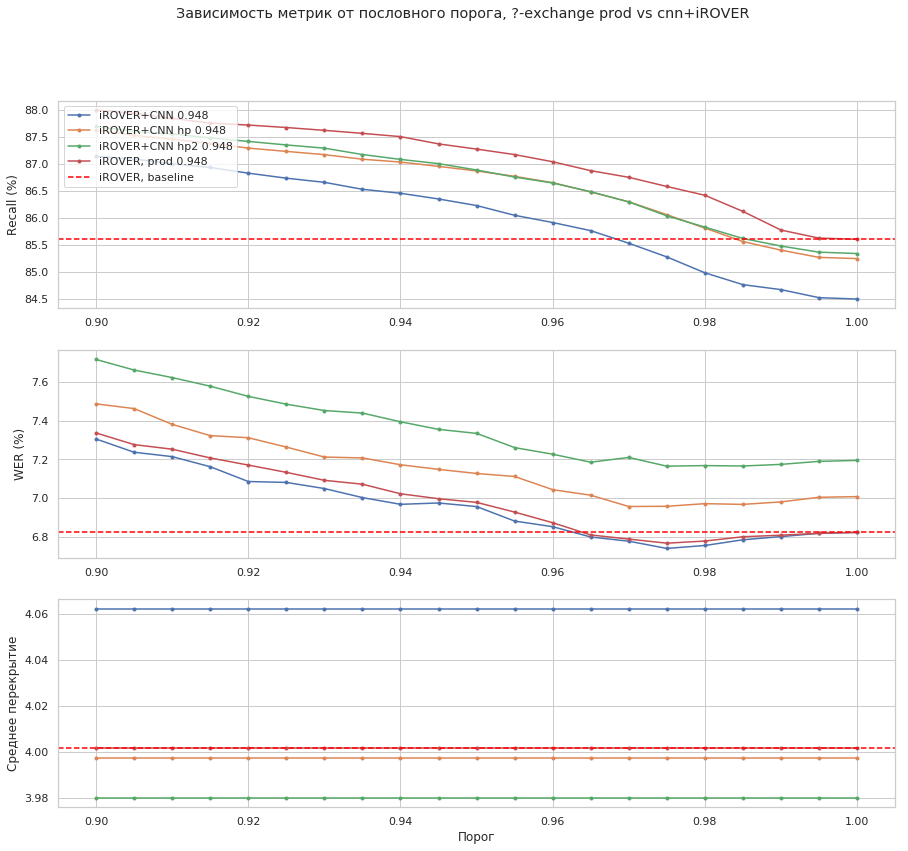

In [161]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange prod vs cnn+iROVER')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER+CNN {:.3f}'.format(key))
for key, value in scores_clf_score_by_word_q_mean.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER+CNN hp {:.3f}'.format(key))
for key, value in scores_clf_score_by_word_q_mean2.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER+CNN hp2 {:.3f}'.format(key))
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='iROVER, prod {:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, baseline")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
for key, value in scores_clf_score_by_word_q_mean.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
for key, value in scores_clf_score_by_word_q_mean2.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
for key, value in scores_clf_score_by_word_q_mean.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
for key, value in scores_clf_score_by_word_q_mean2.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
for key, value in scores_clf_score_by_word_old_clf.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.show()

In [162]:
scores_clf_score_by_word_q_mean3 = defaultdict(list)

for threshhold in [0.948]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.9, 1, 21):
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=4,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated_gs2))
        scores_clf_score_by_word_q_mean3[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean3[threshhold] = np.array(scores_clf_score_by_word_q_mean3[threshhold])


0.948
0.9
Recall: 87.2632%
WER: 7.1830%
Mean overlap: 4.679
0.905
Recall: 87.1521%
WER: 7.1287%
Mean overlap: 4.679
0.91
Recall: 87.1036%
WER: 7.0890%
Mean overlap: 4.679
0.915
Recall: 87.0299%
WER: 7.0435%
Mean overlap: 4.679
0.92
Recall: 86.9580%
WER: 6.9904%
Mean overlap: 4.679
0.925
Recall: 86.8927%
WER: 6.9493%
Mean overlap: 4.679
0.93
Recall: 86.8333%
WER: 6.9153%
Mean overlap: 4.679
0.935
Recall: 86.7139%
WER: 6.9018%
Mean overlap: 4.679
0.9400000000000001
Recall: 86.6234%
WER: 6.8554%
Mean overlap: 4.679
0.9450000000000001
Recall: 86.5458%
WER: 6.8145%
Mean overlap: 4.679
0.95
Recall: 86.4259%
WER: 6.7929%
Mean overlap: 4.679
0.9550000000000001
Recall: 86.2859%
WER: 6.7190%
Mean overlap: 4.679
0.96
Recall: 86.1746%
WER: 6.6834%
Mean overlap: 4.679
0.965
Recall: 86.0120%
WER: 6.6406%
Mean overlap: 4.679
0.97
Recall: 85.8118%
WER: 6.6645%
Mean overlap: 4.679
0.975
Recall: 85.5336%
WER: 6.6128%
Mean overlap: 4.679
0.98
Recall: 85.3078%
WER: 6.6152%
Mean overlap: 4.679
0.985
Recal